In [1]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()
import pyrosetta.rosetta.protocols.rigid as rigid_moves
from pyrosetta.rosetta.core.id import *
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import itertools
from recces.util import torsion_volume
import recces.data

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=1285674694 seed_offset=0 real_seed=1285674694
core.init.random: RandomGenerator

In [2]:
pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner('c', 'g')
print pose.fold_tree()
c_g_hist = recces.data.SingleHistSimulation('./../recces_rosetta/results/c_g/ST/')
ST_min = pose_from_file('min.pdb')
fold_tree = pose.fold_tree()
ST_min.fold_tree(fold_tree)

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 603 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.6875 seconds.
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: s

In [132]:
pmm.apply(pose)
pose.jump(1).get_rotation()




In [ ]:
pert_mover = rigid_moves.RigidBodyPerturbMover(1, 20, 0.5)

In [ ]:
pmm = PyMOLMover()
pmm.apply(pose)

In [ ]:
pert_mover.apply(pose)
pmm.apply(pose)

In [ ]:
movemap = MoveMap()

In [ ]:
movemap.set_jump(1, True)
movemap.set_bb(True)
movemap.set_chi(True)

In [ ]:
scorefxn = protocols.rna.denovo.get_rna_hires_scorefxn()

In [ ]:
minmover = protocols.minimization_packing.MinMover()
minmover.score_function(scorefxn)
minmover.tolerance(1e-7)
minmover.max_iter(100000)
minmover.movemap(movemap)

In [ ]:
minmover.apply(pose)

In [ ]:
pmm.apply(pose)

In [ ]:
print pert_mover.

In [ ]:
scorefxn(pose)

In [ ]:
pose.jump(1).set_translation(numeric.xyzVector_double_t(1.,1.,1.))

In [ ]:
print core.id.TorsionID(1, BB, 2)

In [ ]:
scorefxn(pose)

In [ ]:
trans_mover = rigid_moves.RigidBodyTransMover(pose, 1)
spin_mover = rigid_moves.RigidBodyDeterministicSpinMover()
spin_mover.rb_jump(1)
spin_mover.angle_magnitude(-1)
pmm.apply(pose)


In [ ]:
trans_mover.step_size(20)
trans_mover.apply(pose)
E_0 = scorefxn(pose)

In [ ]:
pmm.apply(pose)

In [ ]:
pose.assign(minimum)
pert_mover.apply(pose)

In [ ]:

spin_mover.spin_axis(numeric.xyzVector_double_t(0,1,0))

In [ ]:
spin_mover.apply(pose)
pmm.apply(pose)

In [3]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [4]:
def tr_energy(pose, scorefxn, i, j, h=0.001):
    
    w = 0.004
    n_pts = int(w/h + 1)
    energy = np.zeros((n_pts,n_pts))
    
    if i == 0: a = numeric.xyzVector_double_t(1,0,0)
    elif i == 1: a = numeric.xyzVector_double_t(0,1,0)
    else: a = numeric.xyzVector_double_t(0,0,1)
            
    if j == 3: b = numeric.xyzVector_double_t(1,0,0)
    elif j == 4: b = numeric.xyzVector_double_t(0,1,0)
    else: b = numeric.xyzVector_double_t(0,0,1)
        
    # Initialize first rigid body mover
    step_i = rigid_moves.RigidBodyTransMover(pose, 1)
    step_i.trans_axis(a)
    step_i.step_size(-w/2)
    
    # Initialize second spin mover
    spin_j = rigid_moves.RigidBodyDeterministicSpinMover()
    spin_j.spin_axis(b)
    spin_j.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    spin_j.angle_magnitude(-w/2./np.pi*180.)
    
    
    step_i.apply(pose)
    spin_j.apply(pose)
    energy[0,0] = scorefxn(pose)
    
    step_i.step_size(h)
    spin_j.angle_magnitude(h/np.pi*180)
    
    for dy in range(1, n_pts):
        
        spin_j.apply(pose)
        energy[0, dy] = scorefxn(pose)
        
    spin_j.angle_magnitude(-(w+h)/np.pi*180)
    spin_j.apply(pose)
    spin_j.angle_magnitude(h/np.pi*180)
       
    for dx in range(1, n_pts):
        
        step_i.apply(pose)
        
        for dy in range(n_pts):
            
            spin_j.apply(pose)
            energy[dx,dy] = scorefxn(pose)
            
        spin_j.angle_magnitude(-(w+h)/np.pi*180)
        spin_j.apply(pose)
        spin_j.angle_magnitude(h/np.pi*180)
    
    return energy



In [5]:
def rr_energy(pose, scorefxn, i, j, h=0.001):
    
    w = 0.004
    n_pts = int(w/h + 1)
    energy = np.zeros((n_pts,n_pts))
    
    if i == 3: 
        
        a = numeric.xyzVector_double_t(1,0,0)
        
        if j == 4: b = numeric.xyzVector_double_t(0,1,0)
        else: b = numeric.xyzVector_double_t(0,0,1)
            
    else: 
        
        a = numeric.xyzVector_double_t(0,1,0)
        b = numeric.xyzVector_double_t(0,0,1)
        
    # Initialize first spin mover
    spin_i = rigid_moves.RigidBodyDeterministicSpinMover()
    spin_i.spin_axis(a)
    spin_i.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    spin_i.angle_magnitude(-w/2./np.pi*180.)
    
    # Initialize second spin mover
    spin_j = rigid_moves.RigidBodyDeterministicSpinMover()
    spin_j.spin_axis(b)
    spin_j.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    spin_j.angle_magnitude(-w/2./np.pi*180.)
    
    spin_i.apply(pose)
    spin_j.apply(pose)
    
    energy[0,0] = scorefxn(pose)
    
    spin_i.angle_magnitude(h/np.pi*180)
    spin_j.angle_magnitude(h/np.pi*180)
    
    for dy in range(1, n_pts):
        
        spin_j.apply(pose)
        energy[0, dy] = scorefxn(pose)
        
    spin_j.angle_magnitude(-(w+h)/np.pi*180)
    spin_j.apply(pose)
    spin_j.angle_magnitude(h/np.pi*180)
       
    for dx in range(1, n_pts):
        
        spin_i.apply(pose)
        
        for dy in range(n_pts):
            
            spin_j.apply(pose)
            energy[dx,dy] = scorefxn(pose)
            
        spin_j.angle_magnitude(-(w+h)/np.pi*180)
        spin_j.apply(pose)
        spin_j.angle_magnitude(h/np.pi*180)
    
        print energy
    
    return energy
        
    
    
        
        

In [6]:
def tt_energy(pose, scorefxn, i, j, h = 0.001):
    
    w = 0.004
    n_pts = int(w/h + 1)
    energy = np.zeros((n_pts,n_pts))
    
    if i == 0: 
        
        a = numeric.xyzVector_double_t(1,0,0)
        
        if j == 1: b = numeric.xyzVector_double_t(0,1,0)
        else: b = numeric.xyzVector_double_t(0,0,1)
            
    else: 
        
        a = numeric.xyzVector_double_t(0,1,0)
        b = numeric.xyzVector_double_t(0,0,1)
    
    # Initialize first rigid body mover
    step_i = rigid_moves.RigidBodyTransMover(pose, 1)
    step_i.trans_axis(a)
    step_i.step_size(-w/2)

    # Initialize second rigid body mover
    step_j = rigid_moves.RigidBodyTransMover(pose, 1)
    step_j.trans_axis(b)
    step_j.step_size(-w/2)
    step_i.apply(pose)
    scorefxn(pose)
    step_j.apply(pose)
    
    energy[0,0] = scorefxn(pose)
    
    step_i.step_size(h)
    step_j.step_size(h)
    
    for dy in range(1,n_pts):
        
        step_j.apply(pose)
        energy[0, dy] = scorefxn(pose)
        
    step_j.step_size(-(w+h))
    step_j.apply(pose)
    
    for dx in range(1, n_pts):
        
        step_i.apply(pose)
        step_j.step_size(h)
        
        for dy in range(n_pts):
            
            step_j.apply(pose)
            energy[dx,dy] = scorefxn(pose)
            print dx, dy
        
        step_j.step_size(-(w+h))
        step_j.apply(pose)
        
    
    return energy
        

In [21]:
# Initialize crap
pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner('g', 'c')
pmm = PyMOLMover()
rna_hires = protocols.rna.denovo.get_rna_hires_scorefxn()

rna_hires.set_weight(core.scoring.ch_bond, 0.)
rna_hires.set_weight(core.scoring.rna_sugar_close, 0.)
rna_hires.set_weight(core.scoring.hbond_lr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sc, 0.)
rna_hires.set_weight(core.scoring.geom_sol, 0.)
rna_hires.set_weight(core.scoring.atom_pair_constraint, 0.)
rna_hires.set_weight(core.scoring.fa_atr,0.73)
rna_hires.set_weight(core.scoring.fa_rep, 0.10)
rna_hires.set_weight(core.scoring.fa_intra_rep, 0.0071) 
rna_hires.set_weight(core.scoring.lk_nonpolar, 0.25) 
rna_hires.set_weight(core.scoring.fa_elec_rna_phos_phos, 4.54) 
rna_hires.set_weight(core.scoring.rna_torsion, 4.26) 
rna_hires.set_weight(core.scoring.stack_elec, 1.54) 
rna_hires.set_weight(core.scoring.hbond_sc, 2.46)
scorefxn = rna_hires
minimum = Pose()


In [22]:
#only try this stuff if we don't start in a local min (assuming all the other nonsense is valid)
movemap = MoveMap()
movemap.set(core.id.TorsionID(1, JUMP, 1), True) 
movemap.set(core.id.TorsionID(1, JUMP, 2), True)
movemap.set(core.id.TorsionID(1, JUMP, 3), True)
#movemap.set_chi(True)
movemap.set_jump(1, True)
minmover = protocols.minimization_packing.MinMover()
minmover.score_function(scorefxn)
minmover.tolerance(1e-8)
minmover.max_iter(1000000)
minmover.movemap(movemap)
minmover.min_type('lbfgs_armijo')
minmover.min_options().use_nblist(True)
minmover.min_options().nblist_auto_update(True)
minmover.apply(pose)
minimum.assign(pose)
pmm.apply(minimum)
print scorefxn(minimum)
print pose.jump(1).get_translation()
# Energy of separate bases

far_mover = rigid_moves.RigidBodyTransMover(pose, 1)
far_mover.step_size(20)
far_mover.apply(pose)
E_0 = scorefxn(pose)
far_mover.step_size(-20)
far_mover.apply(pose)
pose.assign(minimum)


-12.5124056838
      6.230050856038639     0.09359682801770551   -0.005601791652530282
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23005 0.0935968 -0.00560179
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 26.0816 -1.03542 2.14885
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 26.0816 -1.03542 2.14885
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23005 0.0935968 -0.00560179


In [23]:
scorefxn(pose)

-12.51240568382962

In [24]:
# Basic parameters for central diff approximation to hessian
'''
hoogsteen = pose_from_pdb('./output_71.pdb')
hoogsteen.fold_tree(fold_tree)
minmover.apply(hoogsteen)
pose.assign(hoogsteen)
minimum.assign(hoogsteen)
pmm.apply(pose)'''

hessian = np.zeros((6,6))


h = 0.001
w = 0.004
#obs = rosetta.protocols.moves.AddPyMOLObserver(pose, True)
n_pts = int(w/h + 1)
ind = int(n_pts/2) # Point at which to approximate hessian
pose.assign(minimum)

for pair in list(itertools.combinations(range(6), 2)):
     
    print pair
    foo = pair[0]
    bar = pair[1]
        
    if foo in [0,1,2] and bar in [0,1,2]:

        energy = tt_energy(pose, scorefxn, foo, bar)
        #energy -= E_0
        pose.assign(minimum)
        print energy

    elif foo in [0,1,2] and bar in [3,4,5]:

        energy = tr_energy(pose, scorefxn, foo, bar)
        #energy -= E_0
        pose.assign(minimum)

    else:

        energy = rr_energy(pose, scorefxn, foo, bar)
        #energy -= E_0
        pose.assign(minimum)
        print energy

    hess = numpy_hessian(energy, h=h)
    
    d2E_dx2 = hess[0,0,:,:]
    d2E_dy2 = hess[1,1,:,:]
    d2E_dxdy = hess[0,1,:,:]
    
    if hessian[foo, foo] == 0: hessian[foo, foo] = d2E_dx2[ind, ind]
    if hessian[bar, bar] == 0: hessian[bar, bar] = d2E_dy2[ind, ind]
    hessian[foo, bar] = d2E_dxdy[ind, ind]
    hessian[bar, foo] = d2E_dxdy[ind, ind]
    
    pose.assign(minimum)
    

(0, 1)
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23005 0.0935968 -0.00560179
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.2289 0.0919634 -0.0057048
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.2289 0.0919634 -0.0057048
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.2305 0.0908696 -0.00620172
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.2305 0.0908696 -0.00620172
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23302 0.0927728 -0.00629568
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23302 0.0927728 -0.00629568
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23222 0.0933198 -0.00604721
3 0
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23222 0.0933198 -0.00604721
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23143 0.0938667 -0.00579875
3 1
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.22838 0.0925153 -0.00860661
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.22895 0.093332 -0.00855511
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.22895 0.093332 -0.00855511
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.22913 0.093148 -0.00758784
1 0
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.22913 0.093148 -0.00758784
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23068 0.0957822 -0.0084006
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23068 0.0957822 -0.0084006
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23085 0.0955982 -0.00743333
4 0
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23085 0.0955982 -0.00743333
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23103 0.0954143 -0.00646606
4 1
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.1

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990141 0.140028 0.00371001 0.139998 0.990125 -0.00724958 -0.00468852 -0.00665871 -0.999967 6.22997 0.0925846 -0.0080975
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3186 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.22948 0.0927801 -0.00565329
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3186 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.22948 0.0927801 -0.00565329
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3186 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990161 0.139916 0.00207728 0.139901 0.990147 -0.00609988 -0.00291028 -0.00574925 -0.999979 6.2289

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3206 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23063 0.0944136 -0.00555029
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3206 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990161 0.139916 0.00207728 0.139901 0.990147 -0.00609988 -0.00291028 -0.00574925 -0.999979 6.23013 0.0946076 -0.00310556
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3206 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990161 0.139916 0.00207728 0.139901 0.990147 -0.00609988 -0.00291028 -0.00574925 -0.999979 6.23013 0.0946076 -0.00310556
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3206 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99017 0.13986 0.0012

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990188 0.139722 0.00234853 0.139701 0.990166 -0.00747351 -0.00336965 -0.00707209 -0.999969 6.22846 0.0908482 -0.00466422
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3176 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990188 0.139722 0.00234853 0.139701 0.990166 -0.00747351 -0.00336965 -0.00707209 -0.999969 6.22846 0.0908482 -0.00466422
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3176 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990224 0.139472 0.0018036 0.139452 0.990194 -0.00827245 -0.00293969 -0.00794006 -0.999964 6.22802 0.089733 -0.00361864
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3176 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990224 0.139472 0.0018036 0.139452 0.990194 -0.00827245 -0.00293969 -0.00794006 -0.999964 6.228

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.99239
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990224 0.139472 0.0018036 0.139452 0.990194 -0.00827245 -0.00293969 -0.00794006 -0.999964 6.22917 0.0913669 -0.00351757
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.99239
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990224 0.139472 0.0018036 0.139452 0.990194 -0.00827245 -0.00293969 -0.00794006 -0.999964 6.22917 0.0913669 -0.00351757
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.99239
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990039 0.140718 0.00453026 0.140699 0.990043 -0.0042791 -0.00508729 -0.00359908 -0.999981 6.23137 0.09695 -0.00873413
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.99239
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990039 0.140718

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990224 0.139472 0.0018036 0.139452 0.990194 -0.00827245 -0.00293969 -0.00794006 -0.999964 6.23032 0.0930007 -0.00341651
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3216 -10.172 3.99239
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990039 0.140718 0.00453026 0.140699 0.990043 -0.0042791 -0.00508729 -0.00359908 -0.999981 6.23252 0.0985838 -0.00863306
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3216 -10.172 3.99239
protocols.moves.RigidBodyMover: Spin: ---
(0, 5)
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23005 0.0935968 -0.00560179
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.2289 0.0919634 -0.0057048
protocols.moves.RigidBodyMover: Sp

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3186 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989743 0.142841 0.00232163 0.142821 0.989722 -0.00720654 -0.00332715 -0.00680105 -0.999971 6.23062 0.100142 -0.00445941
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989743 0.142841 0.00232163 0.142821 0.989722 -0.00720654 -0.00332715 -0.00680105 -0.999971 6.23119 0.100959 -0.00440791
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989743 0.142841 0.00232163 0.142821 0.989722 -0.00720654 -0.00332715 -0.00680105 -0.999971 6.23119 0.100959 -0.00440791
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3186 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98988 0.141884 0.00251248 0.141864 0.989861 -0.00702945 -0.00348437 -0.00660188 -0.999972 6.23081 0.0985068 -0.00480471
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocol

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989743 0.142841 0.00232163 0.142821 0.989722 -0.00720654 -0.00332715 -0.00680105 -0.999971 6.23234 0.102594 -0.00430441
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3206 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98988 0.141884 0.00251248 0.141864 0.989861 -0.00702945 -0.00348437 -0.00660188 -0.999972 6.23196 0.100141 -0.00470121
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3216 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98988 0.141884 0.00251248 0.141864 0.989861 -0.00702945 -0.00348437 -0.00660188 -0.999972 6.23196 0.100141 -0.00470121
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3216 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990016 0.140928 0.00270315 0.140907 0.989999 -0.00685217 -0.00364178 -0.00640287 -0.999973 6.23157 0.0976882 -0.00509875
protocols.moves.Rigi

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.2312 0.092682 -0.00391571
1 4
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.2312 0.092682 -0.00391571
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23033 0.0936018 -0.00875207
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23033 0.0936018 -0.00875207
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.22953 0.0941487 -0.00850361
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 

4 4
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.2288 0.0943227 -0.00317032
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.22793 0.0952425 -0.00800668
[[-12.51234939 -12.51234776 -12.51233884 -12.51232259 -12.51229901]
 [-12.5123866  -12.51239136 -12.51238883 -12.51237901 -12.51236188]
 [-12.51239064 -12.51240179 -12.51240568 -12.51240229 -12.51239161]
 [-12.51236151 -12.51237908 -12.51238939 -12.51239244 -12.51238822]
 [-12.51229923 -12.51232321 -12.51233995 -12.51234946 -12.5123517 ]]
(1, 3)
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23005 0.0935968 -0.00560179
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.1399

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990117 0.140141 0.0053426 0.140094 0.990103 -0.00839943 -0.00646683 -0.00756795 -0.99995 6.23235 0.0924582 -0.0131765
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.173 3.99241
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990117 0.140141 0.0053426 0.140094 0.990103 -0.00839943 -0.00646683 -0.00756795 -0.99995 6.23235 0.0924582 -0.0131765
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990117 0.140141 0.0053426 0.140094 0.990103 -0.00839943 -0.00646683 -0.00756795 -0.99995 6.23155 0.0930051 -0.012928
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990117 0.140141 0.0053426 0.140094 0.990103 -0.00839943 -0.00646683 -0.00756795 -0.99995 6.23155 0.0930051 -0.012928
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.173 3.99241
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990129 0.140084 0.00452632 0.140

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990117 0.140141 0.0053426 0.140094 0.990103 -0.00839943 -0.00646683 -0.00756795 -0.99995 6.22995 0.0940985 -0.0124292
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990117 0.140141 0.0053426 0.140094 0.990103 -0.00839943 -0.00646683 -0.00756795 -0.99995 6.22995 0.0940985 -0.0124292
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.171 3.99241
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990129 0.140084 0.00452632 0.140046 0.990114 -0.00782448 -0.00557766 -0.00711335 -0.999959 6.22945 0.0942967 -0.00998503
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.17 3.99241
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990129 0.140084 0.00452632 0.140046 0.990114 -0.00782448 -0.00557766 -0.00711335 -0.999959 6.22945 0.0942967 -0.00998503
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.17 3.99241
protocols.moves

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.174 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990077 0.140469 0.00398452 0.140449 0.990075 -0.0050775 -0.00465821 -0.0044675 -0.999979 6.23173 0.0952839 -0.00793574
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.173 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990077 0.140469 0.00398452 0.140449 0.990075 -0.0050775 -0.00465821 -0.0044675 -0.999979 6.23173 0.0952839 -0.00793574
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.173 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990114 0.140221 0.00343899 0.140199 0.990106 -0.00587604 -0.00422891 -0.00533581 -0.999977 6.23129 0.0941665 -0.00689357
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.173 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990114 0.140221 0.00343

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990077 0.140469 0.00398453 0.140449 0.990075 -0.0050775 -0.00465821 -0.0044675 -0.999979 6.23013 0.0963777 -0.00743882
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.171 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990114 0.140221 0.00343899 0.140199 0.990106 -0.00587604 -0.00422891 -0.00533581 -0.999977 6.22969 0.0952604 -0.00639664
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.171 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990114 0.140221 0.00343899 0.140199 0.990106 -0.00587604 -0.00422891 -0.00533581 -0.999977 6.22969 0.0952604 -0.00639664
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.171 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.22925 0.0941437 -0.00535333
protocols.moves.Ri

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.174 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990016 0.140928 0.00270315 0.140907 0.989999 -0.00685217 -0.00364178 -0.00640287 -0.999973 6.23203 0.0949532 -0.00570088
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.174 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23165 0.0924998 -0.00609892
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.174 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23165 0.0924998 -0.00609892
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.174 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990285 0.139015 0.003

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23005 0.0935919 -0.0056021
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23005 0.0935919 -0.0056021
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990285 0.139015 0.003084 0.138993 0.990272 -0.00649706 -0.00395718 -0.00600529 -0.999974 6.22967 0.0911381 -0.00600064
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990285 0.139015 0.003084 0.138993 0.990272 -0.00649706 -0.00395718 -0.00600529 -0.999974 6.22967 0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.17 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990285 0.139015 0.003084 0.138993 0.990272 -0.00649706 -0.00395718 -0.00600529 -0.999974 6.22807 0.0922303 -0.00550382
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.17 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990285 0.139015 0.003084 0.138993 0.990272 -0.00649706 -0.00395718 -0.00600529 -0.999974 6.22807 0.0922303 -0.00550382
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.17 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990419 0.138058 0.00327416 0.138035 0.990407 -0.00631923 -0.00411517 -0.00580674 -0.999975 6.2277 0.0897762 -0.00590287
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.17 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990419 0.138058 0.00327416 0

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990161 0.139916 0.00207728 0.139901 0.990147 -0.00609988 -0.00291028 -0.00574925 -0.999979 6.22939 0.0939721 -0.00412558
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9914
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99017 0.13986 0.00126086 0.139851 0.990157 -0.00552509 -0.00202119 -0.00529445 -0.999984 6.22889 0.0941648 -0.00168033
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9914
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99017 0.13986 0.00126086 0.139851 0.990157 -0.00552509 -0.00202119 -0.00529445 -0.999984 6.22889 0.0941648 -0.00168033
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9914
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990117 0.140141 0.0053426 0.140094 0.990103 -0.00839943 -0.00646683 -0.00756795 -0.99995 6.23138 0.0931873 -0.0139014
protocols.moves.RigidB

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9934
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99017 0.13986 0.00126086 0.139851 0.990157 -0.00552509 -0.00202119 -0.00529445 -0.999984 6.22924 0.0937958 0.000253711
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9934
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990117 0.140141 0.0053426 0.140094 0.990103 -0.00839943 -0.00646683 -0.00756795 -0.99995 6.23173 0.0928182 -0.0119673
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9934
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990117 0.140141 0.0053426 0.140094 0.990103 -0.00839943 -0.00646683 -0.00756795 -0.99995 6.23173 0.0928182 -0.0119673
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990117 0.140141 0.0053426 0.140094 0.990103 -0.00839943 -0.00646683 -0.00756795 -0.99995 6.

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990039 0.140718 0.00453026 0.140699 0.990043 -0.0042791 -0.00508729 -0.00359908 -0.999981 6.23103 0.0973201 -0.0106627
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9904
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990039 0.140718 0.00453026 0.140699 0.990043 -0.0042791 -0.00508729 -0.00359908 -0.999981 6.23103 0.0973201 -0.0106627
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990039 0.140718 0.00453026 0.140699 0.990043 -0.0042791 -0.00508729 -0.00359908 -0.999981 6.2312 0.0971361 -0.00969539
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990039 0.140718 0.00453026 0.140699 0.990043 -0.0042791 -0.00508729 -0.00359908 -0.999981 6.2312 0.0971361 -0.00969539
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9904
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990077 0.140469 0.00398452 0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990039 0.140718 0.00453026 0.140699 0.990043 -0.0042791 -0.00508729 -0.00359908 -0.999981 6.23155 0.0967698 -0.00776074
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990039 0.140718 0.00453026 0.140699 0.990043 -0.0042791 -0.00508729 -0.00359908 -0.999981 6.23155 0.0967698 -0.00776074
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990077 0.140469 0.00398453 0.140449 0.990075 -0.0050775 -0.00465821 -0.0044675 -0.999979 6.23111 0.0956525 -0.00671965
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9934
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990077 0.140469 0.00398453 0.140449 0.990075 -0.0050775 -0.00465821 -0.0044675 -0.999979 6.23111 0.0956525 -0.00671965
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9934
protocols.moves.

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98988 0.141884 0.00251248 0.141864 0.989861 -0.00702945 -0.00348437 -0.00660188 -0.999972 6.23046 0.0988714 -0.00674074
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9904
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98988 0.141884 0.00251248 0.141864 0.989861 -0.00702945 -0.00348437 -0.00660188 -0.999972 6.23046 0.0988714 -0.00674074
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9904
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990016 0.140928 0.00270315 0.140907 0.989999 -0.00685217 -0.00364178 -0.00640287 -0.999973 6.23008 0.0964183 -0.00713829
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9904
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990016 0.140928 0.002

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98988 0.141884 0.00251248 0.141864 0.989861 -0.00702945 -0.00348437 -0.00660188 -0.999972 6.23081 0.0985035 -0.0048062
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990016 0.140928 0.00270315 0.140907 0.989999 -0.00685217 -0.00364178 -0.00640287 -0.999973 6.23043 0.0960503 -0.00520375
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990016 0.140928 0.00270315 0.140907 0.989999 -0.00685217 -0.00364178 -0.00640287 -0.999973 6.23043 0.0960503 -0.00520375
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23005 0.0935968 -0.00560179
protocols.moves.Ri

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9944
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990016 0.140928 0.00270315 0.140907 0.989999 -0.00685217 -0.00364178 -0.00640287 -0.999973 6.23078 0.0956824 -0.0032692
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9944
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.2304 0.0932289 -0.00366725
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9944
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.2304 0.0932289 -0.00366725
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9944
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990285 0.139015 0.003084

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990103 0.14028 0.00425463 0.140251 0.990095 -0.00645165 -0.00511752 -0.00579108 -0.99997 6.23099 0.0945271 -0.00908801
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99014 0.140031 0.00370944 0.140001 0.990125 -0.00725012 -0.00468805 -0.00665931 -0.999967 6.23055 0.0934087 -0.00804482
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99014 0.140031 0.00370944 0.140001 0.990125 -0.00725012 -0.00468805 -0.00665931 -0.999967 6.23055 0.0934087 -0.00804482
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990177 0.139781 0.00316

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990087 0.140422 0.00316673 0.140407 0.990084 -0.00450387 -0.00376777 -0.00401459 -0.999985 6.23044 0.0960433 -0.00523919
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990124 0.140173 0.00262105 0.140158 0.990115 -0.00530261 -0.00333842 -0.00488288 -0.999983 6.23 0.0949278 -0.00419691
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990124 0.140173 0.00262105 0.140158 0.990115 -0.00530261 -0.00333842 -0.00488288 -0.999983 6.23 0.0949278 -0.00419691
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99016 0.139924 0.00207557

(3, 5)
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23005 0.0935968 -0.00560179
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990129 0.140084 0.00452632 0.140046 0.990114 -0.00782448 -0.00557766 -0.00711335 -0.999959 6.23105 0.0932044 -0.0104897
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990129 0.140084 0.00452632 0.140046 0.990114 -0.00782448 -0.00557766 -0.00711335 -0.999959 6.23105 0.0932044 -0.0104897
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989858 0.141997 0.00414292 0.14196 0.989839 -0.00818238 -0.00526269 -0.00751127 -0.999958 6.23181 0.0981074 -0.00969433
protocols.mo

[[-12.51146005 -12.51208967 -12.51225539 -12.51195363 -12.5111813 ]
 [-12.51150752 -12.51216938 -12.51236802 -12.51209975 -12.51136072]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]]
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989733 0.142896 0.00313467 0.142868 0.989711 -0.00778617 -0.00421503 -0.00725838 -0.999965 6.23169 0.100755 -0.00685041
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989743 0.142839 0.00231835 0.142819 0.989723 -0.00721133 -0.00332458 -0.00680626 -0.999971 6.23119 0.10095 -0.00440291
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989743 0.142839 0.00231835 0.142819 0.989723 -0.0072

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990429 0.138 0.00245179 0.137984 0.990418 -0.00575319 -0.00322223 -0.00535982 -0.99998 6.2288 0.0888711 -0.00394541
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989753 0.142783 0.001502 0.14277 0.989734 -0.00663653 -0.00243416 -0.00635409 -0.999977 6.2307 0.101143 -0.00195489
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
[[-12.51146005 -12.51208967 -12.51225539 -12.51195363 -12.5111813 ]
 [-12.51150752 -12.51216938 -12.51236802 -12.51209975 -12.51136072]
 [-12.51148184 -12.512175   -12.51240569 -12.51217027 -12.51146467]
 [-12.51138358 -12.51210698 -12.51236865 -12.51216497 -12.51149199]
 [  0.           0.           0.           0.           0.        ]]
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989753 0.142783 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990212 0.139512 0.00417332 0.139492 0.990211 -0.0048988 -0.00481591 -0.00426871 -0.999979 6.23055 0.0933782 -0.00808527
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990212 0.139512 0.00417332 0.139492 0.990211 -0.0048988 -0.00481591 -0.00426871 -0.999979 6.23055 0.0933782 -0.00808527
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990345 0.138555 0.00436193 0.138535 0.990346 -0.00471992 -0.00497379 -0.00407007 -0.999979 6.23018 0.0909254 -0.00848376
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990345 0.138555 0.004

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990151 0.139972 0.00289857 0.13995 0.990136 -0.00667815 -0.00380473 -0.00620672 -0.999973 6.23005 0.0935957 -0.00561647
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990285 0.139015 0.0030889 0.138993 0.990272 -0.0065005 -0.00396252 -0.00600801 -0.999974 6.22968 0.0911419 -0.00601501
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990285 0.139015 0.0030889 0.138993 0.990272 -0.0065005 -0.00396252 -0.00600801 -0.999974 6.22968 0.0911419 -0.00601501
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990419 0.138058 0.003279

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990089 0.140429 0.00162135 0.14041 0.990057 -0.00845574 -0.00279266 -0.00814428 -0.999963 6.22956 0.0938181 -0.00314253
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990224 0.139472 0.00181341 0.139453 0.990194 -0.00827932 -0.00295036 -0.0079455 -0.999964 6.22918 0.0913634 -0.00354113
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990224 0.139472 0.00181341 0.139453 0.990194 -0.00827932 -0.00295036 -0.0079455 -0.999964 6.22918 0.0913634 -0.00354113
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990358 0.138516 0.0020

In [25]:
w,v = np.linalg.eigh(hessian)
print w, v
print 0.6163*(scorefxn(minimum) - E_0 - 3*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(hessian)) + np.log(8*np.pi**2) - np.log(6.022e-4))
pmm.apply(minimum)

[  3.35052183e-01   3.57649015e+00   1.22316701e+01   3.45189749e+01
   1.65184681e+02   5.15163698e+02] [[-0.06066437 -0.72929931  0.34578664  0.57562353  0.09005694 -0.07362914]
 [-0.39922195 -0.51312302  0.07007406 -0.72664142 -0.16048943 -0.13657094]
 [-0.8727058   0.34428026  0.15986583  0.27396303 -0.13326103  0.03852743]
 [ 0.27390433  0.17926105  0.69195463 -0.06344384 -0.63962396 -0.02994574]
 [-0.00475161 -0.22118636 -0.5664588   0.20736451 -0.71079828  0.286259  ]
 [-0.01673632 -0.07239095  0.22424845 -0.13626773  0.18444885  0.94424669]]
1.13345462628


In [12]:
print scorefxn(minimum)
pmm.apply(minimum)

-12.5124025537


In [ ]:
print hessian

In [ ]:
print d2E_dx2[ind, ind]

In [ ]:
print v

In [ ]:
print Vector1([1])

In [ ]:
print core.conformation.all_atom_center(pose.residue(2))

In [26]:
def mode_scan_jump(pose, scorefxn, v, w = 6.0, h = 0.02):
    
    #obs = protocols.moves.AddPyMOLObserver(pose, True)
    minimum = Pose()
    minimum.assign(pose)
    
    vals = []
    
    n_pts = int(w/h + 1)
    
    # Initialize moves for jump DOFs
    x_mover = rigid_moves.RigidBodyTransMover(pose, 1)
    x_mover.trans_axis(numeric.xyzVector_double_t(1,0,0))
    x_mover.step_size(h*v[0])
    
    
    y_mover = rigid_moves.RigidBodyTransMover(pose, 1)
    y_mover.trans_axis(numeric.xyzVector_double_t(0,1,0))
    y_mover.step_size(h*v[1])
    
    z_mover = rigid_moves.RigidBodyTransMover(pose, 1)
    z_mover.trans_axis(numeric.xyzVector_double_t(0,0,1))
    z_mover.step_size(h*v[2])
    
    vx_mover = rigid_moves.RigidBodyDeterministicSpinMover()
    vx_mover.spin_axis(numeric.xyzVector_double_t(1,0,0))
    vx_mover.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    vx_mover.angle_magnitude(h*180./np.pi*v[3])

    vy_mover = rigid_moves.RigidBodyDeterministicSpinMover()
    vy_mover.spin_axis(numeric.xyzVector_double_t(0,1,0))
    vy_mover.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    vy_mover.angle_magnitude(h*180./np.pi*v[4])
    
    vz_mover = rigid_moves.RigidBodyDeterministicSpinMover()
    vz_mover.spin_axis(numeric.xyzVector_double_t(0,0,1))
    vz_mover.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    vz_mover.angle_magnitude(h*180./np.pi*v[5])

    
    
    vals.append(scorefxn(pose))
    
    for ii in range(0,n_pts/2):
        
        x_mover.apply(pose)
        y_mover.apply(pose)
        z_mover.apply(pose)

        vx_mover.apply(pose)
        vy_mover.apply(pose)
        vz_mover.apply(pose)

        vals.append(scorefxn(pose))
        
    
 
    x_mover.step_size(-h*v[0])
    y_mover.step_size(-h*v[1])
    z_mover.step_size(-h*v[2])
    vx_mover.angle_magnitude(-h*180./np.pi*v[3])
    vy_mover.angle_magnitude(-h*180./np.pi*v[4])
    vz_mover.angle_magnitude(-h*180./np.pi*v[5])
        
    pose.assign(minimum)
    
    for ii in range(0, n_pts/2):
        
        x_mover.apply(pose)
        y_mover.apply(pose)
        z_mover.apply(pose)

        vx_mover.apply(pose)
        vy_mover.apply(pose)
        vz_mover.apply(pose)

        vals.insert(0, scorefxn(pose))    
        
    
    return vals    
        
        
        
    

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23005 0.0935968 -0.00560179
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.22935 0.0926059 -0.00566428
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.22935 0.0926059 -0.00566428
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23574 0.0882392 -0.00764811
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23574 0.0882392 -0.00764811
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3172 -10.1878 3.95741
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990077 0.140132 -0.010556 0.14011 0.990132 0.0028256 0.0108477 0.00131856 -0.99994 6.23033 0.0931301 -0.0220942
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3159 -10.1957 3.93991
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990077 0.140132 -0.010556 0.14011 0.990132 0.0028256 0.0108477 0.00131856 -0.99994 6.23033 0.0931301 -0.0220942
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990077 0.140132 -0.010556 0.14011 0.990132 0.0028256 0.0108477 0.00131856 -0.99994 6.22963 0.0921391 -0.0221567
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990077 0.140132 -0.010556 0.14011 0.990132 0.0028256 0.0108477 0.00131856 -0.99994 6.22963 0.0921391 -0.0221567
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990077 0.140132 -0.010556 0.14011 0.990132

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3123 -10.2194 3.88741
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989852 0.140073 -0.0239439 0.139809 0.990101 0.0123776 0.0254406 0.00890446 -0.999637 6.23102 0.0914519 -0.0385715
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3135 -10.2115 3.90491
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989805 0.140394 -0.0240014 0.140131 0.990056 0.0123269 0.0254934 0.00883791 -0.999636 6.23116 0.0922807 -0.038438
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3123 -10.2194 3.88741
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989805 0.140394 -0.0240014 0.140131 0.990056 0.0123269 0.0254934 0.00883791 -0.999636 6.23116 0.0922807 -0.038438
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989805 0.140394 -0.0240014 0.140131 0.990056 0.0123269 0.0254934 0.00883791 -0.999636 6.23046 0.0

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3099 -10.2351 3.85242
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989384 0.140436 -0.0373847 0.13969 0.989954 0.0218731 0.0400809 0.0164186 -0.999062 6.23239 0.090214 -0.0547776
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3087 -10.243 3.83492
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989384 0.140436 -0.0373847 0.13969 0.989954 0.0218731 0.0400809 0.0164186 -0.999062 6.23239 0.090214 -0.0547776
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3099 -10.2351 3.85242
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989336 0.140758 -0.0374391 0.140013 0.989909 0.0218267 0.0401336 0.016352 -0.999061 6.23253 0.0910471 -0.054644
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3087 -10.243 3.83492
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989336 0.140758 -0.0374391 0.140013

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.305 -10.2667 3.78243
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988719 0.140878 -0.0508667 0.139413 0.98974 0.0312873 0.0547525 0.0238428 -0.998215 6.23427 0.088495 -0.070758
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3062 -10.2588 3.79993
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988719 0.1409 -0.0508141 0.139433 0.989735 0.0313643 0.0547117 0.0239254 -0.998216 6.23431 0.0885908 -0.070857
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.305 -10.2667 3.78243
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988719 0.1409 -0.0508141 0.139433 0.989735 0.0313643 0.0547117 0.0239254 -0.998216 6.23431 0.0885908 -0.070857
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3062 -10.2588 3.79993
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98867 0.141222 -0.0508654 0.139756 0.98969 

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3026 -10.2825 3.74743
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987857 0.141443 -0.0642813 0.139018 0.98945 0.0407716 0.06937 0.0313403 -0.997099 6.23674 0.0864882 -0.0867218
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3014 -10.2903 3.72994
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987857 0.141443 -0.0642813 0.139018 0.98945 0.0407716 0.06937 0.0313403 -0.997099 6.23674 0.0864882 -0.0867218
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3026 -10.2825 3.74743
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987858 0.141464 -0.0642285 0.139036 0.989445 0.0408489 0.0693292 0.0314228 -0.997099 6.23678 0.086581 -0.0868208
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3014 -10.2903 3.72994
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987858 0.141464 -0.0642285 0.139036 0.9

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987124 0.142219 -0.0732073 0.139018 0.989168 0.0471323 0.0791174 0.0363483 -0.996202 6.24151 0.0837232 -0.1162
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2989 -10.3061 3.69494
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.986799 0.142108 -0.0776771 0.138483 0.989089 0.0502467 0.0839701 0.0388264 -0.995712 6.23976 0.0840937 -0.102581
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2977 -10.314 3.67744
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986799 0.142108 -0.0776771 0.138483 0.989089 0.0502467 0.0839701 0.0388264 -0.995712 6.23976 0.0840937 -0.102581
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2989 -10.3061 3.69494
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.9868 0.14213 -0.0776242 0.1385 0.989083 0.0503241 0.0839293 0.0389089 -0.995712 6.23979 0.0841835 -0.10268
protocols.moves.RigidBodyMover: Spin: Rot  (after)

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.985935 0.142952 -0.0865854 0.13839 0.988759 0.0566044 0.0937037 0.0438257 -0.994635 6.2449 0.0810705 -0.131995
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.985935 0.142952 -0.0865854 0.13839 0.988759 0.0566044 0.0937037 0.0438257 -0.994635 6.2449 0.0810705 -0.131995
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2953 -10.3298 3.64245
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.985544 0.142875 -0.0910506 0.13781 0.988657 0.0597099 0.0985489 0.0462991 -0.994055 6.24334 0.0813105 -0.118347
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2941 -10.3377 3.62495
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.985544 0.142875 -0.0910506 0.13781 0.988657 0.0597099 0.0985489 0.0462991 -0.994055 6.24334 0.0813105 -0.118347
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2953 -10.3298 3.64245
protocols.moves.RigidBodyMover: Spin: Jump

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98455 0.143785 -0.0999387 0.137624 0.988279 0.0660629 0.108266 0.0512883 -0.992798 6.25189 0.0748171 -0.130822
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98455 0.143785 -0.0999387 0.137624 0.988279 0.0660629 0.108266 0.0512883 -0.992798 6.24884 0.0780281 -0.147705
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98455 0.143785 -0.0999387 0.137624 0.988279 0.0660629 0.108266 0.0512883 -0.992798 6.24884 0.0780281 -0.147705
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2917 -10.3535 3.58995
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.984093 0.143741 -0.104398 0.136998 0.988154 0.0691587 0.113102 0.0537563 -0.992128 6.24746 0.0781376 -0.13403
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2904 -10.3613 3.57246
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984093 0.143741 -0.104398 0.136998 0.988154 0.0691587 0.1

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982969 0.144718 -0.113264 0.136719 0.987728 0.0755053 0.122801 0.0587342 -0.990692 6.25639 0.0713843 -0.146457
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982969 0.144718 -0.113264 0.136719 0.987728 0.0755053 0.122801 0.0587342 -0.990692 6.25639 0.0713843 -0.146457
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982969 0.144718 -0.113264 0.136719 0.987728 0.0755053 0.122801 0.0587342 -0.990692 6.25334 0.0745953 -0.16334
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.982969 0.144718 -0.113264 0.136719 0.987728 0.0755053 0.122801 0.0587342 -0.990692 6.25334 0.0745953 -0.16334
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.288 -10.3771 3.53746
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.982447 0.144708 -0.117716 0.136047 0.98758 0.0785906 0.127627 0.0611962 -0.989933 6.25214 0.0745741 -0.149642
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2868 -10

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.981193 0.145751 -0.126557 0.135675 0.987107 0.0849291 0.137303 0.0661612 -0.988317 6.25506 0.071927 -0.160044
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981193 0.145751 -0.126557 0.135675 0.987107 0.0849291 0.137303 0.0661612 -0.988317 6.26144 0.0675603 -0.162028
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.981193 0.145751 -0.126557 0.135675 0.987107 0.0849291 0.137303 0.0661612 -0.988317 6.26144 0.0675603 -0.162028
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981193 0.145751 -0.126557 0.135675 0.987107 0.0849291 0.137303 0.0661612 -0.988317 6.25839 0.0707713 -0.178911
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.981193 0.145751 -0.126557 0.135675 0.987107 0.0849291 0.137303 0.0661612 -0.988317 6.25839 0.0707713 -0.178911
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2844 -10.4008 3.48497
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979223 0.146884 -0.139814 0.134494 0.986414 0.0943316 0.15177 0.0735675 -0.985674 6.26067 0.0677111 -0.175562
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979223 0.146884 -0.139814 0.134494 0.986414 0.0943316 0.15177 0.0735675 -0.985674 6.26067 0.0677111 -0.175562
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979223 0.146884 -0.139814 0.134494 0.986414 0.0943316 0.15177 0.0735675 -0.985674 6.26705 0.0633444 -0.177546
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979223 0.146884 -0.139814 0.134494 0.986414 0.0943316 0.15177 0.0735675 -0.985674 6.26705 0.0633444 -0.177546
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979223 0.146884 -0.139814 0.134494 0.986414 0.0943316 0.15177 0.0735675 -0.985674 6.264 0.0665554 -0.194429
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.979223 0.146884 -0.139814 0.134494 0.986414 0.0943316 0.15177 0.0735675 -

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977058 0.148116 -0.153032 0.133175 0.985651 0.10371 0.166197 0.0809509 -0.982764 6.26753 0.0640937 -0.190977
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.977058 0.148116 -0.153032 0.133175 0.985651 0.10371 0.166197 0.0809509 -0.982764 6.26683 0.0631028 -0.19104
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977058 0.148116 -0.153032 0.133175 0.985651 0.10371 0.166197 0.0809509 -0.982764 6.26683 0.0631028 -0.19104
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.977058 0.148116 -0.153032 0.133175 0.985651 0.10371 0.166197 0.0809509 -0.982764 6.27322 0.0587361 -0.193023
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977058 0.148116 -0.153032 0.133175 0.985651 0.10371 0.166197 0.0809509 -0.982764 6.27322 0.0587361 -0.193023
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.977058 0.148116 -0.153032 0.133175 0.985651 0.10371 0.166197 0.0809509 -0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2734 -10.4718 3.32749
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.9747 0.149447 -0.166208 0.131719 0.984818 0.113063 0.180581 0.0883095 -0.979588 6.27425 0.0590925 -0.206424
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.9747 0.149447 -0.166208 0.131719 0.984818 0.113063 0.180581 0.0883095 -0.979588 6.27356 0.0581016 -0.206487
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.9747 0.149447 -0.166208 0.131719 0.984818 0.113063 0.180581 0.0883095 -0.979588 6.27356 0.0581016 -0.206487
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.9747 0.149447 -0.166208 0.131719 0.984818 0.113063 0.180581 0.0883095 -0.979588 6.27994 0.0537349 -0.20847
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.9747 0.149447 -0.166208 0.131719 0.984818 0.113063 0.180581 0.0883095 -0.979588 6.27994 0.0537349 -0.20847
protocols.moves.RigidBo

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.972149 0.150877 -0.179337 0.130126 0.983915 0.122386 0.194917 0.0956413 -0.976145 6.28153 0.0536981 -0.221852
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2698 -10.4954 3.27499
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.972149 0.150877 -0.179337 0.130126 0.983915 0.122386 0.194917 0.0956413 -0.976145 6.28153 0.0536981 -0.221852
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.972149 0.150877 -0.179337 0.130126 0.983915 0.122386 0.194917 0.0956413 -0.976145 6.28084 0.0527072 -0.221915
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.972149 0.150877 -0.179337 0.130126 0.983915 0.122386 0.194917 0.0956413 -0.976145 6.28084 0.0527072 -0.221915
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.972149 0.150877 -0.179337 0.130126 0.983915 0.122386 0.194917 0.0956413 -0.976145 6.28722 0.0483404 -0.223899
protocols.moves.

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2674 -10.5112 3.24
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.969406 0.152405 -0.192416 0.128396 0.982942 0.131678 0.209202 0.102944 -0.972439 6.28937 0.0479102 -0.237273
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2662 -10.5191 3.2225
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.969406 0.152405 -0.192416 0.128396 0.982942 0.131678 0.209202 0.102944 -0.972439 6.28937 0.0479102 -0.237273
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.969406 0.152405 -0.192416 0.128396 0.982942 0.131678 0.209202 0.102944 -0.972439 6.28867 0.0469193 -0.237335
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.969406 0.152405 -0.192416 0.128396 0.982942 0.131678 0.209202 0.102944 -0.972439 6.28867 0.0469193 -0.237335
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.969406 0.152405 -0.192416 0.128396 0.982942 0.131678 0.209

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2637 -10.5349 3.18751
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.966472 0.154031 -0.205442 0.126531 0.9819 0.140936 0.223432 0.110217 -0.968468 6.29776 0.0417288 -0.252697
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2625 -10.5428 3.17001
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.966472 0.154031 -0.205442 0.126531 0.9819 0.140936 0.223432 0.110217 -0.968468 6.29776 0.0417288 -0.252697
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.966472 0.154031 -0.205442 0.126531 0.9819 0.140936 0.223432 0.110217 -0.968468 6.29707 0.0407379 -0.25276
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.966472 0.154031 -0.205442 0.126531 0.9819 0.140936 0.223432 0.110217 -0.968468 6.29707 0.0407379 -0.25276
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.966472 0.154031 -0.205442 0.126531 0.9819 0.140936 0.223432 0.11

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2601 -10.5586 3.13501
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.963347 0.155754 -0.21841 0.12453 0.980788 0.150158 0.237602 0.117456 -0.964235 6.30671 0.0351538 -0.268136
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2589 -10.5664 3.11752
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.963347 0.155754 -0.21841 0.12453 0.980788 0.150158 0.237602 0.117456 -0.964235 6.30671 0.0351538 -0.268136
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.963347 0.155754 -0.21841 0.12453 0.980788 0.150158 0.237602 0.117456 -0.964235 6.30602 0.0341628 -0.268199
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.963347 0.155754 -0.21841 0.12453 0.980788 0.150158 0.237602 0.117456 -0.964235 6.30602 0.0341628 -0.268199
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.963347 0.155754 -0.21841 0.12453 0.980788 0.150158 0.237602 0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2564 -10.5822 3.08252
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.960032 0.157574 -0.231319 0.122393 0.979607 0.159341 0.251709 0.124661 -0.959741 6.31622 0.0281852 -0.283601
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2552 -10.5901 3.06502
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.960032 0.157574 -0.231319 0.122393 0.979607 0.159341 0.251709 0.124661 -0.959741 6.31622 0.0281852 -0.283601
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.960032 0.157574 -0.231319 0.122393 0.979607 0.159341 0.251709 0.124661 -0.959741 6.31552 0.0271943 -0.283664
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.960032 0.157574 -0.231319 0.122393 0.979607 0.159341 0.251709 0.124661 -0.959741 6.31552 0.0271943 -0.283664
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.960032 0.157574 -0.231319 0.122393 0.979607 0.159341 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2528 -10.6059 3.03003
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.956529 0.15949 -0.244163 0.120123 0.978358 0.168483 0.26575 0.131829 -0.954986 6.32628 0.0208233 -0.299104
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2516 -10.6138 3.01253
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.956529 0.15949 -0.244163 0.120123 0.978358 0.168483 0.26575 0.131829 -0.954986 6.32628 0.0208233 -0.299104
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.956529 0.15949 -0.244163 0.120123 0.978358 0.168483 0.26575 0.131829 -0.954986 6.32559 0.0198324 -0.299166
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.956529 0.15949 -0.244163 0.120123 0.978358 0.168483 0.26575 0.131829 -0.954986 6.32559 0.0198324 -0.299166
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.956529 0.15949 -0.244163 0.120123 0.978358 0.168483 0.26575 0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2492 -10.6295 2.97753
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.952837 0.161502 -0.25694 0.117719 0.97704 0.17758 0.27972 0.138958 -0.949972 6.3369 0.0130684 -0.314655
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2479 -10.6374 2.96004
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.952837 0.161502 -0.25694 0.117719 0.97704 0.17758 0.27972 0.138958 -0.949972 6.3369 0.0130684 -0.314655
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.952837 0.161502 -0.25694 0.117719 0.97704 0.17758 0.27972 0.138958 -0.949972 6.3362 0.0120775 -0.314717
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.952837 0.161502 -0.25694 0.117719 0.97704 0.17758 0.27972 0.138958 -0.949972 6.3362 0.0120775 -0.314717
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.952837 0.161502 -0.25694 0.117719 0.97704 0.17758 0.27972 0.138958 -0.9499

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2455 -10.6532 2.92504
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.948959 0.16361 -0.269646 0.115182 0.975655 0.186631 0.293616 0.146047 -0.944701 6.34807 0.00492086 -0.330265
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2443 -10.6611 2.90754
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.948959 0.16361 -0.269646 0.115182 0.975655 0.186631 0.293616 0.146047 -0.944701 6.34807 0.00492086 -0.330265
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.948959 0.16361 -0.269646 0.115182 0.975655 0.186631 0.293616 0.146047 -0.944701 6.34738 0.00392993 -0.330328
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.948959 0.16361 -0.269646 0.115182 0.975655 0.186631 0.293616 0.146047 -0.944701 6.34738 0.00392993 -0.330328
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.948959 0.16361 -0.269646 0.115182 0.975655 0.186631 0.

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.94495 0.165488 -0.282283 0.112188 0.974246 0.195597 0.307382 0.153161 -0.93918 6.35961 -0.00450198 -0.34608
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2419 -10.6769 2.87255
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.944895 0.165813 -0.282277 0.112512 0.974201 0.195634 0.307433 0.153094 -0.939174 6.3598 -0.00361879 -0.345946
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2407 -10.6848 2.85505
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.944895 0.165813 -0.282277 0.112512 0.974201 0.195634 0.307433 0.153094 -0.939174 6.3598 -0.00361879 -0.345946
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.944895 0.165813 -0.282277 0.112512 0.974201 0.195634 0.307433 0.153094 -0.939174 6.3591 -0.00460972 -0.346009
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.944895 0.165813 -0.282277 0.112512 0.974201 0.195634 0.30

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.237 -10.7084 2.80256
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.940701 0.167784 -0.294839 0.109387 0.972726 0.204544 0.321117 0.160163 -0.933398 6.37189 -0.013434 -0.361843
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2382 -10.7005 2.82005
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.940646 0.168109 -0.294831 0.109711 0.972681 0.204585 0.321169 0.160096 -0.933392 6.37208 -0.0125499 -0.36171
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.237 -10.7084 2.80256
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.940646 0.168109 -0.294831 0.109711 0.972681 0.204585 0.321169 0.160096 -0.933392 6.37208 -0.0125499 -0.36171
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.940646 0.168109 -0.294831 0.109711 0.972681 0.204585 0.321169 0.160096 -0.933392 6.37138 -0.0135409 -0.361772
proto

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.936268 0.170175 -0.307315 0.106456 0.971139 0.213437 0.334767 0.167119 -0.927363 6.38472 -0.0227566 -0.3777
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2334 -10.7321 2.75006
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.936268 0.170175 -0.307315 0.106456 0.971139 0.213437 0.334767 0.167119 -0.927363 6.38472 -0.0227566 -0.3777
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2346 -10.7242 2.76756
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.936213 0.170499 -0.307303 0.106778 0.971094 0.213482 0.334819 0.167051 -0.927357 6.38491 -0.0218718 -0.377567
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2334 -10.7321 2.75006
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.936213 0.170499 -0.307303 0.106778 0.971094 0.213482 0.334819 0.167051 -0.927357 6.38491 -0.0218718 -0.377567
protocols

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2309 -10.7479 2.71507
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.931653 0.172658 -0.319706 0.103394 0.969486 0.222274 0.348328 0.174026 -0.921077 6.3981 -0.032469 -0.39366
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2297 -10.7558 2.69757
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.931653 0.172658 -0.319706 0.103394 0.969486 0.222274 0.348328 0.174026 -0.921077 6.3981 -0.032469 -0.39366
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2309 -10.7479 2.71507
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.931598 0.172983 -0.319691 0.103716 0.969441 0.222324 0.34838 0.173959 -0.92107 6.39829 -0.0315837 -0.393527
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2297 -10.7558 2.69757
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.931598 0.172983 -0.319691 0.103716 0.969441 0.2

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.92684 0.17522 -0.332062 0.100209 0.967785 0.230975 0.361837 0.180801 -0.914541 6.41204 -0.0425979 -0.409638
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2273 -10.7715 2.66258
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.926856 0.175234 -0.332009 0.100203 0.967768 0.231052 0.361796 0.180884 -0.914541 6.41202 -0.0425702 -0.409736
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2261 -10.7794 2.64508
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.926856 0.175234 -0.332009 0.100203 0.967768 0.231052 0.361796 0.180884 -0.914541 6.41202 -0.0425702 -0.409736
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2273 -10.7715 2.66258
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.926802 0.175558 -0.331991 0.100524 0.967721 0.231106 0.361847 0.180817 -0.914534 6.41222 -0.0416845 -0.409604
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2224 -10.8031 2.59258
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.921863 0.177888 -0.344274 0.0968903 0.966002 0.239693 0.375208 0.187607 -0.907757 6.42651 -0.0530836 -0.425841
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2237 -10.7952 2.61008
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.92188 0.177901 -0.344221 0.0968836 0.965983 0.23977 0.375167 0.18769 -0.907757 6.4265 -0.0530592 -0.425939
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2224 -10.8031 2.59258
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.92188 0.177901 -0.344221 0.0968836 0.965983 0.23977 0.375167 0.18769 -0.907757 6.4265 -0.0530592 -0.425939
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2237 -10.7952 2.61008
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.921826 0.178225 -0.3442 0.097204 0.965937 0.23982

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.916707 0.180646 -0.356391 0.0934446 0.964153 0.248348 0.388479 0.194359 -0.900727 6.44153 -0.0639559 -0.442181
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2188 -10.8268 2.54009
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.916707 0.180646 -0.356391 0.0934446 0.964153 0.248348 0.388479 0.194359 -0.900727 6.44153 -0.0639559 -0.442181
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.22 -10.8189 2.55759
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.916725 0.180658 -0.356339 0.0934367 0.964134 0.248424 0.388438 0.194442 -0.900726 6.44152 -0.0639348 -0.442279
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2188 -10.8268 2.54009
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.916725 0.180658 -0.356339 0.0934367 0.964134 0.248424 0.388438 0.194442 -0.900726 6.44152 -0.0639348 -0.442279
protocol

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2164 -10.8425 2.5051
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.911375 0.183494 -0.36841 0.0898724 0.96224 0.256937 0.401646 0.201056 -0.893452 6.4571 -0.0752136 -0.458669
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2152 -10.8504 2.4876
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.911375 0.183494 -0.36841 0.0898724 0.96224 0.256937 0.401646 0.201056 -0.893452 6.4571 -0.0752136 -0.458669
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2164 -10.8425 2.5051
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.911393 0.183506 -0.368358 0.0898634 0.962221 0.257013 0.401605 0.201138 -0.893452 6.45708 -0.0751957 -0.458767
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2152 -10.8504 2.4876
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.911393 0.183506 -0.368358 0.0898634 0.962221 0.2570

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2127 -10.8662 2.4526
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.905866 0.186432 -0.380328 0.0861746 0.960264 0.265458 0.414705 0.207695 -0.885936 6.4732 -0.0868554 -0.475317
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2115 -10.8741 2.43511
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.905866 0.186432 -0.380328 0.0861746 0.960264 0.265458 0.414705 0.207695 -0.885936 6.4732 -0.0868554 -0.475317
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2127 -10.8662 2.4526
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.905886 0.186444 -0.380276 0.0861644 0.960243 0.265534 0.414665 0.207777 -0.885935 6.47318 -0.0868407 -0.475415
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2115 -10.8741 2.4351
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.905886 0.186444 -0.380276 0.0861644 0.960243 0

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.902064 0.188775 -0.38813 0.0839461 0.958841 0.27125 0.42336 0.212103 -0.880783 6.48706 -0.0960784 -0.505405
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2091 -10.8899 2.40011
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.900183 0.189458 -0.392142 0.0823522 0.958223 0.273909 0.427654 0.214275 -0.878179 6.48985 -0.0988797 -0.492135
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2079 -10.8977 2.38261
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.900183 0.189458 -0.392142 0.0823522 0.958223 0.273909 0.427654 0.214275 -0.878179 6.48985 -0.0988797 -0.492135
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2091 -10.8899 2.40011
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.900204 0.18947 -0.39209 0.0823409 0.958203 0.273985 0.427613 0.214357 -0.878179 6.48983 -0.0988683 -0.492233
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.896267 0.191859 -0.399869 0.0800389 0.956758 0.279657 0.436233 0.218642 -0.872867 6.50406 -0.108361 -0.522343
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.896267 0.191859 -0.399869 0.0800389 0.956758 0.279657 0.436233 0.218642 -0.872867 6.50406 -0.108361 -0.522343
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2054 -10.9135 2.34762
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.894328 0.192572 -0.403848 0.0784062 0.95612 0.282288 0.440488 0.220793 -0.870184 6.50703 -0.111285 -0.509134
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2042 -10.9214 2.33012
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.894328 0.192572 -0.403848 0.0784062 0.95612 0.282288 0.440488 0.220793 -0.870184 6.50703 -0.111285 -0.509134
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2054 -10.9135 2.34762
protocols.moves.RigidBodyMover: Spin: Jump (after)

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.890299 0.19503 -0.411499 0.076009 0.954612 0.28799 0.448989 0.225119 -0.864714 6.52159 -0.121023 -0.539469
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.890299 0.19503 -0.411499 0.076009 0.954612 0.28799 0.448989 0.225119 -0.864714 6.52159 -0.121023 -0.539469
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2018 -10.9372 2.29512
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.888302 0.195773 -0.415443 0.0743379 0.953955 0.290591 0.453204 0.22725 -0.861953 6.52474 -0.12407 -0.526325
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2006 -10.9451 2.27763
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.888302 0.195773 -0.415443 0.0743379 0.953955 0.290591 0.453204 0.22725 -0.861953 6.52474 -0.12407 -0.526325
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2018 -10.9372 2.29512
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.88416 0.198288 -0.423016 0.0718572 0.952405 0.296246 0.461624 0.231533 -0.856327 6.54271 -0.137275 -0.539911
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.88416 0.198288 -0.423016 0.0718572 0.952405 0.296246 0.461624 0.231533 -0.856327 6.53966 -0.134064 -0.556794
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.88416 0.198288 -0.423016 0.0718572 0.952405 0.296246 0.461624 0.231533 -0.856327 6.53966 -0.134064 -0.556794
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1982 -10.9609 2.24263
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.882106 0.19906 -0.426925 0.0701481 0.951728 0.298818 0.465799 0.233641 -0.853489 6.54299 -0.137232 -0.543719
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1969 -10.9687 2.22513
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.882106 0.19906 -0.426925 0.0701481 0.951728 0.298818 0.465799 0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.877854 0.201631 -0.434416 0.0675847 0.950136 0.304424 0.474136 0.23788 -0.847708 6.5613 -0.150693 -0.557446
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.877854 0.201631 -0.434416 0.0675847 0.950136 0.304424 0.474136 0.23788 -0.847708 6.5613 -0.150693 -0.557446
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.877854 0.201631 -0.434416 0.0675847 0.950136 0.304424 0.474136 0.23788 -0.847708 6.55825 -0.147482 -0.574329
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.877854 0.201631 -0.434416 0.0675847 0.950136 0.304424 0.474136 0.23788 -0.847708 6.55825 -0.147482 -0.574329
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1945 -10.9845 2.19014
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.875742 0.202432 -0.438289 0.0658381 0.949441 0.306966 0.478269 0.239967 -0.844793 6.56176 -0.15077 -0.561326
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1933 -10.9924 2.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.871381 0.205058 -0.445698 0.0631928 0.947806 0.312522 0.48652 0.244161 -0.838858 6.58042 -0.164484 -0.575201
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.871381 0.205058 -0.445698 0.0631928 0.947806 0.312522 0.48652 0.244161 -0.838858 6.58042 -0.164484 -0.575201
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.871381 0.205058 -0.445698 0.0631928 0.947806 0.312522 0.48652 0.244161 -0.838858 6.57737 -0.161273 -0.592084
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.871381 0.205058 -0.445698 0.0631928 0.947806 0.312522 0.48652 0.244161 -0.838858 6.57737 -0.161273 -0.592084
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1909 -11.0082 2.13764
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.869212 0.205888 -0.449533 0.0614091 0.947092 0.315032 0.49061 0.246224 -0.835868 6.58105 -0.164681 -0.579157
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1897 -11.0161 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.864743 0.208569 -0.456857 0.0586825 0.945417 0.320536 0.498775 0.250372 -0.829782 6.59368 -0.174282 -0.591204
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.864743 0.208569 -0.456857 0.0586825 0.945417 0.320536 0.498775 0.250372 -0.829782 6.60006 -0.178649 -0.593188
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.864743 0.208569 -0.456857 0.0586825 0.945417 0.320536 0.498775 0.250372 -0.829782 6.60006 -0.178649 -0.593188
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.864743 0.208569 -0.456857 0.0586825 0.945417 0.320536 0.498775 0.250372 -0.829782 6.59701 -0.175438 -0.610071
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.864743 0.208569 -0.456857 0.0586825 0.945417 0.320536 0.498775 0.250372 -0.829782 6.59701 -0.175438 -0.610071
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1872 -11.0318 2.08515
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.857942 0.212162 -0.467892 0.0540551 0.942968 0.328465 0.510895 0.256512 -0.82048 6.61384 -0.188817 -0.609432
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.857942 0.212162 -0.467892 0.0540551 0.942968 0.328465 0.510895 0.256512 -0.82048 6.62023 -0.193184 -0.611416
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.857942 0.212162 -0.467892 0.0540551 0.942968 0.328465 0.510895 0.256512 -0.82048 6.62023 -0.193184 -0.611416
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.857942 0.212162 -0.467892 0.0540551 0.942968 0.328465 0.510895 0.256512 -0.82048 6.61718 -0.189973 -0.628299
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.857942 0.212162 -0.467892 0.0540551 0.942968 0.328465 0.510895 0.256512 -0.82048 6.61718 -0.189973 -0.628299
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1836 -11.0555 2.03266
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.85566

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.85098 0.215838 -0.478798 0.0493119 0.94046 0.336307 0.522878 0.26258 -0.810956 6.63452 -0.20372 -0.627913
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.85098 0.215838 -0.478798 0.0493119 0.94046 0.336307 0.522878 0.26258 -0.810956 6.63452 -0.20372 -0.627913
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.85098 0.215838 -0.478798 0.0493119 0.94046 0.336307 0.522878 0.26258 -0.810956 6.6409 -0.208087 -0.629896
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.85098 0.215838 -0.478798 0.0493119 0.94046 0.336307 0.522878 0.26258 -0.810956 6.6409 -0.208087 -0.629896
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.85098 0.215838 -0.478798 0.0493119 0.94046 0.336307 0.522878 0.26258 -0.810956 6.63785 -0.204876 -0.646779
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.85098 0.215838 -0.478798 0.0493119 0.94046 0.336307 0.522878 0.26258 -0.810956 6.63785 -0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.843858 0.219593 -0.489573 0.0444542 0.937895 0.34406 0.534721 0.268574 -0.801212 6.65571 -0.218989 -0.646655
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.843858 0.219593 -0.489573 0.0444542 0.937895 0.34406 0.534721 0.268574 -0.801212 6.65571 -0.218989 -0.646655
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.843858 0.219593 -0.489573 0.0444542 0.937895 0.34406 0.534721 0.268574 -0.801212 6.66209 -0.223355 -0.648639
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.843858 0.219593 -0.489573 0.0444542 0.937895 0.34406 0.534721 0.268574 -0.801212 6.66209 -0.223355 -0.648639
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.843858 0.219593 -0.489573 0.0444542 0.937895 0.34406 0.534721 0.268574 -0.801212 6.65904 -0.220144 -0.665522
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.843858 0.219593 -0.489573 0.0444542 0.937895 0.34406 0.534721 0.268574 -0.80

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.83658 0.223429 -0.500214 0.0394832 0.935272 0.351721 0.546421 0.274492 -0.791251 6.67811 -0.23363 -0.665608
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.83658 0.223429 -0.500214 0.0394832 0.935272 0.351721 0.546421 0.274492 -0.791251 6.67741 -0.234621 -0.665671
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.83658 0.223429 -0.500214 0.0394832 0.935272 0.351721 0.546421 0.274492 -0.791251 6.67741 -0.234621 -0.665671
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.83658 0.223429 -0.500214 0.0394832 0.935272 0.351721 0.546421 0.274492 -0.791251 6.68379 -0.238988 -0.667655
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.83658 0.223429 -0.500214 0.0394832 0.935272 0.351721 0.546421 0.274492 -0.791251 6.68379 -0.238988 -0.667655
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.83658 0.223429 -0.500214 0.0394832 0.935272 0.351721 0.546421 0.274492 -

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.169 -11.1502 1.82269
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.829145 0.227343 -0.510718 0.0344003 0.932592 0.359288 0.557974 0.280333 -0.781075 6.70031 -0.249623 -0.684907
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.829145 0.227343 -0.510718 0.0344003 0.932592 0.359288 0.557974 0.280333 -0.781075 6.69962 -0.250614 -0.684969
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.829145 0.227343 -0.510718 0.0344003 0.932592 0.359288 0.557974 0.280333 -0.781075 6.69962 -0.250614 -0.684969
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.829145 0.227343 -0.510718 0.0344003 0.932592 0.359288 0.557974 0.280333 -0.781075 6.706 -0.254981 -0.686953
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.829145 0.227343 -0.510718 0.0344003 0.932592 0.359288 0.557974 0.280333 -0.781075 6.706 -0.254981 -0.686953
protocols.moves.

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.821558 0.231334 -0.521083 0.0292069 0.929857 0.36676 0.569377 0.286095 -0.770688 6.72302 -0.265974 -0.704499
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1654 -11.1738 1.77019
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.821558 0.231334 -0.521083 0.0292069 0.929857 0.36676 0.569377 0.286095 -0.770688 6.72302 -0.265974 -0.704499
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.821558 0.231334 -0.521083 0.0292069 0.929857 0.36676 0.569377 0.286095 -0.770688 6.72232 -0.266965 -0.704561
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.821558 0.231334 -0.521083 0.0292069 0.929857 0.36676 0.569377 0.286095 -0.770688 6.72232 -0.266965 -0.704561
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.821558 0.231334 -0.521083 0.0292069 0.929857 0.36676 0.569377 0.286095 -0.770688 6.7287 -0.271332 -0.706545
protocols.moves.RigidB

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1629 -11.1896 1.7352
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.813819 0.235402 -0.531305 0.0239044 0.927066 0.374134 0.580627 0.291777 -0.760091 6.74622 -0.28268 -0.724394
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1617 -11.1975 1.7177
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.813819 0.235402 -0.531305 0.0239044 0.927066 0.374134 0.580627 0.291777 -0.760091 6.74622 -0.28268 -0.724394
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.813819 0.235402 -0.531305 0.0239044 0.927066 0.374134 0.580627 0.291777 -0.760091 6.74552 -0.283671 -0.724457
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.813819 0.235402 -0.531305 0.0239044 0.927066 0.374134 0.580627 0.291777 -0.760091 6.74552 -0.283671 -0.724457
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.813819 0.235402 -0.531305 0.0239044 0.927066 0.374134 

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1593 -11.2133 1.6827
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.805931 0.239545 -0.541381 0.0184943 0.924222 0.381409 0.591721 0.297377 -0.749289 6.76992 -0.29974 -0.744603
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1581 -11.2212 1.66521
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.805931 0.239545 -0.541381 0.0184943 0.924222 0.381409 0.591721 0.297377 -0.749289 6.76992 -0.29974 -0.744603
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.805931 0.239545 -0.541381 0.0184943 0.924222 0.381409 0.591721 0.297377 -0.749289 6.76922 -0.30073 -0.744665
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.805931 0.239545 -0.541381 0.0184943 0.924222 0.381409 0.591721 0.297377 -0.749289 6.76922 -0.30073 -0.744665
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.805931 0.239545 -0.541381 0.0184943 0.924222 0.381409 0

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.797937 0.243445 -0.55139 0.0126843 0.921384 0.388446 0.602607 0.302962 -0.738294 6.7939 -0.318004 -0.765262
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1557 -11.2369 1.63021
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.797896 0.243762 -0.55131 0.0129779 0.921323 0.388581 0.602656 0.302893 -0.738283 6.7941 -0.317148 -0.765135
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1544 -11.2448 1.61271
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.797896 0.243762 -0.55131 0.0129779 0.921323 0.388581 0.602656 0.302893 -0.738283 6.7941 -0.317148 -0.765135
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.797896 0.243762 -0.55131 0.0129779 0.921323 0.388581 0.602656 0.302893 -0.738283 6.7934 -0.318139 -0.765197
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.797896 0.243762 -0.55131 0.0129779 0.921323 0.388581 0.602656 0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1508 -11.2685 1.56022
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.789756 0.247736 -0.561171 0.00706532 0.918434 0.395512 0.613381 0.308393 -0.727089 6.81857 -0.335756 -0.786127
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.152 -11.2606 1.57772
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.789716 0.248053 -0.561087 0.0073569 0.918372 0.395651 0.613429 0.308324 -0.727077 6.81877 -0.334904 -0.786
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1508 -11.2685 1.56022
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.789716 0.248053 -0.561087 0.0073569 0.918372 0.395651 0.613429 0.308324 -0.727077 6.81877 -0.334904 -0.786
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.789716 0.248053 -0.561087 0.0073569 0.918372 0.395651 0.613429 0.308324 -0.727077 6.81807 -0.335895 -0.786062
protoc

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.781432 0.252099 -0.570798 0.00134317 0.915431 0.402472 0.623989 0.313737 -0.715686 6.84372 -0.353851 -0.807334
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1472 -11.2922 1.50773
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.781432 0.252099 -0.570798 0.00134317 0.915431 0.402472 0.623989 0.313737 -0.715686 6.84372 -0.353851 -0.807334
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1484 -11.2843 1.52522
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.781393 0.252415 -0.570712 0.00163267 0.915368 0.402615 0.624037 0.313668 -0.715674 6.84391 -0.353003 -0.807208
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1472 -11.2922 1.50773
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.781393 0.252415 -0.570712 0.00163267 0.915368 0.402615 0.624037 0.313668 -0.715674 6.84391 -0.353003 -0.807208
p

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.772934 0.256528 -0.580315 -0.0044506 0.912408 0.409257 0.63447 0.318912 -0.70409 6.86941 -0.372242 -0.828797
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1447 -11.3079 1.47273
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.772967 0.256533 -0.580269 -0.00448055 0.912378 0.409324 0.63443 0.318994 -0.704089 6.86934 -0.372287 -0.828894
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1435 -11.3158 1.45523
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.772967 0.256533 -0.580269 -0.00448055 0.912378 0.409324 0.63443 0.318994 -0.704089 6.86934 -0.372287 -0.828894
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1447 -11.3079 1.47273
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.77293 0.256848 -0.58018 -0.00419318 0.912314 0.409471 0.634478 0.318925 -0.704077 6.86954 -0.371442 -0.828768
protocols.moves.RigidBodyMover: Spin: Rot  (after): 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1399 -11.3395 1.40274
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.764331 0.261031 -0.589627 -0.0103733 0.909305 0.416001 0.64474 0.324079 -0.692302 6.8955 -0.391011 -0.850719
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1411 -11.3316 1.42024
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.764365 0.261036 -0.589582 -0.0104043 0.909274 0.416068 0.6447 0.324162 -0.692301 6.89544 -0.391059 -0.850817
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1399 -11.3395 1.40274
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.764365 0.261036 -0.589582 -0.0104043 0.909274 0.416068 0.6447 0.324162 -0.692301 6.89544 -0.391059 -0.850817
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1411 -11.3316 1.42024
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.764329 0.26135 -0.58949 -0.0101191 0.909209 0.4

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1374 -11.3553 1.36774
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990084 0.140284 0.00736524 0.14021 0.990073 -0.00982434 -0.00867033 -0.00869424 -0.999925 6.21746 0.103769 -0.00281448
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3208 -10.1496 4.00329
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990084 0.140284 0.00736524 0.14021 0.990073 -0.00982434 -0.00867033 -0.00869424 -0.999925 6.21746 0.103769 -0.00281448
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1375 -11.3553 1.36774
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990088 0.14026 0.00731351 0.140186 0.990076 -0.00990014 -0.00862952 -0.00877676 -0.999924 6.21756 0.103869 -0.00271929
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3211 -10.1496 4.00327
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990088 0.14026 0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990029 0.139912 0.0163471 0.13965 0.990069 -0.0161668 -0.0184467 -0.0137227 -0.999736 6.21441 0.105156 0.0271116
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990029 0.139912 0.0163471 0.13965 0.990069 -0.0161668 -0.0184467 -0.0137227 -0.999736 6.21441 0.105156 0.0271116
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3231 -10.1334 4.03809
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989896 0.140258 0.0208148 0.139864 0.989982 -0.0193193 -0.0233159 -0.0162129 -0.999597 6.21725 0.103999 0.013765
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3243 -10.1253 4.0555
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989896 0.140258 0.0208148 0.139864 0.989982 -0.0193193 -0.0233159 -0.0162129 -0.999597 6.21725 0.103999 0.013765
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3231 -10.1334 4.03809
protocols.moves.RigidBodyMover: Spin:

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98971 0.139953 0.0297974 0.139212 0.98993 -0.0256527 -0.0330876 -0.0212406 -0.999227 6.21165 0.108434 0.0269331
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98971 0.139953 0.0297974 0.139212 0.98993 -0.0256527 -0.0330876 -0.0212406 -0.999227 6.2147 0.105223 0.043816
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98971 0.139953 0.0297974 0.139212 0.98993 -0.0256527 -0.0330876 -0.0212406 -0.999227 6.2147 0.105223 0.043816
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3267 -10.1091 4.09032
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989511 0.140333 0.0342599 0.139379 0.98982 -0.0288073 -0.0379538 -0.02373 -0.998998 6.21772 0.103938 0.0305285
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3279 -10.101 4.10773
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989511 0.140333 0.0342599 0.139379 0.98982 -0.0288073 -0.0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989193 0.140095 0.0432409 0.138634 0.98972 -0.0351299 -0.047718 -0.0287555 -0.998447 6.21249 0.108124 0.0438189
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989193 0.140095 0.0432409 0.138634 0.98972 -0.0351299 -0.047718 -0.0287555 -0.998447 6.21249 0.108124 0.0438189
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989193 0.140095 0.0432409 0.138634 0.98972 -0.0351299 -0.047718 -0.0287555 -0.998447 6.21554 0.104913 0.0607017
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989193 0.140095 0.0432409 0.138634 0.98972 -0.0351299 -0.047718 -0.0287555 -0.998447 6.21554 0.104913 0.0607017
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3303 -10.0849 4.14255
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98893 0.140509 0.047697 0.138756 0.989586 -0.0382856 -0.0525798 -0.0312436 -0.998128 6.21873 0.1035 0.0474769
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98848 0.140339 0.056674 0.137918 0.989439 -0.0445957 -0.0623339 -0.0362656 -0.997396 6.22024 0.103071 0.058913
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98848 0.140339 0.056674 0.137918 0.989439 -0.0445957 -0.0623339 -0.0362656 -0.997396 6.21386 0.107438 0.0608968
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98848 0.140339 0.056674 0.137918 0.989439 -0.0445957 -0.0623339 -0.0362656 -0.997396 6.21386 0.107438 0.0608968
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98848 0.140339 0.056674 0.137918 0.989439 -0.0445957 -0.0623339 -0.0362656 -0.997396 6.21691 0.104227 0.0777797
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98848 0.140339 0.056674 0.137918 0.989439 -0.0445957 -0.0623339 -0.0362656 -0.997396 6.21691 0.104227 0.0777797
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.334 -10.0606 4.19478
protocols.moves.RigidBodyMover: Spin: Jump (after):

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98757 0.140684 0.0700929 0.137064 0.989087 -0.0540476 -0.0769316 -0.0437687 -0.996075 6.22214 0.102012 0.0761939
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98757 0.140684 0.0700929 0.137064 0.989087 -0.0540476 -0.0769316 -0.0437687 -0.996075 6.22214 0.102012 0.0761939
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98757 0.140684 0.0700929 0.137064 0.989087 -0.0540476 -0.0769316 -0.0437687 -0.996075 6.21576 0.106379 0.0781778
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98757 0.140684 0.0700929 0.137064 0.989087 -0.0540476 -0.0769316 -0.0437687 -0.996075 6.21576 0.106379 0.0781778
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98757 0.140684 0.0700929 0.137064 0.989087 -0.0540476 -0.0769316 -0.0437687 -0.996075 6.21881 0.103168 0.0950606
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98757 0.140684 0.0700929 0.137064 0.989087 -0.0540476 -0

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986464 0.141129 0.0834941 0.136071 0.988663 -0.0634831 -0.0915068 -0.0512627 -0.994484 6.22388 0.09959 0.093626
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986464 0.141129 0.0834941 0.136071 0.988663 -0.0634831 -0.0915068 -0.0512627 -0.994484 6.22458 0.100581 0.0936885
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986464 0.141129 0.0834941 0.136071 0.988663 -0.0634831 -0.0915068 -0.0512627 -0.994484 6.22458 0.100581 0.0936885
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986464 0.141129 0.0834941 0.136071 0.988663 -0.0634831 -0.0915068 -0.0512627 -0.994484 6.21819 0.104948 0.0956724
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986464 0.141129 0.0834941 0.136071 0.988663 -0.0634831 -0.0915068 -0.0512627 -0.994484 6.21819 0.104948 0.0956724
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986464

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.985162 0.141676 0.0968739 0.13494 0.988168 -0.0728996 -0.106056 -0.0587458 -0.992623 6.22684 0.0977896 0.111345
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3449 -9.98792 4.35147
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.985162 0.141676 0.0968739 0.13494 0.988168 -0.0728996 -0.106056 -0.0587458 -0.992623 6.22684 0.0977896 0.111345
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.985162 0.141676 0.0968739 0.13494 0.988168 -0.0728996 -0.106056 -0.0587458 -0.992623 6.22754 0.0987805 0.111407
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.985162 0.141676 0.0968739 0.13494 0.988168 -0.0728996 -0.106056 -0.0587458 -0.992623 6.22754 0.0987805 0.111407
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.985162 0.141676 0.0968739 0.13494 0.988168 -0.0728996 -0.106056 -0.0587458 -0.992623 6.22116 0.103147 0.113391
protoco

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983628 0.142638 0.110141 0.133982 0.987553 -0.0823881 -0.120522 -0.0662823 -0.990495 6.23042 0.0964016 0.129431
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3473 -9.97175 4.38629
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.983663 0.142323 0.110229 0.133671 0.987603 -0.0822945 -0.120575 -0.0662158 -0.990493 6.23033 0.0956221 0.129299
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3485 -9.96367 4.4037
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983663 0.142323 0.110229 0.133671 0.987603 -0.0822945 -0.120575 -0.0662158 -0.990493 6.23033 0.0956221 0.129299
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983663 0.142323 0.110229 0.133671 0.987603 -0.0822945 -0.120575 -0.0662158 -0.990493 6.23103 0.0966131 0.129361
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983663 0.142323 0.110229 0.133671 0.987603 -0.08

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3522 -9.93943 4.45593
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.981935 0.143385 0.123464 0.132575 0.986916 -0.0917631 -0.135006 -0.0737372 -0.988097 6.23442 0.0938632 0.14763
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.351 -9.94751 4.43852
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98197 0.14307 0.123555 0.132265 0.986967 -0.0916653 -0.135059 -0.0736706 -0.988095 6.23434 0.09309 0.147498
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3522 -9.93943 4.45593
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98197 0.14307 0.123555 0.132265 0.986967 -0.0916653 -0.135059 -0.0736706 -0.988095 6.23434 0.09309 0.147498
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98197 0.14307 0.123555 0.132265 0.986967 -0.0916653 -0.135059 -0.0736706 -0.988095 6.23503 0.0940809 0.14756
proto

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.980048 0.144233 0.136755 0.13103 0.986209 -0.101111 -0.149453 -0.081175 -0.985431 6.23894 0.0909625 0.166084
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3558 -9.91519 4.50816
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.980048 0.144233 0.136755 0.13103 0.986209 -0.101111 -0.149453 -0.081175 -0.985431 6.23894 0.0909625 0.166084
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3546 -9.92327 4.49075
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.980082 0.143918 0.136849 0.130722 0.98626 -0.101009 -0.149506 -0.0811084 -0.985429 6.23886 0.0901956 0.165953
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3558 -9.91519 4.50816
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980082 0.143918 0.136849 0.130722 0.98626 -0.101009 -0.149506 -0.0811084 -0.985429 6.23886 0.0901956 0.165953
protoco

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3582 -9.89903 4.54298
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.977967 0.14518 0.150011 0.129349 0.985431 -0.110431 -0.163858 -0.0885937 -0.982498 6.24398 0.0877019 0.184805
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3594 -9.89095 4.56039
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.977967 0.14518 0.150011 0.129349 0.985431 -0.110431 -0.163858 -0.0885937 -0.982498 6.24398 0.0877019 0.184805
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3582 -9.89903 4.54298
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.977999 0.144866 0.150107 0.129042 0.985483 -0.110324 -0.16391 -0.0885271 -0.982495 6.24391 0.0869415 0.184674
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3594 -9.89095 4.56039
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977999 0.144866 0.150107 0.129042 0.985

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.97568 0.146255 0.163275 0.127568 0.984587 -0.119647 -0.178257 -0.0959088 -0.979299 6.24959 0.0842215 0.203703
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3619 -9.87479 4.59521
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.975692 0.146227 0.163227 0.127532 0.984583 -0.119718 -0.178216 -0.0959912 -0.979298 6.24953 0.0840843 0.203803
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3631 -9.86671 4.61262
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.975692 0.146227 0.163227 0.127532 0.984583 -0.119718 -0.178216 -0.0959912 -0.979298 6.24953 0.0840843 0.203803
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3619 -9.87479 4.59521
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.975722 0.145914 0.163326 0.127226 0.984636 -0.119608 -0.178269 -0.0959246 -0.979295 6.24946 0.0833305 0.203672
protocol

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3667 -9.84247 4.66485
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.973211 0.147402 0.176447 0.125616 0.983669 -0.128901 -0.192566 -0.103283 -0.975833 6.25565 0.080252 0.222987
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3655 -9.85055 4.64744
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.973224 0.147374 0.176399 0.125578 0.983665 -0.128971 -0.192525 -0.103366 -0.975833 6.25558 0.0801123 0.223087
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3667 -9.84247 4.66485
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.973224 0.147374 0.176399 0.125578 0.983665 -0.128971 -0.192525 -0.103366 -0.975833 6.25558 0.0801123 0.223087
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3655 -9.85055 4.64744
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.973252 0.147062 0.176501 0.125275 0.983719 -0

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.970549 0.148649 0.189573 0.123529 0.982682 -0.138118 -0.206821 -0.110632 -0.972104 6.26221 0.0759311 0.242568
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3704 -9.81823 4.71708
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.970549 0.148649 0.189573 0.123529 0.982682 -0.138118 -0.206821 -0.110632 -0.972104 6.26221 0.0759311 0.242568
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3691 -9.82631 4.69967
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.970563 0.14862 0.189526 0.12349 0.982677 -0.138187 -0.20678 -0.110715 -0.972103 6.26214 0.0757888 0.242668
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3704 -9.81823 4.71708
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.970563 0.14862 0.189526 0.12349 0.982677 -0.138187 -0.20678 -0.110715 -0.972103 6.26214 0.0757888 0.242668
protocols.moves.

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3728 -9.80207 4.7519
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.967696 0.149994 0.202649 0.121307 0.981626 -0.147296 -0.221019 -0.117955 -0.96811 6.26927 0.0712615 0.262456
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.374 -9.79399 4.76931
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.967696 0.149994 0.202649 0.121307 0.981626 -0.147296 -0.221019 -0.117955 -0.96811 6.26927 0.0712615 0.262456
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3728 -9.80207 4.7519
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.96771 0.149964 0.202602 0.121267 0.98162 -0.147364 -0.220978 -0.118037 -0.96811 6.2692 0.0711169 0.262556
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.374 -9.79399 4.76931
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.96771 0.149964 0.202602 0.121267 0.98162 -0.147364 -0.

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.965727 0.150605 0.211399 0.119412 0.980933 -0.153334 -0.230461 -0.122836 -0.965297 6.2715 0.0692287 0.29479
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3764 -9.77783 4.80413
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.964652 0.151437 0.215671 0.118951 0.9805 -0.156431 -0.235155 -0.125248 -0.963854 6.27683 0.0662465 0.282661
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3776 -9.76975 4.82154
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.964652 0.151437 0.215671 0.118951 0.9805 -0.156431 -0.235155 -0.125248 -0.963854 6.27683 0.0662465 0.282661
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3764 -9.77783 4.80413
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.964667 0.151407 0.215625 0.11891 0.980494 -0.1565 -0.235114 -0.12533 -0.963854 6.27676 0.0660995 0.282761
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3776 -9.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.962555 0.152115 0.224386 0.116968 0.979762 -0.162437 -0.244554 -0.130108 -0.960867 6.27939 0.06399 0.315212
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.962555 0.152115 0.224386 0.116968 0.979762 -0.162437 -0.244554 -0.130108 -0.960867 6.27939 0.06399 0.315212
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.38 -9.75359 4.85636
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.961417 0.152979 0.228636 0.116462 0.979305 -0.165523 -0.249226 -0.13251 -0.959337 6.28487 0.0608892 0.303193
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3813 -9.74551 4.87377
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.961417 0.152979 0.228636 0.116462 0.979305 -0.165523 -0.249226 -0.13251 -0.959337 6.28487 0.0608892 0.303193
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3801 -9.75359 4.85636
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.959193 0.153722 0.237314 0.114391 0.978522 -0.171493 -0.258579 -0.137348 -0.956176 6.28472 0.0616225 0.319084
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.959193 0.153722 0.237314 0.114391 0.978522 -0.171493 -0.258579 -0.137348 -0.956176 6.28777 0.0584114 0.335967
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.959193 0.153722 0.237314 0.114391 0.978522 -0.171493 -0.258579 -0.137348 -0.956176 6.28777 0.0584114 0.335967
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3837 -9.72935 4.90859
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.957994 0.154618 0.24154 0.11384 0.978042 -0.174568 -0.263228 -0.139738 -0.95456 6.29341 0.0551929 0.324062
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3849 -9.72126 4.926
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.957994 0.154618 0.24154 0.11384 0.978042 -0.174568 -0.263228 -0.1

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.955643 0.155427 0.250179 0.111682 0.977214 -0.180501 -0.272533 -0.144554 -0.951225 6.29358 0.0557072 0.340183
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.955643 0.155427 0.250179 0.111682 0.977214 -0.180501 -0.272533 -0.144554 -0.951225 6.29663 0.0524961 0.357066
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.955643 0.155427 0.250179 0.111682 0.977214 -0.180501 -0.272533 -0.144554 -0.951225 6.29663 0.0524961 0.357066
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3873 -9.7051 4.96082
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.954382 0.156355 0.25438 0.111086 0.976711 -0.183564 -0.277157 -0.146932 -0.949524 6.30243 0.0491607 0.345277
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3885 -9.69702 4.97823
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.954382 0.156355 0.25438 0.111086 0.976711 -0.183564 -0.277157 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.951904 0.157229 0.262977 0.108841 0.975838 -0.189458 -0.286411 -0.151723 -0.946017 6.30292 0.0494586 0.361635
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.951904 0.157229 0.262977 0.108841 0.975838 -0.189458 -0.286411 -0.151723 -0.946017 6.30292 0.0494586 0.361635
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.951904 0.157229 0.262977 0.108841 0.975838 -0.189458 -0.286411 -0.151723 -0.946017 6.30597 0.0462476 0.378518
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.951904 0.157229 0.262977 0.108841 0.975838 -0.189458 -0.286411 -0.151723 -0.946017 6.30597 0.0462476 0.378518
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.391 -9.68086 5.01305
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.950582 0.158188 0.267152 0.108201 0.975312 -0.192508 -0.291009 -0.154089 -0.94423 6.31192 0.0427963 0.366848
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3922 -9.672

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.94798 0.159127 0.275705 0.10587 0.974394 -0.198362 -0.30021 -0.158854 -0.940552 6.31274 0.0428802 0.383449
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.94798 0.159127 0.275705 0.10587 0.974394 -0.198362 -0.30021 -0.158854 -0.940552 6.31274 0.0428802 0.383449
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.94798 0.159127 0.275705 0.10587 0.974394 -0.198362 -0.30021 -0.158854 -0.940552 6.31579 0.0396692 0.400332
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.94798 0.159127 0.275705 0.10587 0.974394 -0.198362 -0.30021 -0.158854 -0.940552 6.31579 0.0396692 0.400332
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3946 -9.65662 5.06528
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.946596 0.160118 0.279853 0.105185 0.973845 -0.201399 -0.304781 -0.161207 -0.93868 6.32189 0.0361031 0.388784
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3958 -9.64854 5.08269


protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.943869 0.161121 0.28836 0.102769 0.972883 -0.207211 -0.313927 -0.165945 -0.934833 6.32302 0.0359756 0.405635
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.943869 0.161121 0.28836 0.102769 0.972883 -0.207211 -0.313927 -0.165945 -0.934833 6.32302 0.0359756 0.405635
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.943869 0.161121 0.28836 0.102769 0.972883 -0.207211 -0.313927 -0.165945 -0.934833 6.32607 0.0327646 0.422518
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.943869 0.161121 0.28836 0.102769 0.972883 -0.207211 -0.313927 -0.165945 -0.934833 6.32607 0.0327646 0.422518
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3982 -9.63238 5.11751
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.942425 0.162143 0.292479 0.10204 0.972312 -0.210233 -0.318469 -0.168284 -0.932876 6.33233 0.0290847 0.411096
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3994 -9.6243 5

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.939574 0.163211 0.300938 0.0995393 0.971306 -0.216001 -0.327556 -0.172994 -0.928859 6.34016 0.0243818 0.426218
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.939574 0.163211 0.300938 0.0995393 0.971306 -0.216001 -0.327556 -0.172994 -0.928859 6.33377 0.0287485 0.428202
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.939574 0.163211 0.300938 0.0995393 0.971306 -0.216001 -0.327556 -0.172994 -0.928859 6.33377 0.0287485 0.428202
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.939574 0.163211 0.300938 0.0995393 0.971306 -0.216001 -0.327556 -0.172994 -0.928859 6.33682 0.0255375 0.445085
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.939574 0.163211 0.300938 0.0995393 0.971306 -0.216001 -0.327556 -0.172994 -0.928859 6.33682 0.0255375 0.445085
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4019 -9.60814 5.16974
protocols.moves.RigidBodyMover: Spin: Jump (after):  R

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.935095 0.165395 0.313435 0.0961812 0.969662 -0.224731 -0.341096 -0.179999 -0.922634 6.35137 0.0168358 0.449176
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.935095 0.165395 0.313435 0.0961812 0.969662 -0.224731 -0.341096 -0.179999 -0.922634 6.35137 0.0168358 0.449176
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.935095 0.165395 0.313435 0.0961812 0.969662 -0.224731 -0.341096 -0.179999 -0.922634 6.34498 0.0212026 0.45116
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.935095 0.165395 0.313435 0.0961812 0.969662 -0.224731 -0.341096 -0.179999 -0.922634 6.34498 0.0212026 0.45116
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.935095 0.165395 0.313435 0.0961812 0.969662 -0.224731 -0.341096 -0.179999 -0.922634 6.34803 0.0179915 0.468043
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.935095 0.165395 0.313435 0.0961812 0.969662 -0.224731 -0.341096 -0.1

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.930434 0.167674 0.325849 0.0926959 0.967953 -0.233399 -0.354541 -0.186957 -0.916159 6.36233 0.00798404 0.472471
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.930434 0.167674 0.325849 0.0926959 0.967953 -0.233399 -0.354541 -0.186957 -0.916159 6.36303 0.00897497 0.472533
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.930434 0.167674 0.325849 0.0926959 0.967953 -0.233399 -0.354541 -0.186957 -0.916159 6.36303 0.00897497 0.472533
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.930434 0.167674 0.325849 0.0926959 0.967953 -0.233399 -0.354541 -0.186957 -0.916159 6.35665 0.0133417 0.474517
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.930434 0.167674 0.325849 0.0926959 0.967953 -0.233399 -0.354541 -0.186957 -0.916159 6.35665 0.0133417 0.474517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.930434 0.167674 0.325849 0.0926959 0.967953 -0.233399 -0.3

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4128 -9.53542 5.32643
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.925593 0.170046 0.338175 0.0890843 0.966178 -0.242001 -0.367889 -0.193868 -0.909435 6.37445 -0.000187864 0.496237
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.925593 0.170046 0.338175 0.0890843 0.966178 -0.242001 -0.367889 -0.193868 -0.909435 6.37515 0.000803066 0.4963
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.925593 0.170046 0.338175 0.0890843 0.966178 -0.242001 -0.367889 -0.193868 -0.909435 6.37515 0.000803066 0.4963
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.925593 0.170046 0.338175 0.0890843 0.966178 -0.242001 -0.367889 -0.193868 -0.909435 6.36876 0.00516979 0.498283
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.925593 0.170046 0.338175 0.0890843 0.966178 -0.242001 -0.367889 -0.193868 -0.909435 6.36876 0.00516979 0.498283
p

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4152 -9.51926 5.36125
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.920571 0.172511 0.350412 0.0853474 0.964338 -0.250536 -0.381135 -0.200729 -0.902465 6.38701 -0.00866678 0.520421
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4164 -9.51118 5.37866
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.920571 0.172511 0.350412 0.0853474 0.964338 -0.250536 -0.381135 -0.200729 -0.902465 6.38701 -0.00866678 0.520421
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.920571 0.172511 0.350412 0.0853474 0.964338 -0.250536 -0.381135 -0.200729 -0.902465 6.3877 -0.00767585 0.520483
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.920571 0.172511 0.350412 0.0853474 0.964338 -0.250536 -0.381135 -0.200729 -0.902465 6.3877 -0.00767585 0.520483
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.920571 0.172511 0.350412 0.0853474 0.964

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.91537 0.175368 0.362415 0.0817595 0.962365 -0.259171 -0.394226 -0.207606 -0.895257 6.39997 -0.016817 0.545157
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4188 -9.49501 5.41348
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.915372 0.175069 0.362554 0.0814862 0.962434 -0.259001 -0.394277 -0.207539 -0.89525 6.4 -0.0174486 0.545031
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4201 -9.48693 5.43089
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.915372 0.175069 0.362554 0.0814862 0.962434 -0.259001 -0.394277 -0.207539 -0.89525 6.4 -0.0174486 0.545031
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.915372 0.175069 0.362554 0.0814862 0.962434 -0.259001 -0.394277 -0.207539 -0.89525 6.4007 -0.0164577 0.545094
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.915372 0.175069 0.3

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4237 -9.46269 5.48312
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.909995 0.178016 0.374458 0.0777726 0.960395 -0.267567 -0.407259 -0.214363 -0.8878 6.41339 -0.0259065 0.570202
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4225 -9.47077 5.46571
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.909995 0.177718 0.374599 0.0775018 0.960465 -0.267394 -0.40731 -0.214295 -0.887793 6.41343 -0.0265292 0.570077
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4237 -9.46269 5.48312
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.909995 0.177718 0.374599 0.0775018 0.960465 -0.267394 -0.40731 -0.214295 -0.887793 6.41343 -0.0265292 0.570077
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.909995 0.177718 0.374599 0.0775018 0.960465 -0.267394 -0.40731 -0.214295 -0.887793 6.41413 -0.0255383 0.5701

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4261 -9.44653 5.51794
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.904446 0.180755 0.386401 0.0736635 0.958362 -0.27589 -0.420181 -0.221064 -0.880102 6.42724 -0.0352905 0.595691
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4273 -9.43845 5.53535
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.904446 0.180755 0.386401 0.0736635 0.958362 -0.27589 -0.420181 -0.221064 -0.880102 6.42724 -0.0352905 0.595691
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4261 -9.44653 5.51794
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.904444 0.180458 0.386544 0.0733953 0.958434 -0.275713 -0.420232 -0.220996 -0.880094 6.42728 -0.0359043 0.595566
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4273 -9.43845 5.53535
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.904444 0.180458 0.386544 0.0733953 

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.898698 0.183618 0.398279 0.0694874 0.95628 -0.284078 -0.433028 -0.227625 -0.872166 6.44159 -0.044787 0.621531
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4298 -9.42229 5.57017
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.898722 0.183584 0.39824 0.0694333 0.956267 -0.284135 -0.432987 -0.227708 -0.872165 6.4415 -0.0449648 0.621632
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.431 -9.41421 5.58758
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.898722 0.183584 0.39824 0.0694333 0.956267 -0.284135 -0.432987 -0.227708 -0.872165 6.4415 -0.0449648 0.621632
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4297 -9.42229 5.57017
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.898718 0.183288 0.398386 0.0691677 0.956339 -0.283955 -0.433038 -0.22764 -0.872157 6.44156 -0.0455695 0.621508
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4346 -9.38997 5.63981
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.892802 0.186537 0.410011 0.0651381 0.954122 -0.292246 -0.445715 -0.234211 -0.863993 6.45628 -0.0547453 0.647933
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4334 -9.39805 5.6224
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.892826 0.186503 0.409973 0.0650832 0.954109 -0.292302 -0.445674 -0.234293 -0.863992 6.45619 -0.0549249 0.648034
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4346 -9.38997 5.63981
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.892826 0.186503 0.409973 0.0650832 0.954109 -0.292302 -0.445674 -0.234293 -0.863992 6.45619 -0.0549249 0.648034
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4334 -9.39805 5.6224
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.89282 0.186208 0.410121 0.0648202 0.9541

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.437 -9.37381 5.67463
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.886735 0.189545 0.421633 0.06067 0.951903 -0.300333 -0.45828 -0.240735 -0.855585 6.47137 -0.0649851 0.674803
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4382 -9.36573 5.69204
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.886735 0.189545 0.421633 0.06067 0.951903 -0.300333 -0.45828 -0.240735 -0.855585 6.47137 -0.0649851 0.674803
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.437 -9.37381 5.67463
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.88676 0.18951 0.421595 0.0606143 0.951889 -0.300388 -0.458239 -0.240817 -0.855584 6.47128 -0.0651664 0.674905
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4382 -9.36573 5.69204
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.88676 0.18951 0.421595 0.0606143 0.951889 -0.300

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.882612 0.191271 0.429433 0.0573111 0.950452 -0.305543 -0.466597 -0.245065 -0.849842 6.479 -0.0705815 0.711888
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4407 -9.34957 5.72686
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.880499 0.19264 0.433142 0.0560844 0.949623 -0.308336 -0.470719 -0.247197 -0.846946 6.48686 -0.0755016 0.702151
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4419 -9.34149 5.74427
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.880499 0.19264 0.433142 0.0560844 0.949623 -0.308336 -0.470719 -0.247197 -0.846946 6.48686 -0.0755016 0.702151
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4407 -9.34957 5.72686
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.880524 0.192605 0.433105 0.0560278 0.949609 -0.30839 -0.470678 -0.247279 -0.846945 6.48677 -0.0756846 0.702252
protocols.moves.RigidBodyMover: Spin: Rot  (after)

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.876262 0.194425 0.440867 0.0526498 0.948132 -0.313486 -0.47895 -0.251484 -0.841049 6.49476 -0.0812722 0.739559
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.876262 0.194425 0.440867 0.0526498 0.948132 -0.313486 -0.47895 -0.251484 -0.841049 6.49476 -0.0812722 0.739559
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4443 -9.32533 5.77909
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.874095 0.195822 0.444535 0.0513824 0.947282 -0.316254 -0.483029 -0.253595 -0.838077 6.50275 -0.0862904 0.729983
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4455 -9.31725 5.7965
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.874095 0.195822 0.444535 0.0513824 0.947282 -0.316254 -0.483029 -0.253595 -0.838077 6.50275 -0.0862904 0.729983
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4443 -9.32533 5.77909
protocols.moves.RigidBodyMover: Spin: Jump 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.869746 0.197666 0.452183 0.047873 0.945752 -0.321342 -0.491172 -0.257838 -0.832027 6.50786 -0.0890208 0.750836
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.869746 0.197666 0.452183 0.047873 0.945752 -0.321342 -0.491172 -0.257838 -0.832027 6.51091 -0.0922318 0.767719
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.869746 0.197666 0.452183 0.047873 0.945752 -0.321342 -0.491172 -0.257838 -0.832027 6.51091 -0.0922318 0.767719
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4479 -9.30109 5.83132
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.867526 0.199091 0.455808 0.0465653 0.944881 -0.324085 -0.495207 -0.259927 -0.82898 6.51903 -0.0973466 0.758308
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4491 -9.29301 5.84873
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.867526 0.199091 0.455808 0.0465653 0.944881 -0.324085 -0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.863066 0.200992 0.463378 0.0429821 0.943313 -0.329109 -0.503259 -0.264126 -0.822781 6.5244 -0.100245 0.779495
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.863066 0.200992 0.463378 0.0429821 0.943313 -0.329109 -0.503259 -0.264126 -0.822781 6.5244 -0.100245 0.779495
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.863066 0.200992 0.463378 0.0429821 0.943313 -0.329109 -0.503259 -0.264126 -0.822781 6.52745 -0.103456 0.796378
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.863066 0.200992 0.463378 0.0429821 0.943313 -0.329109 -0.503259 -0.264126 -0.822781 6.52745 -0.103456 0.796378
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4516 -9.27685 5.88355
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.860793 0.202444 0.466959 0.0416346 0.942422 -0.331825 -0.507249 -0.266191 -0.819659 6.53568 -0.108665 0.787134
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4528 -

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.856223 0.204402 0.474449 0.0379784 0.940816 -0.336784 -0.515208 -0.270344 -0.813311 6.5477 -0.116094 0.806675
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.856223 0.204402 0.474449 0.0379784 0.940816 -0.336784 -0.515208 -0.270344 -0.813311 6.54132 -0.111728 0.808659
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.856223 0.204402 0.474449 0.0379784 0.940816 -0.336784 -0.515208 -0.270344 -0.813311 6.54132 -0.111728 0.808659
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.856223 0.204402 0.474449 0.0379784 0.940816 -0.336784 -0.515208 -0.270344 -0.813311 6.54437 -0.114939 0.825541
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.856223 0.204402 0.474449 0.0379784 0.940816 -0.336784 -0.515208 -0.270344 -0.813311 6.54437 -0.114939 0.825541
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4552 -9.25261 5.93578
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.849219 0.207897 0.485392 0.0328633 0.93826 -0.344367 -0.527017 -0.276492 -0.80362 6.56499 -0.127832 0.836352
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.849219 0.207897 0.485392 0.0328633 0.93826 -0.344367 -0.527017 -0.276492 -0.80362 6.56499 -0.127832 0.836352
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.849219 0.207897 0.485392 0.0328633 0.93826 -0.344367 -0.527017 -0.276492 -0.80362 6.55861 -0.123465 0.838335
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.849219 0.207897 0.485392 0.0328633 0.93826 -0.344367 -0.527017 -0.276492 -0.80362 6.55861 -0.123465 0.838335
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.849219 0.207897 0.485392 0.0328633 0.93826 -0.344367 -0.527017 -0.276492 -0.80362 6.56166 -0.126676 0.855218
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.849219 0.207897 0.485392 0.0328633 0.93826 -0.344367 -0.527017 -0.276492 -0.

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.842057 0.211474 0.496205 0.0276381 0.935647 -0.351855 -0.53868 -0.282567 -0.793712 6.58194 -0.140809 0.866486
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.842057 0.211474 0.496205 0.0276381 0.935647 -0.351855 -0.53868 -0.282567 -0.793712 6.58264 -0.139819 0.866549
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.842057 0.211474 0.496205 0.0276381 0.935647 -0.351855 -0.53868 -0.282567 -0.793712 6.58264 -0.139819 0.866549
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.842057 0.211474 0.496205 0.0276381 0.935647 -0.351855 -0.53868 -0.282567 -0.793712 6.57626 -0.135452 0.868533
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.842057 0.211474 0.496205 0.0276381 0.935647 -0.351855 -0.53868 -0.282567 -0.793712 6.57626 -0.135452 0.868533
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.842057 0.211474 0.496205 0.0276381 0.935647 -0.351855 -0.53868 -0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4661 -9.17988 6.09247
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.834737 0.215133 0.506884 0.0223043 0.932977 -0.359245 -0.550197 -0.288569 -0.783589 6.59995 -0.153041 0.897211
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.834737 0.215133 0.506884 0.0223043 0.932977 -0.359245 -0.550197 -0.288569 -0.783589 6.60065 -0.15205 0.897273
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.834737 0.215133 0.506884 0.0223043 0.932977 -0.359245 -0.550197 -0.288569 -0.783589 6.60065 -0.15205 0.897273
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.834737 0.215133 0.506884 0.0223043 0.932977 -0.359245 -0.550197 -0.288569 -0.783589 6.59427 -0.147683 0.899257
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.834737 0.215133 0.506884 0.0223043 0.932977 -0.359245 -0.550197 -0.288569 -0.783589 6.59427 -0.147683 0.899257
protocol

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.827263 0.218872 0.517428 0.0168633 0.930251 -0.366536 -0.561562 -0.294496 -0.773253 6.61831 -0.165511 0.92847
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4698 -9.15564 6.1447
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.827263 0.218872 0.517428 0.0168633 0.930251 -0.366536 -0.561562 -0.294496 -0.773253 6.61831 -0.165511 0.92847
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.827263 0.218872 0.517428 0.0168633 0.930251 -0.366536 -0.561562 -0.294496 -0.773253 6.61901 -0.16452 0.928533
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.827263 0.218872 0.517428 0.0168633 0.930251 -0.366536 -0.561562 -0.294496 -0.773253 6.61901 -0.16452 0.928533
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.827263 0.218872 0.517428 0.0168633 0.930251 -0.366536 -0.561562 -0.294496 -0.773253 6.61262 -0.160153 0.930517
protocols.moves.

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4722 -9.13948 6.17952
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.819635 0.222692 0.527832 0.0113166 0.92747 -0.373726 -0.572774 -0.300346 -0.762707 6.63701 -0.178215 0.960271
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4734 -9.1314 6.19693
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.819635 0.222692 0.527832 0.0113166 0.92747 -0.373726 -0.572774 -0.300346 -0.762707 6.63701 -0.178215 0.960271
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.819635 0.222692 0.527832 0.0113166 0.92747 -0.373726 -0.572774 -0.300346 -0.762707 6.63771 -0.177225 0.960333
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.819635 0.222692 0.527832 0.0113166 0.92747 -0.373726 -0.572774 -0.300346 -0.762707 6.63771 -0.177225 0.960333
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.819635 0.222692 0.527832 0.0113166 0.92747 -0.37372

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.811891 0.22687 0.537925 0.00589437 0.924544 -0.381031 -0.583779 -0.306185 -0.751966 6.6559 -0.190667 0.992738
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4758 -9.11524 6.23175
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.811857 0.22659 0.538094 0.00566566 0.924635 -0.380813 -0.583829 -0.306117 -0.751955 6.65605 -0.191149 0.99262
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.477 -9.10716 6.24916
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.811857 0.22659 0.538094 0.00566566 0.924635 -0.380813 -0.583829 -0.306117 -0.751955 6.65605 -0.191149 0.99262
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.811857 0.22659 0.538094 0.00566566 0.924635 -0.380813 -0.583829 -0.306117 -0.751955 6.65675 -0.190158 0.992682
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.811857 0.2265

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4807 -9.08292 6.30139
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.803966 0.230845 0.548041 0.000137577 0.921653 -0.388015 -0.594675 -0.311876 -0.74101 6.67526 -0.203834 1.02564
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4795 -9.091 6.28398
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.80393 0.230566 0.548212 -8.79298e-05 0.921746 -0.387794 -0.594724 -0.311808 -0.740999 6.67541 -0.204306 1.02552
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4807 -9.08292 6.30139
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.80393 0.230566 0.548212 -8.79298e-05 0.921746 -0.387794 -0.594724 -0.311808 -0.740999 6.67541 -0.204306 1.02552
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.80393 0.230566 0.548212 -8.79298e-05 0.921746 -0.387794 -0.594724 -0.311808 -0.740999 6.67611 -0.203315 1.0

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.795895 0.234896 0.55801 -0.00572037 0.918709 -0.394893 -0.605407 -0.317485 -0.729853 6.69493 -0.21722 1.05911
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4843 -9.05868 6.35362
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.795895 0.234896 0.55801 -0.00572037 0.918709 -0.394893 -0.605407 -0.317485 -0.729853 6.69493 -0.21722 1.05911
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4831 -9.06676 6.33621
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.795856 0.234618 0.558182 -0.00594264 0.918804 -0.394669 -0.605457 -0.317417 -0.729842 6.6951 -0.217681 1.05899
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4843 -9.05868 6.35362
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.795856 0.234618 0.558182 -0.00594264 0.918804 -0.394669 -0.605457 -0.317417 -0.729842 6.6951 -0.217681 1.05899
pro

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4867 -9.04252 6.38844
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.78768 0.239022 0.567828 -0.0116779 0.915714 -0.401661 -0.615974 -0.323011 -0.718498 6.71493 -0.230818 1.09314
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4879 -9.03444 6.40585
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.78768 0.239022 0.567828 -0.0116779 0.915714 -0.401661 -0.615974 -0.323011 -0.718498 6.71493 -0.230818 1.09314
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4867 -9.04252 6.38844
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.787638 0.238746 0.568003 -0.0118969 0.91581 -0.401435 -0.616023 -0.322943 -0.718487 6.7151 -0.231268 1.09302
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4879 -9.03444 6.40585
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.787638 0.238746 0.568003 -0.0118969 0.91

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.77929 0.243262 0.577521 -0.0176674 0.912686 -0.408279 -0.626415 -0.328371 -0.706949 6.73533 -0.244422 1.12764
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4904 -9.01828 6.44067
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.779322 0.243223 0.577494 -0.0177333 0.912667 -0.408319 -0.626373 -0.328453 -0.706948 6.73522 -0.244623 1.12774
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4916 -9.0102 6.45808
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.779322 0.243223 0.577494 -0.0177333 0.912667 -0.408319 -0.626373 -0.328453 -0.706948 6.73522 -0.244623 1.12774
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4904 -9.01827 6.44067
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.779278 0.242948 0.57767 -0.017949 0.912765 -0.40809 -0.626422 -0.328384 -0.706937 6.7354 -0.245063 1.12763
protocols.mov

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4952 -8.98595 6.51031
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.770792 0.247536 0.587031 -0.0238185 0.909589 -0.414825 -0.636642 -0.333726 -0.695208 6.75592 -0.258429 1.16283
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.494 -8.99403 6.4929
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.770824 0.247497 0.587005 -0.0238851 0.90957 -0.414864 -0.6366 -0.333808 -0.695207 6.75582 -0.258631 1.16293
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4952 -8.98595 6.51031
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.770824 0.247497 0.587005 -0.0238851 0.90957 -0.414864 -0.6366 -0.333808 -0.695207 6.75582 -0.258631 1.16293
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.494 -8.99403 6.4929
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.770777 0.247223 0.587182 -0.0240974 0.90967 -0.4146

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.762156 0.251882 0.596383 -0.0300644 0.906443 -0.421257 -0.646695 -0.338994 -0.683278 6.77681 -0.272631 1.1986
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4988 -8.96171 6.56254
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.762156 0.251882 0.596383 -0.0300644 0.906443 -0.421257 -0.646695 -0.338994 -0.683278 6.77681 -0.272631 1.1986
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4976 -8.96979 6.54513
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.762189 0.251843 0.596358 -0.0301315 0.906423 -0.421295 -0.646653 -0.339076 -0.683277 6.7767 -0.272834 1.1987
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4988 -8.96171 6.56254
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.762189 0.251843 0.596358 -0.0301315 0.906423 -0.421295 -0.646653 -0.339076 -0.683277 6.7767 -0.272834 1.1987
protocols.mo

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23108 0.0748047 -0.00224259
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990184 0.139773 -3.34089e-05 0.139772 0.990173 -0.004614 -0.000611832 -0.00457338 -0.999989 6.22932 0.0754871 0.00648293
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.305 -10.1823 3.99925
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990184 0.139773 -3.34089e-05 0.139772 0.990173 -0.004614 -0.000611832 -0.00457338 -0.999989 6.22932 0.0754871 0.00648293
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990026 0.140868 0.00238281 0.140865 0.990028 -0.00107865 -0.00251099 -0.000732236 -0.999997 6.23123 0.0803905 0.00181025
protocols.moves

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989162 0.146828 0.000593948 0.146827 0.989118 0.00935027 0.000785392 0.00933614 -0.999956 6.23507 0.0470279 0.0152157
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989162 0.146828 0.000593948 0.146827 0.989118 0.00935027 0.000785392 0.00933614 -0.999956 6.23628 0.0457612 0.021876
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989162 0.146828 0.000593948 0.146827 0.989118 0.00935027 0.000785392 0.00933614 -0.999956 6.23628 0.0457612 0.021876
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2757 -10.2028 4.01282
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989182 0.146675 -0.00233597 0.146639 0.989124 0.0114105 0.00398419 0.0109445 -0.999932 6.23456 0.0464146 0.0306514
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2611 -10.2131 4.0196
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989182 0.146675 -0.00233597 0.1466

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988114 0.153712 -0.00159441 0.153622 0.987803 0.0253884 0.00547746 0.0248417 -0.999676 6.23229 0.0233472 0.042316
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988114 0.153712 -0.00159441 0.153622 0.987803 0.0253884 0.00547746 0.0248417 -0.999676 6.2405 0.0177347 0.0397662
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988114 0.153712 -0.00159441 0.153622 0.987803 0.0253884 0.00547746 0.0248417 -0.999676 6.2405 0.0177347 0.0397662
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988114 0.153712 -0.00159441 0.153622 0.987803 0.0253884 0.00547746 0.0248417 -0.999676 6.2417 0.0164679 0.0464265
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988114 0.153712 -0.00159441 0.153622 0.987803 0.0253884 0.00547746 0.0248417 -0.999676 6.2417 0.0164679 0.0464265
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2318 -10.2336 4.03317
protocols.moves.RigidBodyMover: Spin: J

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.987009 0.160621 -0.00367075 0.160334 0.986193 0.0414347 0.0102753 0.0403079 -0.999134 6.24632 0.00570855 0.068045
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.987009 0.160621 -0.00367075 0.160334 0.986193 0.0414347 0.0102753 0.0403079 -0.999134 6.23794 -0.00620429 0.0672938
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.987009 0.160621 -0.00367075 0.160334 0.986193 0.0414347 0.0102753 0.0403079 -0.999134 6.23794 -0.00620429 0.0672938
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.987009 0.160621 -0.00367075 0.160334 0.986193 0.0414347 0.0102753 0.0403079 -0.999134 6.24614 -0.0118169 0.064744
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.987009 0.160621 -0.00367075 0.160334 0.986193 0.0414347 0.0102753 0.0403079 -0.999134 6.24614 -0.0118169 0.064744
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.987009 0.160621 -0.00367075 0.160334 0.986

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.985847 0.167554 -0.0056344 0.16696 0.984286 0.0574842 0.0151776 0.0557299 -0.998331 6.25219 -0.0241096 0.0934453
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.144 -10.2952 4.07381
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.985847 0.167554 -0.0056344 0.16696 0.984286 0.0574842 0.0151776 0.0557299 -0.998331 6.25219 -0.0241096 0.0934453
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.985847 0.167554 -0.0056344 0.16696 0.984286 0.0574842 0.0151776 0.0557299 -0.998331 6.24381 -0.0360225 0.0926941
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.985847 0.167554 -0.0056344 0.16696 0.984286 0.0574842 0.0151776 0.0557299 -0.998331 6.24381 -0.0360225 0.0926941
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.985847 0.167554 -0.0056344 0.16696 0.984286 0.0574842 0.0151776 0.0557299 -0.998331 6.25201 -0.041635 0.0901443
pro

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984875 0.173114 -0.0073223 0.172115 0.982311 0.0737739 0.0199641 0.0713978 -0.997248 6.25755 -0.0577554 0.118719
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1148 -10.3157 4.08738
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.984627 0.174508 -0.00748477 0.173499 0.982085 0.0735319 0.0201826 0.0711029 -0.997265 6.25828 -0.0542027 0.119263
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1001 -10.326 4.09416
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.984627 0.174508 -0.00748477 0.173499 0.982085 0.0735319 0.0201826 0.0711029 -0.997265 6.25828 -0.0542027 0.119263
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984627 0.174508 -0.00748477 0.173499 0.982085 0.0735319 0.0201826 0.0711029 -0.997265 6.24989 -0.0661155 0.118512
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.983609 0.180087 -0.00908163 0.178564 0.979821 0.0898121 0.0250723 0.0867183 -0.995917 6.26381 -0.088131 0.144957
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0562 -10.3568 4.11452
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983609 0.180087 -0.00908163 0.178564 0.979821 0.0898121 0.0250723 0.0867183 -0.995917 6.26381 -0.088131 0.144957
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0709 -10.3465 4.10773
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.983351 0.181482 -0.00922129 0.179948 0.979589 0.0895729 0.0252889 0.0864222 -0.995938 6.26458 -0.0845788 0.145494
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0562 -10.3568 4.11452
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983351 0.181482 -0.00922129 0.179948 0.979589 0.0895729 0.0252889 0.0864222 -0.995938 6.26458 -0.0845788 

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.982414 0.186245 -0.013247 0.183952 0.977596 0.102308 0.0320046 0.0980722 -0.994665 6.26845 -0.123311 0.175602
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.027 -10.3774 4.12808
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.982287 0.187077 -0.0107266 0.184922 0.977037 0.105839 0.0302803 0.10198 -0.994325 6.2703 -0.118798 0.171603
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0124 -10.3876 4.13487
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.982287 0.187077 -0.0107266 0.184922 0.977037 0.105839 0.0302803 0.10198 -0.994325 6.2703 -0.118798 0.171603
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.027 -10.3773 4.12808
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.982019 0.188472 -0.0108434 0.186305 0.9768 0.105602 0.0304949 0.101683 -0.994349 6.27111 -0.115246 0.172132
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0123 -

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.96849 -10.4184 4.15529
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98103 0.193291 -0.0147904 0.190236 0.974582 0.118323 0.0372851 0.113265 -0.992865 6.27516 -0.154211 0.202551
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.98309 -10.4082 4.14844
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.980909 0.194083 -0.0122567 0.191186 0.973961 0.121848 0.0355863 0.117179 -0.992473 6.277 -0.149763 0.198651
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.96846 -10.4184 4.15522
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.980909 0.194083 -0.0122567 0.191186 0.973961 0.121848 0.0355863 0.117179 -0.992473 6.277 -0.149763 0.198651
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.98307 -10.4081 4.14844
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98063 0.195478 -0.0123506 0.192568 0.973718 0.121

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97959 0.20035 -0.0162177 0.196425 0.971275 0.134317 0.0426622 0.12839 -0.990806 6.2821 -0.185417 0.229897
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.9246 -10.4492 4.17564
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.97959 0.20035 -0.0162177 0.196425 0.971275 0.134317 0.0426622 0.12839 -0.990806 6.2821 -0.185417 0.229897
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.9392 -10.439 4.16879
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.979475 0.201102 -0.0136715 0.197354 0.970594 0.137837 0.0409887 0.132309 -0.990361 6.28391 -0.181036 0.226097
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.92457 -10.4492 4.17557
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.979475 0.201102 -0.0136715 0.197354 0.970594 0.137837 0.0409887 0.132309 -0.990361 6.28391 -0.181036 0.226097
protocols.moves.Rigid

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.89533 -10.4697 4.18921
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.978095 0.20742 -0.0175286 0.202517 0.967678 0.150285 0.0481342 0.143444 -0.988487 6.28924 -0.216936 0.257636
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.8807 -10.48 4.19599
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.978095 0.20742 -0.0175286 0.202517 0.967678 0.150285 0.0481342 0.143444 -0.988487 6.28924 -0.216936 0.257636
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.8953 -10.4697 4.18914
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.977986 0.208131 -0.0149706 0.203425 0.966936 0.153798 0.0464858 0.147367 -0.987989 6.29104 -0.212623 0.253933
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.88067 -10.48 4.19593
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.977986 0.208131 -0.0149706 0.203425 0.966936 0.15379

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.976659 0.214215 -0.0158047 0.208798 0.964076 0.164195 0.0504099 0.157062 -0.986301 6.2979 -0.249105 0.276567
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.85144 -10.5005 4.20956
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.976545 0.214499 -0.0187227 0.20851 0.963791 0.166224 0.0536995 0.158421 -0.98591 6.2966 -0.248776 0.285761
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.83681 -10.5108 4.21634
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.976545 0.214499 -0.0187227 0.20851 0.963791 0.166224 0.0536995 0.158421 -0.98591 6.2966 -0.248776 0.285761
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.85141 -10.5005 4.20949
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.976443 0.21517 -0.0161534 0.209397 0.962988 0.169729 0.052076 0.162348 -0.985358 6.29839 -0.244532 0.282156
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.83678 -1

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.97507 0.221256 -0.0168868 0.214701 0.95993 0.180104 0.0560592 0.171988 -0.983503 6.30542 -0.281235 0.305036
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.97507 0.221256 -0.0168868 0.214701 0.95993 0.180104 0.0560592 0.171988 -0.983503 6.30542 -0.281235 0.305036
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.80755 -10.5313 4.22991
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97494 0.221584 -0.0197995 0.214402 0.959615 0.182126 0.0593562 0.173317 -0.983076 6.30418 -0.280944 0.314267
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.79292 -10.5416 4.2367
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.97494 0.221584 -0.0197995 0.214402 0.959615 0.182126 0.0593562 0.173317 -0.983076 6.30418 -0.280944 0.314267
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.80752 -10.5313 4.22985
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.973427 0.228302 -0.0178522 0.220502 0.955496 0.195972 0.0617986 0.186828 -0.980447 6.31195 -0.312434 0.327222
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.973427 0.228302 -0.0178522 0.220502 0.955496 0.195972 0.0617986 0.186828 -0.980447 6.31316 -0.313701 0.333882
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.973427 0.228302 -0.0178522 0.220502 0.955496 0.195972 0.0617986 0.186828 -0.980447 6.31316 -0.313701 0.333882
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.76365 -10.5621 4.25026
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.973282 0.228674 -0.0207588 0.220192 0.955152 0.197989 0.0651027 0.188128 -0.979984 6.31197 -0.313448 0.343148
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.74902 -10.5724 4.25705
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.973282 0.228674 -0.0207588 0.220192 0.955152 0.197989 0.0651

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.971731 0.23535 -0.0187006 0.226199 0.950777 0.211796 0.0676263 0.201579 -0.977135 6.3199 -0.345242 0.356438
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.971731 0.23535 -0.0187006 0.226199 0.950777 0.211796 0.0676263 0.201579 -0.977135 6.3199 -0.345242 0.356438
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.971731 0.23535 -0.0187006 0.226199 0.950777 0.211796 0.0676263 0.201579 -0.977135 6.3211 -0.346509 0.363098
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.971731 0.23535 -0.0187006 0.226199 0.950777 0.211796 0.0676263 0.201579 -0.977135 6.3211 -0.346509 0.363098
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.71976 -10.5929 4.27062
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97157 0.235767 -0.0216003 0.225877 0.950404 0.213806 0.0709372 0.202848 -0.976637 6.31996 -0.346295 0.372398
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.70513 -10.6032 4.27

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.969982 0.242398 -0.0194315 0.23179 0.945772 0.227571 0.0735406 0.216236 -0.973568 6.32805 -0.3784 0.386018
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.969982 0.242398 -0.0194315 0.23179 0.945772 0.227571 0.0735406 0.216236 -0.973568 6.32805 -0.3784 0.386018
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.969982 0.242398 -0.0194315 0.23179 0.945772 0.227571 0.0735406 0.216236 -0.973568 6.32925 -0.379667 0.392678
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.969982 0.242398 -0.0194315 0.23179 0.945772 0.227571 0.0735406 0.216236 -0.973568 6.32925 -0.379667 0.392678
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.67587 -10.6237 4.29097
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.969805 0.242859 -0.0223237 0.231455 0.94537 0.229572 0.0768579 0.217473 -0.973036 6.32817 -0.379493 0.402011
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.66124 -10.634 4.297

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.968181 0.249445 -0.0200449 0.237272 0.940485 0.24329 0.0795396 0.230793 -0.969746 6.3282 -0.406303 0.418506
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.968181 0.249445 -0.0200449 0.237272 0.940485 0.24329 0.0795396 0.230793 -0.969746 6.33641 -0.411916 0.415957
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.968181 0.249445 -0.0200449 0.237272 0.940485 0.24329 0.0795396 0.230793 -0.969746 6.33641 -0.411916 0.415957
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.968181 0.249445 -0.0200449 0.237272 0.940485 0.24329 0.0795396 0.230793 -0.969746 6.33761 -0.413183 0.422617
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.968181 0.249445 -0.0200449 0.237272 0.940485 0.24329 0.0795396 0.230793 -0.969746 6.33761 -0.413183 0.422617
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.63198 -10.6545 4.31132
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.967987

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.966329 0.256488 -0.0205406 0.242645 0.934916 0.258951 0.0856214 0.245248 -0.965672 6.33677 -0.440183 0.448797
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.966329 0.256488 -0.0205406 0.242645 0.934916 0.258951 0.0856214 0.245248 -0.965672 6.33677 -0.440183 0.448797
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.966329 0.256488 -0.0205406 0.242645 0.934916 0.258951 0.0856214 0.245248 -0.965672 6.34497 -0.445796 0.446247
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.966329 0.256488 -0.0205406 0.242645 0.934916 0.258951 0.0856214 0.245248 -0.965672 6.34497 -0.445796 0.446247
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.966329 0.256488 -0.0205406 0.242645 0.934916 0.258951 0.0856214 0.245248 -0.965672 6.34617 -0.447063 0.452907
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.966329 0.256488 -0.0205406 0.242645 0.934916 0.258951 0.0856214 0.24524

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.964426 0.263524 -0.0209183 0.247907 0.929067 0.274547 0.0917842 0.259594 -0.961346 6.35391 -0.462522 0.480184
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.964426 0.263524 -0.0209183 0.247907 0.929067 0.274547 0.0917842 0.259594 -0.961346 6.34553 -0.474434 0.479433
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.964426 0.263524 -0.0209183 0.247907 0.929067 0.274547 0.0917842 0.259594 -0.961346 6.34553 -0.474434 0.479433
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.964426 0.263524 -0.0209183 0.247907 0.929067 0.274547 0.0917842 0.259594 -0.961346 6.35374 -0.480047 0.476883
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.964426 0.263524 -0.0209183 0.247907 0.929067 0.274547 0.0917842 0.259594 -0.961346 6.35374 -0.480047 0.476883
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.964426 0.263524 -0.0209183 0.247907 0.929067 0.274547 0.0917842 0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.50025 -10.7469 4.37232
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.962472 0.270552 -0.0211781 0.253057 0.922941 0.290073 0.098026 0.273828 -0.95677 6.36288 -0.497151 0.51116
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.962472 0.270552 -0.0211781 0.253057 0.922941 0.290073 0.098026 0.273828 -0.95677 6.3545 -0.509064 0.510408
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.962472 0.270552 -0.0211781 0.253057 0.922941 0.290073 0.098026 0.273828 -0.95677 6.3545 -0.509064 0.510408
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.962472 0.270552 -0.0211781 0.253057 0.922941 0.290073 0.098026 0.273828 -0.95677 6.3627 -0.514677 0.507858
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.962472 0.270552 -0.0211781 0.253057 0.922941 0.290073 0.098026 0.273828 -0.95677 6.3627 -0.514677 0.507858
protocols.moves.RigidBodyM

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.45636 -10.7777 4.39267
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.960469 0.277569 -0.0213197 0.258091 0.916538 0.305526 0.104345 0.287946 -0.951945 6.37205 -0.532166 0.542467
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.960469 0.277569 -0.0213197 0.258091 0.916538 0.305526 0.104345 0.287946 -0.951945 6.36366 -0.544078 0.541716
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.960469 0.277569 -0.0213197 0.258091 0.916538 0.305526 0.104345 0.287946 -0.951945 6.36366 -0.544078 0.541716
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.960469 0.277569 -0.0213197 0.258091 0.916538 0.305526 0.104345 0.287946 -0.951945 6.37187 -0.549691 0.539166
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.960469 0.277569 -0.0213197 0.258091 0.916538 0.305526 0.104345 0.287946 -0.951945 6.37187 -0.549691 0.539166
protocols.moves.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.41246 -10.8085 4.41302
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.958417 0.284573 -0.0213431 0.26301 0.909862 0.3209 0.110739 0.301943 -0.946873 6.38141 -0.567572 0.574101
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.958417 0.284573 -0.0213431 0.26301 0.909862 0.3209 0.110739 0.301943 -0.946873 6.37303 -0.579485 0.57335
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.958417 0.284573 -0.0213431 0.26301 0.909862 0.3209 0.110739 0.301943 -0.946873 6.37303 -0.579485 0.57335
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.958417 0.284573 -0.0213431 0.26301 0.909862 0.3209 0.110739 0.301943 -0.946873 6.38123 -0.585097 0.5708
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.958417 0.284573 -0.0213431 0.26301 0.909862 0.3209 0.110739 0.301943 -0.946873 6.38123 -0.585097 0.5708
protocols.moves.RigidBodyMover: Trans

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.36857 -10.8393 4.43337
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.956316 0.291563 -0.0212484 0.267812 0.902914 0.336191 0.117206 0.315814 -0.941554 6.39097 -0.603376 0.606053
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.956316 0.291563 -0.0212484 0.267812 0.902914 0.336191 0.117206 0.315814 -0.941554 6.38258 -0.615289 0.605302
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.956316 0.291563 -0.0212484 0.267812 0.902914 0.336191 0.117206 0.315814 -0.941554 6.38258 -0.615289 0.605302
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.956316 0.291563 -0.0212484 0.267812 0.902914 0.336191 0.117206 0.315814 -0.941554 6.39079 -0.620902 0.602752
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.956316 0.291563 -0.0212484 0.267812 0.902914 0.336191 0.117206 0.315814 -0.941554 6.39079 -0.620902 0.602752
protocols.moves.

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.954167 0.298535 -0.0210355 0.272494 0.895695 0.351393 0.123744 0.329555 -0.935992 6.40072 -0.639585 0.638318
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.32468 -10.8701 4.45373
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.954167 0.298535 -0.0210355 0.272494 0.895695 0.351393 0.123744 0.329555 -0.935992 6.40072 -0.639585 0.638318
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.954167 0.298535 -0.0210355 0.272494 0.895695 0.351393 0.123744 0.329555 -0.935992 6.39233 -0.651498 0.637567
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.954167 0.298535 -0.0210355 0.272494 0.895695 0.351393 0.123744 0.329555 -0.935992 6.39233 -0.651498 0.637567
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.954167 0.298535 -0.0210355 0.272494 0.895695 0.351393 0.123744 0.329555 -0.935992 6.40054 -0.657111 0.635017
protocols.moves.Rigid

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.29542 -10.8906 4.46729
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.951971 0.305488 -0.0207046 0.277056 0.88821 0.366502 0.130352 0.343163 -0.930187 6.41066 -0.676205 0.670888
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.28079 -10.9009 4.47408
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.951971 0.305488 -0.0207046 0.277056 0.88821 0.366502 0.130352 0.343163 -0.930187 6.41066 -0.676205 0.670888
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.951971 0.305488 -0.0207046 0.277056 0.88821 0.366502 0.130352 0.343163 -0.930187 6.40228 -0.688118 0.670137
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.951971 0.305488 -0.0207046 0.277056 0.88821 0.366502 0.130352 0.343163 -0.930187 6.40228 -0.688118 0.670137
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.951971 0.305488 -0.0207046 0.277056 0.88821 0.366502 0.130

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.25152 -10.9214 4.48765
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.949728 0.312419 -0.0202557 0.281496 0.880459 0.381513 0.137026 0.356632 -0.924142 6.42079 -0.713242 0.703756
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.23689 -10.9317 4.49443
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.949728 0.312419 -0.0202557 0.281496 0.880459 0.381513 0.137026 0.356632 -0.924142 6.42079 -0.713242 0.703756
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.949728 0.312419 -0.0202557 0.281496 0.880459 0.381513 0.137026 0.356632 -0.924142 6.41241 -0.725155 0.703005
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.949728 0.312419 -0.0202557 0.281496 0.880459 0.381513 0.137026 0.356632 -0.924142 6.41241 -0.725155 0.703005
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.949728 0.312419 -0.0202557 0.281496 0.880459 0.381513 

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.20763 -10.9522 4.508
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.94744 0.319327 -0.019689 0.285812 0.872445 0.396422 0.143766 0.369959 -0.917857 6.43111 -0.750702 0.736915
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.193 -10.9625 4.51478
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.94744 0.319327 -0.019689 0.285812 0.872445 0.396422 0.143766 0.369959 -0.917857 6.43111 -0.750702 0.736915
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.94744 0.319327 -0.019689 0.285812 0.872445 0.396422 0.143766 0.369959 -0.917857 6.42272 -0.762615 0.736164
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.94744 0.319327 -0.019689 0.285812 0.872445 0.396422 0.143766 0.369959 -0.917857 6.42272 -0.762615 0.736164
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.94744 0.319327 -0.019689 0.285812 0.872445 0.396422 0.143766 0.369

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.16374 -10.983 4.52835
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.945107 0.326209 -0.0190047 0.290004 0.864172 0.411224 0.150568 0.383139 -0.911336 6.44161 -0.788591 0.770358
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.14911 -10.9933 4.53514
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.945107 0.326209 -0.0190047 0.290004 0.864172 0.411224 0.150568 0.383139 -0.911336 6.44161 -0.788591 0.770358
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.945107 0.326209 -0.0190047 0.290004 0.864172 0.411224 0.150568 0.383139 -0.911336 6.43322 -0.800504 0.769607
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.945107 0.326209 -0.0190047 0.290004 0.864172 0.411224 0.150568 0.383139 -0.911336 6.43322 -0.800504 0.769607
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.945107 0.326209 -0.0190047 0.290004 0.864172 0.411224 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.11984 -11.0138 4.5487
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.942729 0.333063 -0.0182029 0.294071 0.85564 0.425914 0.157431 0.396169 -0.90458 6.45229 -0.826914 0.804077
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.10521 -11.0241 4.55549
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.942729 0.333063 -0.0182029 0.294071 0.85564 0.425914 0.157431 0.396169 -0.90458 6.45229 -0.826914 0.804077
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.942729 0.333063 -0.0182029 0.294071 0.85564 0.425914 0.157431 0.396169 -0.90458 6.44391 -0.838827 0.803326
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.942729 0.333063 -0.0182029 0.294071 0.85564 0.425914 0.157431 0.396169 -0.90458 6.44391 -0.838827 0.803326
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.942729 0.333063 -0.0182029 0.294071 0.85564 0.425914 0.157431 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.07595 -11.0446 4.56906
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.940308 0.339887 -0.0172839 0.29801 0.846853 0.440488 0.164353 0.409044 -0.897592 6.46315 -0.865678 0.838065
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.06132 -11.0549 4.57584
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.940308 0.339887 -0.0172839 0.29801 0.846853 0.440488 0.164353 0.409044 -0.897592 6.46315 -0.865678 0.838065
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.940308 0.339887 -0.0172839 0.29801 0.846853 0.440488 0.164353 0.409044 -0.897592 6.45477 -0.877591 0.837314
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.940308 0.339887 -0.0172839 0.29801 0.846853 0.440488 0.164353 0.409044 -0.897592 6.45477 -0.877591 0.837314
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.940308 0.339887 -0.0172839 0.29801 0.846853 0.440488 0.164

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.03206 -11.0754 4.58941
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.937843 0.346678 -0.0162481 0.30182 0.837814 0.454942 0.171331 0.42176 -0.890373 6.47419 -0.904888 0.872314
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.01743 -11.0857 4.59619
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.937843 0.346678 -0.0162481 0.30182 0.837814 0.454942 0.171331 0.42176 -0.890373 6.47419 -0.904888 0.872314
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.937843 0.346678 -0.0162481 0.30182 0.837814 0.454942 0.171331 0.42176 -0.890373 6.46581 -0.916801 0.871563
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.937843 0.346678 -0.0162481 0.30182 0.837814 0.454942 0.171331 0.42176 -0.890373 6.46581 -0.916801 0.871563
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.937843 0.346678 -0.0162481 0.30182 0.837814 0.454942 0.171331 

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.98817 -11.1062 4.60976
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.935337 0.353436 -0.0150956 0.305501 0.828526 0.46927 0.178364 0.434314 -0.882926 6.48541 -0.944549 0.906817
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.97353 -11.1165 4.61655
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.935337 0.353436 -0.0150956 0.305501 0.828526 0.46927 0.178364 0.434314 -0.882926 6.48541 -0.944549 0.906817
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.935337 0.353436 -0.0150956 0.305501 0.828526 0.46927 0.178364 0.434314 -0.882926 6.47702 -0.956462 0.906066
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.935337 0.353436 -0.0150956 0.305501 0.828526 0.46927 0.178364 0.434314 -0.882926 6.47702 -0.956462 0.906066
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.935337 0.353436 -0.0150956 0.305501 0.828526 0.46927 0.178

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.94427 -11.137 4.63011
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.932789 0.360157 -0.0138269 0.309052 0.81899 0.483469 0.185449 0.446701 -0.875253 6.49679 -0.984666 0.941567
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.92964 -11.1473 4.6369
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.932789 0.360157 -0.0138269 0.309052 0.81899 0.483469 0.185449 0.446701 -0.875253 6.49679 -0.984666 0.941567
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.932789 0.360157 -0.0138269 0.309052 0.81899 0.483469 0.185449 0.446701 -0.875253 6.48841 -0.996579 0.940815
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.932789 0.360157 -0.0138269 0.309052 0.81899 0.483469 0.185449 0.446701 -0.875253 6.48841 -0.996579 0.940815
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.932789 0.360157 -0.0138269 0.309052 0.81899 0.483469 0.18544

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90038 -11.1678 4.65047
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.930201 0.36684 -0.0124424 0.31247 0.809211 0.497533 0.192584 0.458918 -0.867356 6.50835 -1.02524 0.976554
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88575 -11.1781 4.65725
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.930201 0.36684 -0.0124424 0.31247 0.809211 0.497533 0.192584 0.458918 -0.867356 6.50835 -1.02524 0.976554
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.930201 0.36684 -0.0124424 0.31247 0.809211 0.497533 0.192584 0.458918 -0.867356 6.49996 -1.03716 0.975803
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.930201 0.36684 -0.0124424 0.31247 0.809211 0.497533 0.192584 0.458918 -0.867356 6.49996 -1.03716 0.975803
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.930201 0.36684 -0.0124424 0.31247 0.809211 0.497533 0.192584 0.458

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85649 -11.1986 4.67082
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.927573 0.373482 -0.0109425 0.315756 0.799192 0.511459 0.199766 0.470961 -0.859238 6.52007 -1.06629 1.01177
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84186 -11.2089 4.6776
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.927573 0.373482 -0.0109425 0.315756 0.799192 0.511459 0.199766 0.470961 -0.859238 6.52007 -1.06629 1.01177
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.927573 0.373482 -0.0109425 0.315756 0.799192 0.511459 0.199766 0.470961 -0.859238 6.51169 -1.0782 1.01102
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.927573 0.373482 -0.0109425 0.315756 0.799192 0.511459 0.199766 0.470961 -0.859238 6.51169 -1.0782 1.01102
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.927573 0.373482 -0.0109425 0.315756 0.799192 0.511459 0.199766 0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81259 -11.2294 4.69117
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.924906 0.380081 -0.00932771 0.318908 0.788934 0.525243 0.206994 0.482826 -0.850901 6.53196 -1.10781 1.04721
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.79796 -11.2397 4.69796
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.924906 0.380081 -0.00932771 0.318908 0.788934 0.525243 0.206994 0.482826 -0.850901 6.53196 -1.10781 1.04721
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.924906 0.380081 -0.00932771 0.318908 0.788934 0.525243 0.206994 0.482826 -0.850901 6.52357 -1.11972 1.04646
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.924906 0.380081 -0.00932771 0.318908 0.788934 0.525243 0.206994 0.482826 -0.850901 6.52357 -1.11972 1.04646
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.924906 0.380081 -0.00932771 0.318908 0.788934 0.525243 0.2

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.7687 -11.2602 4.71152
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.922201 0.386636 -0.00759845 0.321925 0.778443 0.538879 0.214265 0.494509 -0.842349 6.544 -1.1498 1.08287
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.75407 -11.2705 4.71831
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.922201 0.386636 -0.00759845 0.321925 0.778443 0.538879 0.214265 0.494509 -0.842349 6.544 -1.1498 1.08287
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.922201 0.386636 -0.00759845 0.321925 0.778443 0.538879 0.214265 0.494509 -0.842349 6.53562 -1.16171 1.08212
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.922201 0.386636 -0.00759845 0.321925 0.778443 0.538879 0.214265 0.494509 -0.842349 6.53562 -1.16171 1.08212
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.922201 0.386636 -0.00759845 0.321925 0.778443 0.538879 0.214265 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.72481 -11.291 4.73188
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.919459 0.393145 -0.00575529 0.324806 0.76772 0.552364 0.221577 0.506007 -0.833583 6.55621 -1.19227 1.11873
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.71018 -11.3012 4.73866
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.919459 0.393145 -0.00575529 0.324806 0.76772 0.552364 0.221577 0.506007 -0.833583 6.55621 -1.19227 1.11873
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.919459 0.393145 -0.00575529 0.324806 0.76772 0.552364 0.221577 0.506007 -0.833583 6.54782 -1.20418 1.11798
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.919459 0.393145 -0.00575529 0.324806 0.76772 0.552364 0.221577 0.506007 -0.833583 6.54782 -1.20418 1.11798
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.919459 0.393145 -0.00575529 0.324806 0.76772 0.552364 0.221577 

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.68091 -11.3218 4.75223
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.91668 0.399604 -0.00379881 0.327551 0.75677 0.565694 0.228929 0.517316 -0.824606 6.56857 -1.23523 1.15479
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.66628 -11.332 4.75901
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.91668 0.399604 -0.00379881 0.327551 0.75677 0.565694 0.228929 0.517316 -0.824606 6.56857 -1.23523 1.15479
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.91668 0.399604 -0.00379881 0.327551 0.75677 0.565694 0.228929 0.517316 -0.824606 6.56019 -1.24714 1.15404
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.91668 0.399604 -0.00379881 0.327551 0.75677 0.565694 0.228929 0.517316 -0.824606 6.56019 -1.24714 1.15404
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.91668 0.399604 -0.00379881 0.327551 0.75677 0.565694 0.228929 0.517

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.63702 -11.3526 4.77258
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.913866 0.406013 -0.00172962 0.330158 0.745595 0.578864 0.236316 0.528433 -0.815422 6.58108 -1.27867 1.19104
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.62239 -11.3628 4.77937
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.913866 0.406013 -0.00172962 0.330158 0.745595 0.578864 0.236316 0.528433 -0.815422 6.58108 -1.27867 1.19104
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.913866 0.406013 -0.00172962 0.330158 0.745595 0.578864 0.236316 0.528433 -0.815422 6.5727 -1.29059 1.19029
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.913866 0.406013 -0.00172962 0.330158 0.745595 0.578864 0.236316 0.528433 -0.815422 6.5727 -1.29059 1.19029
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.913866 0.406013 -0.00172962 0.330158 0.745595 0.578864 0.236

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.59313 -11.3834 4.79293
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.911017 0.412369 0.000451648 0.332626 0.734199 0.591871 0.243738 0.539355 -0.806033 6.59375 -1.32261 1.22747
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.5785 -11.3936 4.79972
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.911017 0.412369 0.000451648 0.332626 0.734199 0.591871 0.243738 0.539355 -0.806033 6.59375 -1.32261 1.22747
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.911017 0.412369 0.000451648 0.332626 0.734199 0.591871 0.243738 0.539355 -0.806033 6.58536 -1.33452 1.22672
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.911017 0.412369 0.000451648 0.332626 0.734199 0.591871 0.243738 0.539355 -0.806033 6.58536 -1.33452 1.22672
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.911017 0.412369 0.000451648 0.332626 0.734199 0.591871 0.24

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.54923 -11.4142 4.81329
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.908134 0.41867 0.00274431 0.334956 0.722586 0.60471 0.251191 0.550077 -0.796441 6.60655 -1.36705 1.26408
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.5346 -11.4244 4.82007
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.908134 0.41867 0.00274431 0.334956 0.722586 0.60471 0.251191 0.550077 -0.796441 6.60655 -1.36705 1.26408
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.908134 0.41867 0.00274431 0.334956 0.722586 0.60471 0.251191 0.550077 -0.796441 6.59817 -1.37896 1.26333
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.908134 0.41867 0.00274431 0.334956 0.722586 0.60471 0.251191 0.550077 -0.796441 6.59817 -1.37896 1.26333
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.908134 0.41867 0.00274431 0.334956 0.722586 0.60471 0.251191 0.550077 -

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.50534 -11.445 4.83364
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.905219 0.424915 0.00514766 0.337145 0.710759 0.617377 0.258674 0.560597 -0.786651 6.61951 -1.41198 1.30085
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.49071 -11.4552 4.84042
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.905219 0.424915 0.00514766 0.337145 0.710759 0.617377 0.258674 0.560597 -0.786651 6.61951 -1.41198 1.30085
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.905219 0.424915 0.00514766 0.337145 0.710759 0.617377 0.258674 0.560597 -0.786651 6.61113 -1.42389 1.3001
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.905219 0.424915 0.00514766 0.337145 0.710759 0.617377 0.258674 0.560597 -0.786651 6.61113 -1.42389 1.3001
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.905219 0.424915 0.00514766 0.337145 0.710759 0.617377 0.258674 0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.46145 -11.4758 4.85399
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.902271 0.431101 0.00766094 0.339195 0.698722 0.629869 0.266184 0.570911 -0.776664 6.6326 -1.45742 1.33778
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.44682 -11.486 4.86078
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.902271 0.431101 0.00766094 0.339195 0.698722 0.629869 0.266184 0.570911 -0.776664 6.6326 -1.45742 1.33778
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.902271 0.431101 0.00766094 0.339195 0.698722 0.629869 0.266184 0.570911 -0.776664 6.62422 -1.46933 1.33703
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.902271 0.431101 0.00766094 0.339195 0.698722 0.629869 0.266184 0.570911 -0.776664 6.62422 -1.46933 1.33703
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.902271 0.431101 0.00766094 0.339195 0.698722 0.629869 0.266184 0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.41756 -11.5066 4.87435
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.899292 0.437227 0.0102834 0.341102 0.686479 0.642181 0.273719 0.581016 -0.766484 6.64583 -1.50337 1.37486
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.40292 -11.5168 4.88113
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.899292 0.437227 0.0102834 0.341102 0.686479 0.642181 0.273719 0.581016 -0.766484 6.64583 -1.50337 1.37486
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.899292 0.437227 0.0102834 0.341102 0.686479 0.642181 0.273719 0.581016 -0.766484 6.63745 -1.51528 1.37411
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.899292 0.437227 0.0102834 0.341102 0.686479 0.642181 0.273719 0.581016 -0.766484 6.63745 -1.51528 1.37411
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.899292 0.437227 0.0102834 0.341102 0.686479 0.642181 0.273719 0.58

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.37366 -11.5374 4.8947
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.896284 0.44329 0.0130142 0.342869 0.674033 0.654309 0.281277 0.590909 -0.756115 6.6592 -1.54983 1.41208
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.35903 -11.5476 4.90148
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.896284 0.44329 0.0130142 0.342869 0.674033 0.654309 0.281277 0.590909 -0.756115 6.6592 -1.54983 1.41208
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.896284 0.44329 0.0130142 0.342869 0.674033 0.654309 0.281277 0.590909 -0.756115 6.65081 -1.56174 1.41133
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.896284 0.44329 0.0130142 0.342869 0.674033 0.654309 0.281277 0.590909 -0.756115 6.65081 -1.56174 1.41133
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.896284 0.44329 0.0130142 0.342869 0.674033 0.654309 0.281277 0.590909 -0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.32977 -11.5682 4.91505
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.893246 0.449289 0.0158524 0.344493 0.661388 0.666251 0.288855 0.600587 -0.745559 6.67269 -1.5968 1.44943
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.31514 -11.5784 4.92183
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.893246 0.449289 0.0158524 0.344493 0.661388 0.666251 0.288855 0.600587 -0.745559 6.67269 -1.5968 1.44943
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.893246 0.449289 0.0158524 0.344493 0.661388 0.666251 0.288855 0.600587 -0.745559 6.66431 -1.60871 1.44868
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.893246 0.449289 0.0158524 0.344493 0.661388 0.666251 0.288855 0.600587 -0.745559 6.66431 -1.60871 1.44868
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.893246 0.449289 0.0158524 0.344493 0.661388 0.666251 0.288855 0.6005

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.28588 -11.599 4.9354
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.890179 0.455222 0.0187973 0.345974 0.648549 0.678002 0.296451 0.610047 -0.73482 6.68632 -1.64429 1.4869
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.27125 -11.6092 4.94219
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.890179 0.455222 0.0187973 0.345974 0.648549 0.678002 0.296451 0.610047 -0.73482 6.68632 -1.64429 1.4869
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.890179 0.455222 0.0187973 0.345974 0.648549 0.678002 0.296451 0.610047 -0.73482 6.67793 -1.6562 1.48615
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.890179 0.455222 0.0187973 0.345974 0.648549 0.678002 0.296451 0.610047 -0.73482 6.67793 -1.6562 1.48615
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.890179 0.455222 0.0187973 0.345974 0.648549 0.678002 0.296451 0.610047 -0.73

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.24198 -11.6298 4.95576
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.887086 0.461087 0.0218479 0.347311 0.635519 0.689559 0.304062 0.619286 -0.7239 6.70006 -1.69229 1.52449
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.22735 -11.64 4.96254
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.887086 0.461087 0.0218479 0.347311 0.635519 0.689559 0.304062 0.619286 -0.7239 6.70006 -1.69229 1.52449
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.887086 0.461087 0.0218479 0.347311 0.635519 0.689559 0.304062 0.619286 -0.7239 6.69168 -1.70421 1.52374
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.887086 0.461087 0.0218479 0.347311 0.635519 0.689559 0.304062 0.619286 -0.7239 6.69168 -1.70421 1.52374
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.887086 0.461087 0.0218479 0.347311 0.635519 0.689559 0.304062 0.619286 -0.72

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.19809 -11.6605 4.97611
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.883966 0.466882 0.0250033 0.348505 0.622302 0.700917 0.311686 0.6283 -0.712804 6.71393 -1.74082 1.56218
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.18346 -11.6708 4.98289
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.883966 0.466882 0.0250033 0.348505 0.622302 0.700917 0.311686 0.6283 -0.712804 6.71393 -1.74082 1.56218
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.883966 0.466882 0.0250033 0.348505 0.622302 0.700917 0.311686 0.6283 -0.712804 6.70555 -1.75274 1.56143
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.883966 0.466882 0.0250033 0.348505 0.622302 0.700917 0.311686 0.6283 -0.712804 6.70555 -1.75274 1.56143
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.883966 0.466882 0.0250033 0.348505 0.622302 0.700917 0.311686 0.6283 -0.71

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.1542 -11.6913 4.99646
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.880821 0.472606 0.0282624 0.349556 0.608902 0.712074 0.319321 0.637089 -0.701535 6.72792 -1.78988 1.59998
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.13957 -11.7016 5.00324
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.880821 0.472606 0.0282624 0.349556 0.608902 0.712074 0.319321 0.637089 -0.701535 6.72792 -1.78988 1.59998
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.880821 0.472606 0.0282624 0.349556 0.608902 0.712074 0.319321 0.637089 -0.701535 6.71954 -1.80179 1.59922
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.880821 0.472606 0.0282624 0.349556 0.608902 0.712074 0.319321 0.637089 -0.701535 6.71954 -1.80179 1.59922
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.880821 0.472606 0.0282624 0.349556 0.608902 0.712074 0.319321 0.637

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3419 -10.1521 3.96321
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990593 0.136773 0.00421982 0.136679 0.990459 -0.0176007 -0.00658687 -0.0168584 -0.999836 6.22096 0.113206 -0.0365166
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3274 -10.1623 3.9702
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990782 0.13539 0.0045106 0.135294 0.990654 -0.0173416 -0.00681633 -0.0165715 -0.999839 6.22041 0.109654 -0.0370933
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3419 -10.152 3.96321
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990782 0.13539 0.0045106 0.135294 0.990654 -0.0173416 -0.00681633 -0.0165715 -0.999839 6.22041 0.109654 -0.0370933
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990782 0.13539 0.0045106 0.135294 0.990654 -0.0173416 -0.00681633 -0.0165715 -0.999839 6.22879 

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.371 -10.1315 3.94924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991501 0.129924 0.00671516 0.12963 0.990993 -0.0335859 -0.0110183 -0.03243 -0.999413 6.21584 0.141625 -0.060586
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3855 -10.1213 3.94225
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991501 0.129924 0.00671516 0.12963 0.990993 -0.0335859 -0.0110183 -0.03243 -0.999413 6.21584 0.141625 -0.060586
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.371 -10.1315 3.94924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991679 0.128545 0.00702821 0.128245 0.991183 -0.0333234 -0.0112498 -0.0321448 -0.99942 6.21534 0.138073 -0.0611703
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3855 -10.1213 3.94225
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991679 0.128545 0.00702821 0.128

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4292 -10.0905 3.92136
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992175 0.12431 0.0116845 0.123653 0.991258 -0.0460235 -0.0173035 -0.0442186 -0.998872 6.21294 0.174905 -0.0890149
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4146 -10.1008 3.92828
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992349 0.123109 0.00932054 0.122505 0.99123 -0.0495444 -0.0153382 -0.0480236 -0.998728 6.21095 0.169815 -0.0842106
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4292 -10.0905 3.92129
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992349 0.123109 0.00932054 0.122505 0.99123 -0.0495444 -0.0153382 -0.0480236 -0.998728 6.21095 0.169815 -0.0842106
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4146 -10.1007 3.92828
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992516 0.121734 0.00965575 0.1

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4583 -10.07 3.90738
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992961 0.117568 0.0143794 0.11647 0.99126 -0.0619567 -0.0215378 -0.0598458 -0.997975 6.20828 0.202923 -0.112294
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4728 -10.0597 3.9004
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992961 0.117568 0.0143794 0.11647 0.99126 -0.0619567 -0.0215378 -0.0598458 -0.997975 6.20828 0.202923 -0.112294
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4582 -10.07 3.90732
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993138 0.11633 0.0120352 0.115306 0.99117 -0.0654713 -0.0195451 -0.0636343 -0.997782 6.20629 0.197786 -0.107386
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4728 -10.0597 3.90033
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993138 0.11633 0.0120352 0.115306 0.99117 -

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993778 0.110462 0.0142771 0.10908 0.991139 -0.0757972 -0.0225233 -0.0737683 -0.997021 6.20189 0.231559 -0.126549
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5019 -10.0392 3.88642
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993687 0.110864 0.017182 0.109214 0.990965 -0.0778543 -0.025658 -0.0754863 -0.996817 6.20384 0.230727 -0.135121
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5164 -10.0289 3.87944
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993687 0.110864 0.017182 0.109214 0.990965 -0.0778543 -0.025658 -0.0754863 -0.996817 6.20384 0.230727 -0.135121
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5019 -10.0392 3.88636
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993866 0.109588 0.0148582 0.108035 0.990812 -0.0813617 -0.0236379 -0.0792574 -0.996574 6.20185 0.225545 -0.130109
protocols.moves.RigidBodyMover: Spin: Rot 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994455 0.103752 0.0171937 0.101762 0.990577 -0.0916567 -0.0265412 -0.0893988 -0.995642 6.19765 0.259184 -0.148975
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994455 0.103752 0.0171937 0.101762 0.990577 -0.0916567 -0.0265412 -0.0893988 -0.995642 6.19765 0.259184 -0.148975
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5455 -10.0084 3.86546
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994354 0.104199 0.0200916 0.101888 0.990372 -0.0937114 -0.0296628 -0.0911352 -0.995397 6.19963 0.258328 -0.157491
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.56 -9.99817 3.85848
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994354 0.104199 0.0200916 0.101888 0.990372 -0.0937114 -0.0296628 -0.0911352 -0.995397 6.19963 0.258328 -0.157491
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5455 -10.0084 3.8654
protocols.moves.RigidBodyMover: Spi

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995071 0.0970825 0.0202171 0.0943768 0.989719 -0.107471 -0.0304428 -0.105034 -0.994003 6.19484 0.285347 -0.164282
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995071 0.0970825 0.0202171 0.0943768 0.989719 -0.107471 -0.0304428 -0.105034 -0.994003 6.19364 0.286614 -0.170942
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995071 0.0970825 0.0202171 0.0943768 0.989719 -0.107471 -0.0304428 -0.105034 -0.994003 6.19364 0.286614 -0.170942
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5891 -9.97766 3.8445
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99496 0.0975754 0.0231073 0.0944946 0.989482 -0.109523 -0.033551 -0.106788 -0.993716 6.19565 0.285734 -0.179401
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.6037 -9.9674 3.83751
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99496 0.0975754 0.0231073 0.0944946 0.989482 -0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995627 0.090457 0.0233464 0.0869254 0.988563 -0.123236 -0.0342269 -0.120668 -0.992103 6.19106 0.31259 -0.185787
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995627 0.090457 0.0233464 0.0869254 0.988563 -0.123236 -0.0342269 -0.120668 -0.992103 6.19106 0.31259 -0.185787
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995627 0.090457 0.0233464 0.0869254 0.988563 -0.123236 -0.0342269 -0.120668 -0.992103 6.18985 0.313856 -0.192447
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995627 0.090457 0.0233464 0.0869254 0.988563 -0.123236 -0.0342269 -0.120668 -0.992103 6.18985 0.313856 -0.192447
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.6327 -9.94688 3.82354
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995506 0.0909954 0.026228 0.0870356 0.988296 -0.125285 -0.0373213 -0.122439 -0.991774 6.19189 0.312954 -0.200847
protocols.moves.RigidBodyMover: Spin: Rot  (after):

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.996122 0.0838771 0.0265805 0.0794107 0.987111 -0.138946 -0.0378923 -0.136297 -0.989943 6.19571 0.334042 -0.209374
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996122 0.0838771 0.0265805 0.0794107 0.987111 -0.138946 -0.0378923 -0.136297 -0.989943 6.1875 0.339655 -0.206825
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.996122 0.0838771 0.0265805 0.0794107 0.987111 -0.138946 -0.0378923 -0.136297 -0.989943 6.1875 0.339655 -0.206825
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996122 0.0838771 0.0265805 0.0794107 0.987111 -0.138946 -0.0378923 -0.136297 -0.989943 6.1863 0.340921 -0.213485
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996122 0.0838771 0.0265805 0.0794107 0.987111 -0.138946 -0.0378923 -0.136297 -0.989943 6.1863 0.340921 -0.213485
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.6764 -9.91611 3.80258
protocols.moves.RigidBodyMover: Spin: Jump 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996555 0.077345 0.0299184 0.071835 0.985363 -0.154597 -0.0414378 -0.151915 -0.987525 6.19238 0.360938 -0.229943
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.996555 0.077345 0.0299184 0.071835 0.985363 -0.154597 -0.0414378 -0.151915 -0.987525 6.19238 0.360938 -0.229943
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996555 0.077345 0.0299184 0.071835 0.985363 -0.154597 -0.0414378 -0.151915 -0.987525 6.18418 0.366551 -0.227393
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.996555 0.077345 0.0299184 0.071835 0.985363 -0.154597 -0.0414378 -0.151915 -0.987525 6.18418 0.366551 -0.227393
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996555 0.077345 0.0299184 0.071835 0.985363 -0.154597 -0.0414378 -0.151915 -0.987525 6.18297 0.367818 -0.234053
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996555 0.077345 0.0299184 0.071835 0.985363 -0.154597 -0.0414

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.7636 -9.85453 3.7606
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.996928 0.0708626 0.0333592 0.0642006 0.983319 -0.170183 -0.0448624 -0.167518 -0.984848 6.1809 0.375762 -0.25079
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996928 0.0708626 0.0333592 0.0642006 0.983319 -0.170183 -0.0448624 -0.167518 -0.984848 6.18928 0.387675 -0.250038
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.996928 0.0708626 0.0333592 0.0642006 0.983319 -0.170183 -0.0448624 -0.167518 -0.984848 6.18928 0.387675 -0.250038
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996928 0.0708626 0.0333592 0.0642006 0.983319 -0.170183 -0.0448624 -0.167518 -0.984848 6.18108 0.393287 -0.247489
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.996928 0.0708626 0.0333592 0.0642006 0.983319 -0.170183 -0.0448624 -0.167518 -0.984848 6.18108 0.393287 -0.2

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.7926 -9.83402 3.74662
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99724 0.064432 0.0369018 0.0565099 0.98098 -0.1857 -0.0481649 -0.183102 -0.981913 6.17803 0.402348 -0.27041
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8072 -9.82376 3.73963
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99724 0.064432 0.0369018 0.0565099 0.98098 -0.1857 -0.0481649 -0.183102 -0.981913 6.17803 0.402348 -0.27041
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99724 0.064432 0.0369018 0.0565099 0.98098 -0.1857 -0.0481649 -0.183102 -0.981913 6.18641 0.414261 -0.269658
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99724 0.064432 0.0369018 0.0565099 0.98098 -0.1857 -0.0481649 -0.183102 -0.981913 6.18641 0.414261 -0.269658
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99724 0.064432 0.0369018 0.0565099 0.98098 -0.1857 -0.04

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997434 0.0593723 0.0400024 0.0501492 0.978215 -0.201447 -0.0510913 -0.198924 -0.978682 6.17543 0.432323 -0.288886
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.8363 -9.80324 3.72566
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99749 0.0580552 0.040545 0.0487653 0.978347 -0.201142 -0.0513445 -0.19866 -0.978723 6.17539 0.428793 -0.289551
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8508 -9.79298 3.71867
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99749 0.0580552 0.040545 0.0487653 0.978347 -0.201142 -0.0513445 -0.19866 -0.978723 6.17539 0.428793 -0.289551
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99749 0.0580552 0.040545 0.0487653 0.978347 -0.201142 -0.0513445 -0.19866 -0.978723 6.18377 0.440706 -0.2888
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99749 0.

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997635 0.053043 0.0437245 0.0423526 0.975294 -0.216815 -0.0541448 -0.21445 -0.975233 6.17298 0.458634 -0.307539
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8944 -9.76223 3.69771
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997635 0.053043 0.0437245 0.0423526 0.975294 -0.216815 -0.0541448 -0.21445 -0.975233 6.17298 0.458634 -0.307539
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.8799 -9.77246 3.7047
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997678 0.0517342 0.0442877 0.0409692 0.975421 -0.216506 -0.0543999 -0.214189 -0.975276 6.17298 0.455106 -0.308211
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8944 -9.76221 3.69771
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997678 0.0517342 0.0442877 0.0409692 0.975421 -0.216506 -0.0543999 -0.214189 -0.975276 6.17298 0.455106 -0.3

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997594 0.0483919 0.0496433 0.0358093 0.972834 -0.228715 -0.0593627 -0.226387 -0.972227 6.17265 0.490342 -0.331728
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9235 -9.74171 3.68374
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997773 0.0467711 0.0475452 0.0345068 0.97208 -0.232099 -0.0570732 -0.229942 -0.971529 6.17075 0.484821 -0.325707
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9381 -9.73145 3.67675
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997773 0.0467711 0.0475452 0.0345068 0.97208 -0.232099 -0.0570732 -0.229942 -0.971529 6.17075 0.484821 -0.325707
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9235 -9.74169 3.68374
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997806 0.0454709 0.0481288 0.033124 0.972203 -0.231786 -0.0573305 -0.229684 -0.971575 6.1708 0.481297 -0.326387

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997673 0.0422129 0.053535 0.027927 0.969391 -0.24393 -0.0621933 -0.241867 -0.968314 6.17064 0.516441 -0.349514
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9817 -9.70068 3.65586
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997673 0.0422129 0.053535 0.027927 0.969391 -0.24393 -0.0621933 -0.241867 -0.968314 6.17064 0.516441 -0.349514
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9671 -9.71093 3.66278
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997851 0.0405584 0.0514632 0.0266144 0.968575 -0.247295 -0.0598758 -0.245394 -0.967573 6.16875 0.510895 -0.34339
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9817 -9.70068 3.65579
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997851 0.0405584 0.0514632 0.0266144 0.968575 -0.247295 -0.0598758 -0.245394 -0.967573 6.16875 0.510895 -0.34339
pr

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997881 0.0351656 0.0547459 0.0199463 0.966191 -0.257054 -0.0619345 -0.255418 -0.964845 6.16664 0.543493 -0.358957
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0108 -9.68016 3.64188
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997692 0.0360946 0.0575224 0.0199998 0.965656 -0.259052 -0.0648973 -0.257304 -0.964149 6.16885 0.542433 -0.366811
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0253 -9.6699 3.6349
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997692 0.0360946 0.0575224 0.0199998 0.965656 -0.259052 -0.0648973 -0.257304 -0.964149 6.16885 0.542433 -0.366811
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0108 -9.68016 3.64182
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997867 0.034407 0.0554773 0.0186778 0.964779 -0.262398 -0.0625517 -0.260803 -0.963364 6.16698 0.536865 -0.360583
protocols.moves.RigidBodyMover: Spin: Ro

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997844 0.0290657 0.0588433 0.0119822 0.962198 -0.272088 -0.0645273 -0.270796 -0.960472 6.16506 0.569403 -0.375831
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997844 0.0290657 0.0588433 0.0119822 0.962198 -0.272088 -0.0645273 -0.270796 -0.960472 6.16506 0.569403 -0.375831
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0544 -9.64938 3.62092
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997649 0.030039 0.0616042 0.0120304 0.961632 -0.274078 -0.0674736 -0.272692 -0.959732 6.16729 0.568329 -0.383618
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.069 -9.63912 3.61394
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997649 0.030039 0.0616042 0.0120304 0.961632 -0.274078 -0.0674736 -0.272692 -0.959732 6.16729 0.568329 -0.383618
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0544 -9.64938 3.62086
protocols.moves.RigidBodyMover: Spi

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997746 0.0230306 0.0630346 0.00397807 0.957916 -0.287021 -0.0669921 -0.286123 -0.955848 6.16492 0.593958 -0.385553
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997746 0.0230306 0.0630346 0.00397807 0.957916 -0.287021 -0.0669921 -0.286123 -0.955848 6.16371 0.595225 -0.392213
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997746 0.0230306 0.0630346 0.00397807 0.957916 -0.287021 -0.0669921 -0.286123 -0.955848 6.16371 0.595225 -0.392213
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.098 -9.61861 3.59996
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997544 0.024048 0.0657791 0.00402122 0.95732 -0.289002 -0.0699216 -0.288027 -0.955066 6.16595 0.594139 -0.399932
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1126 -9.60835 3.59298
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997544 0.024048 0.0657791 0.00402122 0.9573

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997586 0.0170621 0.0673184 -0.00406364 0.953347 -0.301848 -0.069328 -0.301393 -0.950976 6.172 0.614089 -0.40399
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997586 0.0170621 0.0673184 -0.00406364 0.953347 -0.301848 -0.069328 -0.301393 -0.950976 6.16379 0.619701 -0.401441
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997586 0.0170621 0.0673184 -0.00406364 0.953347 -0.301848 -0.069328 -0.301393 -0.950976 6.16379 0.619701 -0.401441
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997586 0.0170621 0.0673184 -0.00406364 0.953347 -0.301848 -0.069328 -0.301393 -0.950976 6.16259 0.620968 -0.408101
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997586 0.0170621 0.0673184 -0.00406364 0.953347 -0.301848 -0.069328 -0.301393 -0.950976 6.16259 0.620968 -0.408101
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1417 -9.58783 3.579
protocols.moves.RigidBodyMover: Spin: J

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997364 0.0111621 0.0716934 -0.0121404 0.948493 -0.316565 -0.0715342 -0.316601 -0.945858 6.16272 0.62785 -0.420134
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997364 0.0111621 0.0716934 -0.0121404 0.948493 -0.316565 -0.0715342 -0.316601 -0.945858 6.1711 0.639763 -0.419383
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997364 0.0111621 0.0716934 -0.0121404 0.948493 -0.316565 -0.0715342 -0.316601 -0.945858 6.1711 0.639763 -0.419383
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997364 0.0111621 0.0716934 -0.0121404 0.948493 -0.316565 -0.0715342 -0.316601 -0.945858 6.16289 0.645375 -0.416833
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997364 0.0111621 0.0716934 -0.0121404 0.948493 -0.316565 -0.0715342 -0.316601 -0.945858 6.16289 0.645375 -0.416833
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997364 0.0111621 0.0716934 -0.0121404 0.9484

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997081 0.00533252 0.0761582 -0.0202497 0.943355 -0.331167 -0.0736102 -0.331743 -0.940494 6.16204 0.653465 -0.435029
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2289 -9.52626 3.53702
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997081 0.00533252 0.0761582 -0.0202497 0.943355 -0.331167 -0.0736102 -0.331743 -0.940494 6.16204 0.653465 -0.435029
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997081 0.00533252 0.0761582 -0.0202497 0.943355 -0.331167 -0.0736102 -0.331743 -0.940494 6.17042 0.665377 -0.434278
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997081 0.00533252 0.0761582 -0.0202497 0.943355 -0.331167 -0.0736102 -0.331743 -0.940494 6.17042 0.665377 -0.434278
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997081 0.00533252 0.0761582 -0.0202497 0.943355 -0.331167 -0.0736102 -0.331743 -0.940494 6.16222 0.670

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2725 -9.49551 3.51606
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996796 0.000796106 0.0799782 -0.0270123 0.937846 -0.345999 -0.0752827 -0.347051 -0.93482 6.1612 0.682521 -0.448691
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2579 -9.50574 3.52304
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996737 -0.00042494 0.0807115 -0.0283891 0.937934 -0.34565 -0.0755552 -0.346814 -0.934886 6.16159 0.679029 -0.449425
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2725 -9.49548 3.51606
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.996737 -0.00042494 0.0807115 -0.0283891 0.937934 -0.34565 -0.0755552 -0.346814 -0.934886 6.16159 0.679029 -0.449425
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996737 -0.00042494 0.0807115 -0.0283891 0.937934 -0.34565 -0.0755552 -0.346814 -0.934886 6.16

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996251 -0.0030022 0.0864544 -0.033808 0.933427 -0.35717 -0.0796266 -0.358754 -0.93003 6.16266 0.713709 -0.469494
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3016 -9.47499 3.50208
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996403 -0.00489939 0.0845999 -0.0351802 0.932148 -0.360363 -0.0770941 -0.362043 -0.928968 6.16093 0.70804 -0.462581
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.3161 -9.46473 3.4951
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996403 -0.00489939 0.0845999 -0.0351802 0.932148 -0.360363 -0.0770941 -0.362043 -0.928968 6.16093 0.70804 -0.462581
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3016 -9.47497 3.50208
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996332 -0.00610846 0.0853518 -0.036556 0.932232 -0.360009 -0.0773686 -0.361809 -0.929036 6.16137 0.704553 -0.463322
protocols.moves.RigidBodyMover: S

protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3452 -9.44421 3.48119
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995802 -0.00859277 0.0911316 -0.0419954 0.92751 -0.371432 -0.0813338 -0.3737 -0.923977 6.16259 0.739204 -0.482984
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.3598 -9.43395 3.4742
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995802 -0.00859277 0.0911316 -0.0419954 0.92751 -0.371432 -0.0813338 -0.3737 -0.923977 6.16259 0.739204 -0.482984
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3452 -9.44421 3.48112
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995949 -0.0105195 0.0893075 -0.0433731 0.926172 -0.374599 -0.0787735 -0.376955 -0.922876 6.16089 0.733528 -0.475969
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.3597 -9.43395 3.47414
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995949 -0.0105195 0.0893075 -0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995521 -0.0154119 0.0932751 -0.0502217 0.92211 -0.383654 -0.0800971 -0.38662 -0.918754 6.16046 0.765822 -0.488728
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995521 -0.0154119 0.0932751 -0.0502217 0.92211 -0.383654 -0.0800971 -0.38662 -0.918754 6.16046 0.765822 -0.488728
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3888 -9.41344 3.46023
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995292 -0.0141068 0.0958928 -0.0502059 0.921315 -0.385563 -0.0829084 -0.388562 -0.917685 6.16273 0.764676 -0.495972
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.4034 -9.40318 3.45324
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995292 -0.0141068 0.0958928 -0.0502059 0.921315 -0.385563 -0.0829084 -0.388562 -0.917685 6.16273 0.764676 -0.495972
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3888 -9.41344 3.46016
protocols.moves.RigidBodyMov

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994953 -0.0208896 0.0981404 -0.0584495 0.915669 -0.397661 -0.0815571 -0.40139 -0.912269 6.16202 0.790018 -0.494627
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994953 -0.0208896 0.0981404 -0.0584495 0.915669 -0.397661 -0.0815571 -0.40139 -0.912269 6.16202 0.790018 -0.494627
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994953 -0.0208896 0.0981404 -0.0584495 0.915669 -0.397661 -0.0815571 -0.40139 -0.912269 6.16082 0.791285 -0.501287
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994953 -0.0208896 0.0981404 -0.0584495 0.915669 -0.397661 -0.0815571 -0.40139 -0.912269 6.16082 0.791285 -0.501287
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.4325 -9.38266 3.43927
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994721 -0.0195425 0.100736 -0.0584368 0.914844 -0.399558 -0.0843497 -0.403335 -0.911156 6.1631 0.790135 -0.508456
protocols.moves.RigidBodyMover: Spin: Ro

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994325 -0.0262871 0.103087 -0.0666955 0.908954 -0.411528 -0.0828837 -0.416068 -0.905548 6.17081 0.809864 -0.509232
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994325 -0.0262871 0.103087 -0.0666955 0.908954 -0.411528 -0.0828837 -0.416068 -0.905548 6.17081 0.809864 -0.509232
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994325 -0.0262871 0.103087 -0.0666955 0.908954 -0.411528 -0.0828837 -0.416068 -0.905548 6.16261 0.815476 -0.506682
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994325 -0.0262871 0.103087 -0.0666955 0.908954 -0.411528 -0.0828837 -0.416068 -0.905548 6.16261 0.815476 -0.506682
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994325 -0.0262871 0.103087 -0.0666955 0.908954 -0.411528 -0.0828837 -0.416068 -0.905548 6.1614 0.816743 -0.513342
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994325 -0.0262871 0.103087 -0.0666955 0.908954 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.5197 -9.32109 3.39728
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993636 -0.0316026 0.108114 -0.0749571 0.901966 -0.42525 -0.0840764 -0.430648 -0.898595 6.16323 0.823413 -0.521535
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993636 -0.0316026 0.108114 -0.0749571 0.901966 -0.42525 -0.0840764 -0.430648 -0.898595 6.17161 0.835326 -0.520784
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993636 -0.0316026 0.108114 -0.0749571 0.901966 -0.42525 -0.0840764 -0.430648 -0.898595 6.17161 0.835326 -0.520784
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993636 -0.0316026 0.108114 -0.0749571 0.901966 -0.42525 -0.0840764 -0.430648 -0.898595 6.16341 0.840938 -0.518234
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993636 -0.0316026 0.108114 -0.0749571 0.901966 -0.42525 -0.0840764 -0.430648 -0.898595 6.16341 0.840938 -

protocols.moves.RigidBodyMover: Spin: Rot (before: 11.5487 -9.30057 3.38331
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992887 -0.0368344 0.11322 -0.0832317 0.89471 -0.438825 -0.0851349 -0.445127 -0.891411 6.16425 0.848889 -0.532583
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.5633 -9.29031 3.37632
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992887 -0.0368344 0.11322 -0.0832317 0.89471 -0.438825 -0.0851349 -0.445127 -0.891411 6.16425 0.848889 -0.532583
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992887 -0.0368344 0.11322 -0.0832317 0.89471 -0.438825 -0.0851349 -0.445127 -0.891411 6.17263 0.860802 -0.531832
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992887 -0.0368344 0.11322 -0.0832317 0.89471 -0.438825 -0.0851349 -0.445127 -0.891411 6.17263 0.860802 -0.531832
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992887 -0.0368344 0.11322 -0.0832317 0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.6069 -9.25956 3.35536
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992228 -0.040861 0.117533 -0.0901491 0.887127 -0.452635 -0.0857717 -0.459712 -0.883916 6.16476 0.877837 -0.54234
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.5924 -9.2698 3.36235
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992078 -0.041981 0.118402 -0.0915168 0.887186 -0.452246 -0.0860589 -0.459499 -0.883999 6.16548 0.874389 -0.543127
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.6069 -9.25954 3.35536
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992078 -0.041981 0.118402 -0.0915168 0.887186 -0.452246 -0.0860589 -0.459499 -0.883999 6.16548 0.874389 -0.543127
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992078 -0.041981 0.118402 -0.0915168 0.887186 -0.452246 -0.0860589 -0.459499 -0.883999 6.17387 0.886

protocols.moves.RigidBodyMover: Spin: Rot (before: 11.636 -9.23904 3.34139
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991371 -0.0459354 0.122774 -0.0984435 0.879342 -0.465905 -0.086559 -0.473971 -0.876276 6.16617 0.903363 -0.552373
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.6505 -9.22878 3.3344
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991371 -0.0459354 0.122774 -0.0984435 0.879342 -0.465905 -0.086559 -0.473971 -0.876276 6.16617 0.903363 -0.552373
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.636 -9.23902 3.34139
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991209 -0.0470407 0.12366 -0.0998098 0.879396 -0.46551 -0.0868481 -0.473761 -0.876361 6.16693 0.899921 -0.553166
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.6505 -9.22876 3.3344
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991209 -0.0470407 0.12366 -0.099

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.6942 -9.19801 3.3135
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990357 -0.0487857 0.129667 -0.105341 0.873069 -0.476081 -0.0899824 -0.48515 -0.869789 6.16925 0.934598 -0.569677
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.6796 -9.20827 3.32043
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990454 -0.0509217 0.128089 -0.106743 0.871293 -0.479013 -0.0872112 -0.488114 -0.868412 6.16779 0.928932 -0.561902
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.6942 -9.19801 3.31344
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990454 -0.0509217 0.128089 -0.106743 0.871293 -0.479013 -0.0872112 -0.488114 -0.868412 6.16779 0.928932 -0.561902
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.6796 -9.20825 3.32043
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990281 -0.0520119 0.128991 -0.1081

protocols.moves.RigidBodyMover: Spin: Rot (before: 11.7233 -9.17749 3.29953
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989389 -0.0536575 0.135021 -0.113643 0.864816 -0.489059 -0.0905264 -0.499214 -0.861737 6.17104 0.960208 -0.578798
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.7378 -9.16723 3.29254
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989389 -0.0536575 0.135021 -0.113643 0.864816 -0.489059 -0.0905264 -0.499214 -0.861737 6.17104 0.960208 -0.578798
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.7232 -9.17749 3.29947
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989479 -0.0558184 0.133477 -0.115046 0.862985 -0.491957 -0.0877282 -0.502137 -0.860327 6.16962 0.954553 -0.570927
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.7378 -9.16723 3.29248
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989479 -0.0558184 0.133477 -0.11

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988602 -0.0600967 0.138036 -0.121943 0.857348 -0.500083 -0.0882917 -0.511216 -0.854905 6.17081 0.987035 -0.580833
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.7669 -9.14671 3.27857
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988362 -0.0584387 0.140445 -0.121945 0.856304 -0.501869 -0.0909349 -0.513155 -0.853465 6.17304 0.985878 -0.587415
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.7814 -9.13646 3.27158
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988362 -0.0584387 0.140445 -0.121945 0.856304 -0.501869 -0.0909349 -0.513155 -0.853465 6.17304 0.985878 -0.587415
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.7669 -9.14671 3.2785
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988444 -0.0606239 0.138935 -0.123348 0.854419 -0.504732 -0.0881098 -0.516036 -0.852023 6.17166 0.980235 -0.579448
protocols.moves.RigidBodyMover: Spin: 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.987517 -0.0648247 0.143556 -0.130243 0.848609 -0.512737 -0.0885847 -0.525034 -0.846459 6.17303 1.01277 -0.589026
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987517 -0.0648247 0.143556 -0.130243 0.848609 -0.512737 -0.0885847 -0.525034 -0.846459 6.17303 1.01277 -0.589026
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.8105 -9.11594 3.25761
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987278 -0.0631278 0.145937 -0.130246 0.847537 -0.514507 -0.0912076 -0.526969 -0.844976 6.17525 1.01162 -0.595529
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.8251 -9.10568 3.25062
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987278 -0.0631278 0.145937 -0.130246 0.847537 -0.514507 -0.0912076 -0.526969 -0.844976 6.17525 1.01162 -0.595529
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.8105 -9.11594 3.25754
protocols.moves.RigidBodyMover: Spin

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986373 -0.0694587 0.149143 -0.138539 0.839616 -0.525216 -0.0887422 -0.538721 -0.837798 6.17666 1.03732 -0.590055
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986373 -0.0694587 0.149143 -0.138539 0.839616 -0.525216 -0.0887422 -0.538721 -0.837798 6.17546 1.03858 -0.596716
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986373 -0.0694587 0.149143 -0.138539 0.839616 -0.525216 -0.0887422 -0.538721 -0.837798 6.17546 1.03858 -0.596716
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.8541 -9.08516 3.23665
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.986135 -0.0677234 0.151497 -0.138542 0.838517 -0.526968 -0.0913446 -0.54065 -0.836274 6.17767 1.03744 -0.60314
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.8687 -9.07491 3.22966
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986135 -0.0677234 0.151497 -0.138542 0.838517 -0.5

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.985171 -0.0739972 0.154796 -0.146828 0.830374 -0.537514 -0.088764 -0.552272 -0.828925 6.1793 1.06322 -0.597244
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.985171 -0.0739972 0.154796 -0.146828 0.830374 -0.537514 -0.088764 -0.552272 -0.828925 6.1793 1.06322 -0.597244
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.985171 -0.0739972 0.154796 -0.146828 0.830374 -0.537514 -0.088764 -0.552272 -0.828925 6.17809 1.06448 -0.603904
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.985171 -0.0739972 0.154796 -0.146828 0.830374 -0.537514 -0.088764 -0.552272 -0.828925 6.17809 1.06448 -0.603904
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.8978 -9.05439 3.21569
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.984935 -0.0722241 0.157122 -0.146831 0.829247 -0.539249 -0.0913458 -0.554196 -0.827359 6.18028 1.06334 -0.610249
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983912 -0.078439 0.160513 -0.155107 0.820883 -0.549629 -0.0886501 -0.565683 -0.819844 6.19034 1.0836 -0.606482
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983912 -0.078439 0.160513 -0.155107 0.820883 -0.549629 -0.0886501 -0.565683 -0.819844 6.18213 1.08921 -0.603932
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983912 -0.078439 0.160513 -0.155107 0.820883 -0.549629 -0.0886501 -0.565683 -0.819844 6.18213 1.08921 -0.603932
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983912 -0.078439 0.160513 -0.155107 0.820883 -0.549629 -0.0886501 -0.565683 -0.819844 6.18093 1.09048 -0.610592
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983912 -0.078439 0.160513 -0.155107 0.820883 -0.549629 -0.0886501 -0.565683 -0.819844 6.18093 1.09048 -0.610592
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.9414 -9.02361 3.19473
protocols.moves.RigidBodyMover: Spin: Jump (after)

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982596 -0.0827826 0.166292 -0.163375 0.811149 -0.561557 -0.0884006 -0.578951 -0.810556 6.19338 1.1097 -0.61267
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982596 -0.0827826 0.166292 -0.163375 0.811149 -0.561557 -0.0884006 -0.578951 -0.810556 6.19338 1.1097 -0.61267
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982596 -0.0827826 0.166292 -0.163375 0.811149 -0.561557 -0.0884006 -0.578951 -0.810556 6.18517 1.11532 -0.61012
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982596 -0.0827826 0.166292 -0.163375 0.811149 -0.561557 -0.0884006 -0.578951 -0.810556 6.18517 1.11532 -0.61012
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982596 -0.0827826 0.166292 -0.163375 0.811149 -0.561557 -0.0884006 -0.578951 -0.810556 6.18397 1.11658 -0.616781
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.982596 -0.0827826 0.166292 -0.163375 0.811149 -0.561557 -0.088

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.981222 -0.0870266 0.172132 -0.171628 0.801173 -0.573294 -0.0880155 -0.592071 -0.801065 6.18823 1.12401 -0.619112
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981222 -0.0870266 0.172132 -0.171628 0.801173 -0.573294 -0.0880155 -0.592071 -0.801065 6.19662 1.13592 -0.618361
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.981222 -0.0870266 0.172132 -0.171628 0.801173 -0.573294 -0.0880155 -0.592071 -0.801065 6.19662 1.13592 -0.618361
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981222 -0.0870266 0.172132 -0.171628 0.801173 -0.573294 -0.0880155 -0.592071 -0.801065 6.18841 1.14153 -0.615811
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.981222 -0.0870266 0.172132 -0.171628 0.801173 -0.573294 -0.0880155 -0.592071 -0.801065 6.18841 1.14153 -0.615811
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981222 -0

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.979793 -0.0911698 0.17803 -0.179865 0.790959 -0.584836 -0.0874951 -0.605039 -0.791374 6.19167 1.15035 -0.624306
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.0722 -8.93126 3.13178
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979793 -0.0911698 0.17803 -0.179865 0.790959 -0.584836 -0.0874951 -0.605039 -0.791374 6.19167 1.15035 -0.624306
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979793 -0.0911698 0.17803 -0.179865 0.790959 -0.584836 -0.0874951 -0.605039 -0.791374 6.20005 1.16226 -0.623554
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979793 -0.0911698 0.17803 -0.179865 0.790959 -0.584836 -0.0874951 -0.605039 -0.791374 6.20005 1.16226 -0.623554
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979793 -0.0911698 0.17803 -0.179865 0.790959 -0.584836 -0.0874951 -0.605039 -0.791374 6.19185 1.16788 -0.621004
protoc

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.978592 -0.0942824 0.182942 -0.186733 0.780486 -0.596634 -0.0865313 -0.618023 -0.781383 6.19409 1.18019 -0.628146
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.1013 -8.91075 3.11781
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.978307 -0.0952108 0.183985 -0.188081 0.78051 -0.59618 -0.0868393 -0.617851 -0.781485 6.1953 1.17683 -0.629004
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.1158 -8.90049 3.11082
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978307 -0.0952108 0.183985 -0.188081 0.78051 -0.59618 -0.0868393 -0.617851 -0.781485 6.1953 1.17683 -0.629004
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978307 -0.0952108 0.183985 -0.188081 0.78051 -0.59618 -0.0868393 -0.617851 -0.781485 6.20368 1.18874 -0.628253
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978307 -0

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.977063 -0.0982383 0.188939 -0.194929 0.769807 -0.607783 -0.0857388 -0.630671 -0.771299 6.19788 1.2068 -0.632345
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.1595 -8.86973 3.08986
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.977063 -0.0982383 0.188939 -0.194929 0.769807 -0.607783 -0.0857388 -0.630671 -0.771299 6.19788 1.2068 -0.632345
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.1449 -8.87997 3.09685
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.976766 -0.0991484 0.189995 -0.196276 0.769828 -0.607322 -0.0860485 -0.630503 -0.771403 6.19913 1.20345 -0.633209
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.1594 -8.86971 3.08986
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976766 -0.0991484 0.189995 -0.196276 0.769828 -0.607322 -0.0860485 -0.630503 -0.771403 6.19913 1.20345 -0.63

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.975491 -0.0997014 0.196154 -0.201724 0.761281 -0.616246 -0.0878875 -0.640711 -0.762735 6.20281 1.23899 -0.644903
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.1885 -8.84922 3.07589
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.975478 -0.10209 0.194989 -0.203101 0.7589 -0.618726 -0.0848116 -0.643156 -0.761024 6.20185 1.23357 -0.636054
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.2031 -8.83896 3.0689
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.975478 -0.10209 0.194989 -0.203101 0.7589 -0.618726 -0.0848116 -0.643156 -0.761024 6.20185 1.23357 -0.636054
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.1885 -8.8492 3.07589
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97517 -0.102981 0.196058 -0.204446 0.758919 -0.618259 -0.0851229 -0.642991 -0.761129 6.20314 1.23022 -0.636923
protocols.moves.RigidBodyMover: Spin: Rot  (after): 1

protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.2467 -8.80818 3.048
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.973863 -0.10343 0.202219 -0.209874 0.750196 -0.627024 -0.0868506 -0.653076 -0.752295 6.20693 1.26588 -0.648209
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.2322 -8.81844 3.05493
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.973838 -0.105836 0.201091 -0.211246 0.747767 -0.62946 -0.0837498 -0.655472 -0.750561 6.20602 1.26049 -0.639273
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.2467 -8.80818 3.04794
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.973838 -0.105836 0.201091 -0.211246 0.747767 -0.62946 -0.0837498 -0.655472 -0.750561 6.20602 1.26049 -0.639273
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.2321 -8.81842 3.05493
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.973519 -0.106709 0.202172 -0.212588 0.74778

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.972182 -0.107052 0.208333 -0.217995 0.738888 -0.637591 -0.0856792 -0.66527 -0.741671 6.21123 1.29294 -0.651026
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.2904 -8.77741 3.02704
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.972182 -0.107052 0.208333 -0.217995 0.738888 -0.637591 -0.0856792 -0.66527 -0.741671 6.21123 1.29294 -0.651026
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.2758 -8.78767 3.03397
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.972145 -0.109475 0.207243 -0.219361 0.736412 -0.639982 -0.0825538 -0.667617 -0.739914 6.21037 1.28759 -0.642005
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.2903 -8.77741 3.02698
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.972145 -0.109475 0.207243 -0.219361 0.736412 -0.639982 -0.0825538 -0.667617 -0.739914 6.21037 1.28759 -0.642005
prot

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.970649 -0.112682 0.212471 -0.226092 0.728735 -0.646396 -0.0819978 -0.675461 -0.732822 6.21375 1.32122 -0.6478
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.3194 -8.75689 3.01307
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.970447 -0.110567 0.214494 -0.226084 0.727362 -0.647943 -0.0843739 -0.677288 -0.730864 6.21572 1.32018 -0.653358
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.334 -8.74663 3.00608
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.970447 -0.110567 0.214494 -0.226084 0.727362 -0.647943 -0.0843739 -0.677288 -0.730864 6.21572 1.32018 -0.653358
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.3194 -8.75689 3.01301
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.970398 -0.113007 0.213442 -0.227444 0.72484 -0.65029 -0.0812241 -0.679586 -0.729086 6.21491 1.31487 -0.644252
protocols.moves.RigidBodyMover: Spin: Rot  (after)

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.968855 -0.116122 0.218712 -0.23415 0.717017 -0.656552 -0.0805806 -0.687315 -0.721875 6.21844 1.34863 -0.649731
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.968855 -0.116122 0.218712 -0.23415 0.717017 -0.656552 -0.0805806 -0.687315 -0.721875 6.21844 1.34863 -0.649731
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.3631 -8.72611 2.99211
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.968659 -0.113974 0.220702 -0.234139 0.71562 -0.658078 -0.0829348 -0.689128 -0.719878 6.22039 1.34761 -0.655206
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.3776 -8.71586 2.98512
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.968659 -0.113974 0.220702 -0.234139 0.71562 -0.658078 -0.0829348 -0.689128 -0.719878 6.22039 1.34761 -0.655206
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.363 -8.72611 2.99205
protocols.moves.RigidBodyMover: Spin: Jump (a

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.96701 -0.119451 0.224998 -0.242171 0.705087 -0.666488 -0.0790303 -0.698988 -0.710753 6.22453 1.37497 -0.644522
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.96701 -0.119451 0.224998 -0.242171 0.705087 -0.666488 -0.0790303 -0.698988 -0.710753 6.22332 1.37624 -0.651182
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.96701 -0.119451 0.224998 -0.242171 0.705087 -0.666488 -0.0790303 -0.698988 -0.710753 6.22332 1.37624 -0.651182
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.4067 -8.69534 2.97115
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.966819 -0.117272 0.226953 -0.242158 0.703666 -0.667992 -0.0813626 -0.700786 -0.708717 6.22523 1.37523 -0.656574
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.4212 -8.68508 2.96416
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.966819 -0.117272 0.226953 -0.242158 0.703666 -0.667992 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.965112 -0.122669 0.231325 -0.250153 0.692948 -0.6762 -0.0773474 -0.710475 -0.699459 6.22958 1.40278 -0.645495
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.965112 -0.122669 0.231325 -0.250153 0.692948 -0.6762 -0.0773474 -0.710475 -0.699459 6.22958 1.40278 -0.645495
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.965112 -0.122669 0.231325 -0.250153 0.692948 -0.6762 -0.0773474 -0.710475 -0.699459 6.22838 1.40404 -0.652155
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.965112 -0.122669 0.231325 -0.250153 0.692948 -0.6762 -0.0773474 -0.710475 -0.699459 6.22838 1.40404 -0.652155
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.4503 -8.66456 2.95019
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.964928 -0.120459 0.233246 -0.250137 0.691505 -0.677682 -0.0796577 -0.712258 -0.697384 6.23026 1.40306 -0.657464
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.4648 -8

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23403 0.0992451 -0.00524562
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.2329 0.100012 -0.0048974
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.2329 0.100012 -0.0048974
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23346 0.0994234 -0.00180473
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990151 0.139971 0.00289366 0.13995 0.990136 -0.00667471 -0.00379939 -0.00620401 -0.999974 6.23346 0.0994234 -0.00180473
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3196 -10.172 3.9924
protocols.moves.R

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99102 0.133326 -0.0101565 0.132718 0.990054 0.0466763 0.0162787 0.0449092 -0.998858 6.23371 0.127221 0.0676192
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99102 0.133326 -0.0101565 0.132718 0.990054 0.0466763 0.0162787 0.0449092 -0.998858 6.23371 0.127221 0.0676192
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99102 0.133326 -0.0101565 0.132718 0.990054 0.0466763 0.0162787 0.0449092 -0.998858 6.23259 0.127987 0.0679674
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99102 0.133326 -0.0101565 0.132718 0.990054 0.0466763 0.0162787 0.0449092 -0.998858 6.23259 0.127987 0.0679674
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99102 0.133326 -0.0101565 0.132718 0.990054 0.0466763 0.0162787 0.0449092 -0.998858 6.23315 0.127399 0.0710601
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99102 0.133326 -0.0101565 0.132718 0.990054 0.0466763 0.0162787 0.

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991578 0.127352 -0.0235436 0.12442 0.987198 0.0997952 0.0359512 0.0960254 -0.994729 6.23015 0.146191 0.14074
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991578 0.127352 -0.0235436 0.12442 0.987198 0.0997952 0.0359512 0.0960254 -0.994729 6.23413 0.151839 0.141097
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991578 0.127352 -0.0235436 0.12442 0.987198 0.0997952 0.0359512 0.0960254 -0.994729 6.23413 0.151839 0.141097
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991578 0.127352 -0.0235436 0.12442 0.987198 0.0997952 0.0359512 0.0960254 -0.994729 6.23301 0.152606 0.141445
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991578 0.127352 -0.0235436 0.12442 0.987198 0.0997952 0.0359512 0.0960254 -0.994729 6.23301 0.152606 0.141445
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991578 0.127352 -0.023543

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3814 -10.1595 4.02205
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991824 0.122066 -0.0372264 0.11508 0.981578 0.152519 0.055158 0.146988 -0.987599 6.23133 0.167431 0.214641
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991824 0.122066 -0.0372264 0.11508 0.981578 0.152519 0.055158 0.146988 -0.987599 6.23531 0.173079 0.214997
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991824 0.122066 -0.0372264 0.11508 0.981578 0.152519 0.055158 0.146988 -0.987599 6.23531 0.173079 0.214997
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991824 0.122066 -0.0372264 0.11508 0.981578 0.152519 0.055158 0.146988 -0.987599 6.23419 0.173845 0.215345
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991824 0.122066 -0.0372264 0.11508 0.981578 0.152519 0.055158 0.146988 -0.987599 6.23419 0.173845 0.215345
protocols.moves.RigidBodyM

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4021 -10.1554 4.03194
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991756 0.117485 -0.0511632 0.104728 0.973209 0.204687 0.07384 0.197641 -0.97749 6.23331 0.18528 0.288773
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991756 0.117485 -0.0511632 0.104728 0.973209 0.204687 0.07384 0.197641 -0.97749 6.23728 0.190928 0.289129
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991756 0.117485 -0.0511632 0.104728 0.973209 0.204687 0.07384 0.197641 -0.97749 6.23728 0.190928 0.289129
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991756 0.117485 -0.0511632 0.104728 0.973209 0.204687 0.07384 0.197641 -0.97749 6.23616 0.191694 0.289477
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991756 0.117485 -0.0511632 0.104728 0.973209 0.204687 0.07384 0.197641 -0.97749 6.23616 0.191694 0.289477
protocols.moves.RigidBodyMover: 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4227 -10.1512 4.04182
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991375 0.113623 -0.0653111 0.0933959 0.962118 0.256138 0.0919402 0.247829 -0.964431 6.23609 0.199736 0.362946
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991375 0.113623 -0.0653111 0.0933959 0.962118 0.256138 0.0919402 0.247829 -0.964431 6.24007 0.205384 0.363302
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991375 0.113623 -0.0653111 0.0933959 0.962118 0.256138 0.0919402 0.247829 -0.964431 6.24007 0.205384 0.363302
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991375 0.113623 -0.0653111 0.0933959 0.962118 0.256138 0.0919402 0.247829 -0.964431 6.23895 0.206151 0.36365
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991375 0.113623 -0.0653111 0.0933959 0.962118 0.256138 0.0919402 0.247829 -0.964431 6.23895 0.206151 0.36365
protocols.mov

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990682 0.110493 -0.0796268 0.0811175 0.948339 0.306714 0.109403 0.297397 -0.948465 6.23971 0.210808 0.436968
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4433 -10.1471 4.05171
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990682 0.110493 -0.0796268 0.0811175 0.948339 0.306714 0.109403 0.297397 -0.948465 6.23971 0.210808 0.436968
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990682 0.110493 -0.0796268 0.0811175 0.948339 0.306714 0.109403 0.297397 -0.948465 6.24369 0.216457 0.437324
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990682 0.110493 -0.0796268 0.0811175 0.948339 0.306714 0.109403 0.297397 -0.948465 6.24369 0.216457 0.437324
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990682 0.110493 -0.0796268 0.0811175 0.948339 0.306714 0.109403 0.297397 -0.948465 6.24257 0.217223 0.437672
protocols.moves.Rigid

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.457 -10.1443 4.0583
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989679 0.108102 -0.0940665 0.0679309 0.931914 0.356262 0.126175 0.346195 -0.929639 6.2442 0.218516 0.510648
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4639 -10.1429 4.06159
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989679 0.108102 -0.0940665 0.0679309 0.931914 0.356262 0.126175 0.346195 -0.929639 6.2442 0.218516 0.510648
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989679 0.108102 -0.0940665 0.0679309 0.931914 0.356262 0.126175 0.346195 -0.929639 6.24817 0.224164 0.511004
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989679 0.108102 -0.0940665 0.0679309 0.931914 0.356262 0.126175 0.346195 -0.929639 6.24817 0.224164 0.511004
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989679 0.108102 -0.0940665 0.0679309 0.931914 0.356262 0.1

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4777 -10.1401 4.06818
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98837 0.10646 -0.108586 0.0538764 0.912893 0.404628 0.142204 0.394072 -0.908012 6.24956 0.222888 0.583795
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4845 -10.1387 4.07148
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98837 0.10646 -0.108586 0.0538764 0.912893 0.404628 0.142204 0.394072 -0.908012 6.24956 0.222888 0.583795
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98837 0.10646 -0.108586 0.0538764 0.912893 0.404628 0.142204 0.394072 -0.908012 6.25353 0.228536 0.584151
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98837 0.10646 -0.108586 0.0538764 0.912893 0.404628 0.142204 0.394072 -0.908012 6.25353 0.228536 0.584151
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98837 0.10646 -0.108586 0.0538764 0.912893 0.404628 0.142204 0.394

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4983 -10.136 4.07807
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.986758 0.105571 -0.12314 0.0389971 0.891335 0.451665 0.157442 0.440882 -0.883649 6.25581 0.223965 0.656222
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5052 -10.1346 4.08136
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986758 0.105571 -0.12314 0.0389971 0.891335 0.451665 0.157442 0.440882 -0.883649 6.25581 0.223965 0.656222
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986758 0.105571 -0.12314 0.0389971 0.891335 0.451665 0.157442 0.440882 -0.883649 6.25978 0.229613 0.656578
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986758 0.105571 -0.12314 0.0389971 0.891335 0.451665 0.157442 0.440882 -0.883649 6.25978 0.229613 0.656578
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986758 0.105571 -0.12314 0.0389971 0.891335 0.451665 0.157442 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5189 -10.1318 4.08795
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.984848 0.105437 -0.137685 0.0233386 0.867305 0.497229 0.171841 0.486482 -0.856625 6.26296 0.221795 0.727741
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5258 -10.1304 4.09125
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.984848 0.105437 -0.137685 0.0233386 0.867305 0.497229 0.171841 0.486482 -0.856625 6.26296 0.221795 0.727741
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984848 0.105437 -0.137685 0.0233386 0.867305 0.497229 0.171841 0.486482 -0.856625 6.26693 0.227443 0.728097
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.984848 0.105437 -0.137685 0.0233386 0.867305 0.497229 0.171841 0.486482 -0.856625 6.26693 0.227443 0.728097
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984848 0.105437 -0.137685 0.0233386 0.867305 0.497229 0.17

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5395 -10.1276 4.09784
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.982646 0.106059 -0.152176 0.006949 0.840878 0.541179 0.185359 0.53073 -0.827023 6.27102 0.216439 0.79817
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5464 -10.1263 4.10113
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982646 0.106059 -0.152176 0.006949 0.840878 0.541179 0.185359 0.53073 -0.827023 6.27102 0.216439 0.79817
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982646 0.106059 -0.152176 0.006949 0.840878 0.541179 0.185359 0.53073 -0.827023 6.275 0.222087 0.798526
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982646 0.106059 -0.152176 0.006949 0.840878 0.541179 0.185359 0.53073 -0.827023 6.275 0.222087 0.798526
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982646 0.106059 -0.152176 0.006949 0.840878 0.541179 0.185359 0.53073 -0

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5601 -10.1235 4.10772
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.980159 0.107436 -0.166568 -0.0101216 0.812135 0.583382 0.197952 0.573493 -0.794934 6.28001 0.207966 0.867328
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.567 -10.1221 4.11102
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980159 0.107436 -0.166568 -0.0101216 0.812135 0.583382 0.197952 0.573493 -0.794934 6.28001 0.207966 0.867328
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980159 0.107436 -0.166568 -0.0101216 0.812135 0.583382 0.197952 0.573493 -0.794934 6.28399 0.213614 0.867685
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980159 0.107436 -0.166568 -0.0101216 0.812135 0.583382 0.197952 0.573493 -0.794934 6.28399 0.213614 0.867685
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980159 0.107436 -0.166568 -0.0101216 0.812135 0.583382 

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5808 -10.1193 4.11761
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.977395 0.109562 -0.180818 -0.0278207 0.781163 0.623707 0.209583 0.614638 -0.760457 6.28992 0.196455 0.93504
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5876 -10.1179 4.1209
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977395 0.109562 -0.180818 -0.0278207 0.781163 0.623707 0.209583 0.614638 -0.760457 6.28992 0.196455 0.93504
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.977395 0.109562 -0.180818 -0.0278207 0.781163 0.623707 0.209583 0.614638 -0.760457 6.29389 0.202103 0.935396
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977395 0.109562 -0.180818 -0.0278207 0.781163 0.623707 0.209583 0.614638 -0.760457 6.29389 0.202103 0.935396
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.977395 0.109562 -0.180818 -0.0278207 0.781163 0.623707 0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.6014 -10.1152 4.12749
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.974361 0.112432 -0.194882 -0.0460942 0.748058 0.662031 0.220216 0.65404 -0.723696 6.30075 0.181995 1.00113
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.6082 -10.1138 4.13079
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.974361 0.112432 -0.194882 -0.0460942 0.748058 0.662031 0.220216 0.65404 -0.723696 6.30075 0.181995 1.00113
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.974361 0.112432 -0.194882 -0.0460942 0.748058 0.662031 0.220216 0.65404 -0.723696 6.30473 0.187643 1.00149
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.974361 0.112432 -0.194882 -0.0460942 0.748058 0.662031 0.220216 0.65404 -0.723696 6.30473 0.187643 1.00149
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.974361 0.112432 -0.194882 -0.0460942 0.748058 0.662031 0.22021

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.622 -10.111 4.13738
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.971068 0.116036 -0.208716 -0.064886 0.71292 0.698237 0.229819 0.691578 -0.684765 6.31251 0.164682 1.06544
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.6289 -10.1096 4.14067
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.971068 0.116036 -0.208716 -0.064886 0.71292 0.698237 0.229819 0.691578 -0.684765 6.31251 0.164682 1.06544
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.971068 0.116036 -0.208716 -0.064886 0.71292 0.698237 0.229819 0.691578 -0.684765 6.31649 0.17033 1.06579
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.971068 0.116036 -0.208716 -0.064886 0.71292 0.698237 0.229819 0.691578 -0.684765 6.31649 0.17033 1.06579
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.971068 0.116036 -0.208716 -0.064886 0.71292 0.698237 0.229819 0.691578

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.6426 -10.1068 4.14726
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.967525 0.120364 -0.222278 -0.0841386 0.675858 0.732213 0.238361 0.727137 -0.643783 6.32519 0.144623 1.1278
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.6495 -10.1055 4.15056
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.967525 0.120364 -0.222278 -0.0841386 0.675858 0.732213 0.238361 0.727137 -0.643783 6.32519 0.144623 1.1278
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.967525 0.120364 -0.222278 -0.0841386 0.675858 0.732213 0.238361 0.727137 -0.643783 6.32916 0.150271 1.12815
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.967525 0.120364 -0.222278 -0.0841386 0.675858 0.732213 0.238361 0.727137 -0.643783 6.32916 0.150271 1.12815
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.967525 0.120364 -0.222278 -0.0841386 0.675858 0.732213 0.238

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.6632 -10.1027 4.15715
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.963743 0.125402 -0.235527 -0.103793 0.636986 0.763856 0.245817 0.760607 -0.600875 6.33877 0.121932 1.18805
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.6701 -10.1013 4.16044
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.963743 0.125402 -0.235527 -0.103793 0.636986 0.763856 0.245817 0.760607 -0.600875 6.33877 0.121932 1.18805
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.963743 0.125402 -0.235527 -0.103793 0.636986 0.763856 0.245817 0.760607 -0.600875 6.34275 0.12758 1.18841
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.963743 0.125402 -0.235527 -0.103793 0.636986 0.763856 0.245817 0.760607 -0.600875 6.34275 0.12758 1.18841
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.963743 0.125402 -0.235527 -0.103793 0.636986 0.763856 0.245817 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.6838 -10.0985 4.16703
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.959734 0.131135 -0.248422 -0.123789 0.596422 0.793068 0.252164 0.791887 -0.556173 6.35326 0.096732 1.24606
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.6907 -10.0971 4.17032
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.959734 0.131135 -0.248422 -0.123789 0.596422 0.793068 0.252164 0.791887 -0.556173 6.35326 0.096732 1.24606
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.959734 0.131135 -0.248422 -0.123789 0.596422 0.793068 0.252164 0.791887 -0.556173 6.35723 0.10238 1.24642
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.959734 0.131135 -0.248422 -0.123789 0.596422 0.793068 0.252164 0.791887 -0.556173 6.35723 0.10238 1.24642
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.959734 0.131135 -0.248422 -0.123789 0.596422 0.793068 0.252164 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.7045 -10.0944 4.17691
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.95551 0.137545 -0.260924 -0.144064 0.55429 0.819761 0.257382 0.82088 -0.509815 6.36863 0.0691533 1.30167
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.7113 -10.093 4.18021
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.95551 0.137545 -0.260924 -0.144064 0.55429 0.819761 0.257382 0.82088 -0.509815 6.36863 0.0691533 1.30167
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.95551 0.137545 -0.260924 -0.144064 0.55429 0.819761 0.257382 0.82088 -0.509815 6.37261 0.0748016 1.30203
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.95551 0.137545 -0.260924 -0.144064 0.55429 0.819761 0.257382 0.82088 -0.509815 6.37261 0.0748016 1.30203
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.95551 0.137545 -0.260924 -0.144064 0.55429 0.819761 0.257382 0.82088 -0

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.7251 -10.0902 4.1868
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.951084 0.144613 -0.272994 -0.164558 0.510721 0.843851 0.261456 0.847497 -0.461941 6.38488 0.0393333 1.35476
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.7319 -10.0888 4.19009
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.951084 0.144613 -0.272994 -0.164558 0.510721 0.843851 0.261456 0.847497 -0.461941 6.38488 0.0393333 1.35476
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.951084 0.144613 -0.272994 -0.164558 0.510721 0.843851 0.261456 0.847497 -0.461941 6.38885 0.0449816 1.35511
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.951084 0.144613 -0.272994 -0.164558 0.510721 0.843851 0.261456 0.847497 -0.461941 6.38885 0.0449816 1.35511
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.951084 0.144613 -0.272994 -0.164558 0.510721 0.843851 0.261

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.7457 -10.086 4.19668
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.94647 0.152317 -0.284594 -0.185207 0.465847 0.865266 0.264372 0.871657 -0.4127 6.40198 0.00741635 1.40518
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.7526 -10.0847 4.19998
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.94647 0.152317 -0.284594 -0.185207 0.465847 0.865266 0.264372 0.871657 -0.4127 6.40198 0.00741635 1.40518
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.94647 0.152317 -0.284594 -0.185207 0.465847 0.865266 0.264372 0.871657 -0.4127 6.40595 0.0130646 1.40554
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.94647 0.152317 -0.284594 -0.185207 0.465847 0.865266 0.264372 0.871657 -0.4127 6.40595 0.0130646 1.40554
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.94647 0.152317 -0.284594 -0.185207 0.465847 0.865266 0.264372 0.87165

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.7663 -10.0819 4.20657
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.941681 0.160633 -0.295691 -0.205948 0.419806 0.883939 0.266123 0.893286 -0.362242 6.41991 -0.0264466 1.45284
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.7732 -10.0805 4.20986
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.941681 0.160633 -0.295691 -0.205948 0.419806 0.883939 0.266123 0.893286 -0.362242 6.41991 -0.0264466 1.45284
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.941681 0.160633 -0.295691 -0.205948 0.419806 0.883939 0.266123 0.893286 -0.362242 6.42388 -0.0207983 1.45319
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.941681 0.160633 -0.295691 -0.205948 0.419806 0.883939 0.266123 0.893286 -0.362242 6.42388 -0.0207983 1.45319
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.941681 0.160633 -0.295691 -0.205948 0.419806 0.883939 

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.937487 0.171906 -0.3026 -0.222443 0.372714 0.90089 0.267652 0.911884 -0.311175 6.43902 -0.0500199 1.49984
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.7869 -10.0777 4.21645
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.936733 0.169536 -0.306249 -0.226718 0.37274 0.899813 0.266702 0.912317 -0.310721 6.43865 -0.0620987 1.49761
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.7938 -10.0763 4.21975
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.936733 0.169536 -0.306249 -0.226718 0.37274 0.899813 0.266702 0.912317 -0.310721 6.43865 -0.0620987 1.49761
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.936733 0.169536 -0.306249 -0.226718 0.37274 0.899813 0.266702 0.912317 -0.310721 6.44262 -0.0564504 1.49796
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.936733 0.169536 -0.306249 -0.226718 0.37274 0.899813 0.266702 0.9

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8144 -10.0722 4.22963
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.932485 0.181174 -0.312487 -0.243199 0.324738 0.914002 0.26707 0.928289 -0.258752 6.45833 -0.0873151 1.54166
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.8075 -10.0736 4.22634
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.93164 0.178999 -0.316236 -0.247452 0.324791 0.912841 0.266108 0.928693 -0.258295 6.45817 -0.0993777 1.53939
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8144 -10.0722 4.22963
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.93164 0.178999 -0.316236 -0.247452 0.324791 0.912841 0.266108 0.928693 -0.258295 6.45817 -0.0993777 1.53939
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.93164 0.178999 -0.316236 -0.247452 0.324791 0.912841 0.266108 0.928693 -0.258295 6.46214 -0.0937294 1.53975
protocol

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.835 -10.068 4.23952
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.927354 0.190967 -0.321785 -0.263858 0.276023 0.924224 0.265316 0.941989 -0.205583 6.47839 -0.126075 1.5804
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.8282 -10.0694 4.23622
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.926419 0.188992 -0.325622 -0.268087 0.276109 0.922981 0.264343 0.942362 -0.205126 6.47845 -0.138116 1.5781
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.835 -10.068 4.23952
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.926419 0.188992 -0.325622 -0.268087 0.276109 0.922981 0.264343 0.942362 -0.205126 6.47845 -0.138116 1.5781
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.926419 0.188992 -0.325622 -0.268087 0.276109 0.922981 0.264343 0.942362 -0.205126 6.48242 -0.132468 1.57845
protocols.moves

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8557 -10.0639 4.2494
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.922111 0.201255 -0.330465 -0.284356 0.226718 0.931526 0.262397 0.95294 -0.151831 6.49916 -0.166129 1.61598
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.8488 -10.0652 4.24611
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.921085 0.199485 -0.334378 -0.288559 0.226841 0.930203 0.261412 0.953283 -0.151376 6.49945 -0.178143 1.61364
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8557 -10.0638 4.2494
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.921085 0.199485 -0.334378 -0.288559 0.226841 0.930203 0.261412 0.953283 -0.151376 6.49945 -0.178143 1.61364
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.921085 0.199485 -0.334378 -0.288559 0.226841 0.930203 0.261412 0.953283 -0.151376 6.50342 -0.172494 1.614
protocols.mov

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8763 -10.0597 4.25929
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.916772 0.212007 -0.3385 -0.304631 0.176975 0.935885 0.25832 0.96111 -0.0976621 6.52061 -0.207301 1.64832
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.8694 -10.0611 4.25599
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.915654 0.210446 -0.342477 -0.308807 0.177138 0.934484 0.257324 0.961423 -0.09721 6.52114 -0.219281 1.64595
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8763 -10.0597 4.25929
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.915654 0.210446 -0.342477 -0.308807 0.177138 0.934484 0.257324 0.961423 -0.09721 6.52114 -0.219281 1.64595
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.915654 0.210446 -0.342477 -0.308807 0.177138 0.934484 0.257324 0.961423 -0.09721 6.52512 -0.213633 1.64631
protocols.move

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8969 -10.0556 4.26917
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.911352 0.22319 -0.345866 -0.324619 0.126946 0.937287 0.253099 0.966473 -0.043241 6.54272 -0.24941 1.67737
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.89 -10.0569 4.26588
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.910143 0.221841 -0.349893 -0.328768 0.127154 0.935812 0.252092 0.966757 -0.042794 6.54349 -0.261353 1.67496
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8969 -10.0555 4.26917
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.910143 0.221841 -0.349893 -0.328768 0.127154 0.935812 0.252092 0.966757 -0.042794 6.54349 -0.261353 1.67496
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.910143 0.221841 -0.349893 -0.328768 0.127154 0.935812 0.252092 0.966757 -0.042794 6.54746 -0.255704 1.67532
protocols.mo

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9175 -10.0514 4.27906
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.905869 0.234768 -0.35254 -0.344261 0.0767845 0.935729 0.246749 0.969014 0.011265 6.56543 -0.292276 1.70307
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9106 -10.0528 4.27576
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.90457 0.233635 -0.356606 -0.348381 0.0770409 0.934182 0.245731 0.969267 0.0117052 6.56646 -0.304175 1.70062
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9175 -10.0514 4.27906
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.90457 0.233635 -0.356606 -0.348381 0.0770409 0.934182 0.245731 0.969267 0.0117052 6.56646 -0.304175 1.70062
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.90457 0.233635 -0.356606 -0.348381 0.0770409 0.934182 0.245731 0.969267 0.0117052 6.57043 -0.298527 1.70098
protocols

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9381 -10.0472 4.28894
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.900339 0.246708 -0.358502 -0.363496 0.0266438 0.931215 0.23929 0.968724 0.0656888 6.58873 -0.335714 1.72537
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9313 -10.0486 4.28565
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.898951 0.245792 -0.362593 -0.367586 0.0269527 0.929599 0.238261 0.968948 0.0661206 6.59 -0.347564 1.72289
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9381 -10.0472 4.28894
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.898951 0.245792 -0.362593 -0.367586 0.0269527 0.929599 0.238261 0.968948 0.0661206 6.59 -0.347564 1.72289
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.898951 0.245792 -0.362593 -0.367586 0.0269527 0.929599 0.238261 0.968948 0.0661206 6.59398 -0.341916 1.72324
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9588 -10.0431 4.29883
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.89478 0.258972 -0.363734 -0.382264 -0.0233221 0.923759 0.230744 0.965603 0.119864 6.61255 -0.379538 1.74425
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9519 -10.0444 4.29553
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.893303 0.258275 -0.367837 -0.386323 -0.022957 0.922078 0.229706 0.965799 0.120285 6.61409 -0.391334 1.74173
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9587 -10.043 4.29883
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.893303 0.258275 -0.367837 -0.386323 -0.022957 0.922078 0.229706 0.965799 0.120285 6.61409 -0.391334 1.74173
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.893303 0.258275 -0.367837 -0.386323 -0.022957 0.922078 0.229706 0.965799 0.120285 6.61806 -0.385686 1.74208
protocols

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9794 -10.0389 4.30871
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.889208 0.271522 -0.368219 -0.400509 -0.07296 0.913384 0.221139 0.959663 0.173624 6.63687 -0.42356 1.75968
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9725 -10.0403 4.30542
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.887644 0.271046 -0.372321 -0.404536 -0.0725353 0.911641 0.22009 0.95983 0.174033 6.63867 -0.435297 1.75712
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9794 -10.0389 4.30871
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.887644 0.271046 -0.372321 -0.404536 -0.0725353 0.911641 0.22009 0.95983 0.174033 6.63867 -0.435297 1.75712
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.887644 0.271046 -0.372321 -0.404536 -0.0725353 0.911641 0.22009 0.95983 0.174033 6.64264 -0.429649 1.75748
protocols.mov

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11 -10.0348 4.3186
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.88364 0.284321 -0.371943 -0.418173 -0.122118 0.900121 0.210502 0.95092 0.226804 6.66164 -0.467592 1.77164
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9931 -10.0361 4.3153
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.881991 0.284065 -0.376032 -0.422168 -0.12163 0.898321 0.209445 0.951059 0.2272 6.6637 -0.479266 1.76905
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11 -10.0347 4.3186
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.881991 0.284065 -0.376032 -0.422168 -0.12163 0.898321 0.209445 0.951059 0.2272 6.6637 -0.479266 1.76905
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.881991 0.284065 -0.376032 -0.422168 -0.12163 0.898321 0.209445 0.951059 0.2272 6.66768 -0.473618 1.76941
protocols.moves.RigidBodyMover: Tr

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0206 -10.0306 4.32848
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.878094 0.297328 -0.374896 -0.435205 -0.170645 0.884012 0.198868 0.939402 0.279241 6.68681 -0.511447 1.78015
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0137 -10.032 4.32518
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.876361 0.297292 -0.378958 -0.439166 -0.170091 0.882158 0.197801 0.939514 0.279622 6.68914 -0.523053 1.77752
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0206 -10.0306 4.32848
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.876361 0.297292 -0.378958 -0.439166 -0.170091 0.882158 0.197801 0.939514 0.279622 6.68914 -0.523053 1.77752
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.876361 0.297292 -0.378958 -0.439166 -0.170091 0.882158 0.197801 0.939514 0.279622 6.69312 -0.517405 1.77788
protocols

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0412 -10.0264 4.33836
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.872586 0.310505 -0.377069 -0.45155 -0.218392 0.865106 0.186271 0.925144 0.330774 6.71235 -0.554937 1.78521
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0343 -10.0278 4.33507
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.870772 0.310688 -0.38109 -0.455477 -0.21777 0.863202 0.185196 0.925229 0.331139 6.71494 -0.566471 1.78254
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0412 -10.0264 4.33836
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.870772 0.310688 -0.38109 -0.455477 -0.21777 0.863202 0.185196 0.925229 0.331139 6.71494 -0.566471 1.78254
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.870772 0.310688 -0.38109 -0.455477 -0.21777 0.863202 0.185196 0.925229 0.331139 6.71892 -0.560822 1.7829
protocols.moves.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0618 -10.0223 4.34825
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.867133 0.32381 -0.378453 -0.467159 -0.265213 0.84346 0.17275 0.90819 0.381246 6.73819 -0.597875 1.78683
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.055 -10.0236 4.34495
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.86524 0.32421 -0.382423 -0.471051 -0.26452 0.84151 0.171668 0.90825 0.381593 6.74106 -0.609333 1.78413
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0618 -10.0222 4.34825
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.86524 0.32421 -0.382423 -0.471051 -0.26452 0.84151 0.171668 0.90825 0.381593 6.74106 -0.609333 1.78413
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.86524 0.32421 -0.382423 -0.471051 -0.26452 0.84151 0.171668 0.90825 0.381593 6.74503 -0.603684 1.78449
protocols.moves.RigidBodyMov

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0825 -10.0181 4.35813
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.861753 0.337203 -0.379046 -0.481984 -0.310965 0.819141 0.158347 0.888591 0.430502 6.7643 -0.640077 1.78505
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0756 -10.0195 4.35484
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.859784 0.337818 -0.382951 -0.485842 -0.310198 0.817151 0.157257 0.888626 0.430829 6.76744 -0.651455 1.78232
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0825 -10.0181 4.35813
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.859784 0.337818 -0.382951 -0.485842 -0.310198 0.817151 0.157257 0.888626 0.430829 6.76744 -0.651455 1.78232
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.859784 0.337818 -0.382951 -0.485842 -0.310198 0.817151 0.157257 0.888626 0.430829 6.77141 -0.645807 1.78268
protocols

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1031 -10.014 4.36802
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.856461 0.350643 -0.378846 -0.495979 -0.355508 0.792224 0.143105 0.866408 0.47839 6.79063 -0.68136 1.77992
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0962 -10.0153 4.36472
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.854419 0.351469 -0.382673 -0.499802 -0.354664 0.790197 0.142009 0.86642 0.478696 6.79403 -0.692655 1.77715
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1031 -10.0139 4.36802
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.854419 0.351469 -0.382673 -0.499802 -0.354664 0.790197 0.142009 0.86642 0.478696 6.79403 -0.692655 1.77715
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.854419 0.351469 -0.382673 -0.499802 -0.354664 0.790197 0.142009 0.86642 0.478696 6.79801 -0.687007 1.77751
protocols.move

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1237 -10.0098 4.3779
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.851274 0.364089 -0.377852 -0.509103 -0.398704 0.762791 0.127072 0.841709 0.524765 6.81712 -0.721546 1.77147
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1168 -10.0111 4.37461
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.849161 0.365122 -0.38159 -0.51289 -0.397782 0.760732 0.12597 0.841698 0.525048 6.82079 -0.732754 1.76868
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1237 -10.0098 4.3779
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.849161 0.365122 -0.38159 -0.51289 -0.397782 0.760732 0.12597 0.841698 0.525048 6.82079 -0.732754 1.76868
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.849161 0.365122 -0.38159 -0.51289 -0.397782 0.760732 0.12597 0.841698 0.525048 6.82477 -0.727106 1.76903
protocols.moves.Rig

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1443 -10.0056 4.38779
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.846207 0.377499 -0.376069 -0.521314 -0.440421 0.730932 0.110297 0.81457 0.569483 6.84373 -0.760458 1.75978
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1374 -10.007 4.38449
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.844028 0.378735 -0.379706 -0.525066 -0.439419 0.728846 0.10919 0.814537 0.569743 6.84767 -0.771575 1.75695
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1443 -10.0056 4.38779
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.844028 0.378735 -0.379706 -0.525066 -0.439419 0.728846 0.10919 0.814537 0.569743 6.84767 -0.771575 1.75695
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.844028 0.378735 -0.379706 -0.525066 -0.439419 0.728846 0.10919 0.814537 0.569743 6.85164 -0.765927 1.75731
protocols.mov

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1649 -10.0015 4.39767
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.841277 0.390832 -0.373502 -0.532575 -0.480532 0.696745 0.092831 0.785073 0.612408 6.87041 -0.797923 1.74491
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1581 -10.0028 4.39438
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.839035 0.392267 -0.377025 -0.536292 -0.479449 0.694637 0.0917189 0.78502 0.612643 6.8746 -0.808948 1.74206
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1649 -10.0014 4.39767
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.839035 0.392267 -0.377025 -0.536292 -0.479449 0.694637 0.0917189 0.78502 0.612643 6.8746 -0.808948 1.74206
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.839035 0.392267 -0.377025 -0.536292 -0.479449 0.694637 0.0917189 0.78502 0.612643 6.87858 -0.803299 1.74242
protocols.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1856 -9.99731 4.40756
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.836498 0.404048 -0.370157 -0.542851 -0.518913 0.660335 0.0747273 0.753309 0.653408 6.8971 -0.833773 1.72696
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1787 -9.99867 4.40426
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.834196 0.405675 -0.373557 -0.546533 -0.517747 0.658209 0.0736112 0.753237 0.653617 6.90155 -0.844703 1.72407
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1855 -9.99728 4.40756
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.834196 0.405675 -0.373557 -0.546533 -0.517747 0.658209 0.0736112 0.753237 0.653617 6.90155 -0.844703 1.72407
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.834196 0.405675 -0.373557 -0.546533 -0.517747 0.658209 0.0736112 0.753237 0.653617 6.90552 -0.839055 1.72443
proto

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2062 -9.99315 4.41744
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.831885 0.417106 -0.366047 -0.552111 -0.555447 0.621813 0.0560418 0.719376 0.692357 6.92376 -0.867846 1.70599
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1993 -9.99451 4.41415
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.829528 0.418919 -0.369311 -0.555759 -0.554198 0.619675 0.0549222 0.719286 0.69254 6.92846 -0.878679 1.70308
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2062 -9.99312 4.41744
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.829528 0.418919 -0.369311 -0.555759 -0.554198 0.619675 0.0549222 0.719286 0.69254 6.92846 -0.878679 1.70308
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.829528 0.418919 -0.369311 -0.555759 -0.554198 0.619675 0.0549222 0.719286 0.69254 6.93243 -0.873031 1.70344
protoco

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2268 -9.98899 4.42733
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.827452 0.429965 -0.361183 -0.560327 -0.590022 0.581298 0.0368316 0.683377 0.729136 6.95034 -0.899985 1.68213
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2199 -9.99034 4.42403
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.825043 0.431958 -0.364302 -0.56394 -0.588688 0.579152 0.0357093 0.68327 0.729292 6.95528 -0.910718 1.67919
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2268 -9.98896 4.42733
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.825043 0.431958 -0.364302 -0.56394 -0.588688 0.579152 0.0357093 0.68327 0.729292 6.95528 -0.910718 1.67919
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.825043 0.431958 -0.364302 -0.56394 -0.588688 0.579152 0.0357093 0.68327 0.729292 6.95925 -0.90507 1.67955
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2474 -9.98483 4.43721
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.823213 0.442587 -0.35558 -0.567474 -0.622532 0.538913 0.0171557 0.645422 0.763633 6.97678 -0.930037 1.65547
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2405 -9.98618 4.43392
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.820757 0.444752 -0.358544 -0.571053 -0.621113 0.536765 0.0160313 0.645301 0.76376 6.98196 -0.94067 1.65251
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2474 -9.9848 4.43721
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.820757 0.444752 -0.358544 -0.571053 -0.621113 0.536765 0.0160313 0.645301 0.76376 6.98196 -0.94067 1.65251
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.820757 0.444752 -0.358544 -0.571053 -0.621113 0.536765 0.0160313 0.645301 0.76376 6.98593 -0.935021 1.65287
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.268 -9.98067 4.4471
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.81918 0.454933 -0.349256 -0.573529 -0.652877 0.494789 -0.00292558 0.60563 0.795741 7.00304 -0.957858 1.62614
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2611 -9.98202 4.4438
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.816682 0.457262 -0.352054 -0.577074 -0.651373 0.492644 -0.00405137 0.605495 0.795839 7.00844 -0.968388 1.62316
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.268 -9.98064 4.4471
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.816682 0.457262 -0.352054 -0.577074 -0.651373 0.492644 -0.00405137 0.605495 0.795839 7.00844 -0.968388 1.62316
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.816682 0.457262 -0.352054 -0.577074 -0.651373 0.492644 -0.00405137 0.605495 0.795839 7.01242 -0.96274 1.62351
prot

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.815367 0.466965 -0.342229 -0.578474 -0.680965 0.44906 -0.0233508 0.56412 0.825363 7.02906 -0.983309 1.59425
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2886 -9.97651 4.45698
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.815367 0.466965 -0.342229 -0.578474 -0.680965 0.44906 -0.0233508 0.56412 0.825363 7.02906 -0.983309 1.59425
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2818 -9.97786 4.45369
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.81283 0.46945 -0.344854 -0.581987 -0.679376 0.446923 -0.0244773 0.563973 0.82543 7.03469 -0.993736 1.59125
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2886 -9.97648 4.45698
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.81283 0.46945 -0.344854 -0.581987 -0.679376 0.446923 -0.0244773 0.563973 0.82543 7.03469 -0.993736 1.59125
protocols.moves

protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3024 -9.97373 4.46357
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.811784 0.478646 -0.334522 -0.582293 -0.706708 0.401868 -0.0440572 0.52102 0.852406 7.05481 -1.00626 1.55995
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.3093 -9.97235 4.46687
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.811784 0.478646 -0.334522 -0.582293 -0.706708 0.401868 -0.0440572 0.52102 0.852406 7.05481 -1.00626 1.55995
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3024 -9.9737 4.46357
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.809214 0.481278 -0.336964 -0.585775 -0.705034 0.399743 -0.0451837 0.520863 0.852444 7.06065 -1.01658 1.55693
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.3093 -9.97232 4.46687
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.809214 0.481278 -0.336964 -0.585775 -0.705034

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.807163 0.49495 -0.321734 -0.587792 -0.724311 0.360381 -0.0546651 0.479999 0.875564 7.08682 -1.0294 1.55078
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.323 -9.96957 4.47346
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.808443 0.48994 -0.326158 -0.584976 -0.730029 0.353356 -0.0649815 0.476463 0.87679 7.08022 -1.02658 1.52337
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.3299 -9.96819 4.47675
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.808443 0.48994 -0.326158 -0.584976 -0.730029 0.353356 -0.0649815 0.476463 0.87679 7.08022 -1.02658 1.52337
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.323 -9.96954 4.47346
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.805844 0.49271 -0.32841 -0.588427 -0.728271 0.351249 -0.0661073 0.476297 0.876796 7.08626 -1.0368 1.52033
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.3299 -9.96816

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.8042 0.505598 -0.312463 -0.589512 -0.745522 0.310922 -0.075747 0.434244 0.897605 7.11164 -1.0474 1.5123
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3436 -9.96541 4.48334
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.805354 0.500812 -0.317163 -0.586514 -0.750855 0.303674 -0.0860593 0.430586 0.898437 7.10526 -1.04417 1.48466
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.3505 -9.96403 4.48663
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.805354 0.500812 -0.317163 -0.586514 -0.750855 0.303674 -0.0860593 0.430586 0.898437 7.10526 -1.04417 1.48466
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3436 -9.96538 4.48334
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.802731 0.50371 -0.319217 -0.589934 -0.749013 0.30159 -0.0871838 0.430412 0.898412 7.1115 -1.05429 1.48161
protocols.moves.RigidBo

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2993 -10.1769 4.00069
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989083 0.14562 0.0225581 0.144352 0.988251 -0.0502296 -0.0296075 -0.0464249 -0.998483 6.235 0.0539161 -0.0772522
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2923 -10.1783 3.99761
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989083 0.14562 0.0225581 0.144352 0.988251 -0.0502296 -0.0296075 -0.0464249 -0.998483 6.235 0.0539161 -0.0772522
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2992 -10.1769 4.00078
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989654 0.142521 0.0165266 0.141321 0.988191 -0.0592166 -0.024771 -0.0562684 -0.998108 6.22966 0.0406463 -0.0652484
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2923 -10.1783 3.99768
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989654 0.142521 0.0165266 0.14132

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988155 0.151632 0.0235984 0.148748 0.984241 -0.0956174 -0.0377252 -0.0909747 -0.995138 6.2286 0.0219535 -0.114085
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988155 0.151632 0.0235984 0.148748 0.984241 -0.0956174 -0.0377252 -0.0909747 -0.995138 6.2286 0.0219535 -0.114085
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2784 -10.1811 3.99141
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987553 0.153396 0.0347691 0.149103 0.983385 -0.103549 -0.0500754 -0.0970757 -0.994016 6.23679 0.0182911 -0.147419
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2714 -10.1825 3.98831
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987553 0.153396 0.0347691 0.149103 0.983385 -0.103549 -0.0500754 -0.0970757 -0.994016 6.23679 0.0182911 -0.147419
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2784 -10.1811 3.99149
protocols.moves.RigidBodyMover: 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986569 0.159447 0.035482 0.152556 0.977036 -0.148751 -0.058385 -0.14134 -0.988238 6.23091 -0.0169916 -0.180264
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986569 0.159447 0.035482 0.152556 0.977036 -0.148751 -0.058385 -0.14134 -0.988238 6.23035 -0.0164034 -0.183356
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986569 0.159447 0.035482 0.152556 0.977036 -0.148751 -0.058385 -0.14134 -0.988238 6.23035 -0.0164034 -0.183356
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2575 -10.1854 3.98211
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98573 0.161774 0.0465338 0.152745 0.975774 -0.156634 -0.0707456 -0.147291 -0.98656 6.23918 -0.0205358 -0.216385
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2506 -10.1868 3.97901
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98573 0.161774 0.0465338 0.152745 0.975774 -0.156634 -0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984696 0.167846 0.0469167 0.155246 0.967105 -0.201512 -0.0791962 -0.191144 -0.978362 6.23325 -0.0584961 -0.248189
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.984696 0.167846 0.0469167 0.155246 0.967105 -0.201512 -0.0791962 -0.191144 -0.978362 6.23325 -0.0584961 -0.248189
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984696 0.167846 0.0469167 0.155246 0.967105 -0.201512 -0.0791962 -0.191144 -0.978362 6.2327 -0.0579079 -0.251282
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984696 0.167846 0.0469167 0.155246 0.967105 -0.201512 -0.0791962 -0.191144 -0.978362 6.2327 -0.0579079 -0.251282
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2366 -10.1896 3.97281
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.983621 0.170727 0.0578162 0.155268 0.965441 -0.209322 -0.091555 -0.196916 -0.976136 6.24215 -0.0624999 -0.283973
protocols.moves.RigidBodyMover: Spin: Rot  (aft

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982544 0.176804 0.0578675 0.156809 0.954478 -0.253739 -0.100095 -0.240235 -0.96554 6.23503 -0.102309 -0.314247
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982544 0.176804 0.0578675 0.156809 0.954478 -0.253739 -0.100095 -0.240235 -0.96554 6.23615 -0.103076 -0.314595
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982544 0.176804 0.0578675 0.156809 0.954478 -0.253739 -0.100095 -0.240235 -0.96554 6.23615 -0.103076 -0.314595
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982544 0.176804 0.0578675 0.156809 0.954478 -0.253739 -0.100095 -0.240235 -0.96554 6.23559 -0.102487 -0.317688
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.982544 0.176804 0.0578675 0.156809 0.954478 -0.253739 -0.100095 -0.240235 -0.96554 6.23559 -0.102487 -0.317688
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2158 -10.1938 3.96351
protocols.moves.RigidBodyMover: Spin: Jump (after):  R

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980117 0.186294 0.0683011 0.157242 0.939193 -0.305273 -0.121018 -0.288464 -0.949812 6.23844 -0.149881 -0.378964
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980117 0.186294 0.0683011 0.157242 0.939193 -0.305273 -0.121018 -0.288464 -0.949812 6.23844 -0.149881 -0.378964
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980117 0.186294 0.0683011 0.157242 0.939193 -0.305273 -0.121018 -0.288464 -0.949812 6.23956 -0.150648 -0.379312
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980117 0.186294 0.0683011 0.157242 0.939193 -0.305273 -0.121018 -0.288464 -0.949812 6.23956 -0.150648 -0.379312
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980117 0.186294 0.0683011 0.157242 0.939193 -0.305273 -0.121018 -0.288464 -0.949812 6.239 -0.150059 -0.382405
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.980117 0.186294 0.0683011 0.157242 0.939193 -0.305273 -0.121018

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977425 0.196286 0.0781854 0.156541 0.921298 -0.355957 -0.141901 -0.335682 -0.931226 6.2463 -0.194706 -0.441474
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.977425 0.196286 0.0781854 0.156541 0.921298 -0.355957 -0.141901 -0.335682 -0.931226 6.24232 -0.200355 -0.44183
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977425 0.196286 0.0781854 0.156541 0.921298 -0.355957 -0.141901 -0.335682 -0.931226 6.24232 -0.200355 -0.44183
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.977425 0.196286 0.0781854 0.156541 0.921298 -0.355957 -0.141901 -0.335682 -0.931226 6.24344 -0.201121 -0.442178
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977425 0.196286 0.0781854 0.156541 0.921298 -0.355957 -0.141901 -0.335682 -0.931226 6.24344 -0.201121 -0.442178
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.977425 0.196286 0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1531 -10.2065 3.9357
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.974474 0.206751 0.0874905 0.154711 0.900846 -0.405635 -0.162681 -0.381745 -0.909838 6.2506 -0.247981 -0.502329
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.974474 0.206751 0.0874905 0.154711 0.900846 -0.405635 -0.162681 -0.381745 -0.909838 6.24663 -0.25363 -0.502686
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.974474 0.206751 0.0874905 0.154711 0.900846 -0.405635 -0.162681 -0.381745 -0.909838 6.24663 -0.25363 -0.502686
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.974474 0.206751 0.0874905 0.154711 0.900846 -0.405635 -0.162681 -0.381745 -0.909838 6.24775 -0.254396 -0.503034
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.974474 0.206751 0.0874905 0.154711 0.900846 -0.405635 -0.162681 -0.381745 -0.909838 6.24775 -0.254396 -0.503034
proto

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.971274 0.217656 0.0961878 0.151756 0.877902 -0.454157 -0.183294 -0.426514 -0.885714 6.25529 -0.303948 -0.561024
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1322 -10.2108 3.9264
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.971274 0.217656 0.0961878 0.151756 0.877902 -0.454157 -0.183294 -0.426514 -0.885714 6.25529 -0.303948 -0.561024
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.971274 0.217656 0.0961878 0.151756 0.877902 -0.454157 -0.183294 -0.426514 -0.885714 6.25132 -0.309597 -0.56138
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.971274 0.217656 0.0961878 0.151756 0.877902 -0.454157 -0.183294 -0.426514 -0.885714 6.25132 -0.309597 -0.56138
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.971274 0.217656 0.0961878 0.151756 0.877902 -0.454157 -0.183294 -0.426514 -0.885714 6.25244 -0.310363 -0.561728
protocols

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1183 -10.2136 3.9202
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.967835 0.228968 0.104251 0.147685 0.852533 -0.501374 -0.203676 -0.469852 -0.858927 6.26032 -0.362491 -0.617411
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1114 -10.215 3.9171
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.967835 0.228968 0.104251 0.147685 0.852533 -0.501374 -0.203676 -0.469852 -0.858927 6.26032 -0.362491 -0.617411
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.967835 0.228968 0.104251 0.147685 0.852533 -0.501374 -0.203676 -0.469852 -0.858927 6.25635 -0.368139 -0.617767
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.967835 0.228968 0.104251 0.147685 0.852533 -0.501374 -0.203676 -0.469852 -0.858927 6.25635 -0.368139 -0.617767
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.967835 0.228968 0.104251 0.147685 0.852533 -0.501

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.964592 0.237493 0.114711 0.138502 0.826257 -0.546001 -0.224452 -0.510781 -0.829894 6.26584 -0.433435 -0.673282
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0974 -10.2178 3.9109
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.964168 0.240653 0.111655 0.14251 0.824819 -0.547142 -0.223767 -0.511625 -0.829559 6.26564 -0.423485 -0.671353
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0905 -10.2193 3.9078
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.964168 0.240653 0.111655 0.14251 0.824819 -0.547142 -0.223767 -0.511625 -0.829559 6.26564 -0.423485 -0.671353
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.964168 0.240653 0.111655 0.14251 0.824819 -0.547142 -0.223767 -0.511625 -0.829559 6.26167 -0.429133 -0.671709
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.964168 0.24065

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0696 -10.2235 3.8985
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.960664 0.249678 0.121599 0.132273 0.796365 -0.590176 -0.244191 -0.550876 -0.798064 6.27164 -0.496646 -0.724671
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0766 -10.2221 3.9016
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.960282 0.252674 0.118378 0.136249 0.794843 -0.591322 -0.243503 -0.551707 -0.7977 6.2712 -0.486796 -0.722719
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0696 -10.2235 3.8985
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.960282 0.252674 0.118378 0.136249 0.794843 -0.591322 -0.243503 -0.551707 -0.7977 6.2712 -0.486796 -0.722719
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.960282 0.252674 0.118378 0.136249 0.794843 -0.591322 -0.243503 -0.551707 -0.7977 6.26723 -0.492445 -0.723076
protoco

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.956525 0.26217 0.127775 0.124976 0.764302 -0.632632 -0.263516 -0.589159 -0.763839 6.27764 -0.562037 -0.773363
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0487 -10.2278 3.8892
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.956525 0.26217 0.127775 0.124976 0.764302 -0.632632 -0.263516 -0.589159 -0.763839 6.27764 -0.562037 -0.773363
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0557 -10.2263 3.8923
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.956192 0.264996 0.124398 0.128919 0.762697 -0.633777 -0.262826 -0.589975 -0.763447 6.27696 -0.552287 -0.771387
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0487 -10.2277 3.8892
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.956192 0.264996 0.124398 0.128919 0.762697 -0.633777 -0.262826 -0.589975 -0.763447 6.27696 -0.552287 -0.771387
protoc

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0348 -10.2306 3.88301
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.952189 0.274932 0.133221 0.116633 0.730168 -0.673239 -0.282369 -0.625513 -0.727324 6.28378 -0.629464 -0.819243
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0279 -10.232 3.87991
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.952189 0.274932 0.133221 0.116633 0.730168 -0.673239 -0.282369 -0.625513 -0.727324 6.28378 -0.629464 -0.819243
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0348 -10.2306 3.88301
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.951907 0.27758 0.129698 0.120542 0.728479 -0.67438 -0.281677 -0.626313 -0.726905 6.28287 -0.619811 -0.817242
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0279 -10.232 3.87991
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.951907 0.27758 0.129698 0.120542 0.72847

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.945481 0.29395 0.140209 0.112681 0.699186 -0.706004 -0.305562 -0.651715 -0.69419 6.298 -0.680213 -0.877448
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.014 -10.2348 3.87371
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.947669 0.287926 0.137921 0.107271 0.694066 -0.711875 -0.300693 -0.659827 -0.68863 6.29004 -0.698772 -0.862205
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.007 -10.2362 3.87061
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.947669 0.287926 0.137921 0.107271 0.694066 -0.711875 -0.300693 -0.659827 -0.68863 6.29004 -0.698772 -0.862205
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.014 -10.2348 3.87371
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.947443 0.290388 0.134262 0.111146 0.692294 -0.713005 -0.299997 -0.660609 -0.688184 6.28887 -0.689216 -0.860177
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.007

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.98617 -10.2405 3.86123
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.94071 0.307228 0.143792 0.102474 0.661481 -0.742928 -0.323364 -0.684144 -0.653745 6.30433 -0.751031 -0.917775
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.99309 -10.2391 3.86441
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.942979 0.30111 0.141859 0.0969163 0.656105 -0.74842 -0.318431 -0.691996 -0.647876 6.29634 -0.769806 -0.902152
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.98613 -10.2405 3.86131
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.942979 0.30111 0.141859 0.0969163 0.656105 -0.74842 -0.318431 -0.691996 -0.647876 6.29634 -0.769806 -0.902152
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.99308 -10.239 3.86441
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.942812 0.303381 0.138075 0.100757 0.654252 -0

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.935789 0.320638 0.146596 0.0913015 0.622014 -0.777665 -0.340534 -0.714346 -0.611349 6.31064 -0.823438 -0.955014
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.96529 -10.2447 3.85193
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.935789 0.320638 0.146596 0.0913015 0.622014 -0.777665 -0.340534 -0.714346 -0.611349 6.31064 -0.823438 -0.955014
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.97221 -10.2433 3.85511
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.938132 0.314445 0.145023 0.0856023 0.616403 -0.782764 -0.335529 -0.721922 -0.605185 6.30265 -0.842402 -0.938996
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.96526 -10.2447 3.85201
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.938132 0.314445 0.145023 0.0856023 0.616403 -0.782764 -0.335529 -0.721922 -0.605185 6.30265 -0.842402 -0.938996
pr

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.934763 0.325339 0.142732 0.0813272 0.587039 -0.805463 -0.345838 -0.741309 -0.575202 6.30156 -0.888098 -0.963486
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.95138 -10.2476 3.84573
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.930734 0.33414 0.148612 0.0791969 0.580905 -0.81011 -0.357019 -0.742227 -0.56713 6.31688 -0.897269 -0.989083
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.94442 -10.249 3.84263
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.930734 0.33414 0.148612 0.0791969 0.580905 -0.81011 -0.357019 -0.742227 -0.56713 6.31688 -0.897269 -0.989083
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.95134 -10.2476 3.84581
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.933145 0.327891 0.147405 0.0733629 0.575081 -0.814801 -0.351936 -0.749513 -0.560688 6.30891 -0.916392 -0.972659
protocols.moves.RigidBodyMover: Spin: Rot  (after): 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.929759 0.33863 0.144493 0.0684572 0.544627 -0.83588 -0.361749 -0.767275 -0.529554 6.30749 -0.963009 -0.994957
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.929759 0.33863 0.144493 0.0684572 0.544627 -0.83588 -0.361749 -0.767275 -0.529554 6.30749 -0.963009 -0.994957
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.9305 -10.2518 3.83644
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.92556 0.347691 0.149834 0.0661973 0.538278 -0.840163 -0.37277 -0.767702 -0.521225 6.323 -0.97235 -1.01991
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.92355 -10.2532 3.83334
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.92556 0.347691 0.149834 0.0661973 0.538278 -0.840163 -0.37277 -0.767702 -0.521225 6.323 -0.97235 -1.01991
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.93047 -10.2518 3.83651
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.924642 0.351959 0.145472 0.0547258 0.500809 -0.863826 -0.376886 -0.790768 -0.48233 6.31385 -1.03961 -1.02004
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.924642 0.351959 0.145472 0.0547258 0.500809 -0.863826 -0.376886 -0.790768 -0.48233 6.31329 -1.03902 -1.02314
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.924642 0.351959 0.145472 0.0547258 0.500809 -0.863826 -0.376886 -0.790768 -0.48233 6.31329 -1.03902 -1.02314
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.90963 -10.256 3.82714
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.920282 0.361252 0.150259 0.0523425 0.494266 -0.867734 -0.387738 -0.790695 -0.473773 6.32895 -1.04851 -1.04745
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.90267 -10.2574 3.82404
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.920282 0.361252 0.150259 0.0523425 0.494266 -0.867734 -0.387738 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.919428 0.365285 0.145667 0.0401748 0.455719 -0.889217 -0.391201 -0.811719 -0.433676 6.31947 -1.11655 -1.04488
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.919428 0.365285 0.145667 0.0401748 0.455719 -0.889217 -0.391201 -0.811719 -0.433676 6.31947 -1.11655 -1.04488
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.919428 0.365285 0.145667 0.0401748 0.455719 -0.889217 -0.391201 -0.811719 -0.433676 6.31891 -1.11596 -1.04797
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.919428 0.365285 0.145667 0.0401748 0.455719 -0.889217 -0.391201 -0.811719 -0.433676 6.31891 -1.11596 -1.04797
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.88876 -10.2603 3.81784
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.914918 0.374779 0.149884 0.0376746 0.449001 -0.892737 -0.401877 -0.811134 -0.424919 6.33468 -1.12556 -1.07163
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.8818 -10.2

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.914133 0.378568 0.145076 0.0248488 0.409494 -0.911975 -0.404652 -0.830061 -0.383739 6.32485 -1.19423 -1.06633
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.914133 0.378568 0.145076 0.0248488 0.409494 -0.911975 -0.404652 -0.830061 -0.383739 6.32485 -1.19423 -1.06633
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.914133 0.378568 0.145076 0.0248488 0.409494 -0.911975 -0.404652 -0.830061 -0.383739 6.32429 -1.19364 -1.06942
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.914133 0.378568 0.145076 0.0248488 0.409494 -0.911975 -0.404652 -0.830061 -0.383739 6.32429 -1.19364 -1.06942
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.86788 -10.2645 3.80854
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.909483 0.388233 0.148712 0.0222385 0.402623 -0.915096 -0.415145 -0.828957 -0.374812 6.34013 -1.20333 -1.09243
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.86093 -10.

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.908774 0.391766 0.143702 0.00879441 0.362275 -0.93203 -0.417197 -0.84574 -0.332671 6.32884 -1.2717 -1.08401
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.908774 0.391766 0.143702 0.00879441 0.362275 -0.93203 -0.417197 -0.84574 -0.332671 6.32996 -1.27247 -1.08436
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.908774 0.391766 0.143702 0.00879441 0.362275 -0.93203 -0.417197 -0.84574 -0.332671 6.32996 -1.27247 -1.08436
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.908774 0.391766 0.143702 0.00879441 0.362275 -0.93203 -0.417197 -0.84574 -0.332671 6.3294 -1.27188 -1.08745
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.908774 0.391766 0.143702 0.00879441 0.362275 -0.93203 -0.417197 -0.84574 -0.332671 6.3294 -1.27188 -1.08745
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.84701 -10.2688 3.79924
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.903994 0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.903365 0.404839 0.141549 -0.00793923 0.314207 -0.949321 -0.428798 -0.858708 -0.280629 6.33362 -1.35032 -1.09861
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.903365 0.404839 0.141549 -0.00793923 0.314207 -0.949321 -0.428798 -0.858708 -0.280629 6.33362 -1.35032 -1.09861
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.903365 0.404839 0.141549 -0.00793923 0.314207 -0.949321 -0.428798 -0.858708 -0.280629 6.33474 -1.35109 -1.09896
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.903365 0.404839 0.141549 -0.00793923 0.314207 -0.949321 -0.428798 -0.858708 -0.280629 6.33474 -1.35109 -1.09896
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.903365 0.404839 0.141549 -0.00793923 0.314207 -0.949321 -0.428798 -0.858708 -0.280629 6.33418 -1.3505 -1.10205
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.903365 0.404839 0.141549 -0.00793923 0.314207 -0.949321 -0.428

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.897925 0.417748 0.138622 -0.0253011 0.265436 -0.963797 -0.43942 -0.868925 -0.227772 6.342 -1.42348 -1.1094
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.897925 0.417748 0.138622 -0.0253011 0.265436 -0.963797 -0.43942 -0.868925 -0.227772 6.33803 -1.42912 -1.10975
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.897925 0.417748 0.138622 -0.0253011 0.265436 -0.963797 -0.43942 -0.868925 -0.227772 6.33803 -1.42912 -1.10975
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.897925 0.417748 0.138622 -0.0253011 0.265436 -0.963797 -0.43942 -0.868925 -0.227772 6.33915 -1.42989 -1.1101
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.897925 0.417748 0.138622 -0.0253011 0.265436 -0.963797 -0.43942 -0.868925 -0.227772 6.33915 -1.42989 -1.1101
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.897925 0.417748 0.138622 -0.0253011 0.265436 -0.963797 -0.43942 -0.8689

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.78435 -10.2814 3.77143
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.89247 0.430454 0.134932 -0.0432381 0.216111 -0.975411 -0.44903 -0.876359 -0.17426 6.34599 -1.50228 -1.11709
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.89247 0.430454 0.134932 -0.0432381 0.216111 -0.975411 -0.44903 -0.876359 -0.17426 6.34202 -1.50793 -1.11745
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.89247 0.430454 0.134932 -0.0432381 0.216111 -0.975411 -0.44903 -0.876359 -0.17426 6.34202 -1.50793 -1.11745
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.89247 0.430454 0.134932 -0.0432381 0.216111 -0.975411 -0.44903 -0.876359 -0.17426 6.34314 -1.5087 -1.1178
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.89247 0.430454 0.134932 -0.0432381 0.216111 -0.975411 -0.44903 -0.876359 -0.17426 6.34314 -1.5087 -1.1178
protocols.moves.RigidBody

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.887016 0.442916 0.13049 -0.0616957 0.166383 -0.984129 -0.457598 -0.880989 -0.120258 6.34952 -1.5809 -1.12135
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.76348 -10.2857 3.76213
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.887016 0.442916 0.13049 -0.0616957 0.166383 -0.984129 -0.457598 -0.880989 -0.120258 6.34952 -1.5809 -1.12135
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.887016 0.442916 0.13049 -0.0616957 0.166383 -0.984129 -0.457598 -0.880989 -0.120258 6.34555 -1.58655 -1.12171
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.887016 0.442916 0.13049 -0.0616957 0.166383 -0.984129 -0.457598 -0.880989 -0.120258 6.34555 -1.58655 -1.12171
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.887016 0.442916 0.13049 -0.0616957 0.166383 -0.984129 -0.457598 -0.880989 -0.120258 6.34667 -1.58732 -1.12206
protocols.moves.Ri

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.74956 -10.2885 3.75593
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.88158 0.455099 0.125308 -0.0806173 0.116403 -0.989925 -0.4651 -0.8828 -0.0659297 6.35255 -1.65916 -1.12219
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.7426 -10.2899 3.75283
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.88158 0.455099 0.125308 -0.0806173 0.116403 -0.989925 -0.4651 -0.8828 -0.0659297 6.35255 -1.65916 -1.12219
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.88158 0.455099 0.125308 -0.0806173 0.116403 -0.989925 -0.4651 -0.8828 -0.0659297 6.34858 -1.66481 -1.12255
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.88158 0.455099 0.125308 -0.0806173 0.116403 -0.989925 -0.4651 -0.8828 -0.0659297 6.34858 -1.66481 -1.12255
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.88158 0.455099 0.125308 -0.0806173 0.116403 -0.989925 -0.4651 -

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.875348 0.467396 0.123718 -0.103375 0.0690422 -0.992243 -0.472313 -0.881348 -0.012119 6.35979 -1.74542 -1.12213
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.72869 -10.2928 3.74663
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.876178 0.466963 0.119403 -0.0999452 0.0663245 -0.99278 -0.471511 -0.881786 -0.0114414 6.35504 -1.73685 -1.11965
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.72173 -10.2942 3.74353
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.876178 0.466963 0.119403 -0.0999452 0.0663245 -0.99278 -0.471511 -0.881786 -0.0114414 6.35504 -1.73685 -1.11965
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.876178 0.466963 0.119403 -0.0999452 0.0663245 -0.99278 -0.471511 -0.881786 -0.0114414 6.35107 -1.7425 -1.12
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.876178 0.4

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.70086 -10.2984 3.73423
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.869908 0.47912 0.117063 -0.123022 0.0190651 -0.992221 -0.477625 -0.877542 0.0423576 6.36194 -1.82234 -1.11628
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.70782 -10.297 3.73733
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.870828 0.478473 0.112793 -0.119621 0.0163 -0.992686 -0.476812 -0.877951 0.0430407 6.35695 -1.81381 -1.11376
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.70086 -10.2984 3.73423
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.870828 0.478473 0.112793 -0.119621 0.0163 -0.992686 -0.476812 -0.877951 0.0430407 6.35695 -1.81381 -1.11376
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.870828 0.478473 0.112793 -0.119621 0.0163 -0.992686 -0.476812 -0.877951 0.0430407 6.35297 -1.81946 -1.11411
protoco

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.68695 -10.3013 3.72803
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.864535 0.490452 0.10971 -0.142959 -0.0307092 -0.989252 -0.481811 -0.870927 0.0966634 6.36347 -1.89835 -1.10713
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.67999 -10.3027 3.72493
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.864535 0.490452 0.10971 -0.142959 -0.0307092 -0.989252 -0.481811 -0.870927 0.0966634 6.36347 -1.89835 -1.10713
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.68694 -10.3012 3.72803
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.865545 0.489594 0.105498 -0.139583 -0.0335178 -0.989643 -0.480987 -0.871306 0.0973502 6.35823 -1.88985 -1.10457
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.67998 -10.3026 3.72493
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.865545 0.489594 0.105498 -0.139583 

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.85667 0.50647 0.0980045 -0.156285 -0.0737549 -0.984954 -0.491622 -0.859097 0.142337 6.36984 -1.95492 -1.11737
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.66608 -10.3055 3.71874
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.859245 0.501356 0.101682 -0.163122 -0.0801287 -0.983347 -0.484859 -0.861523 0.150633 6.36433 -1.97326 -1.09476
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.65912 -10.3069 3.71564
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.859245 0.501356 0.101682 -0.163122 -0.0801287 -0.983347 -0.484859 -0.861523 0.150633 6.36433 -1.97326 -1.09476
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.66607 -10.3055 3.71874
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.860345 0.500292 0.0975403 -0.159772 -0.0829768 -0.98366 -0.484023 -0.861872 0.151321 6.35887 -1.96479 -1.09216
protocol

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.851525 0.516702 0.0890186 -0.176611 -0.122806 -0.976589 -0.493674 -0.847312 0.195828 6.36969 -2.02884 -1.10228
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.63828 -10.3112 3.70626
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.851525 0.516702 0.0890186 -0.176611 -0.122806 -0.976589 -0.493674 -0.847312 0.195828 6.36969 -2.02884 -1.10228
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.6452 -10.3097 3.70944
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.854055 0.511801 0.0930037 -0.183452 -0.129043 -0.974522 -0.48676 -0.849358 0.2041 6.3645 -2.0469 -1.07922
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.63824 -10.3112 3.70634
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.854055 0.511801 0.0930037 -0.183452 -0.129043 -0.974522 -0.48676 -0.849358 0.2041 6.3645 -2.0469 -1.07922
protocols.moves.R

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.62436 -10.314 3.70006
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.846503 0.526427 0.0794208 -0.197052 -0.171226 -0.965325 -0.494574 -0.8328 0.248677 6.3688 -2.10133 -1.0841
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.61741 -10.3154 3.69696
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.846503 0.526427 0.0794208 -0.197052 -0.171226 -0.965325 -0.494574 -0.8328 0.248677 6.3688 -2.10133 -1.0841
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.62433 -10.314 3.70014
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.848981 0.521753 0.0837008 -0.203886 -0.177302 -0.962806 -0.487506 -0.834469 0.256904 6.36394 -2.11911 -1.0606
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.61737 -10.3154 3.69704
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.848981 0.521753 0.0837008 -0.203886 -0.177302 -0.962

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.847008 0.526506 0.0732708 -0.214245 -0.21197 -0.953503 -0.486494 -0.823322 0.292342 6.35371 -2.16377 -1.04764
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.60349 -10.3182 3.69076
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.841619 0.535615 0.0692403 -0.217544 -0.218866 -0.951195 -0.49432 -0.815606 0.300722 6.36713 -2.17225 -1.06292
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.59653 -10.3196 3.68766
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.841619 0.535615 0.0692403 -0.217544 -0.218866 -0.951195 -0.49432 -0.815606 0.300722 6.36713 -2.17225 -1.06292
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.60346 -10.3182 3.69084
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.844037 0.531182 0.0738022 -0.224361 -0.224758 -0.948233 -0.487097 -0.816902 0.308881 6.36263 -2.18971 -1.039
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.842248 0.535384 0.0631056 -0.234734 -0.258835 -0.936966 -0.485302 -0.80397 0.343676 6.35168 -2.23322 -1.02406
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.842248 0.535384 0.0631056 -0.234734 -0.258835 -0.936966 -0.485302 -0.80397 0.343676 6.35168 -2.23322 -1.02406
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.58262 -10.3225 3.68146
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.836888 0.544238 0.0585082 -0.238026 -0.265582 -0.934243 -0.492912 -0.795783 0.351805 6.36467 -2.24143 -1.03885
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.57566 -10.3239 3.67836
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.836888 0.544238 0.0585082 -0.238026 -0.265582 -0.934243 -0.492912 -0.795783 0.351805 6.36467 -2.24143 -1.03885
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.58258 -10.3225 3.68154
protocols.moves.RigidBodyMover: Spin: Jump (af

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.837643 0.543699 0.0524071 -0.255158 -0.304654 -0.91765 -0.482959 -0.782034 0.39392 6.34942 -2.30138 -0.994586
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.837643 0.543699 0.0524071 -0.255158 -0.304654 -0.91765 -0.482959 -0.782034 0.39392 6.34886 -2.30079 -0.997679
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.837643 0.543699 0.0524071 -0.255158 -0.304654 -0.91765 -0.482959 -0.782034 0.39392 6.34886 -2.30079 -0.997679
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.56175 -10.3267 3.67217
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.832325 0.55227 0.0472573 -0.258433 -0.31123 -0.914521 -0.490354 -0.773391 0.401769 6.36139 -2.30871 -1.01199
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.55479 -10.3281 3.66907
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.832325 0.55227 0.0472573 -0.258433 -0.31123 -0.914521 -0.4903

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.833206 0.551425 0.0412079 -0.275456 -0.349285 -0.895614 -0.479471 -0.757582 0.44292 6.34579 -2.36692 -0.9655
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.833206 0.551425 0.0412079 -0.275456 -0.349285 -0.895614 -0.479471 -0.757582 0.44292 6.34579 -2.36692 -0.9655
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.833206 0.551425 0.0412079 -0.275456 -0.349285 -0.895614 -0.479471 -0.757582 0.44292 6.34523 -2.36634 -0.968592
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.833206 0.551425 0.0412079 -0.275456 -0.349285 -0.895614 -0.479471 -0.757582 0.44292 6.34523 -2.36634 -0.968592
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.54087 -10.3309 3.66287
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.827943 0.559686 0.0355219 -0.278706 -0.355671 -0.892088 -0.486655 -0.748499 0.450463 6.35727 -2.37393 -0.982451
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.53391 -1

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.828951 0.55854 0.0295423 -0.295565 -0.392594 -0.870925 -0.474848 -0.730687 0.490526 6.3402 -2.42953 -0.933487
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.828951 0.55854 0.0295423 -0.295565 -0.392594 -0.870925 -0.474848 -0.730687 0.490526 6.34132 -2.43029 -0.933836
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.828951 0.55854 0.0295423 -0.295565 -0.392594 -0.870925 -0.474848 -0.730687 0.490526 6.34132 -2.43029 -0.933836
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.828951 0.55854 0.0295423 -0.295565 -0.392594 -0.870925 -0.474848 -0.730687 0.490526 6.34077 -2.4297 -0.936928
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.828951 0.55854 0.0295423 -0.295565 -0.392594 -0.870925 -0.474848 -0.730687 0.490526 6.34077 -2.4297 -0.936928
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.52 -10.3352 3.65357
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.8

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.824892 0.565021 0.0174459 -0.315424 -0.434449 -0.84366 -0.469106 -0.701431 0.536595 6.33489 -2.49058 -0.899377
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.824892 0.565021 0.0174459 -0.315424 -0.434449 -0.84366 -0.469106 -0.701431 0.536595 6.33489 -2.49058 -0.899377
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.824892 0.565021 0.0174459 -0.315424 -0.434449 -0.84366 -0.469106 -0.701431 0.536595 6.33601 -2.49134 -0.899725
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.824892 0.565021 0.0174459 -0.315424 -0.434449 -0.84366 -0.469106 -0.701431 0.536595 6.33601 -2.49134 -0.899725
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.824892 0.565021 0.0174459 -0.315424 -0.434449 -0.84366 -0.469106 -0.701431 0.536595 6.33545 -2.49076 -0.902817
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.824892 0.565021 0.0174459 -0.315424 -0.434449 -0.84366 -0.469106 -

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.821041 0.570848 0.0049556 -0.334973 -0.47472 -0.8139 -0.462261 -0.669905 0.580983 6.33269 -2.54353 -0.862601
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.821041 0.570848 0.0049556 -0.334973 -0.47472 -0.8139 -0.462261 -0.669905 0.580983 6.32871 -2.54918 -0.862957
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.821041 0.570848 0.0049556 -0.334973 -0.47472 -0.8139 -0.462261 -0.669905 0.580983 6.32871 -2.54918 -0.862957
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.821041 0.570848 0.0049556 -0.334973 -0.47472 -0.8139 -0.462261 -0.669905 0.580983 6.32983 -2.54995 -0.863305
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.821041 0.570848 0.0049556 -0.334973 -0.47472 -0.8139 -0.462261 -0.669905 0.580983 6.32983 -2.54995 -0.863305
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.821041 0.570848 0.0049556 -0.

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.817408 0.576005 -0.0078905 -0.354152 -0.513286 -0.781738 -0.454335 -0.636205 0.623557 6.32563 -2.59957 -0.824018
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.45734 -10.3479 3.62575
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.817408 0.576005 -0.0078905 -0.354152 -0.513286 -0.781738 -0.454335 -0.636205 0.623557 6.32563 -2.59957 -0.824018
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.817408 0.576005 -0.0078905 -0.354152 -0.513286 -0.781738 -0.454335 -0.636205 0.623557 6.32166 -2.60522 -0.824374
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.817408 0.576005 -0.0078905 -0.354152 -0.513286 -0.781738 -0.454335 -0.636205 0.623557 6.32166 -2.60522 -0.824374
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.817408 0.576005 -0.0078905 -0.354152 -0.513286 -0.781738 -0.454335 -0.636205 0.623557 6.32278 -2.60598 -0.824722
p

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.812014 0.583349 -0.0183578 -0.37608 -0.547033 -0.747876 -0.446315 -0.600382 0.663584 6.32497 -2.66141 -0.786355
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.44342 -10.3507 3.61955
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.814007 0.580474 -0.0210532 -0.372902 -0.550028 -0.74727 -0.445351 -0.600432 0.664187 6.31769 -2.65291 -0.783423
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.43646 -10.3521 3.61645
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.814007 0.580474 -0.0210532 -0.372902 -0.550028 -0.74727 -0.445351 -0.600432 0.664187 6.31769 -2.65291 -0.783423
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.814007 0.580474 -0.0210532 -0.372902 -0.550028 -0.74727 -0.445351 -0.600432 0.664187 6.31371 -2.65856 -0.783779
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.814007 0.580474 -0.0210532 -0.372902 -0.550028 

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.808782 0.587238 -0.0319876 -0.394338 -0.581853 -0.711298 -0.436313 -0.562671 0.702162 6.31623 -2.71199 -0.74393
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.4156 -10.3564 3.60716
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.808782 0.587238 -0.0319876 -0.394338 -0.581853 -0.711298 -0.436313 -0.562671 0.702162 6.31623 -2.71199 -0.74393
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.42255 -10.3549 3.61026
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.810846 0.584243 -0.0344922 -0.391166 -0.584835 -0.710603 -0.435337 -0.562697 0.702747 6.30885 -2.70345 -0.740973
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.41559 -10.3563 3.60716
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.810846 0.584243 -0.0344922 -0.391166 -0.584835 -0.710603 -0.435337 -0.562697 0.702747 6.30885 -2.70345 -0.740

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.804293 0.591925 -0.0523187 -0.405898 -0.611553 -0.679154 -0.434004 -0.525002 0.732129 6.3072 -2.74637 -0.727117
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.40168 -10.3592 3.60096
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.805804 0.590404 -0.0458599 -0.412056 -0.614636 -0.672631 -0.425311 -0.523112 0.738555 6.30658 -2.75968 -0.699814
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.39472 -10.3606 3.59786
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.805804 0.590404 -0.0458599 -0.412056 -0.614636 -0.672631 -0.425311 -0.523112 0.738555 6.30658 -2.75968 -0.699814
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.40168 -10.3592 3.60096
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.807935 0.587299 -0.0481666 -0.408889 -0.6176 -0.671848 -0.424324 -0.523115 0.739121 6.29912 -2.7511 -0.696834
protocols.moves.RigidBodyMover: Spin: Rot  (a

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.37389 -10.3649 3.58848
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.8017 0.594018 -0.0664894 -0.423138 -0.642577 -0.638787 -0.422175 -0.483981 0.766505 6.2962 -2.79158 -0.681727
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.38081 -10.3634 3.59166
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.803089 0.592838 -0.0599325 -0.42918 -0.645281 -0.631994 -0.413344 -0.481826 0.772652 6.29601 -2.80438 -0.654174
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.37385 -10.3649 3.58856
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.803089 0.592838 -0.0599325 -0.42918 -0.645281 -0.631994 -0.413344 -0.481826 0.772652 6.29601 -2.80438 -0.654174
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.3808 -10.3634 3.59166
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.805284 0.589635 -0.0620346 -0.426015 -0.6

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.35997 -10.3677 3.58228
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.799381 0.595367 -0.0807974 -0.439739 -0.671383 -0.596552 -0.409413 -0.441343 0.798497 6.2843 -2.83374 -0.634966
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.35301 -10.3691 3.57918
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.799381 0.595367 -0.0807974 -0.439739 -0.671383 -0.596552 -0.409413 -0.441343 0.798497 6.2843 -2.83374 -0.634966
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.35994 -10.3677 3.58236
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.800644 0.594533 -0.0741624 -0.445659 -0.673695 -0.589511 -0.400446 -0.438937 0.804349 6.28454 -2.84601 -0.607184
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.35298 -10.3691 3.57926
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.800644 0.594533 -0.0741624 -0.445659 

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.801464 0.591905 -0.085463 -0.453095 -0.694251 -0.559214 -0.390334 -0.409467 0.824607 6.26535 -2.86914 -0.575958
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.3391 -10.3719 3.57298
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.797345 0.595968 -0.0951989 -0.455651 -0.697883 -0.552577 -0.395756 -0.397217 0.828007 6.27149 -2.87276 -0.587009
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.33214 -10.3733 3.56988
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.797345 0.595968 -0.0951989 -0.455651 -0.697883 -0.552577 -0.395756 -0.397217 0.828007 6.27149 -2.87276 -0.587009
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.33906 -10.3719 3.57306
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.798478 0.595482 -0.0885062 -0.461441 -0.699792 -0.545311 -0.386659 -0.394579 0.833548 6.27215 -2.8845 -0.559021
protocols.moves.RigidBodyMover: Spin: Rot  (

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.799542 0.592288 -0.0996391 -0.468383 -0.718725 -0.513861 -0.375966 -0.364184 0.852068 6.25233 -2.90544 -0.527097
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.799542 0.592288 -0.0996391 -0.468383 -0.718725 -0.513861 -0.375966 -0.364184 0.852068 6.25233 -2.90544 -0.527097
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.31823 -10.3762 3.56369
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.795597 0.595821 -0.10965 -0.470825 -0.721995 -0.506997 -0.381246 -0.35174 0.854945 6.25777 -2.90858 -0.538037
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.31127 -10.3776 3.56059
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.795597 0.595821 -0.10965 -0.470825 -0.721995 -0.506997 -0.381246 -0.35174 0.854945 6.25777 -2.90858 -0.538037
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.31819 -10.3762 3.56376
protocols.moves.RigidBodyMover: Spin: Jump

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.797905 0.591934 -0.113852 -0.482893 -0.740747 -0.46702 -0.36078 -0.317659 0.876887 6.23899 -2.93909 -0.474276
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.797905 0.591934 -0.113852 -0.482893 -0.740747 -0.46702 -0.36078 -0.317659 0.876887 6.23843 -2.9385 -0.477369
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.797905 0.591934 -0.113852 -0.482893 -0.740747 -0.46702 -0.36078 -0.317659 0.876887 6.23843 -2.9385 -0.477369
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.29735 -10.3804 3.55439
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.794143 0.594924 -0.124107 -0.485216 -0.743647 -0.459952 -0.365928 -0.305049 0.879228 6.24317 -2.94115 -0.488233
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.29039 -10.3818 3.55129
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.794143 0.594924 -0.124107 -0.485216 -0.743647 -0.459952 -0.3

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.796558 0.590845 -0.128057 -0.496582 -0.760252 -0.418836 -0.344823 -0.270036 0.898987 6.22421 -2.96885 -0.423866
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.796558 0.590845 -0.128057 -0.496582 -0.760252 -0.418836 -0.344823 -0.270036 0.898987 6.22421 -2.96885 -0.423866
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.796558 0.590845 -0.128057 -0.496582 -0.760252 -0.418836 -0.344823 -0.270036 0.898987 6.22365 -2.96826 -0.426958
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.796558 0.590845 -0.128057 -0.496582 -0.760252 -0.418836 -0.344823 -0.270036 0.898987 6.22365 -2.96826 -0.426958
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.27648 -10.3846 3.54509
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.792986 0.593282 -0.138525 -0.498778 -0.762771 -0.411583 -0.349848 -0.257287 0.900783 6.22769 -2.97042 -0.437784
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989688 0.143235 -0.000620049 0.143227 0.989565 -0.0157156 -0.00163745 -0.0156424 -0.999876 6.27475 0.107477 0.00412402
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989688 0.143235 -0.000620049 0.143227 0.989565 -0.0157156 -0.00163745 -0.0156424 -0.999876 6.27475 0.107477 0.00412402
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989688 0.143235 -0.000620049 0.143227 0.989565 -0.0157156 -0.00163745 -0.0156424 -0.999876 6.28636 0.0995285 0.000513155
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989688 0.143235 -0.000620049 0.143227 0.989565 -0.0157156 -0.00163745 -0.0156424 -0.999876 6.28636 0.0995285 0.000513155
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989688 0.143235 -0.000620049 0.143227 0.989565 -0.0157156 -0.00163745 -0.0156424 -0.999876 6.28732 0.0985205 0.00581309
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989688 0.143235 -0.00

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3771 -10.2448 4.01965
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98896 0.148065 -0.00594606 0.148177 0.988528 -0.0292522 0.00154662 -0.0298103 -0.999554 6.3253 0.10487 0.0171707
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98896 0.148065 -0.00594606 0.148177 0.988528 -0.0292522 0.00154662 -0.0298103 -0.999554 6.33191 0.114272 0.0177636
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98896 0.148065 -0.00594606 0.148177 0.988528 -0.0292522 0.00154662 -0.0298103 -0.999554 6.33191 0.114272 0.0177636
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98896 0.148065 -0.00594606 0.148177 0.988528 -0.0292522 0.00154662 -0.0298103 -0.999554 6.34353 0.106324 0.0141528
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98896 0.148065 -0.00594606 0.148177 0.988528 -0.0292522 0.00154662 -0.0298103 -0.999554 6.34353 0.10632

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4001 -10.2739 4.03055
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98819 0.152816 -0.0113375 0.153165 0.987275 -0.0427561 0.00465941 -0.0439876 -0.999021 6.38253 0.111761 0.0307368
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4116 -10.2885 4.036
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98819 0.152816 -0.0113375 0.153165 0.987275 -0.0427561 0.00465941 -0.0439876 -0.999021 6.38253 0.111761 0.0307368
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98819 0.152816 -0.0113375 0.153165 0.987275 -0.0427561 0.00465941 -0.0439876 -0.999021 6.38915 0.121163 0.0313297
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98819 0.152816 -0.0113375 0.153165 0.987275 -0.0427561 0.00465941 -0.0439876 -0.999021 6.38915 0.121163 0.0313297
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98819 0.152816 -0.0113375 0.153165 0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4461 -10.3321 4.05235
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987796 0.154915 -0.0161449 0.155584 0.986246 -0.0557922 0.00727977 -0.0576232 -0.998312 6.43874 0.112091 0.0431594
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4345 -10.3176 4.0469
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987378 0.157486 -0.0167931 0.158191 0.985806 -0.0562242 0.0077002 -0.0581711 -0.998277 6.43983 0.118745 0.0442279
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.446 -10.3322 4.05235
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.987378 0.157486 -0.0167931 0.158191 0.985806 -0.0562242 0.0077002 -0.0581711 -0.998277 6.43983 0.118745 0.0442279
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.987378 0.157486 -0.0167931 0.158191 0.985806 -0.0562242 0.0077002 -0.0581711 -0.998277 6.44645 0.12

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4691 -10.3612 4.06325
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.986959 0.159515 -0.0216284 0.160648 0.98458 -0.0692363 0.0102507 -0.0718079 -0.997366 6.49608 0.119164 0.0565764
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4806 -10.3758 4.0687
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986959 0.159515 -0.0216284 0.160648 0.98458 -0.0692363 0.0102507 -0.0718079 -0.997366 6.49608 0.119164 0.0565764
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.469 -10.3613 4.06325
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.986526 0.162074 -0.0223115 0.163254 0.984122 -0.0696534 0.0106683 -0.0723574 -0.997322 6.49719 0.125822 0.0576423
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4805 -10.3758 4.0687
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986526 0.162074 -0.0223115 0.163

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.515 -10.4195 4.0851
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.985937 0.165235 -0.0249971 0.166722 0.982809 -0.079308 0.0114629 -0.0823603 -0.996537 6.55525 0.130815 0.0657182
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5036 -10.4049 4.0796
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.986081 0.164032 -0.0271737 0.165747 0.9827 -0.0826385 0.0131482 -0.0859922 -0.996209 6.55349 0.126328 0.0699153
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5151 -10.4195 4.08505
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986081 0.164032 -0.0271737 0.165747 0.9827 -0.0826385 0.0131482 -0.0859922 -0.996209 6.55349 0.126328 0.0699153
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5035 -10.4049 4.0796
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.985634 0.166579 -0.0278915 0.168352 0.982

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.538 -10.4486 4.096
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98502 0.169699 -0.0306197 0.171845 0.980756 -0.0926639 0.0143055 -0.0965376 -0.995227 6.61271 0.138047 0.0789969
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5495 -10.4631 4.10145
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98502 0.169699 -0.0306197 0.171845 0.980756 -0.0926639 0.0143055 -0.0965376 -0.995227 6.61271 0.138047 0.0789969
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.538 -10.4486 4.09595
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.985162 0.168465 -0.0327794 0.17088 0.980604 -0.0959957 0.0159716 -0.100173 -0.994842 6.61096 0.133581 0.0831744
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5495 -10.4631 4.1014
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.985162 0.168465 -0.0327794 0.17088 0.9806

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984056 0.1739 -0.0373247 0.176924 0.978581 -0.10525 0.0182223 -0.110175 -0.993745 6.66966 0.14558 0.0953092
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5725 -10.4923 4.11235
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.984063 0.174078 -0.0363018 0.177001 0.978489 -0.105972 0.0170735 -0.110709 -0.993706 6.67024 0.145368 0.0921947
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.584 -10.5068 4.1178
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984063 0.174078 -0.0363018 0.177001 0.978489 -0.105972 0.0170735 -0.110709 -0.993706 6.67024 0.145368 0.0921947
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5725 -10.4923 4.1123
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.984204 0.172815 -0.0384442 0.176047 0.978294 -0.109305 0.0187203 -0.114346 -0.993265 6.66849 0.140924 0.0963523
protocols.moves.RigidBodyMover: Spin: Rot  (after): 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983056 0.178178 -0.0430624 0.182111 0.97611 -0.118509 0.0209179 -0.124343 -0.992019 6.72725 0.152984 0.108429
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983056 0.178178 -0.0430624 0.182111 0.97611 -0.118509 0.0209179 -0.124343 -0.992019 6.72725 0.152984 0.108429
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.607 -10.5359 4.1287
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.983065 0.178371 -0.0420421 0.18219 0.976008 -0.11923 0.0197663 -0.12487 -0.991976 6.72783 0.152776 0.10531
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.6185 -10.5505 4.13415
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983065 0.178371 -0.0420421 0.18219 0.976008 -0.11923 0.0197663 -0.12487 -0.991976 6.72783 0.152776 0.10531
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.607 -10.5359 4.12865
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982015 0.18237 -0.0488567 0.187328 0.973427 -0.131715 0.0235376 -0.138498 -0.990083 6.78396 0.161481 0.116165
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982015 0.18237 -0.0488567 0.187328 0.973427 -0.131715 0.0235376 -0.138498 -0.990083 6.78491 0.160473 0.121465
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.982015 0.18237 -0.0488567 0.187328 0.973427 -0.131715 0.0235376 -0.138498 -0.990083 6.78491 0.160473 0.121465
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.6415 -10.5796 4.14505
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.982027 0.182577 -0.0478393 0.187409 0.973314 -0.132434 0.0223832 -0.139019 -0.990037 6.78548 0.16027 0.118342
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.653 -10.5942 4.1505
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.982027 0.182577 -0.0478393 0.187409 0.973314 -0.132434 0.02238

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980936 0.186474 -0.0547063 0.192575 0.97053 -0.144863 0.0260808 -0.152637 -0.987938 6.84168 0.169054 0.129116
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980936 0.186474 -0.0547063 0.192575 0.97053 -0.144863 0.0260808 -0.152637 -0.987938 6.84168 0.169054 0.129116
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980936 0.186474 -0.0547063 0.192575 0.97053 -0.144863 0.0260808 -0.152637 -0.987938 6.84264 0.168046 0.134416
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.980936 0.186474 -0.0547063 0.192575 0.97053 -0.144863 0.0260808 -0.152637 -0.987938 6.84264 0.168046 0.134416
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.676 -10.6233 4.1614
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.980949 0.186696 -0.053692 0.192658 0.970407 -0.14558 0.0249238 -0.153151 -0.987888 6.8432 0.167848 0.131288
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.6875 -10.6378

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979816 0.19049 -0.0606098 0.197851 0.967422 -0.157952 0.028547 -0.166756 -0.985585 6.88785 0.184658 0.145591
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979816 0.19049 -0.0606098 0.197851 0.967422 -0.157952 0.028547 -0.166756 -0.985585 6.89947 0.17671 0.14198
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979816 0.19049 -0.0606098 0.197851 0.967422 -0.157952 0.028547 -0.166756 -0.985585 6.89947 0.17671 0.14198
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979816 0.19049 -0.0606098 0.197851 0.967422 -0.157952 0.028547 -0.166756 -0.985585 6.90042 0.175702 0.14728
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.979816 0.19049 -0.0606098 0.197851 0.967422 -0.157952 0.028547 -0.166756 -0.985585 6.90042 0.175702 0.14728
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.7105 -10.6669 4.17775
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.979832 0.19

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978658 0.194415 -0.0665659 0.203154 0.964103 -0.170978 0.0309356 -0.180852 -0.983024 6.9457 0.192396 0.158366
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978658 0.194415 -0.0665659 0.203154 0.964103 -0.170978 0.0309356 -0.180852 -0.983024 6.9457 0.192396 0.158366
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978658 0.194415 -0.0665659 0.203154 0.964103 -0.170978 0.0309356 -0.180852 -0.983024 6.95732 0.184448 0.154756
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978658 0.194415 -0.0665659 0.203154 0.964103 -0.170978 0.0309356 -0.180852 -0.983024 6.95732 0.184448 0.154756
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978658 0.194415 -0.0665659 0.203154 0.964103 -0.170978 0.0309356 -0.180852 -0.983024 6.95827 0.18344 0.160055
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.978658 0.194415 -0.0665659 0.203154 0.964103 -0.170978 0.0309356 -0.1

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977461 0.198251 -0.072573 0.208482 0.960574 -0.183938 0.0332459 -0.194922 -0.980255 6.997 0.19081 0.170459
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.977461 0.198251 -0.072573 0.208482 0.960574 -0.183938 0.0332459 -0.194922 -0.980255 7.00361 0.200213 0.171052
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977461 0.198251 -0.072573 0.208482 0.960574 -0.183938 0.0332459 -0.194922 -0.980255 7.00361 0.200213 0.171052
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.977461 0.198251 -0.072573 0.208482 0.960574 -0.183938 0.0332459 -0.194922 -0.980255 7.01523 0.192265 0.167442
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977461 0.198251 -0.072573 0.208482 0.960574 -0.183938 0.0332459 -0.194922 -0.980255 7.01523 0.192265 0.167442
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.977461 0.198251 -0.072573 0.208482 0.960574 -0.183938 0.0332459 -0.19

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8139 -10.798 4.22676
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976225 0.201994 -0.0786299 0.213836 0.956835 -0.196829 0.0354775 -0.208963 -0.97728 7.05497 0.198706 0.183054
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.976225 0.201994 -0.0786299 0.213836 0.956835 -0.196829 0.0354775 -0.208963 -0.97728 7.06159 0.208108 0.183647
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976225 0.201994 -0.0786299 0.213836 0.956835 -0.196829 0.0354775 -0.208963 -0.97728 7.06159 0.208108 0.183647
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.976225 0.201994 -0.0786299 0.213836 0.956835 -0.196829 0.0354775 -0.208963 -0.97728 7.07321 0.20016 0.180036
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976225 0.201994 -0.0786299 0.213836 0.956835 -0.196829 0.0354775 -0.208963 -0.97728 7.07321 0.20016 0.180036
protocols.move

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.974951 0.205646 -0.084735 0.219213 0.952887 -0.209647 0.0376298 -0.222971 -0.974099 7.11302 0.206678 0.195557
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8484 -10.8417 4.24311
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.974951 0.205646 -0.084735 0.219213 0.952887 -0.209647 0.0376298 -0.222971 -0.974099 7.11302 0.206678 0.195557
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.974951 0.205646 -0.084735 0.219213 0.952887 -0.209647 0.0376298 -0.222971 -0.974099 7.11963 0.21608 0.19615
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.974951 0.205646 -0.084735 0.219213 0.952887 -0.209647 0.0376298 -0.222971 -0.974099 7.11963 0.21608 0.19615
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.974951 0.205646 -0.084735 0.219213 0.952887 -0.209647 0.0376298 -0.222971 -0.974099 7.13125 0.208132 0.192539
protocols.moves.Rigi

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.8714 -10.8708 4.25401
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.973639 0.209204 -0.0908869 0.224612 0.948732 -0.222391 0.0397023 -0.236943 -0.970712 7.17112 0.214725 0.207965
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8829 -10.8853 4.25946
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.973639 0.209204 -0.0908869 0.224612 0.948732 -0.222391 0.0397023 -0.236943 -0.970712 7.17112 0.214725 0.207965
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.973639 0.209204 -0.0908869 0.224612 0.948732 -0.222391 0.0397023 -0.236943 -0.970712 7.17774 0.224127 0.208558
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.973639 0.209204 -0.0908869 0.224612 0.948732 -0.222391 0.0397023 -0.236943 -0.970712 7.17774 0.224127 0.208558
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.973639 0.209204 -0.0908869 0.224612 0.948732 -

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.972913 0.210303 -0.0959799 0.227448 0.945047 -0.23485 0.0413159 -0.250319 -0.967281 7.22793 0.216157 0.219253
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9059 -10.9144 4.27036
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97229 0.212668 -0.0970842 0.230032 0.94437 -0.235056 0.0416946 -0.250875 -0.967121 7.22929 0.222845 0.220279
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9174 -10.929 4.27581
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.97229 0.212668 -0.0970842 0.230032 0.94437 -0.235056 0.0416946 -0.250875 -0.967121 7.22929 0.222845 0.220279
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.97229 0.212668 -0.0970842 0.230032 0.94437 -0.235056 0.0416946 -0.250875 -0.967121 7.23591 0.232248 0.220872
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.97229 0.212668 -0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9519 -10.9726 4.29216
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.971542 0.213691 -0.10219 0.23289 0.940494 -0.247452 0.0432307 -0.264209 -0.963496 7.28614 0.224348 0.231473
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9403 -10.9581 4.28671
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.970903 0.216037 -0.103325 0.235471 0.939802 -0.24764 0.0436061 -0.264764 -0.963327 7.28752 0.231038 0.232496
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9518 -10.9727 4.29216
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.970903 0.216037 -0.103325 0.235471 0.939802 -0.24764 0.0436061 -0.264764 -0.963327 7.28752 0.231038 0.232496
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.970903 0.216037 -0.103325 0.235471 0.939802 -0.24764 0.0436061 -0.264764 -0.963327 7.29414 0.24044 0.233089
protoc

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.970133 0.216984 -0.108443 0.238351 0.935737 -0.25997 0.0450643 -0.278053 -0.959508 7.34441 0.23261 0.243596
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9864 -11.0163 4.30851
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.970133 0.216984 -0.108443 0.238351 0.935737 -0.25997 0.0450643 -0.278053 -0.959508 7.34441 0.23261 0.243596
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9748 -11.0018 4.30306
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.969479 0.219311 -0.109609 0.240929 0.93503 -0.26014 0.0454364 -0.278608 -0.95933 7.34582 0.2393 0.244615
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9863 -11.0163 4.30851
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.969479 0.219311 -0.109609 0.240929 0.93503 -0.26014 0.0454364 -0.278608 -0.95933 7.34582 0.2393 0.244615
protocols.moves.Rig

protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0094 -11.0454 4.31941
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.968688 0.220181 -0.114737 0.243829 0.930776 -0.272402 0.0468163 -0.291848 -0.955318 7.40275 0.240941 0.25562
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0209 -11.06 4.32486
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.968688 0.220181 -0.114737 0.243829 0.930776 -0.272402 0.0468163 -0.291848 -0.955318 7.40275 0.240941 0.25562
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0093 -11.0455 4.31941
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.968018 0.222488 -0.115934 0.246404 0.930054 -0.272553 0.0471851 -0.292402 -0.955131 7.40418 0.247631 0.256635
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0208 -11.06 4.32486
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.968018 0.222488 -0.115934 0.246404 0.930054 -

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.967057 0.224925 -0.119204 0.250161 0.926389 -0.281464 0.0471207 -0.302012 -0.952139 7.46281 0.253515 0.2637
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0438 -11.0891 4.33576
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.967206 0.223282 -0.12107 0.249323 0.925613 -0.284743 0.0484863 -0.305591 -0.950928 7.46115 0.249339 0.267544
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0553 -11.1037 4.34121
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.967206 0.223282 -0.12107 0.249323 0.925613 -0.284743 0.0484863 -0.305591 -0.950928 7.46115 0.249339 0.267544
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0438 -11.0891 4.33576
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.966521 0.225567 -0.122298 0.251895 0.924876 -0.284875 0.0488517 -0.306144 -0.950731 7.4626 0.25603 0.268555
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0553

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0898 -11.1473 4.35761
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.965537 0.227953 -0.125599 0.255662 0.921067 -0.293722 0.04873 -0.31571 -0.947604 7.52127 0.26196 0.275548
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0783 -11.1328 4.35211
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.965688 0.226285 -0.127442 0.254831 0.920248 -0.296992 0.0500739 -0.319278 -0.946337 7.51961 0.257802 0.279366
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0898 -11.1473 4.35756
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.965688 0.226285 -0.127442 0.254831 0.920248 -0.296992 0.0500739 -0.319278 -0.946337 7.51961 0.257802 0.279366
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0783 -11.1328 4.35211
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.964988 0.228549 -0.1287 0.2574 0.919497 -0.29710

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1243 -11.191 4.37396
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.963982 0.230883 -0.132031 0.261177 0.915544 -0.305884 0.0502566 -0.32935 -0.942869 7.57979 0.27047 0.287294
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1128 -11.1764 4.36846
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.964135 0.229189 -0.133851 0.260353 0.914683 -0.309145 0.0515787 -0.332906 -0.941548 7.57814 0.266329 0.291085
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1243 -11.191 4.37391
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.964135 0.229189 -0.133851 0.260353 0.914683 -0.309145 0.0515787 -0.332906 -0.941548 7.57814 0.266329 0.291085
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1128 -11.1765 4.36846
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.963419 0.231433 -0.135138 0.262918 0.913918 -0.3

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1588 -11.2347 4.39031
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.962391 0.233714 -0.138499 0.266705 0.909823 -0.317949 0.0517002 -0.342929 -0.937938 7.63837 0.279042 0.298936
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1473 -11.2201 4.38481
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.962546 0.231995 -0.140295 0.265886 0.90892 -0.3212 0.0530003 -0.346472 -0.936562 7.63672 0.274918 0.302701
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1588 -11.2347 4.39026
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.962546 0.231995 -0.140295 0.265886 0.90892 -0.3212 0.0530003 -0.346472 -0.936562 7.63672 0.274918 0.302701
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1473 -11.2202 4.38481
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.961815 0.234217 -0.141612 0.268448 0.90814 -0.3212

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.960764 0.236445 -0.145001 0.272243 0.903904 -0.329912 0.0530605 -0.356443 -0.932809 7.69702 0.287674 0.310473
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1933 -11.2783 4.40666
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.960764 0.236445 -0.145001 0.272243 0.903904 -0.329912 0.0530605 -0.356443 -0.932809 7.69702 0.287674 0.310473
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1818 -11.2638 4.40116
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.960923 0.234702 -0.146773 0.271431 0.902959 -0.333153 0.0543385 -0.359973 -0.931379 7.69537 0.283567 0.314212
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1933 -11.2783 4.40661
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.960923 0.234702 -0.146773 0.271431 0.902959 -0.333153 0.0543385 -0.359973 -0.931379 7.69537 0.283567 0.314212
protocols.

protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2163 -11.3075 4.41756
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.959104 0.239076 -0.151535 0.277791 0.897788 -0.341773 0.054337 -0.36989 -0.927485 7.75573 0.296365 0.321905
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2278 -11.322 4.42301
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.959104 0.239076 -0.151535 0.277791 0.897788 -0.341773 0.054337 -0.36989 -0.927485 7.75573 0.296365 0.321905
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2163 -11.3075 4.41751
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.959265 0.237308 -0.153283 0.276985 0.896801 -0.345002 0.0555929 -0.373406 -0.926001 7.75408 0.292275 0.325617
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2278 -11.322 4.42296
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.959265 0.237308 -0.153283 0.276985 0.896801 -0.345

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.957369 0.24115 -0.159033 0.283243 0.891773 -0.352864 0.0567284 -0.382866 -0.92206 7.81402 0.305247 0.336431
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2507 -11.3511 4.43391
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.957408 0.241605 -0.158101 0.283347 0.891478 -0.353526 0.0555296 -0.383267 -0.921967 7.81449 0.305114 0.33323
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2622 -11.3657 4.43936
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.957408 0.241605 -0.158101 0.283347 0.891478 -0.353526 0.0555296 -0.383267 -0.921967 7.81449 0.305114 0.33323
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2508 -11.3511 4.43386
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.957573 0.239814 -0.159824 0.282546 0.89045 -0.356745 0.0567632 -0.386767 -0.920429 7.81285 0.30104 0.336914
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2623

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.955639 0.243564 -0.165622 0.288806 0.88528 -0.364514 0.057839 -0.396176 -0.916351 7.87285 0.314048 0.347652
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2852 -11.3948 4.45026
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.955679 0.244033 -0.164696 0.28891 0.884975 -0.365171 0.0566379 -0.396569 -0.916256 7.87332 0.313917 0.344447
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2967 -11.4094 4.45571
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.955679 0.244033 -0.164696 0.28891 0.884975 -0.365171 0.0566379 -0.396569 -0.916256 7.87332 0.313917 0.344447
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2853 -11.3948 4.45021
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.955847 0.242218 -0.166394 0.288115 0.883905 -0.368377 0.0578492 -0.400053 -0.914665 7.87168 0.309859 0.348103
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.29

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.953876 0.245877 -0.172238 0.294374 0.878595 -0.376051 0.058865 -0.409408 -0.91045 7.93174 0.322902 0.358764
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.953876 0.245877 -0.172238 0.294374 0.878595 -0.376051 0.058865 -0.409408 -0.91045 7.93174 0.322902 0.358764
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3197 -11.4385 4.46661
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.953917 0.246358 -0.171319 0.294479 0.87828 -0.376704 0.0576617 -0.409794 -0.910354 7.93221 0.322774 0.355555
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.3312 -11.453 4.47206
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.953917 0.246358 -0.171319 0.294479 0.87828 -0.376704 0.0576617 -0.409794 -0.910354 7.93221 0.322774 0.355555
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3197 -11.4385 4.46656
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.952079 0.248086 -0.17888 0.299947 0.87172 -0.387474 0.0598062 -0.422561 -0.904359 7.98974 0.332816 0.364466
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.952079 0.248086 -0.17888 0.299947 0.87172 -0.387474 0.0598062 -0.422561 -0.904359 7.9907 0.331808 0.369766
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.952079 0.248086 -0.17888 0.299947 0.87172 -0.387474 0.0598062 -0.422561 -0.904359 7.9907 0.331808 0.369766
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3542 -11.4822 4.48296
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.952121 0.248581 -0.177968 0.300052 0.871395 -0.388122 0.0586008 -0.422939 -0.904261 7.99116 0.331683 0.366553
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.3657 -11.4967 4.48841
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.952121 0.248581 -0.177968 0.300052 0.871395 -0.388122 0.0586008 -0.4

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.950251 0.250192 -0.185547 0.305522 0.864656 -0.39878 0.0606624 -0.43563 -0.898079 8.04876 0.341772 0.375358
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.950251 0.250192 -0.185547 0.305522 0.864656 -0.39878 0.0606624 -0.43563 -0.898079 8.04971 0.340764 0.380657
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.950251 0.250192 -0.185547 0.305522 0.864656 -0.39878 0.0606624 -0.43563 -0.898079 8.04971 0.340764 0.380657
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.3887 -11.5258 4.49931
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.950293 0.2507 -0.184642 0.305628 0.864322 -0.399423 0.0594548 -0.436001 -0.89798 8.05018 0.340642 0.37744
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.4002 -11.5404 4.50476
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.950293 0.2507 -0.184642 0.305628 0.864322 -0.399423 0.0594548 -0.43600

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.94839 0.252195 -0.192237 0.3111 0.857406 -0.409967 0.0614334 -0.448613 -0.891612 8.10783 0.350776 0.386137
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.94839 0.252195 -0.192237 0.3111 0.857406 -0.409967 0.0614334 -0.448613 -0.891612 8.10783 0.350776 0.386137
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.94839 0.252195 -0.192237 0.3111 0.857406 -0.409967 0.0614334 -0.448613 -0.891612 8.10879 0.349768 0.391436
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.94839 0.252195 -0.192237 0.3111 0.857406 -0.409967 0.0614334 -0.448613 -0.891612 8.10879 0.349768 0.391436
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.4232 -11.5695 4.51566
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.948432 0.252716 -0.19134 0.311206 0.857062 -0.410604 0.0602236 -0.448976 -0.891512 8.10925 0.349649 0.388215
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.4347 -11.5841 4.52111


protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.946497 0.254093 -0.198948 0.316678 0.84997 -0.42103 0.062119 -0.461506 -0.884959 8.16697 0.359826 0.396803
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.946497 0.254093 -0.198948 0.316678 0.84997 -0.42103 0.062119 -0.461506 -0.884959 8.16697 0.359826 0.396803
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.946497 0.254093 -0.198948 0.316678 0.84997 -0.42103 0.062119 -0.461506 -0.884959 8.16792 0.358818 0.402102
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.946497 0.254093 -0.198948 0.316678 0.84997 -0.42103 0.062119 -0.461506 -0.884959 8.16792 0.358818 0.402102
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.4577 -11.6132 4.53201
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.94654 0.254627 -0.198059 0.316784 0.849617 -0.421663 0.0609071 -0.461862 -0.884858 8.16838 0.358703 0.398877
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.4692 -11.6277 4.53746


protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.944573 0.255887 -0.205679 0.322255 0.842351 -0.431969 0.062719 -0.474307 -0.878122 8.22616 0.368922 0.407355
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.944573 0.255887 -0.205679 0.322255 0.842351 -0.431969 0.062719 -0.474307 -0.878122 8.22616 0.368922 0.407355
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.944573 0.255887 -0.205679 0.322255 0.842351 -0.431969 0.062719 -0.474307 -0.878122 8.22712 0.367914 0.412655
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.944573 0.255887 -0.205679 0.322255 0.842351 -0.431969 0.062719 -0.474307 -0.878122 8.22712 0.367914 0.412655
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.4922 -11.6568 4.54836
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.944616 0.256433 -0.204798 0.322362 0.841988 -0.432596 0.061505 -0.474656 -0.87802 8.22757 0.367801 0.409425
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.5036 -11.6714 4

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.942618 0.257575 -0.212429 0.32783 0.83455 -0.44278 0.0632333 -0.487013 -0.871103 8.28541 0.37806 0.417792
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.942618 0.257575 -0.212429 0.32783 0.83455 -0.44278 0.0632333 -0.487013 -0.871103 8.28541 0.37806 0.417792
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.942618 0.257575 -0.212429 0.32783 0.83455 -0.44278 0.0632333 -0.487013 -0.871103 8.28637 0.377052 0.423092
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.942618 0.257575 -0.212429 0.32783 0.83455 -0.44278 0.0632333 -0.487013 -0.871103 8.28637 0.377052 0.423092
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.5266 -11.7005 4.56471
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.942662 0.258135 -0.211555 0.327937 0.834178 -0.443401 0.0620173 -0.487354 -0.870999 8.28682 0.376941 0.419858
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.5381 -11.7151 4.57016
p

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.940633 0.259158 -0.219195 0.333401 0.826569 -0.453461 0.0636618 -0.49962 -0.863902 8.33311 0.395187 0.431724
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.940633 0.259158 -0.219195 0.333401 0.826569 -0.453461 0.0636618 -0.49962 -0.863902 8.34473 0.387238 0.428113
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.940633 0.259158 -0.219195 0.333401 0.826569 -0.453461 0.0636618 -0.49962 -0.863902 8.34473 0.387238 0.428113
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.940633 0.259158 -0.219195 0.333401 0.826569 -0.453461 0.0636618 -0.49962 -0.863902 8.34568 0.38623 0.433413
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.940633 0.259158 -0.219195 0.333401 0.826569 -0.453461 0.0636618 -0.49962 -0.863902 8.34568 0.38623 0.433413
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.5611 -11.7442 4.58106
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.940677 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.938618 0.260635 -0.225976 0.338968 0.818411 -0.464009 0.0640043 -0.512126 -0.856522 8.39248 0.404404 0.441929
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.938618 0.260635 -0.225976 0.338968 0.818411 -0.464009 0.0640043 -0.512126 -0.856522 8.39248 0.404404 0.441929
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.938618 0.260635 -0.225976 0.338968 0.818411 -0.464009 0.0640043 -0.512126 -0.856522 8.40409 0.396456 0.438318
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.938618 0.260635 -0.225976 0.338968 0.818411 -0.464009 0.0640043 -0.512126 -0.856522 8.40409 0.396456 0.438318
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.938618 0.260635 -0.225976 0.338968 0.818411 -0.464009 0.0640043 -0.512126 -0.856522 8.40505 0.395448 0.443618
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.938618 0.260635 -0.225976 0.338968 0.818411 -0.464009 0.0640043 -0.5121

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.936574 0.262006 -0.232771 0.344529 0.810077 -0.474422 0.0642609 -0.524527 -0.848965 8.44529 0.404257 0.451424
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.936574 0.262006 -0.232771 0.344529 0.810077 -0.474422 0.0642609 -0.524527 -0.848965 8.4519 0.413659 0.452017
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.936574 0.262006 -0.232771 0.344529 0.810077 -0.474422 0.0642609 -0.524527 -0.848965 8.4519 0.413659 0.452017
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.936574 0.262006 -0.232771 0.344529 0.810077 -0.474422 0.0642609 -0.524527 -0.848965 8.46352 0.405711 0.448406
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.936574 0.262006 -0.232771 0.344529 0.810077 -0.474422 0.0642609 -0.524527 -0.848965 8.46352 0.405711 0.448406
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.936574 0.262006 -0.232771 0.344529 0.810077 -0.474422 0.0642609 -0.5

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.6646 -11.8752 4.63006
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.9345 0.263271 -0.239578 0.350082 0.801568 -0.484697 0.0644313 -0.536821 -0.841232 8.50477 0.413547 0.461393
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.9345 0.263271 -0.239578 0.350082 0.801568 -0.484697 0.0644313 -0.536821 -0.841232 8.51139 0.42295 0.461986
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.9345 0.263271 -0.239578 0.350082 0.801568 -0.484697 0.0644313 -0.536821 -0.841232 8.51139 0.42295 0.461986
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.9345 0.263271 -0.239578 0.350082 0.801568 -0.484697 0.0644313 -0.536821 -0.841232 8.523 0.415002 0.458376
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.9345 0.263271 -0.239578 0.350082 0.801568 -0.484697 0.0644313 -0.536821 -0.841232 8.523 0.415002 0.458376
protocols.moves.RigidBodyMo

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.6991 -11.9189 4.64641
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.932399 0.264428 -0.246395 0.355627 0.792888 -0.494832 0.0645157 -0.549005 -0.833325 8.56431 0.422871 0.471244
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.932399 0.264428 -0.246395 0.355627 0.792888 -0.494832 0.0645157 -0.549005 -0.833325 8.57093 0.432273 0.471837
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.932399 0.264428 -0.246395 0.355627 0.792888 -0.494832 0.0645157 -0.549005 -0.833325 8.57093 0.432273 0.471837
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.932399 0.264428 -0.246395 0.355627 0.792888 -0.494832 0.0645157 -0.549005 -0.833325 8.58255 0.424325 0.468226
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.932399 0.264428 -0.246395 0.355627 0.792888 -0.494832 0.0645157 -0.549005 -0.833325 8.58255 0.424325 0.468226
protocols.m

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.930269 0.265479 -0.25322 0.361161 0.784038 -0.504824 0.0645139 -0.561076 -0.825247 8.62391 0.432226 0.480975
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.7335 -11.9626 4.66276
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.930269 0.265479 -0.25322 0.361161 0.784038 -0.504824 0.0645139 -0.561076 -0.825247 8.62391 0.432226 0.480975
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.930269 0.265479 -0.25322 0.361161 0.784038 -0.504824 0.0645139 -0.561076 -0.825247 8.63052 0.441628 0.481568
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.930269 0.265479 -0.25322 0.361161 0.784038 -0.504824 0.0645139 -0.561076 -0.825247 8.63052 0.441628 0.481568
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.930269 0.265479 -0.25322 0.361161 0.784038 -0.504824 0.0645139 -0.561076 -0.825247 8.64214 0.43368 0.477957
protocols.moves.RigidB

protocols.moves.RigidBodyMover: Spin: Rot (before: 11.7565 -11.9917 4.67366
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.928112 0.266422 -0.260053 0.366684 0.775019 -0.514672 0.064426 -0.573031 -0.816998 8.68356 0.44161 0.490586
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.768 -12.0062 4.67911
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.928112 0.266422 -0.260053 0.366684 0.775019 -0.514672 0.064426 -0.573031 -0.816998 8.68356 0.44161 0.490586
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.928112 0.266422 -0.260053 0.366684 0.775019 -0.514672 0.064426 -0.573031 -0.816998 8.69018 0.451013 0.491178
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.928112 0.266422 -0.260053 0.366684 0.775019 -0.514672 0.064426 -0.573031 -0.816998 8.69018 0.451013 0.491178
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.928112 0.266422 -0.260053 0.366684 0.775019 -0.514672 0.0

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.926938 0.265531 -0.265103 0.369722 0.766816 -0.524689 0.0639641 -0.584368 -0.808964 8.74134 0.444377 0.49916
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.791 -12.0354 4.69001
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.925928 0.267258 -0.266891 0.372195 0.765836 -0.524373 0.064252 -0.584867 -0.808581 8.74327 0.451022 0.500075
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.8025 -12.0499 4.69546
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.925928 0.267258 -0.266891 0.372195 0.765836 -0.524373 0.064252 -0.584867 -0.808581 8.74327 0.451022 0.500075
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.925928 0.267258 -0.266891 0.372195 0.765836 -0.524373 0.064252 -0.584867 -0.808581 8.74988 0.460425 0.500668
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.925928 0.267258 -0.266891 0.372195 0.765836 -0.524373 0.0642

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.837 -12.0936 4.71181
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.924742 0.266289 -0.271924 0.375225 0.757476 -0.534262 0.0637078 -0.596087 -0.800388 8.80108 0.453819 0.508533
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.8255 -12.079 4.70636
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.923718 0.267986 -0.273733 0.377692 0.756488 -0.533924 0.0639919 -0.596581 -0.799997 8.80303 0.46046 0.509443
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.837 -12.0936 4.71181
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.923718 0.267986 -0.273733 0.377692 0.756488 -0.533924 0.0639919 -0.596581 -0.799997 8.80303 0.46046 0.509443
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.923718 0.267986 -0.273733 0.377692 0.756488 -0.533924 0.0639919 -0.596581 -0.799997 8.80965 0.469863 0.510036
proto

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.8715 -12.1372 4.72817
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.92252 0.26694 -0.278747 0.380712 0.747975 -0.543683 0.0633654 -0.607681 -0.791649 8.86087 0.463286 0.517783
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.86 -12.1227 4.72272
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.921481 0.268605 -0.280577 0.383173 0.746979 -0.543323 0.0636458 -0.608172 -0.79125 8.86285 0.469922 0.518688
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.8715 -12.1373 4.72817
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.921481 0.268605 -0.280577 0.383173 0.746979 -0.543323 0.0636458 -0.608172 -0.79125 8.86285 0.469922 0.518688
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.921481 0.268605 -0.280577 0.383173 0.746979 -0.543323 0.0636458 -0.608172 -0.79125 8.86946 0.479325 0.519281
protoco

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.920272 0.267483 -0.285572 0.386183 0.738314 -0.552951 0.0629371 -0.619149 -0.782747 8.92072 0.472774 0.526911
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.906 -12.1809 4.74452
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.920272 0.267483 -0.285572 0.386183 0.738314 -0.552951 0.0629371 -0.619149 -0.782747 8.92072 0.472774 0.526911
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.8945 -12.1664 4.73907
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.91922 0.269117 -0.287422 0.388638 0.737312 -0.552569 0.0632137 -0.619635 -0.78234 8.92272 0.479406 0.527811
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.906 -12.1809 4.74452
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.91922 0.269117 -0.287422 0.388638 0.737312 -0.552569 0.0632137 -0.619635 -0.78234 8.92272 0.479406 0.527811
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot (before: 11.929 -12.21 4.75542
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.918 0.267918 -0.292397 0.391637 0.728496 -0.562063 0.062423 -0.630487 -0.773686 8.98062 0.482283 0.535915
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.9405 -12.2246 4.76087
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.918 0.267918 -0.292397 0.391637 0.728496 -0.562063 0.062423 -0.630487 -0.773686 8.98062 0.482283 0.535915
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.929 -12.21 4.75542
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.916933 0.269521 -0.294266 0.394085 0.727487 -0.561658 0.0626959 -0.630968 -0.773271 8.98264 0.488909 0.53681
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.9405 -12.2246 4.76087
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.916933 0.269521 -0.294266 0.394085 0.727487 -0.561658 

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.915433 0.270439 -0.298069 0.397811 0.720368 -0.56817 0.0610643 -0.638696 -0.767032 9.04223 0.495616 0.541741
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.9635 -12.2537 4.77177
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.915703 0.268245 -0.299219 0.397071 0.718523 -0.571016 0.0618232 -0.641693 -0.764466 9.04058 0.491809 0.544796
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.975 -12.2682 4.77722
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.915703 0.268245 -0.299219 0.397071 0.718523 -0.571016 0.0618232 -0.641693 -0.764466 9.04058 0.491809 0.544796
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.9635 -12.2537 4.77177
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.914622 0.269816 -0.301107 0.399513 0.717508 -0.570589 0.0620923 -0.64217 -0.764044 9.04262 0.498431 0.545686
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.9

protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.0094 -12.3119 4.79361
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.913106 0.270672 -0.304918 0.403224 0.710279 -0.576987 0.0604021 -0.6498 -0.757701 9.10224 0.50515 0.55053
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.998 -12.2974 4.78812
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.913383 0.268464 -0.306037 0.402485 0.708397 -0.57981 0.0611378 -0.652763 -0.755091 9.10058 0.501352 0.553551
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.0095 -12.3119 4.79357
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.913383 0.268464 -0.306037 0.402485 0.708397 -0.57981 0.0611378 -0.652763 -0.755091 9.10058 0.501352 0.553551
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.9979 -12.2974 4.78812
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.912288 0.270003 -0.307944 0.40492 0.707377 -0.57936

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.910754 0.270798 -0.311761 0.408617 0.70004 -0.585642 0.0596546 -0.660767 -0.748217 9.1623 0.514698 0.559194
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.0439 -12.3556 4.80996
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.910754 0.270798 -0.311761 0.408617 0.70004 -0.585642 0.0596546 -0.660767 -0.748217 9.1623 0.514698 0.559194
protocols.moves.RigidBodyMover: Spin: Rot (before: 12.0325 -12.341 4.80447
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.911039 0.268575 -0.31285 0.407877 0.698122 -0.58844 0.060367 -0.663697 -0.745562 9.16064 0.51091 0.562182
protocols.moves.RigidBodyMover: Spin: Rot  (after): 12.044 -12.3556 4.80992
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.911039 0.268575 -0.31285 0.407877 0.698122 -0.58844 0.060367 -0.663697 -0.745562 9.16064 0.51091 0.562182
protocols.moves.RigidBod

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990598 0.13666 0.00635707 0.136678 0.990613 0.00238765 -0.0059711 0.00323407 -0.999977 6.17349 0.0853262 -0.02243
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990598 0.13666 0.00635707 0.136678 0.990613 0.00238765 -0.0059711 0.00323407 -0.999977 6.17349 0.0853262 -0.02243
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.294 -10.1466 3.97705
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990612 0.136599 0.00532058 0.136617 0.990619 0.00311725 -0.00484486 0.00381487 -0.999981 6.17286 0.0855761 -0.0193113
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2825 -10.1321 3.97152
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990612 0.136599 0.00532058 0.136617 0.990619 0.00311725 -0.00484486 0.00381487 -0.999981 6.17286 0.0855761 -0.0193113
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.294 -10.1466 3.97698
protocols.moves.RigidBodyM

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991232 0.131629 0.0114949 0.131804 0.991147 0.0160018 -0.00928678 0.0173766 -0.999806 6.11743 0.0775735 -0.03106
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991232 0.131629 0.0114949 0.131804 0.991147 0.0160018 -0.00928678 0.0173766 -0.999806 6.11743 0.0775735 -0.03106
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991232 0.131629 0.0114949 0.131804 0.991147 0.0160018 -0.00928678 0.0173766 -0.999806 6.11647 0.0785815 -0.0363599
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991232 0.131629 0.0114949 0.131804 0.991147 0.0160018 -0.00928678 0.0173766 -0.999806 6.11647 0.0785815 -0.0363599
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2594 -10.1031 3.9605
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99125 0.131583 0.0104577 0.131745 0.991142 0.0167316 -0.00816343 0.017963 -0.999805 6.11583 0.0788365 -0.0332457
protocols.moves.RigidBodyMover: Spin: Rot  (af

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991825 0.126523 0.0165628 0.126972 0.991463 0.0296378 -0.0126715 0.0314986 -0.999423 6.07209 0.0629787 -0.0486696
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991825 0.126523 0.0165628 0.126972 0.991463 0.0296378 -0.0126715 0.0314986 -0.999423 6.06047 0.0709268 -0.0450587
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991825 0.126523 0.0165628 0.126972 0.991463 0.0296378 -0.0126715 0.0314986 -0.999423 6.06047 0.0709268 -0.0450587
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991825 0.126523 0.0165628 0.126972 0.991463 0.0296378 -0.0126715 0.0314986 -0.999423 6.05951 0.0719348 -0.0503587
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991825 0.126523 0.0165628 0.126972 0.991463 0.0296378 -0.0126715 0.0314986 -0.999423 6.05951 0.0719348 -0.0503587
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2248 -10.0596 3.94398
protocols.moves.RigidBodyMover: Spin: J

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992376 0.121343 0.0215596 0.122184 0.991563 0.0432925 -0.0161245 0.0455967 -0.99883 6.01519 0.0564313 -0.0627355
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992376 0.121343 0.0215596 0.122184 0.991563 0.0432925 -0.0161245 0.0455967 -0.99883 6.01519 0.0564313 -0.0627355
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992376 0.121343 0.0215596 0.122184 0.991563 0.0432925 -0.0161245 0.0455967 -0.99883 6.00358 0.0643793 -0.0591246
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992376 0.121343 0.0215596 0.122184 0.991563 0.0432925 -0.0161245 0.0455967 -0.99883 6.00358 0.0643793 -0.0591246
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992376 0.121343 0.0215596 0.122184 0.991563 0.0432925 -0.0161245 0.0455967 -0.99883 6.00262 0.0653873 -0.0644246
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992376 0.121343 0.0215596 0.122184 0.991563 0.0432925 -0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1556 -9.97256 3.91088
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992886 0.11609 0.0264842 0.117441 0.991445 0.0569626 -0.0196448 0.0596677 -0.998025 5.96498 0.0593869 -0.076274
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992886 0.11609 0.0264842 0.117441 0.991445 0.0569626 -0.0196448 0.0596677 -0.998025 5.95836 0.0499843 -0.0768669
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992886 0.11609 0.0264842 0.117441 0.991445 0.0569626 -0.0196448 0.0596677 -0.998025 5.95836 0.0499843 -0.0768669
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992886 0.11609 0.0264842 0.117441 0.991445 0.0569626 -0.0196448 0.0596677 -0.998025 5.94674 0.0579324 -0.073256
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992886 0.11609 0.0264842 0.117441 0.991445 0.0569626 -0.0196448 0.0596677 -0.998025 5.94674 0.0579324 -0.073256

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1326 -9.94354 3.89986
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993353 0.110765 0.0313354 0.112743 0.99111 0.0706449 -0.0232318 0.0737082 -0.997009 5.90821 0.0530417 -0.0904691
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.121 -9.92903 3.89435
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993353 0.110765 0.0313354 0.112743 0.99111 0.0706449 -0.0232318 0.0737082 -0.997009 5.90821 0.0530417 -0.0904691
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993353 0.110765 0.0313354 0.112743 0.99111 0.0706449 -0.0232318 0.0737082 -0.997009 5.90159 0.0436391 -0.0910621
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993353 0.110765 0.0313354 0.112743 0.99111 0.0706449 -0.0232318 0.0737082 -0.997009 5.90159 0.0436391 -0.0910621
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993353 0.110765 0.0313354 0.112743 0.99

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993502 0.108024 0.0358343 0.110699 0.990318 0.0837671 -0.0264384 0.0871896 -0.995841 5.85242 0.0535003 -0.103619
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.098 -9.90002 3.88333
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993777 0.105369 0.036112 0.108093 0.990557 0.0843362 -0.0268845 0.0877148 -0.995783 5.8515 0.0467993 -0.104726
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0864 -9.88551 3.87782
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993777 0.105369 0.036112 0.108093 0.990557 0.0843362 -0.0268845 0.0877148 -0.995783 5.8515 0.0467993 -0.104726
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993777 0.105369 0.036112 0.108093 0.990557 0.0843362 -0.0268845 0.0877148 -0.995783 5.84488 0.0373967 -0.105319
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993777 

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993899 0.102564 0.040572 0.106096 0.989569 0.0974523 -0.0301536 0.101162 -0.994413 5.79576 0.047356 -0.117935
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0519 -9.84195 3.8613
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993899 0.102564 0.040572 0.106096 0.989569 0.0974523 -0.0301536 0.101162 -0.994413 5.79576 0.047356 -0.117935
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0634 -9.85649 3.86681
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99416 0.0999047 0.0408129 0.10349 0.989788 0.0980332 -0.0306021 0.101684 -0.994346 5.79485 0.0406609 -0.119044
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0519 -9.84198 3.8613
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99416 0.0999047 0.0408129 0.10349 0.989788 0.0980332 -0.0306021 0.101684 -0.994346 5.79485 0.0406609 -0.119044
proto

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0288 -9.81293 3.85028
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994252 0.0970363 0.045233 0.101541 0.988604 0.11114 -0.0339329 0.115095 -0.992775 5.73916 0.0413166 -0.132309
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0173 -9.79843 3.84477
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994252 0.0970363 0.045233 0.101541 0.988604 0.11114 -0.0339329 0.115095 -0.992775 5.73916 0.0413166 -0.132309
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0288 -9.81297 3.85028
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.9945 0.0943721 0.045437 0.0989362 0.988801 0.111733 -0.0343837 0.115613 -0.992699 5.73827 0.0346276 -0.13342
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0173 -9.79846 3.84477
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.9945 0.0943721 0.045437 0.0989362 0.9888

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994747 0.0907118 0.0474411 0.0958898 0.987938 0.121592 -0.0358391 0.125502 -0.991446 5.68069 0.0305138 -0.142238
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.99425 -9.76941 3.83375
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994564 0.091441 0.0498163 0.0970368 0.987422 0.124828 -0.0377753 0.128983 -0.990927 5.68262 0.0353833 -0.146741
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.98272 -9.7549 3.82824
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994564 0.091441 0.0498163 0.0970368 0.987422 0.124828 -0.0377753 0.128983 -0.990927 5.68262 0.0353833 -0.146741
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.99421 -9.76944 3.83375
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994797 0.0887729 0.0499832 0.0944327 0.987598 0.125431 -0.0382284 0.129499 -0.990842 5.68175 0.0287005 -0.147853
pr

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995019 0.0850834 0.051936 0.0914232 0.98658 0.135287 -0.0397283 0.139361 -0.989444 5.6242 0.0246637 -0.156712
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.94811 -9.71138 3.81177
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995019 0.0850834 0.051936 0.0914232 0.98658 0.135287 -0.0397283 0.139361 -0.989444 5.6242 0.0246637 -0.156712
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.95967 -9.72588 3.81723
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994832 0.0857797 0.0543207 0.0925833 0.986024 0.138512 -0.04168 0.142825 -0.98887 5.62615 0.029557 -0.161227
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.94814 -9.71138 3.81172
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994832 0.0857797 0.0543207 0.0925833 0.986024 0.138512 -0.04168 0.142825 -0.98887 5.62615 0.029557 -0.161227
protocols.mo

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995198 0.0792965 0.0573843 0.0870413 0.985112 0.148252 -0.044774 0.152535 -0.987283 5.56849 0.0186145 -0.174312
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.92505 -9.68236 3.80075
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99525 0.0793906 0.0563514 0.0870085 0.985005 0.148976 -0.0436792 0.153171 -0.987234 5.56777 0.0189216 -0.17124
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.91353 -9.66785 3.79524
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99525 0.0793906 0.0563514 0.0870085 0.985005 0.148976 -0.0436792 0.153171 -0.987234 5.56777 0.0189216 -0.17124
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.92508 -9.68236 3.8007
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995058 0.0800539 0.0587451 0.088182 0.98441 0.152189 -0.0456459 0.156617 -0.986604 5.56973 0.0238389 -0.175767
protocols.moves.RigidBodyMover: Spin: Rot  (after

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995382 0.0735262 0.0617176 0.0826767 0.983332 0.161933 -0.0487825 0.166288 -0.98487 5.51213 0.0129758 -0.188888
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995382 0.0735262 0.0617176 0.0826767 0.983332 0.161933 -0.0487825 0.166288 -0.98487 5.51213 0.0129758 -0.188888
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.89047 -9.63883 3.78422
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995437 0.0736346 0.0606864 0.0826468 0.983216 0.162655 -0.0476907 0.166929 -0.984815 5.51141 0.0132886 -0.185821
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.87894 -9.62432 3.77871
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995437 0.0736346 0.0606864 0.0826468 0.983216 0.162655 -0.0476907 0.166929 -0.984815 5.51141 0.0132886 -0.185821
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.89049 -9.63883 3.78417
protocols.moves.RigidBodyMover: Spin: 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995523 0.0676943 0.0659692 0.0783661 0.981337 0.175602 -0.0528508 0.179985 -0.982249 5.45678 0.00643908 -0.198214
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995523 0.0676943 0.0659692 0.0783661 0.981337 0.175602 -0.0528508 0.179985 -0.982249 5.45583 0.0074471 -0.203514
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995523 0.0676943 0.0659692 0.0783661 0.981337 0.175602 -0.0528508 0.179985 -0.982249 5.45583 0.0074471 -0.203514
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.85588 -9.59531 3.7677
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995582 0.067817 0.0649398 0.0783391 0.98121 0.176322 -0.0517619 0.18063 -0.982188 5.4551 0.00776555 -0.200451
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.84435 -9.5808 3.76219
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995582 0.067817 0.0649398 0.0783391 0.98121 0.176322

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995621 0.061802 0.070138 0.0741105 0.979127 0.189254 -0.0569777 0.193623 -0.97942 5.40055 0.00102138 -0.212889
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995621 0.061802 0.070138 0.0741105 0.979127 0.189254 -0.0569777 0.193623 -0.97942 5.40055 0.00102138 -0.212889
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995621 0.061802 0.070138 0.0741105 0.979127 0.189254 -0.0569777 0.193623 -0.97942 5.39959 0.0020294 -0.218189
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995621 0.061802 0.070138 0.0741105 0.979127 0.189254 -0.0569777 0.193623 -0.97942 5.39959 0.0020294 -0.218189
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.82129 -9.55178 3.75117
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995684 0.061939 0.0691106 0.0740866 0.97899 0.189973 -0.0558919 0.194273 -0.979354 5.39885 0.00235356 -0.21513
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.80976 -

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995676 0.0558508 0.0742231 0.0699109 0.976703 0.202888 -0.0611625 0.207199 -0.976385 5.35599 -0.0122325 -0.231222
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995676 0.0558508 0.0742231 0.0699109 0.976703 0.202888 -0.0611625 0.207199 -0.976385 5.34437 -0.0042844 -0.227611
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995676 0.0558508 0.0742231 0.0699109 0.976703 0.202888 -0.0611625 0.207199 -0.976385 5.34437 -0.0042844 -0.227611
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995676 0.0558508 0.0742231 0.0699109 0.976703 0.202888 -0.0611625 0.207199 -0.976385 5.34341 -0.00327638 -0.232911
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995676 0.0558508 0.0742231 0.0699109 0.976703 0.202888 -0.0611625 0.207199 -0.976385 5.34341 -0.00327638 -0.232911
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.7867 -9.50826 3.73464
protocols.moves.RigidBodyMover: Spin: 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995689 0.0498421 0.0782235 0.0657683 0.974065 0.216499 -0.065404 0.22071 -0.973144 5.29987 -0.0174254 -0.245988
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995689 0.0498421 0.0782235 0.0657683 0.974065 0.216499 -0.065404 0.22071 -0.973144 5.29987 -0.0174254 -0.245988
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995689 0.0498421 0.0782235 0.0657683 0.974065 0.216499 -0.065404 0.22071 -0.973144 5.28825 -0.00947733 -0.242377
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995689 0.0498421 0.0782235 0.0657683 0.974065 0.216499 -0.065404 0.22071 -0.973144 5.28825 -0.00947733 -0.242377
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995689 0.0498421 0.0782235 0.0657683 0.974065 0.216499 -0.065404 0.22071 -0.973144 5.28729 -0.00846931 -0.247677
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995689 0.0498421 0.0782235 0.0657683 0.974065 0.216499 -0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.71751 -9.42124 3.70154
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995659 0.0437774 0.0821382 0.0616837 0.971214 0.230084 -0.0697013 0.234152 -0.969698 5.25042 -0.013102 -0.260204
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995659 0.0437774 0.0821382 0.0616837 0.971214 0.230084 -0.0697013 0.234152 -0.969698 5.24381 -0.0225046 -0.260797
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995659 0.0437774 0.0821382 0.0616837 0.971214 0.230084 -0.0697013 0.234152 -0.969698 5.24381 -0.0225046 -0.260797
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995659 0.0437774 0.0821382 0.0616837 0.971214 0.230084 -0.0697013 0.234152 -0.969698 5.23219 -0.0145565 -0.257186
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995659 0.0437774 0.0821382 0.0616837 0.971214 0.230084 -0.0697013 0.234152 -0.969698 5.23219 -0.0145565 -0

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.69445 -9.39222 3.69053
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995586 0.037658 0.0859664 0.057658 0.96815 0.243641 -0.0740533 0.247523 -0.966048 5.19442 -0.0180666 -0.275055
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.68292 -9.37771 3.68502
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995586 0.037658 0.0859664 0.057658 0.96815 0.243641 -0.0740533 0.247523 -0.966048 5.19442 -0.0180666 -0.275055
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995586 0.037658 0.0859664 0.057658 0.96815 0.243641 -0.0740533 0.247523 -0.966048 5.18781 -0.0274692 -0.275648
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995586 0.037658 0.0859664 0.057658 0.96815 0.243641 -0.0740533 0.247523 -0.966048 5.18781 -0.0274692 -0.275648
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995586 0.037658 0.0859664 0.057658 0.96815 0.2

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995365 0.0341596 0.0899017 0.0562791 0.964912 0.256472 -0.0779862 0.260342 -0.962362 5.13922 -0.0163032 -0.28882
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.65986 -9.3487 3.674
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99547 0.0314854 0.0897071 0.0536923 0.964874 0.257167 -0.0784591 0.260818 -0.962194 5.13848 -0.0229157 -0.289945
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.64833 -9.33419 3.66849
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99547 0.0314854 0.0897071 0.0536923 0.964874 0.257167 -0.0784591 0.260818 -0.962194 5.13848 -0.0229157 -0.289945
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99547 0.0314854 0.0897071 0.0536923 0.964874 0.257167 -0.0784591 0.260818 -0.962194 5.13187 -0.0323183 -0.290537
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.9954

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.62532 -9.30514 3.65747
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995219 0.0279327 0.0935916 0.0523717 0.961448 0.269954 -0.0824429 0.273565 -0.958314 5.08332 -0.0210443 -0.303747
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.61379 -9.29063 3.65197
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995219 0.0279327 0.0935916 0.0523717 0.961448 0.269954 -0.0824429 0.273565 -0.958314 5.08332 -0.0210443 -0.303747
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.62528 -9.30517 3.65747
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995312 0.025261 0.0933595 0.0497874 0.961388 0.270657 -0.0829176 0.274036 -0.958138 5.0826 -0.0276485 -0.304872
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.61375 -9.29066 3.65197
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995312 0.025261 0.0933595 0.0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.57918 -9.2471 3.63549
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995274 0.0213142 0.0947366 0.0472156 0.958741 0.280332 -0.0848529 0.28348 -0.955217 5.02539 -0.0308221 -0.314094
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.59073 -9.26161 3.64095
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99503 0.021655 0.0971924 0.0485259 0.957774 0.283398 -0.0869513 0.286706 -0.954065 5.02749 -0.0256684 -0.318709
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.5792 -9.2471 3.63544
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99503 0.021655 0.0971924 0.0485259 0.957774 0.283398 -0.0869513 0.286706 -0.954065 5.02749 -0.0256684 -0.318709
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.59069 -9.26164 3.64095
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995111 0.0189864 0.0969227 0.0459442 0.9

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.55612 -9.21809 3.62447
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995049 0.0150207 0.0982435 0.0434174 0.954895 0.293753 -0.0893999 0.296564 -0.950819 4.9696 -0.0353535 -0.329084
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.54459 -9.20358 3.61896
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995049 0.0150207 0.0982435 0.0434174 0.954895 0.293753 -0.0893999 0.296564 -0.950819 4.9696 -0.0353535 -0.329084
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.55614 -9.21809 3.62442
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994798 0.0153278 0.100703 0.0447426 0.953891 0.296801 -0.0915104 0.299763 -0.949615 4.97171 -0.030175 -0.333704
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.54461 -9.20358 3.61891
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994798 0.0153278 0.100703 0.0447426 

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994681 0.00842095 0.102661 0.0396787 0.951065 0.306434 -0.0950565 0.308878 -0.94634 4.91466 -0.0401417 -0.347128
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.52153 -9.17456 3.60794
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994781 0.00867926 0.10166 0.0396826 0.95084 0.307131 -0.0939967 0.309562 -0.946222 4.91386 -0.0397665 -0.344105
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.51 -9.16005 3.60243
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994781 0.00867926 0.10166 0.0396826 0.95084 0.307131 -0.0939967 0.309562 -0.946222 4.91386 -0.0397665 -0.344105
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.52155 -9.17456 3.6079
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994524 0.00895278 0.104123 0.0410227 0.949799 0.31016 -0.0961189 0.312733 -0.944965 4.91598 -0.0345631 -0.348732
protocols.moves.RigidBodyMover: Spin: Rot  (aft

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994366 0.00201953 0.105982 0.0360046 0.946811 0.319768 -0.0996991 0.321782 -0.94155 4.85899 -0.0444417 -0.362176
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994366 0.00201953 0.105982 0.0360046 0.946811 0.319768 -0.0996991 0.321782 -0.94155 4.85899 -0.0444417 -0.362176
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.48694 -9.13104 3.59142
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994471 0.0022915 0.104985 0.0360119 0.946577 0.320462 -0.0986423 0.322471 -0.941426 4.85818 -0.0440605 -0.359158
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.47541 -9.11653 3.58591
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994471 0.0022915 0.104985 0.0360119 0.946577 0.320462 -0.0986423 0.322471 -0.941426 4.85818 -0.0440605 -0.359158
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.48696 -9.13104 3.59137
protocols.moves.RigidBodyMover: Spin

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994009 -0.00442667 0.109211 0.0323956 0.942352 0.333052 -0.104389 0.334595 -0.936562 4.80433 -0.0496301 -0.371953
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994009 -0.00442667 0.109211 0.0323956 0.942352 0.333052 -0.104389 0.334595 -0.936562 4.80337 -0.0486221 -0.377253
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994009 -0.00442667 0.109211 0.0323956 0.942352 0.333052 -0.104389 0.334595 -0.936562 4.80337 -0.0486221 -0.377253
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.45235 -9.08751 3.57489
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994118 -0.00414114 0.108219 0.0324063 0.942107 0.333742 -0.103336 0.335286 -0.936432 4.80255 -0.0482348 -0.374238
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.44082 -9.073 3.56938
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994118 -0.00414114 0.108219 0.0324063 0.942107

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993609 -0.0109161 0.112347 0.0288524 0.937686 0.346284 -0.109126 0.347312 -0.931378 4.74877 -0.0536901 -0.387056
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993609 -0.0109161 0.112347 0.0288524 0.937686 0.346284 -0.109126 0.347312 -0.931378 4.74877 -0.0536901 -0.387056
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993609 -0.0109161 0.112347 0.0288524 0.937686 0.346284 -0.109126 0.347312 -0.931378 4.74781 -0.052682 -0.392356
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993609 -0.0109161 0.112347 0.0288524 0.937686 0.346284 -0.109126 0.347312 -0.931378 4.74781 -0.052682 -0.392356
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.41777 -9.04399 3.55837
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993724 -0.0106171 0.111359 0.0288666 0.937432 0.34697 -0.108075 0.348007 -0.931242 4.74698 -0.0522887 -0.389345
protocols.moves.RigidBodyMover: Spin: Rot  (after): 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993167 -0.0174473 0.115389 0.0253759 0.932816 0.359459 -0.113909 0.35993 -0.925999 4.70488 -0.0655771 -0.405795
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993167 -0.0174473 0.115389 0.0253759 0.932816 0.359459 -0.113909 0.35993 -0.925999 4.69326 -0.057629 -0.402184
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993167 -0.0174473 0.115389 0.0253759 0.932816 0.359459 -0.113909 0.35993 -0.925999 4.69326 -0.057629 -0.402184
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993167 -0.0174473 0.115389 0.0253759 0.932816 0.359459 -0.113909 0.35993 -0.925999 4.69231 -0.056621 -0.407484
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993167 -0.0174473 0.115389 0.0253759 0.932816 0.359459 -0.113909 0.35993 -0.925999 4.69231 -0.056621 -0.407484
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.38318 -9.00046 3.54184
protocols.moves.RigidBodyMover: Spin: Jump (after):  

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992683 -0.0240187 0.118337 0.0219669 0.927742 0.372574 -0.118735 0.372448 -0.920426 4.64943 -0.0693945 -0.420945
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992683 -0.0240187 0.118337 0.0219669 0.927742 0.372574 -0.118735 0.372448 -0.920426 4.64943 -0.0693945 -0.420945
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992683 -0.0240187 0.118337 0.0219669 0.927742 0.372574 -0.118735 0.372448 -0.920426 4.63781 -0.0614465 -0.417334
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992683 -0.0240187 0.118337 0.0219669 0.927742 0.372574 -0.118735 0.372448 -0.920426 4.63781 -0.0614465 -0.417334
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992683 -0.0240187 0.118337 0.0219669 0.927742 0.372574 -0.118735 0.372448 -0.920426 4.63686 -0.0604384 -0.422634
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992683 -0.0240187 0.118337 0.0219669 0.927742 0.372574 -

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992157 -0.0306287 0.12119 0.0186263 0.922466 0.385628 -0.123605 0.38486 -0.914661 4.60065 -0.0636872 -0.435524
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992157 -0.0306287 0.12119 0.0186263 0.922466 0.385628 -0.123605 0.38486 -0.914661 4.59404 -0.0730898 -0.436117
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992157 -0.0306287 0.12119 0.0186263 0.922466 0.385628 -0.123605 0.38486 -0.914661 4.59404 -0.0730898 -0.436117
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992157 -0.0306287 0.12119 0.0186263 0.922466 0.385628 -0.123605 0.38486 -0.914661 4.58242 -0.0651417 -0.432506
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992157 -0.0306287 0.12119 0.0186263 0.922466 0.385628 -0.123605 0.38486 -0.914661 4.58242 -0.0651417 -0.432506
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992157 -0.0306287 0

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991588 -0.0372758 0.123947 0.0153548 0.91699 0.398616 -0.128517 0.397166 -0.908704 4.54531 -0.0672598 -0.450714
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.2794 -8.86992 3.49221
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991588 -0.0372758 0.123947 0.0153548 0.91699 0.398616 -0.128517 0.397166 -0.908704 4.54531 -0.0672598 -0.450714
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991588 -0.0372758 0.123947 0.0153548 0.91699 0.398616 -0.128517 0.397166 -0.908704 4.53869 -0.0766624 -0.451307
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991588 -0.0372758 0.123947 0.0153548 0.91699 0.398616 -0.128517 0.397166 -0.908704 4.53869 -0.0766624 -0.451307
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991588 -0.0372758 0.123947 0.0153548 0.91699 0.398616 -0.128517 0.397166 -0.908704 4.52707 -0.0687143 -0.447696
protoco

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99101 -0.0413505 0.127239 0.0147022 0.91162 0.41077 -0.132979 0.408948 -0.902817 4.49063 -0.0642026 -0.464794
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.25634 -8.8409 3.4812
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990978 -0.0439584 0.126607 0.0121532 0.911313 0.411535 -0.133469 0.409361 -0.902557 4.49002 -0.0707091 -0.465922
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.24481 -8.82639 3.47569
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990978 -0.0439584 0.126607 0.0121532 0.911313 0.411535 -0.133469 0.409361 -0.902557 4.49002 -0.0707091 -0.465922
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990978 -0.0439584 0.126607 0.0121532 0.911313 0.411535 -0.133469 0.409361 -0.902557 4.4834 -0.0801117 -0.466515
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990978 -0.0439584 0.126607 0.0121532 0.911313 0.4

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.21026 -8.78283 3.45916
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990369 -0.0480764 0.129839 0.0115671 0.905769 0.423614 -0.13797 0.421036 -0.896489 4.43538 -0.0675383 -0.480017
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.22175 -8.79737 3.46467
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990327 -0.0506749 0.129171 0.00902225 0.905438 0.424383 -0.138462 0.421443 -0.896222 4.43478 -0.0740348 -0.481144
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.21022 -8.78287 3.45916
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990327 -0.0506749 0.129171 0.00902225 0.905438 0.424383 -0.138462 0.421443 -0.896222 4.43478 -0.0740348 -0.481144
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990327 -0.0506749 0.129171 0.00902225 0.905438 0.424383 -0.138462 0.421443 -0.896222 4.42817 -0.0834

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.1872 -8.75382 3.44814
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989686 -0.0548352 0.132342 0.00850336 0.89972 0.436384 -0.143 0.433009 -0.889974 4.38019 -0.0707501 -0.495252
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.17567 -8.73931 3.44263
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989686 -0.0548352 0.132342 0.00850336 0.89972 0.436384 -0.143 0.433009 -0.889974 4.38019 -0.0707501 -0.495252
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.18716 -8.75385 3.44814
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989633 -0.0574237 0.131637 0.00596269 0.899366 0.437156 -0.143493 0.433409 -0.8897 4.3796 -0.0772364 -0.496379
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.17563 -8.73934 3.44263
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989633 -0.0574237 0.131637 0.00596269 0

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.9893 -0.0615409 0.13228 0.00400508 0.894883 0.446283 -0.145839 0.442037 -0.885062 4.32275 -0.0793075 -0.505844
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.15261 -8.71029 3.43162
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988962 -0.0616253 0.134746 0.00551157 0.893476 0.449077 -0.148067 0.444862 -0.883274 4.32505 -0.0738374 -0.510499
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.14108 -8.69578 3.42611
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988962 -0.0616253 0.134746 0.00551157 0.893476 0.449077 -0.148067 0.444862 -0.883274 4.32505 -0.0738374 -0.510499
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.15257 -8.71032 3.43162
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988899 -0.0642033 0.134004 0.00297524 0.893098 0.449852 -0.148561 0.445256 -0.882993 4.32447 -0.0803133 -0.51162

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988543 -0.0683274 0.134588 0.00106986 0.888477 0.45892 -0.150935 0.453806 -0.878225 4.26764 -0.082295 -0.5211
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.10647 -8.65226 3.40963
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988543 -0.0683274 0.134588 0.00106986 0.888477 0.45892 -0.150935 0.453806 -0.878225 4.26764 -0.082295 -0.5211
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.11803 -8.66677 3.41509
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988196 -0.0684451 0.137052 0.00259248 0.887038 0.461689 -0.153171 0.456595 -0.87639 4.26996 -0.0767999 -0.525755
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.1065 -8.65226 3.40958
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988196 -0.0684451 0.137052 0.00259248 0.887038 0.461689 -0.153171 0.456595 -0.87639 4.26996 -0.0767999 -0.525755
proto

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987583 -0.0755665 0.13773 -0.00184169 0.882222 0.47083 -0.157088 0.46473 -0.871406 4.2135 -0.0856103 -0.539338
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.08342 -8.62324 3.39861
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987745 -0.0751422 0.136797 -0.00179205 0.881878 0.471475 -0.156066 0.465452 -0.871205 4.21259 -0.0851573 -0.536364
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.07189 -8.60873 3.3931
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987745 -0.0751422 0.136797 -0.00179205 0.881878 0.471475 -0.156066 0.465452 -0.871205 4.21259 -0.0851573 -0.536364
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.08344 -8.62324 3.39856
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98739 -0.075293 0.139258 -0.000253238 0.880407 0.474218 -0.158309 0.468203 -0.869324 4.21492 -0.0796372 -0.541018
protocols.moves.RigidBodyMover: Spin: R

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986739 -0.0824202 0.139833 -0.00463344 0.87544 0.483304 -0.16225 0.476247 -0.864213 4.15946 -0.0893612 -0.549304
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986739 -0.0824202 0.139833 -0.00463344 0.87544 0.483304 -0.16225 0.476247 -0.864213 4.1585 -0.0883532 -0.554604
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986739 -0.0824202 0.139833 -0.00463344 0.87544 0.483304 -0.16225 0.476247 -0.864213 4.1585 -0.0883532 -0.554604
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.04883 -8.57972 3.38209
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.986906 -0.0819835 0.138906 -0.00457998 0.875087 0.483943 -0.16123 0.476971 -0.864005 4.15758 -0.087894 -0.551634
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.0373 -8.56521 3.37658
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986906 -0.0819835 0.138906 -0.00457998 0.875087 0.4

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.985854 -0.0892987 0.141836 -0.00735057 0.868469 0.49569 -0.167444 0.487635 -0.85684 4.10451 -0.0919783 -0.564574
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.985854 -0.0892987 0.141836 -0.00735057 0.868469 0.49569 -0.167444 0.487635 -0.85684 4.10451 -0.0919783 -0.564574
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.985854 -0.0892987 0.141836 -0.00735057 0.868469 0.49569 -0.167444 0.487635 -0.85684 4.10355 -0.0909703 -0.569874
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.985854 -0.0892987 0.141836 -0.00735057 0.868469 0.49569 -0.167444 0.487635 -0.85684 4.10355 -0.0909703 -0.569874
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.01424 -8.53619 3.36556
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.986027 -0.0888498 0.140916 -0.00729327 0.868107 0.496324 -0.166428 0.488361 -0.856625 4.10263 -0.0905049 -0.566908
protocols.moves.RigidBodyMover: Spin: Rot  (aft

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.984929 -0.0962005 0.143738 -0.00999245 0.861309 0.507984 -0.172671 0.498891 -0.849289 4.06123 -0.102417 -0.583457
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984929 -0.0962005 0.143738 -0.00999245 0.861309 0.507984 -0.172671 0.498891 -0.849289 4.04961 -0.0944693 -0.579846
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.984929 -0.0962005 0.143738 -0.00999245 0.861309 0.507984 -0.172671 0.498891 -0.849289 4.04961 -0.0944693 -0.579846
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984929 -0.0962005 0.143738 -0.00999245 0.861309 0.507984 -0.172671 0.498891 -0.849289 4.04865 -0.0934612 -0.585146
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984929 -0.0962005 0.143738 -0.00999245 0.861309 0.507984 -0.172671 0.498891 -0.849289 4.04865 -0.0934612 -0.585146
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.97965 -8.49266 3.34903
protocols.moves.RigidBodyMover: Spi

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983963 -0.103124 0.145539 -0.0125584 0.853962 0.520183 -0.177928 0.510014 -0.841563 4.00638 -0.104782 -0.598729
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983963 -0.103124 0.145539 -0.0125584 0.853962 0.520183 -0.177928 0.510014 -0.841563 4.00638 -0.104782 -0.598729
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983963 -0.103124 0.145539 -0.0125584 0.853962 0.520183 -0.177928 0.510014 -0.841563 3.99476 -0.0968338 -0.595118
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983963 -0.103124 0.145539 -0.0125584 0.853962 0.520183 -0.177928 0.510014 -0.841563 3.99476 -0.0968338 -0.595118
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983963 -0.103124 0.145539 -0.0125584 0.853962 0.520183 -0.177928 0.510014 -0.841563 3.9938 -0.0958258 -0.600418
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983963 -0.103124 0.145539 -0.0125584 0.853962 0.520183 -0.1

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982958 -0.110067 0.147238 -0.0150479 0.846431 0.532286 -0.183214 0.520999 -0.833662 3.95819 -0.0976171 -0.613406
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982958 -0.110067 0.147238 -0.0150479 0.846431 0.532286 -0.183214 0.520999 -0.833662 3.95157 -0.10702 -0.613999
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982958 -0.110067 0.147238 -0.0150479 0.846431 0.532286 -0.183214 0.520999 -0.833662 3.95157 -0.10702 -0.613999
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982958 -0.110067 0.147238 -0.0150479 0.846431 0.532286 -0.183214 0.520999 -0.833662 3.93996 -0.0990716 -0.610389
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982958 -0.110067 0.147238 -0.0150479 0.846431 0.532286 -0.183214 0.520999 -0.833662 3.93996 -0.0990716 -0.610389
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982958 -0.110

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.981913 -0.117029 0.148835 -0.0174604 0.838717 0.544288 -0.188528 0.531844 -0.82559 3.90343 -0.0997281 -0.628673
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87587 -8.36212 3.29941
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.981913 -0.117029 0.148835 -0.0174604 0.838717 0.544288 -0.188528 0.531844 -0.82559 3.90343 -0.0997281 -0.628673
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981913 -0.117029 0.148835 -0.0174604 0.838717 0.544288 -0.188528 0.531844 -0.82559 3.89682 -0.109131 -0.629265
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.981913 -0.117029 0.148835 -0.0174604 0.838717 0.544288 -0.188528 0.531844 -0.82559 3.89682 -0.109131 -0.629265
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981913 -0.117029 0.148835 -0.0174604 0.838717 0.544288 -0.188528 0.531844 -0.82559 3.8852 -0.101183 -0.625655
protocols.

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.980974 -0.121544 0.151386 -0.0173015 0.831403 0.5554 -0.193368 0.542214 -0.817688 3.84925 -0.0953315 -0.642813
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85281 -8.3331 3.28839
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.980828 -0.124007 0.15033 -0.0197951 0.830821 0.556187 -0.193869 0.542548 -0.817347 3.84872 -0.101712 -0.643933
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84128 -8.31859 3.28288
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980828 -0.124007 0.15033 -0.0197951 0.830821 0.556187 -0.193869 0.542548 -0.817347 3.84872 -0.101712 -0.643933
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980828 -0.124007 0.15033 -0.0197951 0.830821 0.556187 -0.193869 0.542548 -0.817347 3.84211 -0.111115 -0.644526
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980828 -0.124007 0.15033 -0.0197951 0.830821 0.55618

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80673 -8.27504 3.26636
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.979858 -0.128553 0.152813 -0.0195636 0.823352 0.567194 -0.198734 0.55278 -0.809283 3.79458 -0.0972 -0.658067
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81822 -8.28958 3.27186
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.979704 -0.131 0.151723 -0.0220517 0.822746 0.567981 -0.199235 0.553107 -0.808936 3.79406 -0.103569 -0.659185
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8067 -8.27507 3.26636
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979704 -0.131 0.151723 -0.0220517 0.822746 0.567981 -0.199235 0.553107 -0.808936 3.79406 -0.103569 -0.659185
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979704 -0.131 0.151723 -0.0220517 0.822746 0.567981 -0.199235 0.553107 -0.808936 3.78744 -0.112972 -0.659778
proto

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.978704 -0.135576 0.154138 -0.0217471 0.815123 0.57888 -0.204124 0.5632 -0.800712 3.73995 -0.0989413 -0.67331
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.77215 -8.23151 3.24983
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.978704 -0.135576 0.154138 -0.0217471 0.815123 0.57888 -0.204124 0.5632 -0.800712 3.73995 -0.0989413 -0.67331
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.78364 -8.24605 3.25534
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97854 -0.138007 0.153012 -0.0242296 0.814494 0.579666 -0.204625 0.563519 -0.800359 3.73944 -0.105299 -0.674427
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.77211 -8.23154 3.24983
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.97854 -0.138007 0.153012 -0.0242296 0.814494 0.579666 -0.204625 0.563519 -0.800359 3.73944 -0.105299 -0.674427
proto

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.74909 -8.2025 3.23881
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97751 -0.142612 0.155359 -0.0238514 0.806718 0.590454 -0.209536 0.57347 -0.791977 3.68537 -0.100555 -0.688542
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.73756 -8.18799 3.2333
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.97751 -0.142612 0.155359 -0.0238514 0.806718 0.590454 -0.209536 0.57347 -0.791977 3.68537 -0.100555 -0.688542
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.74905 -8.20253 3.23881
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.977339 -0.145025 0.154198 -0.0263282 0.806066 0.59124 -0.210038 0.573782 -0.791618 3.68487 -0.106901 -0.689658
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.73752 -8.18802 3.2333
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977339 -0.145025 0.154198 -0.0263282 0.80

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.976735 -0.14916 0.154078 -0.0275913 0.799918 0.599475 -0.212667 0.581277 -0.785423 3.62831 -0.107825 -0.699149
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.7145 -8.15897 3.22229
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.976278 -0.149657 0.156476 -0.0258762 0.79814 0.601916 -0.214971 0.583588 -0.783079 3.63084 -0.102042 -0.70376
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.70297 -8.14446 3.21678
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.976278 -0.149657 0.156476 -0.0258762 0.79814 0.601916 -0.214971 0.583588 -0.783079 3.63084 -0.102042 -0.70376
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.71446 -8.159 3.22229
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.976098 -0.152053 0.155281 -0.028347 0.797465 0.602699 -0.215473 0.583892 -0.782714 3.63033 -0.108376 -0.704874
protocols.mo

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.66836 -8.10094 3.2003
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.975475 -0.156183 0.1551 -0.0295527 0.791194 0.610851 -0.218119 0.591286 -0.776405 3.5738 -0.109209 -0.714359
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.67991 -8.11544 3.20576
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.975007 -0.156712 0.157489 -0.0278208 0.789391 0.61326 -0.220426 0.593551 -0.774021 3.57634 -0.103402 -0.718963
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.66838 -8.10094 3.20025
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.975007 -0.156712 0.157489 -0.0278208 0.789391 0.61326 -0.220426 0.593551 -0.774021 3.57634 -0.103402 -0.718963
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.67987 -8.11548 3.20576
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97482 -0.15909 0.156259 -0.0302857 0.788692 

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.974176 -0.163213 0.156018 -0.0314336 0.7823 0.622108 -0.223589 0.601139 -0.767229 3.51933 -0.110466 -0.729551
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.63377 -8.05741 3.18377
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.974176 -0.163213 0.156018 -0.0314336 0.7823 0.622108 -0.223589 0.601139 -0.767229 3.51933 -0.110466 -0.729551
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.64532 -8.07192 3.18923
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.973698 -0.163774 0.158398 -0.0296848 0.780472 0.624486 -0.2259 0.603359 -0.764806 3.52189 -0.104634 -0.734148
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.6338 -8.05741 3.18372
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.973698 -0.163774 0.158398 -0.0296848 0.780472 0.624486 -0.2259 0.603359 -0.764806 3.52189 -0.104634 -0.734148
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.61071 -8.02839 3.17275
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.972841 -0.17025 0.156832 -0.0332334 0.773239 0.633244 -0.229078 0.610833 -0.757896 3.4649 -0.111595 -0.744725
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.59918 -8.01389 3.16725
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.972841 -0.17025 0.156832 -0.0332334 0.773239 0.633244 -0.229078 0.610833 -0.757896 3.4649 -0.111595 -0.744725
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.61074 -8.02839 3.17271
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.972352 -0.170842 0.159202 -0.0314678 0.771385 0.63559 -0.231392 0.613007 -0.755434 3.46748 -0.105739 -0.749313
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.59921 -8.01389 3.1672
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.972352 -0.170842 0.159202 -0.0314678 0.77138

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989809 0.140728 0.0217645 0.140718 0.990048 -0.00200803 -0.0218305 0.0010751 -0.999761 6.24806 0.0987084 -0.0594902
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989809 0.140728 0.0217645 0.140718 0.990048 -0.00200803 -0.0218305 0.0010751 -0.999761 6.24806 0.0987084 -0.0594902
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3214 -10.1753 3.98978
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989429 0.141399 0.0322048 0.141168 0.989941 -0.00937499 -0.0332065 -0.00472961 -0.999437 6.25509 0.0957178 -0.090595
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3232 -10.1785 3.98718
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989429 0.141399 0.0322048 0.141168 0.989941 -0.00937499 -0.0332065 -0.00472961 -0.999437 6.25509 0.0957178 -0.090595
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3214 -10.1753 3.9898
protocols.moves.RigidBo

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986738 0.142171 0.0783231 0.143524 0.989575 0.0118927 -0.0758158 0.0229763 -0.996857 6.29848 0.114202 -0.20715
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986738 0.142171 0.0783231 0.143524 0.989575 0.0118927 -0.0758158 0.0229763 -0.996857 6.29801 0.114692 -0.209728
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986738 0.142171 0.0783231 0.143524 0.989575 0.0118927 -0.0758158 0.0229763 -0.996857 6.29801 0.114692 -0.209728
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3269 -10.185 3.98198
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.985792 0.142614 0.0887396 0.143575 0.989629 0.00451167 -0.0871759 0.0171883 -0.996045 6.30653 0.110642 -0.240513
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3288 -10.1882 3.97938
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.985792 0.142614 0.0887396 0.143575 0.989629 0.0045116

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980612 0.142372 0.134651 0.147076 0.988794 0.0256078 -0.129496 0.0449152 -0.990562 6.35636 0.132044 -0.35465
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980612 0.142372 0.134651 0.147076 0.988794 0.0256078 -0.129496 0.0449152 -0.990562 6.35636 0.132044 -0.35465
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980612 0.142372 0.134651 0.147076 0.988794 0.0256078 -0.129496 0.0449152 -0.990562 6.35589 0.132534 -0.357228
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.980612 0.142372 0.134651 0.147076 0.988794 0.0256078 -0.129496 0.0449152 -0.990562 6.35589 0.132534 -0.357228
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3325 -10.1947 3.97419
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.979103 0.142584 0.145008 0.146728 0.989009 0.0182377 -0.140814 0.0391333 -0.989262 6.36586 0.12744 -0.387622
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3343 -10.197

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.97145 0.141328 0.190556 0.151361 0.987705 0.0390905 -0.182688 0.0668172 -0.980898 6.41943 0.153441 -0.498143
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.97145 0.141328 0.190556 0.151361 0.987705 0.0390905 -0.182688 0.0668172 -0.980898 6.42199 0.151686 -0.49894
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.97145 0.141328 0.190556 0.151361 0.987705 0.0390905 -0.182688 0.0668172 -0.980898 6.42199 0.151686 -0.49894
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.97145 0.141328 0.190556 0.151361 0.987705 0.0390905 -0.182688 0.0668172 -0.980898 6.42153 0.152176 -0.501518
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.97145 0.141328 0.190556 0.151361 0.987705 0.0390905 -0.182688 0.0668172 -0.980898 6.42153 0.152176 -0.501518
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.338 -10.2044 3.96639
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.969383 0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.959284 0.139045 0.245847 0.156365 0.986314 0.0522948 -0.235211 0.0886075 -0.967897 6.49263 0.174818 -0.638766
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.959284 0.139045 0.245847 0.156365 0.986314 0.0522948 -0.235211 0.0886075 -0.967897 6.49263 0.174818 -0.638766
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.959284 0.139045 0.245847 0.156365 0.986314 0.0522948 -0.235211 0.0886075 -0.967897 6.49519 0.173062 -0.639563
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.959284 0.139045 0.245847 0.156365 0.986314 0.0522948 -0.235211 0.0886075 -0.967897 6.49519 0.173062 -0.639563
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.959284 0.139045 0.245847 0.156365 0.986314 0.0522948 -0.235211 0.0886075 -0.967897 6.49473 0.173553 -0.642141
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.959284 0.139045 0.245847 0.156365 0.986314 0.0522948 -0.235211 0.088607

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.944155 0.135529 0.300337 0.162071 0.984624 0.0651758 -0.286886 0.110212 -0.951604 6.57214 0.196388 -0.775368
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.944155 0.135529 0.300337 0.162071 0.984624 0.0651758 -0.286886 0.110212 -0.951604 6.57317 0.197859 -0.775275
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.944155 0.135529 0.300337 0.162071 0.984624 0.0651758 -0.286886 0.110212 -0.951604 6.57317 0.197859 -0.775275
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.944155 0.135529 0.300337 0.162071 0.984624 0.0651758 -0.286886 0.110212 -0.951604 6.57574 0.196103 -0.776073
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.944155 0.135529 0.300337 0.162071 0.984624 0.0651758 -0.286886 0.110212 -0.951604 6.57574 0.196103 -0.776073
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.944155 0.135529 0.300337 0.162071 0.984624 0.0651758 -0.286886 0.110212

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3547 -10.2335 3.94304
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.926116 0.130793 0.35384 0.168459 0.982642 0.0776895 -0.337537 0.131557 -0.932074 6.65979 0.221017 -0.907332
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.926116 0.130793 0.35384 0.168459 0.982642 0.0776895 -0.337537 0.131557 -0.932074 6.66083 0.222488 -0.907239
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.926116 0.130793 0.35384 0.168459 0.982642 0.0776895 -0.337537 0.131557 -0.932074 6.66083 0.222488 -0.907239
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.926116 0.130793 0.35384 0.168459 0.982642 0.0776895 -0.337537 0.131557 -0.932074 6.66339 0.220732 -0.908037
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.926116 0.130793 0.35384 0.168459 0.982642 0.0776895 -0.337537 0.131557 -0.932074 6.66339 0.220732 -0.908037
protocols.moves.Rigid

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3603 -10.2432 3.93524
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.905227 0.124853 0.406173 0.175507 0.980375 0.0897934 -0.386991 0.15257 -0.909374 6.75429 0.247152 -1.03433
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.905227 0.124853 0.406173 0.175507 0.980375 0.0897934 -0.386991 0.15257 -0.909374 6.75532 0.248623 -1.03424
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.905227 0.124853 0.406173 0.175507 0.980375 0.0897934 -0.386991 0.15257 -0.909374 6.75532 0.248623 -1.03424
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.905227 0.124853 0.406173 0.175507 0.980375 0.0897934 -0.386991 0.15257 -0.909374 6.75789 0.246868 -1.03504
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.905227 0.124853 0.406173 0.175507 0.980375 0.0897934 -0.386991 0.15257 -0.909374 6.75789 0.246868 -1.03504
protocols.moves.RigidBodyM

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3658 -10.2529 3.92745
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.881559 0.117728 0.457158 0.183192 0.977829 0.101446 -0.435079 0.173179 -0.883581 6.85533 0.274707 -1.15597
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.881559 0.117728 0.457158 0.183192 0.977829 0.101446 -0.435079 0.173179 -0.883581 6.85636 0.276178 -1.15588
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.881559 0.117728 0.457158 0.183192 0.977829 0.101446 -0.435079 0.173179 -0.883581 6.85636 0.276178 -1.15588
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.881559 0.117728 0.457158 0.183192 0.977829 0.101446 -0.435079 0.173179 -0.883581 6.85893 0.274422 -1.15668
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.881559 0.117728 0.457158 0.183192 0.977829 0.101446 -0.435079 0.173179 -0.883581 6.85893 0.274422 -1.15668
protocols.moves.RigidBodyM

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3714 -10.2626 3.91966
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.855194 0.109444 0.506621 0.191488 0.975014 0.112608 -0.481639 0.193314 -0.854783 6.96261 0.30359 -1.27187
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.855194 0.109444 0.506621 0.191488 0.975014 0.112608 -0.481639 0.193314 -0.854783 6.96365 0.305061 -1.27178
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.855194 0.109444 0.506621 0.191488 0.975014 0.112608 -0.481639 0.193314 -0.854783 6.96365 0.305061 -1.27178
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.855194 0.109444 0.506621 0.191488 0.975014 0.112608 -0.481639 0.193314 -0.854783 6.96621 0.303305 -1.27257
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.855194 0.109444 0.506621 0.191488 0.975014 0.112608 -0.481639 0.193314 -0.854783 6.96621 0.303305 -1.27257
protocols.moves.RigidBodyMo

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3769 -10.2724 3.91186
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.826221 0.100029 0.554395 0.200365 0.971939 0.123241 -0.52651 0.212906 -0.823078 7.0758 0.333704 -1.38166
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.826221 0.100029 0.554395 0.200365 0.971939 0.123241 -0.52651 0.212906 -0.823078 7.07684 0.335175 -1.38157
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.826221 0.100029 0.554395 0.200365 0.971939 0.123241 -0.52651 0.212906 -0.823078 7.07684 0.335175 -1.38157
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.826221 0.100029 0.554395 0.200365 0.971939 0.123241 -0.52651 0.212906 -0.823078 7.0794 0.33342 -1.38236
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.826221 0.100029 0.554395 0.200365 0.971939 0.123241 -0.52651 0.212906 -0.823078 7.0794 0.33342 -1.38236
protocols.moves.RigidBodyMover: Tran

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3825 -10.2821 3.90407
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.794738 0.0895138 0.600315 0.209795 0.968615 0.133309 -0.569541 0.231889 -0.788575 7.19454 0.36495 -1.485
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.794738 0.0895138 0.600315 0.209795 0.968615 0.133309 -0.569541 0.231889 -0.788575 7.19558 0.366421 -1.48491
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.794738 0.0895138 0.600315 0.209795 0.968615 0.133309 -0.569541 0.231889 -0.788575 7.19558 0.366421 -1.48491
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.794738 0.0895138 0.600315 0.209795 0.968615 0.133309 -0.569541 0.231889 -0.788575 7.19814 0.364666 -1.48571
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.794738 0.0895138 0.600315 0.209795 0.968615 0.133309 -0.569541 0.231889 -0.788575 7.19814 0.364666 -1.48571
protocols.moves.RigidBod

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.388 -10.2918 3.89628
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.760854 0.0779353 0.644226 0.219744 0.965053 0.142778 -0.610585 0.250198 -0.75139 7.31847 0.397223 -1.58158
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.760854 0.0779353 0.644226 0.219744 0.965053 0.142778 -0.610585 0.250198 -0.75139 7.3195 0.398694 -1.58149
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.760854 0.0779353 0.644226 0.219744 0.965053 0.142778 -0.610585 0.250198 -0.75139 7.3195 0.398694 -1.58149
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.760854 0.0779353 0.644226 0.219744 0.965053 0.142778 -0.610585 0.250198 -0.75139 7.32207 0.396939 -1.58228
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.760854 0.0779353 0.644226 0.219744 0.965053 0.142778 -0.610585 0.250198 -0.75139 7.32207 0.396939 -1.58228
protocols.moves.RigidBodyMove

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3936 -10.3015 3.88848
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.724683 0.0653327 0.685978 0.230179 0.961265 0.151615 -0.649501 0.267771 -0.711651 7.44718 0.430416 -1.67109
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.724683 0.0653327 0.685978 0.230179 0.961265 0.151615 -0.649501 0.267771 -0.711651 7.44822 0.431887 -1.671
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.724683 0.0653327 0.685978 0.230179 0.961265 0.151615 -0.649501 0.267771 -0.711651 7.44822 0.431887 -1.671
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.724683 0.0653327 0.685978 0.230179 0.961265 0.151615 -0.649501 0.267771 -0.711651 7.45078 0.430132 -1.6718
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.724683 0.0653327 0.685978 0.230179 0.961265 0.151615 -0.649501 0.267771 -0.711651 7.45078 0.430132 -1.6718
protocols.moves.RigidBodyMo

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3991 -10.3112 3.88069
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.686349 0.0517489 0.725429 0.241064 0.957264 0.159791 -0.686158 0.284547 -0.669492 7.58028 0.464417 -1.75327
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.686349 0.0517489 0.725429 0.241064 0.957264 0.159791 -0.686158 0.284547 -0.669492 7.58132 0.465888 -1.75318
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.686349 0.0517489 0.725429 0.241064 0.957264 0.159791 -0.686158 0.284547 -0.669492 7.58132 0.465888 -1.75318
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.686349 0.0517489 0.725429 0.241064 0.957264 0.159791 -0.686158 0.284547 -0.669492 7.58388 0.464133 -1.75398
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.686349 0.0517489 0.725429 0.241064 0.957264 0.159791 -0.686158 0.284547 -0.669492 7.58388 0.464133 -1.75398
protocols.moves.Rigid

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4047 -10.3209 3.87289
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.645982 0.0372302 0.762444 0.252362 0.953064 0.167276 -0.720431 0.30047 -0.625058 7.71735 0.499113 -1.82787
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.645982 0.0372302 0.762444 0.252362 0.953064 0.167276 -0.720431 0.30047 -0.625058 7.71838 0.500584 -1.82778
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.645982 0.0372302 0.762444 0.252362 0.953064 0.167276 -0.720431 0.30047 -0.625058 7.71838 0.500584 -1.82778
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.645982 0.0372302 0.762444 0.252362 0.953064 0.167276 -0.720431 0.30047 -0.625058 7.72095 0.498829 -1.82858
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.645982 0.0372302 0.762444 0.252362 0.953064 0.167276 -0.720431 0.30047 -0.625058 7.72095 0.498829 -1.82858
protocols.moves.RigidBodyM

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4102 -10.3306 3.8651
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.60372 0.0218261 0.796897 0.264036 0.94868 0.174047 -0.752201 0.315485 -0.5785 7.85795 0.534389 -1.89467
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.60372 0.0218261 0.796897 0.264036 0.94868 0.174047 -0.752201 0.315485 -0.5785 7.85898 0.53586 -1.89458
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.60372 0.0218261 0.796897 0.264036 0.94868 0.174047 -0.752201 0.315485 -0.5785 7.85898 0.53586 -1.89458
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.60372 0.0218261 0.796897 0.264036 0.94868 0.174047 -0.752201 0.315485 -0.5785 7.86155 0.534104 -1.89538
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.60372 0.0218261 0.796897 0.264036 0.94868 0.174047 -0.752201 0.315485 -0.5785 7.86155 0.534104 -1.89538
protocols.moves.RigidBodyMover: Translate: J

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4158 -10.3403 3.85731
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.559707 0.00558904 0.828672 0.276044 0.944125 0.18008 -0.781363 0.329541 -0.529976 8.00163 0.570125 -1.95347
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.559707 0.00558904 0.828672 0.276044 0.944125 0.18008 -0.781363 0.329541 -0.529976 8.00266 0.571596 -1.95338
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.559707 0.00558904 0.828672 0.276044 0.944125 0.18008 -0.781363 0.329541 -0.529976 8.00266 0.571596 -1.95338
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.559707 0.00558904 0.828672 0.276044 0.944125 0.18008 -0.781363 0.329541 -0.529976 8.00523 0.56984 -1.95418
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.559707 0.00558904 0.828672 0.276044 0.944125 0.18008 -0.781363 0.329541 -0.529976 8.00523 0.56984 -1.95418
protocols.moves.RigidBo

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.514093 -0.0114257 0.857658 0.288345 0.939415 0.185353 -0.807815 0.342591 -0.479652 8.14794 0.606203 -2.00411
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4213 -10.35 3.84951
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.514093 -0.0114257 0.857658 0.288345 0.939415 0.185353 -0.807815 0.342591 -0.479652 8.14794 0.606203 -2.00411
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.514093 -0.0114257 0.857658 0.288345 0.939415 0.185353 -0.807815 0.342591 -0.479652 8.14897 0.607674 -2.00402
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.514093 -0.0114257 0.857658 0.288345 0.939415 0.185353 -0.807815 0.342591 -0.479652 8.14897 0.607674 -2.00402
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.514093 -0.0114257 0.857658 0.288345 0.939415 0.185353 -0.807815 0.342591 -0.479652 8.15154 0.605918 -2.00481
protocols.moves.RigidBo

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.425 -10.3565 3.84432
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.467033 -0.02916 0.883759 0.3009 0.934567 0.18985 -0.831468 0.354589 -0.4277 8.29641 0.642501 -2.04644
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4269 -10.3597 3.84172
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.467033 -0.02916 0.883759 0.3009 0.934567 0.18985 -0.831468 0.354589 -0.4277 8.29641 0.642501 -2.04644
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.467033 -0.02916 0.883759 0.3009 0.934567 0.18985 -0.831468 0.354589 -0.4277 8.29744 0.643972 -2.04635
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.467033 -0.02916 0.883759 0.3009 0.934567 0.18985 -0.831468 0.354589 -0.4277 8.29744 0.643972 -2.04635
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.467033 -0.02916 0.883759 0.3009 0.934567 0.18985 -0.831468 0.354589 -0.4277 8.30001

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4306 -10.3662 3.83652
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.418688 -0.0475536 0.906884 0.313663 0.929598 0.193556 -0.852242 0.365495 -0.374295 8.44657 0.678899 -2.08036
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4325 -10.3694 3.83392
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.418688 -0.0475536 0.906884 0.313663 0.929598 0.193556 -0.852242 0.365495 -0.374295 8.44657 0.678899 -2.08036
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.418688 -0.0475536 0.906884 0.313663 0.929598 0.193556 -0.852242 0.365495 -0.374295 8.4476 0.68037 -2.08026
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.418688 -0.0475536 0.906884 0.313663 0.929598 0.193556 -0.852242 0.365495 -0.374295 8.4476 0.68037 -2.08026
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.418688 -0.0475536 0.906884 0.313663 0.929598 0.193556 -0.8

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4362 -10.3759 3.82873
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.369222 -0.0665438 0.926956 0.326592 0.924523 0.196456 -0.870065 0.375272 -0.319621 8.59794 0.715275 -2.10578
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.438 -10.3792 3.82613
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.369222 -0.0665438 0.926956 0.326592 0.924523 0.196456 -0.870065 0.375272 -0.319621 8.59794 0.715275 -2.10578
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.369222 -0.0665438 0.926956 0.326592 0.924523 0.196456 -0.870065 0.375272 -0.319621 8.59897 0.716746 -2.10568
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.369222 -0.0665438 0.926956 0.326592 0.924523 0.196456 -0.870065 0.375272 -0.319621 8.59897 0.716746 -2.10568
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.369222 -0.0665438 0.926956 0.326592 0.924523 0.196456 -

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4417 -10.3856 3.82093
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.318803 -0.0860658 0.943905 0.339643 0.91936 0.198542 -0.884877 0.383887 -0.263864 8.75003 0.751507 -2.12264
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4436 -10.3889 3.81834
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.318803 -0.0860658 0.943905 0.339643 0.91936 0.198542 -0.884877 0.383887 -0.263864 8.75003 0.751507 -2.12264
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.318803 -0.0860658 0.943905 0.339643 0.91936 0.198542 -0.884877 0.383887 -0.263864 8.75107 0.752978 -2.12255
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.318803 -0.0860658 0.943905 0.339643 0.91936 0.198542 -0.884877 0.383887 -0.263864 8.75107 0.752978 -2.12255
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.318803 -0.0860658 0.943905 0.339643 0.91936 0.198542 -0.88

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4473 -10.3953 3.81314
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.267605 -0.106053 0.957674 0.352771 0.914128 0.199806 -0.896627 0.391309 -0.207213 8.90237 0.787473 -2.13093
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4491 -10.3986 3.81054
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.267605 -0.106053 0.957674 0.352771 0.914128 0.199806 -0.896627 0.391309 -0.207213 8.90237 0.787473 -2.13093
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.267605 -0.106053 0.957674 0.352771 0.914128 0.199806 -0.896627 0.391309 -0.207213 8.90341 0.788944 -2.13084
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.267605 -0.106053 0.957674 0.352771 0.914128 0.199806 -0.896627 0.391309 -0.207213 8.90341 0.788944 -2.13084
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.267605 -0.106053 0.957674 0.352771 0.914128 0.199806 -0.89

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4528 -10.4051 3.80535
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.2158 -0.126438 0.968217 0.365932 0.908843 0.200245 -0.905276 0.397514 -0.149861 9.05446 0.823054 -2.13065
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4547 -10.4083 3.80275
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.2158 -0.126438 0.968217 0.365932 0.908843 0.200245 -0.905276 0.397514 -0.149861 9.05446 0.823054 -2.13065
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.2158 -0.126438 0.968217 0.365932 0.908843 0.200245 -0.905276 0.397514 -0.149861 9.0555 0.824525 -2.13056
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.2158 -0.126438 0.968217 0.365932 0.908843 0.200245 -0.905276 0.397514 -0.149861 9.0555 0.824525 -2.13056
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.2158 -0.126438 0.968217 0.365932 0.908843 0.200245 -0.905276 0.39751

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4584 -10.4148 3.79755
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.163566 -0.14715 0.975496 0.379081 0.903524 0.199856 -0.910793 0.402481 -0.0920042 9.20582 0.858131 -2.12183
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4602 -10.418 3.79495
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.163566 -0.14715 0.975496 0.379081 0.903524 0.199856 -0.910793 0.402481 -0.0920042 9.20582 0.858131 -2.12183
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.163566 -0.14715 0.975496 0.379081 0.903524 0.199856 -0.910793 0.402481 -0.0920042 9.20686 0.859602 -2.12174
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.163566 -0.14715 0.975496 0.379081 0.903524 0.199856 -0.910793 0.402481 -0.0920042 9.20686 0.859602 -2.12174
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.163566 -0.14715 0.975496 0.379081 0.903524 0.199856 -0.9107

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4639 -10.4245 3.78976
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.111081 -0.16812 0.979488 0.392172 0.898189 0.198641 -0.91316 0.406193 -0.0338395 9.35597 0.892585 -2.10454
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4658 -10.4277 3.78716
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.111081 -0.16812 0.979488 0.392172 0.898189 0.198641 -0.91316 0.406193 -0.0338395 9.35597 0.892585 -2.10454
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.111081 -0.16812 0.979488 0.392172 0.898189 0.198641 -0.91316 0.406193 -0.0338395 9.35701 0.894056 -2.10445
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.111081 -0.16812 0.979488 0.392172 0.898189 0.198641 -0.91316 0.406193 -0.0338395 9.35701 0.894056 -2.10445
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.111081 -0.16812 0.979488 0.392172 0.898189 0.198641 -0.91316 0

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0576968 -0.185811 0.98089 0.404781 0.893788 0.19312 -0.912592 0.408188 0.0236439 9.50749 0.92342 -2.07997
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4695 -10.4342 3.78196
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0585226 -0.189275 0.980179 0.405162 0.892855 0.196604 -0.91237 0.408637 0.0244349 9.50443 0.926303 -2.07886
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4713 -10.4374 3.77937
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0585226 -0.189275 0.980179 0.405162 0.892855 0.196604 -0.91237 0.408637 0.0244349 9.50443 0.926303 -2.07886
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0585226 -0.189275 0.980179 0.405162 0.892855 0.196604 -0.91237 0.408637 0.0244349 9.50546 0.927774 -2.07877
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0585226 -0.189275 0.980179 0.405162 0.892855 0.196604 -0.91237 0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4768 -10.4471 3.77157
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.00519696 -0.207098 0.978306 0.41744 0.888552 0.190315 -0.908689 0.409374 0.0818332 9.65393 0.955829 -2.04614
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.475 -10.4439 3.77417
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.00607089 -0.210544 0.977565 0.418006 0.887542 0.193751 -0.908424 0.409804 0.0826206 9.65071 0.959171 -2.04493
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4769 -10.4471 3.77157
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.00607089 -0.210544 0.977565 0.418006 0.887542 0.193751 -0.908424 0.409804 0.0826206 9.65071 0.959171 -2.04493
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.00607089 -0.210544 0.977565 0.418006 0.887542 0.193751 -0.908424 0.409804 0.0826206 9.65175 0.960642 -2.04483
pr

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4824 -10.4568 3.76378
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0470193 -0.228427 0.972425 0.429913 0.883353 0.186716 -0.901645 0.409279 0.139738 9.79773 0.987292 -2.0042
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4806 -10.4536 3.76638
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0460957 -0.231855 0.971658 0.43066 0.882268 0.190094 -0.901336 0.409692 0.140519 9.79437 0.99108 -2.00287
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4824 -10.4568 3.76378
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.0460957 -0.231855 0.971658 0.43066 0.882268 0.190094 -0.901336 0.409692 0.140519 9.79437 0.99108 -2.00287
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.0460957 -0.231855 0.971658 0.43066 0.882268 0.190094 -0.901336 0.409692 0.140519 9.79541 0.992551 -2.00278
protocols.moves.Ri

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4879 -10.4666 3.75598
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0987739 -0.249725 0.963266 0.442156 0.878209 0.182335 -0.891483 0.407904 0.197162 9.93845 1.01771 -1.95432
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4861 -10.4633 3.75858
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0977994 -0.253134 0.962475 0.443082 0.877049 0.185644 -0.891131 0.408299 0.197934 9.93494 1.02192 -1.95288
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.488 -10.4665 3.75598
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.0977994 -0.253134 0.962475 0.443082 0.877049 0.185644 -0.891131 0.408299 0.197934 9.93494 1.02192 -1.95288
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.0977994 -0.253134 0.962475 0.443082 0.877049 0.185644 -0.891131 0.408299 0.197934 9.93598 1.02339 -1.95279
protocols.moves.R

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4935 -10.4763 3.74819
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.149891 -0.27092 0.95086 0.454129 0.873139 0.177188 -0.878237 0.405254 0.253908 10.0756 1.04697 -1.8967
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4917 -10.473 3.75079
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.148864 -0.274309 0.95005 0.455228 0.871905 0.180416 -0.877842 0.405632 0.254668 10.072 1.0516 -1.89516
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4935 -10.4763 3.74819
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.148864 -0.274309 0.95005 0.455228 0.871905 0.180416 -0.877842 0.405632 0.254668 10.072 1.0516 -1.89516
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.148864 -0.274309 0.95005 0.455228 0.871905 0.180416 -0.877842 0.405632 0.254668 10.073 1.05307 -1.89507
protocols.moves.RigidBodyMover: 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.499 -10.486 3.7404
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.200195 -0.29194 0.93525 0.46579 0.868158 0.171292 -0.861952 0.401338 0.309784 10.2088 1.07498 -1.83157
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4972 -10.4827 3.74299
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.199116 -0.295308 0.934423 0.467058 0.866852 0.174428 -0.861516 0.401698 0.31053 10.205 1.08 -1.82993
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4991 -10.486 3.7404
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.199116 -0.295308 0.934423 0.467058 0.866852 0.174428 -0.861516 0.401698 0.31053 10.205 1.08 -1.82993
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.199116 -0.295308 0.934423 0.467058 0.866852 0.174428 -0.861516 0.401698 0.31053 10.2061 1.08147 -1.82984
protocols.moves.RigidBodyMover: Transla

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5046 -10.4957 3.7326
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.249516 -0.312713 0.916489 0.477099 0.863285 0.164668 -0.842685 0.396169 0.364599 10.3377 1.10165 -1.75919
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5028 -10.4924 3.7352
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.248383 -0.31606 0.915648 0.478531 0.861908 0.167701 -0.842208 0.396512 0.365328 10.3337 1.10705 -1.75745
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5046 -10.4957 3.7326
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.248383 -0.31606 0.915648 0.478531 0.861908 0.167701 -0.842208 0.396512 0.365328 10.3337 1.10705 -1.75745
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.248383 -0.31606 0.915648 0.478531 0.861908 0.167701 -0.842208 0.396512 0.365328 10.3348 1.10852 -1.75736
protocols.moves.RigidBodyM

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.297686 -0.333167 0.894641 0.488019 0.858535 0.157336 -0.8205 0.389765 0.418166 10.4617 1.1269 -1.67984
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5083 -10.5021 3.72741
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.296499 -0.336493 0.89379 0.489608 0.857089 0.160257 -0.819983 0.390091 0.418875 10.4576 1.13264 -1.678
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5102 -10.5054 3.72481
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.296499 -0.336493 0.89379 0.489608 0.857089 0.160257 -0.819983 0.390091 0.418875 10.4576 1.13264 -1.678
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.296499 -0.336493 0.89379 0.489608 0.857089 0.160257 -0.819983 0.390091 0.418875 10.4586 1.13411 -1.67791
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.296499 -0.336493 0.89379 0.489608 0.857089 0

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.34454 -0.353235 0.86978 0.498512 0.853925 0.149324 -0.795474 0.382147 0.470303 10.5805 1.15062 -1.59381
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5139 -10.5119 3.71961
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.343298 -0.356538 0.868923 0.500251 0.852413 0.152122 -0.794918 0.382457 0.47099 10.5763 1.1567 -1.59189
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5157 -10.5151 3.71701
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.343298 -0.356538 0.868923 0.500251 0.852413 0.152122 -0.794918 0.382457 0.47099 10.5763 1.1567 -1.59189
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.343298 -0.356538 0.868923 0.500251 0.852413 0.152122 -0.794918 0.382457 0.47099 10.5773 1.15817 -1.5918
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.343298 -0.356538 0.868923 0.500251 0.85241

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.389919 -0.372846 0.841991 0.508541 0.849471 0.140657 -0.767691 0.373342 0.520832 10.6938 1.17276 -1.50144
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5194 -10.5216 3.71182
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.388622 -0.376128 0.841131 0.510425 0.847894 0.143324 -0.767098 0.373635 0.521495 10.6894 1.17914 -1.49943
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5213 -10.5248 3.70922
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.388622 -0.376128 0.841131 0.510425 0.847894 0.143324 -0.767098 0.373635 0.521495 10.6894 1.17914 -1.49943
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.388622 -0.376128 0.841131 0.510425 0.847894 0.143324 -0.767098 0.373635 0.521495 10.6905 1.18061 -1.49934
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.388622 -0.376128 0.841131 0.510425

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.433668 -0.391934 0.811369 0.518074 0.845188 0.131366 -0.737246 0.36338 0.569582 10.8012 1.19323 -1.40307
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.525 -10.5313 3.70402
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.432316 -0.395194 0.810509 0.520094 0.843549 0.133892 -0.736618 0.363657 0.570218 10.7967 1.19988 -1.40099
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5268 -10.5345 3.70143
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.432316 -0.395194 0.810509 0.520094 0.843549 0.133892 -0.736618 0.363657 0.570218 10.7967 1.19988 -1.40099
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.432316 -0.395194 0.810509 0.520094 0.843549 0.133892 -0.736618 0.363657 0.570218 10.7977 1.20135 -1.4009
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.432316 -0.395194 0.810509 0.520094 0.

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.475638 -0.410435 0.778018 0.527077 0.84109 0.121482 -0.704243 0.352294 0.616385 10.9023 1.21196 -1.29908
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5305 -10.541 3.69623
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.474231 -0.413672 0.777162 0.529225 0.839392 0.123859 -0.70358 0.352556 0.616992 10.8977 1.21887 -1.29692
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5324 -10.5442 3.69363
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.474231 -0.413672 0.777162 0.529225 0.839392 0.123859 -0.70358 0.352556 0.616992 10.8977 1.21887 -1.29692
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.474231 -0.413672 0.777162 0.529225 0.839392 0.123859 -0.70358 0.352556 0.616992 10.8987 1.22034 -1.29683
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.474231 -0.413672 0.777162 0.529225 0.83

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.515686 -0.428285 0.742051 0.53552 0.837191 0.111038 -0.668795 0.340122 0.661083 10.9969 1.2289 -1.18984
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5361 -10.5507 3.68844
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.514225 -0.4315 0.741202 0.537788 0.835438 0.113258 -0.668099 0.34037 0.661658 10.9921 1.23604 -1.18761
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5379 -10.5539 3.68584
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.514225 -0.4315 0.741202 0.537788 0.835438 0.113258 -0.668099 0.34037 0.661658 10.9921 1.23604 -1.18761
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.514225 -0.4315 0.741202 0.537788 0.835438 0.113258 -0.668099 0.34037 0.661658 10.9931 1.23751 -1.18752
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.514225 -0.4315 0.741202 0.537788 0.835438 0.1

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.553676 -0.445423 0.703592 0.543374 0.833505 0.100072 -0.631022 0.326906 0.703523 11.0846 1.24399 -1.07577
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5416 -10.5604 3.68064
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.55216 -0.448616 0.702754 0.545753 0.831699 0.102127 -0.630295 0.32714 0.704065 11.0797 1.25133 -1.07348
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5435 -10.5636 3.67804
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.55216 -0.448616 0.702754 0.545753 0.831699 0.102127 -0.630295 0.32714 0.704065 11.0797 1.25133 -1.07348
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.55216 -0.448616 0.702754 0.545753 0.831699 0.102127 -0.630295 0.32714 0.704065 11.0807 1.2528 -1.07338
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.55216 -0.448616 0.702754 0.545753 0.83169

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.589477 -0.461791 0.662771 0.550612 0.830044 0.0886184 -0.591052 0.312691 0.74356 11.1653 1.25719 -0.957279
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5472 -10.5701 3.67285
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.587909 -0.464962 0.661946 0.553093 0.828189 0.0905024 -0.590297 0.312911 0.744067 11.1602 1.26469 -0.954933
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.549 -10.5733 3.67025
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.587909 -0.464962 0.661946 0.553093 0.828189 0.0905024 -0.590297 0.312911 0.744067 11.1602 1.26469 -0.954933
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.587909 -0.464962 0.661946 0.553093 0.828189 0.0905024 -0.590297 0.312911 0.744067 11.1612 1.26616 -0.95484
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.587909 -0.464962 0.661946 0.5

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.62297 -0.477334 0.619727 0.55721 0.82682 0.0767181 -0.549023 0.297525 0.781059 11.2385 1.26843 -0.834812
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5527 -10.5798 3.66505
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.621349 -0.480483 0.61892 0.559784 0.824919 0.0784243 -0.548241 0.297732 0.781529 11.2333 1.27608 -0.832416
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5546 -10.5831 3.66246
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.621349 -0.480483 0.61892 0.559784 0.824919 0.0784243 -0.548241 0.297732 0.781529 11.2333 1.27608 -0.832416
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.621349 -0.480483 0.61892 0.559784 0.824919 0.0784243 -0.548241 0.297732 0.781529 11.2343 1.27755 -0.832323
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.621349 -0.480483 0.61892 0.55978

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.654038 -0.491997 0.574607 0.563145 0.823844 0.064411 -0.505077 0.28146 0.815891 11.3042 1.2777 -0.708817
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5583 -10.5895 3.65726
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.652366 -0.495125 0.573821 0.565801 0.821901 0.0659338 -0.504269 0.281655 0.816323 11.2989 1.28546 -0.706377
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5601 -10.5928 3.65466
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.652366 -0.495125 0.573821 0.565801 0.821901 0.0659338 -0.504269 0.281655 0.816323 11.2989 1.28546 -0.706377
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.652366 -0.495125 0.573821 0.565801 0.821901 0.0659338 -0.504269 0.281655 0.816323 11.2999 1.28693 -0.706284
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.652366 -0.495125 0.573821 0.5

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.682576 -0.505732 0.527565 0.568397 0.821126 0.0517392 -0.459364 0.26455 0.847938 11.3621 1.28496 -0.579757
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5638 -10.5992 3.64947
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.680855 -0.508838 0.526802 0.571125 0.819145 0.0530735 -0.458534 0.264735 0.848329 11.3567 1.29281 -0.577279
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5657 -10.6025 3.64687
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.680855 -0.508838 0.526802 0.571125 0.819145 0.0530735 -0.458534 0.264735 0.848329 11.3567 1.29281 -0.577279
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.680855 -0.508838 0.526802 0.571125 0.819145 0.0530735 -0.458534 0.264735 0.848329 11.3577 1.29428 -0.577187
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.680855 -0.508838 0.526802 0

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.708488 -0.518492 0.478761 0.572948 0.818675 0.0387458 -0.412039 0.246854 0.87709 11.4121 1.2902 -0.448103
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5694 -10.6089 3.64167
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.706717 -0.521577 0.478025 0.575738 0.816661 0.0398873 -0.411189 0.247028 0.87744 11.4066 1.29809 -0.445595
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5712 -10.6122 3.63907
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.706717 -0.521577 0.478025 0.575738 0.816661 0.0398873 -0.411189 0.247028 0.87744 11.4066 1.29809 -0.445595
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.706717 -0.521577 0.478025 0.575738 0.816661 0.0398873 -0.411189 0.247028 0.87744 11.4076 1.29956 -0.445502
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.706717 -0.521577 0.478025 0.575

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.731684 -0.530232 0.428361 0.576782 0.816501 0.0254751 -0.363265 0.228431 0.903249 11.4541 1.29338 -0.314337
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5749 -10.6187 3.63388
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.729867 -0.533297 0.427655 0.579624 0.814456 0.0264199 -0.362396 0.228596 0.903556 11.4484 1.3013 -0.311806
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5768 -10.6219 3.63128
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.729867 -0.533297 0.427655 0.579624 0.814456 0.0264199 -0.362396 0.228596 0.903556 11.4484 1.3013 -0.311806
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.729867 -0.533297 0.427655 0.579624 0.814456 0.0264199 -0.362396 0.228596 0.903556 11.4494 1.30277 -0.311713
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.729867 -0.533297 0.427655 0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5823 -10.6316 3.62349
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.752085 -0.540914 0.376537 0.579887 0.814609 0.0119723 -0.313206 0.209345 0.926324 11.4878 1.29451 -0.178949
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5805 -10.6284 3.62608
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.750223 -0.543959 0.375864 0.582769 0.812538 0.0127174 -0.312322 0.209501 0.926588 11.4821 1.30242 -0.176401
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5823 -10.6316 3.62349
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.750223 -0.543959 0.375864 0.582769 0.812538 0.0127174 -0.312322 0.209501 0.926588 11.4821 1.30242 -0.176401
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.750223 -0.543959 0.375864 0.582769 0.812538 0.0127174 -0.312322 0.209501 0.926588 11.4831 1.30389 -0.176308
protocols.mo

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5879 -10.6413 3.61569
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.769624 -0.5505 0.323465 0.582252 0.813006 -0.00171654 -0.262034 0.189659 0.946238 11.5133 1.29359 -0.0424311
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.586 -10.6381 3.61829
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.767718 -0.553526 0.322828 0.585164 0.810914 -0.00117357 -0.261136 0.189808 0.946457 11.5075 1.30146 -0.0398734
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5879 -10.6413 3.61569
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.767718 -0.553526 0.322828 0.585164 0.810914 -0.00117357 -0.261136 0.189808 0.946457 11.5075 1.30146 -0.0398734
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.767718 -0.553526 0.322828 0.585164 0.810914 -0.00117357 -0.261136 0.189808 0.946457 11.5085 1.30293 -0.0397807
pro

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.784238 -0.558958 0.269327 0.583869 0.811699 -0.0155449 -0.209924 0.169443 0.962923 11.5305 1.29061 0.0947171
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5934 -10.651 3.6079
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.784238 -0.558958 0.269327 0.583869 0.811699 -0.0155449 -0.209924 0.169443 0.962923 11.5305 1.29061 0.0947171
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5916 -10.6478 3.6105
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.782292 -0.561965 0.268729 0.586799 0.80959 -0.0152057 -0.209015 0.169585 0.963096 11.5246 1.29842 0.0972775
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.5934 -10.651 3.6079
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.782292 -0.561965 0.268729 0.586799 0.80959 -0.0152057 -0.209015 0.169585 0.963096 11.5246 1.29842 0.0972775
protocols.moves.Rigi

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5971 -10.6575 3.6027
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990627 0.135735 -0.0153086 0.135906 0.990664 -0.0107291 0.0137094 -0.012709 -0.999825 6.2239 0.0803218 0.0528188
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3235 -10.1739 4.00522
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990627 0.135735 -0.0153086 0.135906 0.990664 -0.0107291 0.0137094 -0.012709 -0.999825 6.2239 0.0803218 0.0528188
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.5971 -10.6575 3.6027
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990126 0.13926 -0.0160265 0.139449 0.990165 -0.0113177 0.0142927 -0.0134408 -0.999808 6.22552 0.0914531 0.0546433
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3253 -10.1729 4.00522
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990126 0.13926 -0.0160265 0.139

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.32 -10.1634 4.01337
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988552 0.136515 -0.064249 0.137636 0.990393 -0.0133279 0.0618123 -0.0220183 -0.997845 6.19296 0.0848333 0.192293
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3218 -10.1666 4.01067
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988529 0.132798 -0.0719367 0.134881 0.990549 -0.0249052 0.0679495 -0.0343225 -0.997098 6.18823 0.0709436 0.207634
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.32 -10.1634 4.0134
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988529 0.132798 -0.0719367 0.134881 0.990549 -0.0249052 0.0679495 -0.0343225 -0.997098 6.18823 0.0709436 0.207634
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3218 -10.1666 4.01067
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987995 0.136308 -0.0727029 0.138452 0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3165 -10.157 4.01883
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.983804 0.132523 -0.120698 0.13675 0.990227 -0.0274 0.115887 -0.0434616 -0.992311 6.16412 0.0739093 0.347956
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3147 -10.1538 4.02157
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983804 0.132523 -0.120698 0.13675 0.990227 -0.0274 0.115887 -0.0434616 -0.992311 6.16412 0.0739093 0.347956
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3165 -10.157 4.01886
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.983358 0.12864 -0.12829 0.134627 0.990124 -0.0391102 0.121992 -0.0557308 -0.990965 6.16055 0.0616091 0.363555
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3148 -10.1538 4.02159
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983358 0.12864 -0.12829 0.134627 0.990124 -0.03911

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.977617 0.12868 -0.166454 0.138478 0.989172 -0.0486148 0.158396 -0.0705768 -0.98485 6.14516 0.0658885 0.472863
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3112 -10.1475 4.02703
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.975994 0.127321 -0.176706 0.136629 0.989753 -0.0414925 0.169613 -0.0646396 -0.983389 6.14359 0.0649895 0.504629
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3095 -10.1443 4.02976
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.975994 0.127321 -0.176706 0.136629 0.989753 -0.0414925 0.169613 -0.0646396 -0.983389 6.14359 0.0649895 0.504629
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3112 -10.1475 4.02705
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.975132 0.123276 -0.184177 0.135145 0.989391 -0.0532955 0.175653 -0.0768607 -0.981447 6.14119 0.054319 0.520396
protocols.moves.RigidBodyMover: Spin: Rot  (afte

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.967328 0.122504 -0.221965 0.139507 0.988243 -0.0625544 0.211692 -0.0914763 -0.973046 6.13144 0.0600857 0.630046
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.967328 0.122504 -0.221965 0.139507 0.988243 -0.0625544 0.211692 -0.0914763 -0.973046 6.13144 0.0600857 0.630046
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.306 -10.1379 4.03522
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.96515 0.120929 -0.232083 0.137273 0.988974 -0.0555571 0.222805 -0.0854796 -0.971108 6.13141 0.0581023 0.661808
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3042 -10.1347 4.03795
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.96515 0.120929 -0.232083 0.137273 0.988974 -0.0555571 0.222805 -0.0854796 -0.971108 6.13141 0.0581023 0.661808
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.306 -10.1379 4.03525
protocols.moves.RigidBodyMover: Spin: Jump (

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.954035 0.115155 -0.276689 0.141292 0.987016 -0.0763942 0.2643 -0.111977 -0.957918 6.12563 0.0568221 0.784727
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.954035 0.115155 -0.276689 0.141292 0.987016 -0.0763942 0.2643 -0.111977 -0.957918 6.12609 0.0563318 0.787305
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.954035 0.115155 -0.276689 0.141292 0.987016 -0.0763942 0.2643 -0.111977 -0.957918 6.12609 0.0563318 0.787305
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3007 -10.1284 4.04342
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.951308 0.113366 -0.286637 0.138681 0.987892 -0.0695458 0.275282 -0.105911 -0.955512 6.12761 0.0532693 0.818991
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.299 -10.1252 4.04615
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.951308 0.113366 -0.286637 0.138681 0.987892 -0.0695458 0.275282

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.937781 0.106657 -0.33044 0.143827 0.985494 -0.0900868 0.316038 -0.132008 -0.939518 6.12863 0.0551281 0.941559
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.937781 0.106657 -0.33044 0.143827 0.985494 -0.0900868 0.316038 -0.132008 -0.939518 6.12863 0.0551281 0.941559
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.937781 0.106657 -0.33044 0.143827 0.985494 -0.0900868 0.316038 -0.132008 -0.939518 6.1291 0.0546377 0.944137
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.937781 0.106657 -0.33044 0.143827 0.985494 -0.0900868 0.316038 -0.132008 -0.939518 6.1291 0.0546377 0.944137
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2955 -10.1188 4.05161
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.934517 0.10466 -0.340184 0.140847 0.986511 -0.0834108 0.326865 -0.125863 -0.936652 6.13215 0.050505 0.975675
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2937 -10.115

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.918624 0.0970392 -0.383032 0.147103 0.983682 -0.103586 0.36673 -0.151501 -0.917909 6.14252 0.0537422 1.09666
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.918624 0.0970392 -0.383032 0.147103 0.983682 -0.103586 0.36673 -0.151501 -0.917909 6.13995 0.0554977 1.09746
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.918624 0.0970392 -0.383032 0.147103 0.983682 -0.103586 0.36673 -0.151501 -0.917909 6.13995 0.0554977 1.09746
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.918624 0.0970392 -0.383032 0.147103 0.983682 -0.103586 0.36673 -0.151501 -0.917909 6.14042 0.0550074 1.10004
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.918624 0.0970392 -0.383032 0.147103 0.983682 -0.103586 0.36673 -0.151501 -0.917909 6.14042 0.0550074 1.10004
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2902 -10.1093 4.0598
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.914832

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.896628 0.0863344 -0.434287 0.151109 0.981587 -0.116844 0.416203 -0.170391 -0.893164 6.16207 0.0561723 1.25114
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.896628 0.0863344 -0.434287 0.151109 0.981587 -0.116844 0.416203 -0.170391 -0.893164 6.16207 0.0561723 1.25114
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.896628 0.0863344 -0.434287 0.151109 0.981587 -0.116844 0.416203 -0.170391 -0.893164 6.15951 0.0579277 1.25194
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.896628 0.0863344 -0.434287 0.151109 0.981587 -0.116844 0.416203 -0.170391 -0.893164 6.15951 0.0579277 1.25194
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.896628 0.0863344 -0.434287 0.151109 0.981587 -0.116844 0.416203 -0.170391 -0.893164 6.15997 0.0574374 1.25452
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.896628 0.0863344 -0.434287 0.151109 0.981587 -0.116844 0.416203 -0.1703

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.871868 0.0745794 -0.484029 0.155832 0.979216 -0.129818 0.464287 -0.188611 -0.865369 6.19081 0.0621235 1.40379
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.871868 0.0745794 -0.484029 0.155832 0.979216 -0.129818 0.464287 -0.188611 -0.865369 6.18978 0.0606525 1.40369
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.871868 0.0745794 -0.484029 0.155832 0.979216 -0.129818 0.464287 -0.188611 -0.865369 6.18978 0.0606525 1.40369
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.871868 0.0745794 -0.484029 0.155832 0.979216 -0.129818 0.464287 -0.188611 -0.865369 6.18721 0.0624079 1.40449
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.871868 0.0745794 -0.484029 0.155832 0.979216 -0.129818 0.464287 -0.188611 -0.865369 6.18721 0.0624079 1.40449
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.871868 0.0745794 -0.484029 0.155832 0.979216 -0.129818 0.464287 -0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2745 -10.0807 4.08441
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.84443 0.0618144 -0.532088 0.161255 0.976577 -0.142461 0.510818 -0.2061 -0.834618 6.22653 0.0686365 1.55393
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.84443 0.0618144 -0.532088 0.161255 0.976577 -0.142461 0.510818 -0.2061 -0.834618 6.22549 0.0671655 1.55384
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.84443 0.0618144 -0.532088 0.161255 0.976577 -0.142461 0.510818 -0.2061 -0.834618 6.22549 0.0671655 1.55384
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.84443 0.0618144 -0.532088 0.161255 0.976577 -0.142461 0.510818 -0.2061 -0.834618 6.22293 0.0689209 1.55463
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.84443 0.0618144 -0.532088 0.161255 0.976577 -0.142461 0.510818 -0.2061 -0.834618 6.22293 0.0689209 1.55463
protocols.moves.RigidBodyM

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.814406 0.0480829 -0.5783 0.167359 0.973678 -0.154732 0.555638 -0.222798 -0.801017 6.27011 0.0771582 1.70119
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2692 -10.0711 4.0926
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.814406 0.0480829 -0.5783 0.167359 0.973678 -0.154732 0.555638 -0.222798 -0.801017 6.27011 0.0771582 1.70119
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.814406 0.0480829 -0.5783 0.167359 0.973678 -0.154732 0.555638 -0.222798 -0.801017 6.26907 0.0756871 1.70109
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.814406 0.0480829 -0.5783 0.167359 0.973678 -0.154732 0.555638 -0.222798 -0.801017 6.26907 0.0756871 1.70109
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.814406 0.0480829 -0.5783 0.167359 0.973678 -0.154732 0.555638 -0.222798 -0.801017 6.26651 0.0774426 1.70189
protocols.moves.RigidBodyMo

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2657 -10.0647 4.09807
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.781901 0.0334319 -0.622506 0.174125 0.97053 -0.166587 0.598592 -0.238648 -0.76468 6.32137 0.0876573 1.84509
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.264 -10.0616 4.1008
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.781901 0.0334319 -0.622506 0.174125 0.97053 -0.166587 0.598592 -0.238648 -0.76468 6.32137 0.0876573 1.84509
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.781901 0.0334319 -0.622506 0.174125 0.97053 -0.166587 0.598592 -0.238648 -0.76468 6.32034 0.0861863 1.84499
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.781901 0.0334319 -0.622506 0.174125 0.97053 -0.166587 0.598592 -0.238648 -0.76468 6.32034 0.0861863 1.84499
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.781901 0.0334319 -0.622506 0.174125 0.97053 -0.166587 0.5985

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2605 -10.0552 4.10626
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.747024 0.0179115 -0.664556 0.181528 0.967144 -0.177987 0.639534 -0.253596 -0.725731 6.38011 0.100096 1.98517
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2587 -10.052 4.10899
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.747024 0.0179115 -0.664556 0.181528 0.967144 -0.177987 0.639534 -0.253596 -0.725731 6.38011 0.100096 1.98517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.747024 0.0179115 -0.664556 0.181528 0.967144 -0.177987 0.639534 -0.253596 -0.725731 6.37908 0.098625 1.98508
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.747024 0.0179115 -0.664556 0.181528 0.967144 -0.177987 0.639534 -0.253596 -0.725731 6.37908 0.098625 1.98508
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.747024 0.0179115 -0.664556 0.181528 0.967144 -0.177987 

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.711026 -0.00168225 -0.703163 0.186571 0.963704 -0.190963 0.677962 -0.266969 -0.684905 6.44328 0.105284 2.11976
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2552 -10.0457 4.11446
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.709895 0.00157478 -0.704306 0.189543 0.963531 -0.188893 0.678323 -0.26759 -0.684305 6.4461 0.11443 2.12099
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2535 -10.0425 4.11719
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.709895 0.00157478 -0.704306 0.189543 0.963531 -0.188893 0.678323 -0.26759 -0.684305 6.4461 0.11443 2.12099
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.709895 0.00157478 -0.704306 0.189543 0.963531 -0.188893 0.678323 -0.26759 -0.684305 6.44506 0.112959 2.1209
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.709895 0.00157478 -0.704306 0.189543 0.963531 -0.188893 0.6783

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2482 -10.0329 4.12538
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.671828 -0.0187568 -0.740469 0.195288 0.959824 -0.201498 0.7145 -0.279976 -0.641174 6.5161 0.121677 2.25096
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.25 -10.0361 4.12265
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.670641 -0.0155224 -0.741619 0.198143 0.959704 -0.199267 0.714828 -0.280584 -0.640541 6.51907 0.130608 2.25213
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2482 -10.0329 4.12538
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.670641 -0.0155224 -0.741619 0.198143 0.959704 -0.199267 0.714828 -0.280584 -0.640541 6.51907 0.130608 2.25213
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.670641 -0.0155224 -0.741619 0.198143 0.959704 -0.199267 0.714828 -0.280584 -0.640541 6.51803 0.129137 2.25203
proto

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.63064 -0.0365334 -0.775215 0.204569 0.955739 -0.211458 0.748629 -0.291939 -0.595253 6.59563 0.139884 2.37707
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.243 -10.0234 4.13357
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.63064 -0.0365334 -0.775215 0.204569 0.955739 -0.211458 0.748629 -0.291939 -0.595253 6.59563 0.139884 2.37707
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2447 -10.0266 4.13084
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.629397 -0.0333215 -0.776369 0.207299 0.955675 -0.209073 0.748924 -0.292531 -0.594591 6.59874 0.148573 2.37816
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.243 -10.0234 4.13357
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.629397 -0.0333215 -0.776369 0.207299 0.955675 -0.209073 0.748924 -0.292531 -0.594591 6.59874 0.148573 2.37816
protocols

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2395 -10.017 4.13904
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.587602 -0.0549512 -0.807282 0.214382 0.951464 -0.220809 0.780234 -0.302815 -0.547301 6.68156 0.159841 2.49767
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2377 -10.0138 4.14177
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.587602 -0.0549512 -0.807282 0.214382 0.951464 -0.220809 0.780234 -0.302815 -0.547301 6.68156 0.159841 2.49767
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2395 -10.017 4.13904
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.586302 -0.0517619 -0.808437 0.21698 0.951459 -0.218279 0.780493 -0.303392 -0.546611 6.68482 0.168261 2.49869
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2377 -10.0138 4.14177
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.586302 -0.0517619 -0.808437 0.21698 0.9514

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.548365 -0.0682052 -0.833453 0.217435 0.950758 -0.220864 0.807476 -0.302336 -0.506532 6.76125 0.167316 2.60395
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2342 -10.0075 4.14723
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.542861 -0.0739472 -0.836561 0.224695 0.947013 -0.229519 0.809206 -0.312568 -0.497481 6.77356 0.181478 2.61241
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2325 -10.0043 4.14996
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.542861 -0.0739472 -0.836561 0.224695 0.947013 -0.229519 0.809206 -0.312568 -0.497481 6.77356 0.181478 2.61241
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2342 -10.0075 4.14723
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.541506 -0.0707803 -0.837712 0.227151 0.947069 -0.226853 0.809428 -0.313129 -0.496766 6.77697 0.189604 2.61334
protocols.moves.RigidBodyMover: Spin: Rot  (after): 1

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2272 -9.99475 4.15813
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.502244 -0.0876628 -0.860271 0.227746 0.946314 -0.229394 0.834196 -0.311135 -0.455316 6.85829 0.189054 2.71355
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.229 -9.99794 4.15542
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.496571 -0.0934565 -0.86295 0.235471 0.942401 -0.237559 0.835446 -0.321164 -0.445963 6.87129 0.204718 2.72091
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2272 -9.99475 4.15816
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.496571 -0.0934565 -0.86295 0.235471 0.942401 -0.237559 0.835446 -0.321164 -0.445963 6.87129 0.204718 2.72091
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.229 -9.99793 4.15542
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.49516 -0.0903117 -0.864095 0.237779 0.942521 -0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2219 -9.98521 4.16632
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.454708 -0.107577 -0.88412 0.238512 0.941713 -0.237253 0.85811 -0.318754 -0.402546 6.96075 0.21237 2.81663
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2237 -9.98839 4.16362
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.44889 -0.113412 -0.886361 0.246674 0.937644 -0.2449 0.858865 -0.328575 -0.392923 6.97439 0.22948 2.82285
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.222 -9.98521 4.16635
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.44889 -0.113412 -0.886361 0.246674 0.937644 -0.2449 0.858865 -0.328575 -0.392923 6.97439 0.22948 2.82285
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2237 -9.98839 4.16362
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.447423 -0.110289 -0.887496 0.248826 0.937831 -0.241988 0.85

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2167 -9.97567 4.17452
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.40592 -0.127879 -0.904918 0.249695 0.936971 -0.244415 0.879137 -0.325166 -0.348405 7.06824 0.237181 2.91289
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2185 -9.97885 4.17181
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.399981 -0.133747 -0.906712 0.258265 0.932758 -0.251518 0.879383 -0.334774 -0.338544 7.08245 0.255678 2.9179
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2167 -9.97567 4.17454
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.399981 -0.133747 -0.906712 0.258265 0.932758 -0.251518 0.879383 -0.334774 -0.338544 7.08245 0.255678 2.9179
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2185 -9.97884 4.17181
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.398459 -0.130645 -0.907834 0.260256 0.933014 -0.24

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2114 -9.96612 4.18271
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.356047 -0.1485 -0.922593 0.261257 0.932103 -0.250855 0.897204 -0.33035 -0.293076 7.18038 0.263402 3.00203
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2132 -9.9693 4.18001
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.350011 -0.15439 -0.923935 0.270205 0.927761 -0.25739 0.896929 -0.339741 -0.28301 7.1951 0.28322 3.00578
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2115 -9.96612 4.18274
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.350011 -0.15439 -0.923935 0.270205 0.927761 -0.25739 0.896929 -0.339741 -0.28301 7.1951 0.28322 3.00578
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2132 -9.9693 4.18001
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.348435 -0.151309 -0.92504 0.27203 0.928087 -0.254273 0.896991 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2062 -9.95658 4.19091
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.305259 -0.169369 -0.937086 0.273158 0.927128 -0.256551 0.912251 -0.334287 -0.23675 7.29673 0.29094 3.08377
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.208 -9.95976 4.1882
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.299151 -0.175271 -0.937971 0.282454 0.922668 -0.262496 0.911443 -0.343459 -0.226511 7.31191 0.31201 3.08622
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2062 -9.95658 4.19093
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.299151 -0.175271 -0.937971 0.282454 0.922668 -0.262496 0.911443 -0.343459 -0.226511 7.31191 0.31201 3.08622
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.208 -9.95975 4.1882
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.297522 -0.172211 -0.939055 0.284106 0.923066 -0.259293 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2009 -9.94703 4.1991
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.25373 -0.190416 -0.948347 0.285357 0.922061 -0.261485 0.924225 -0.336964 -0.179619 7.41688 0.319699 3.15788
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2027 -9.95021 4.19639
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.247575 -0.196319 -0.948771 0.294968 0.917498 -0.266818 0.922876 -0.345915 -0.169241 7.43244 0.341947 3.15898
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.201 -9.94703 4.19913
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.247575 -0.196319 -0.948771 0.294968 0.917498 -0.266818 0.922876 -0.345915 -0.169241 7.43244 0.341947 3.15898
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2027 -9.95021 4.19639
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.245893 -0.193279 -0.949831 0.296444 0.91797 -0.263

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1957 -9.93749 4.20729
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.201637 -0.211567 -0.956338 0.297813 0.916921 -0.265638 0.933086 -0.338373 -0.121877 7.54038 0.349579 3.22413
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1974 -9.94067 4.20459
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.195459 -0.217462 -0.956298 0.307706 0.912268 -0.270342 0.931189 -0.3471 -0.111396 7.55626 0.372928 3.22385
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1957 -9.93749 4.20732
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.195459 -0.217462 -0.956298 0.307706 0.912268 -0.270342 0.931189 -0.3471 -0.111396 7.55626 0.372928 3.22385
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1975 -9.94066 4.20459
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.193726 -0.214442 -0.957332 0.309001 0.912814 -0.266

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1904 -9.92794 4.21549
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.149156 -0.232751 -0.96103 0.310484 0.911724 -0.268998 0.938804 -0.338507 -0.0637238 7.66677 0.380476 3.28234
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1922 -9.93112 4.21278
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.142981 -0.238628 -0.960528 0.320624 0.906996 -0.273055 0.936353 -0.34701 -0.0531735 7.68291 0.404844 3.28063
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1904 -9.92794 4.21551
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.142981 -0.238628 -0.960528 0.320624 0.906996 -0.273055 0.936353 -0.34701 -0.0531735 7.68291 0.404844 3.28063
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1922 -9.93112 4.21278
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.1412 -0.235626 -0.961532 0.321735 0.907618 -0.2

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1852 -9.9184 4.22368
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0964682 -0.253895 -0.962409 0.323325 0.906488 -0.271551 0.941358 -0.337367 -0.00535665 7.7956 0.412282 3.33233
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1869 -9.92158 4.22098
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0903212 -0.259743 -0.961444 0.333677 0.9017 -0.274949 0.93835 -0.345646 0.00522787 7.81193 0.437584 3.32917
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1852 -9.9184 4.22371
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0903212 -0.259743 -0.961444 0.333677 0.9017 -0.274949 0.93835 -0.345646 0.00522787 7.81193 0.437584 3.32917
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.187 -9.92157 4.22098
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0884922 -0.256759 -0.962416 0.334601 0.902398 -0.2

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0437532 -0.274927 -0.960469 0.336294 0.901232 -0.27329 0.94074 -0.334957 0.0530245 7.92639 0.444886 3.37397
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1799 -9.90885 4.23188
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0437532 -0.274927 -0.960469 0.336294 0.901232 -0.27329 0.94074 -0.334957 0.0530245 7.92639 0.444886 3.37397
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1817 -9.91203 4.22917
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0376593 -0.280737 -0.959046 0.346822 0.896398 -0.276017 0.937175 -0.343013 0.0636081 7.94284 0.471034 3.36934
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1799 -9.90885 4.2319
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0376593 -0.280737 -0.959046 0.346822 0.896398 -0.276017 0.937175 -0.343013 0.0636081 7.94284 0.471034 3.36934
protocols.moves

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1764 -9.90249 4.23734
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.00880878 -0.295775 -0.955217 0.349345 0.895973 -0.274209 0.936953 -0.331285 0.11122 8.05866 0.478176 3.40715
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1747 -9.89931 4.24007
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.00880878 -0.295775 -0.955217 0.349345 0.895973 -0.274209 0.936953 -0.331285 0.11122 8.05866 0.478176 3.40715
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1764 -9.90249 4.23736
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0148247 -0.301537 -0.953339 0.360012 0.891108 -0.276255 0.93283 -0.339119 0.121768 8.07517 0.505078 3.40104
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1747 -9.89931 4.2401
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0148247 -0.301537 -0.953339 0.360012 0.891108 -0.2762

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1711 -9.89294 4.24553
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0610379 -0.316368 -0.946671 0.362435 0.890729 -0.274304 0.930008 -0.326363 0.169031 8.19194 0.512034 3.43179
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1694 -9.88976 4.24826
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0610379 -0.316368 -0.946671 0.362435 0.890729 -0.274304 0.930008 -0.326363 0.169031 8.19194 0.512034 3.43179
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1712 -9.89294 4.24556
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0669513 -0.322072 -0.944345 0.373204 0.885849 -0.275663 0.92533 -0.333977 0.179507 8.20842 0.539598 3.42418
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1694 -9.88976 4.24829
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0669513 -0.322072 -0.944345 0.373204 0.885849 -0.275

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1659 -9.8834 4.25373
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.112756 -0.336635 -0.93486 0.375517 0.885519 -0.273575 0.919931 -0.320209 0.226259 8.32572 0.546345 3.44785
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1641 -9.88022 4.25646
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.112756 -0.336635 -0.93486 0.375517 0.885519 -0.273575 0.919931 -0.320209 0.226259 8.32572 0.546345 3.44785
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1659 -9.8834 4.25375
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.118542 -0.342272 -0.932093 0.386351 0.880638 -0.274242 0.914702 -0.327606 0.23663 8.34212 0.574473 3.43872
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1642 -9.88022 4.25648
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.118542 -0.342272 -0.932093 0.386351 0.880638 -0.274242 0.91

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1606 -9.87385 4.26192
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.163785 -0.356507 -0.919825 0.388548 0.880359 -0.272025 0.906755 -0.312843 0.28271 8.45952 0.580987 3.4553
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1589 -9.87067 4.26465
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.163785 -0.356507 -0.919825 0.388548 0.880359 -0.272025 0.906755 -0.312843 0.28271 8.45952 0.580987 3.4553
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1607 -9.87385 4.26195
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.169421 -0.362068 -0.916626 0.39941 0.875494 -0.271997 0.900982 -0.320027 0.292941 8.47578 0.609582 3.44466
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1589 -9.87067 4.26468
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.169421 -0.362068 -0.916626 0.39941 0.875494 -0.271997 0.900

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1554 -9.86431 4.27011
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.213952 -0.375916 -0.901616 0.401484 0.875268 -0.269659 0.890525 -0.30429 0.33819 8.59286 0.615841 3.45415
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1536 -9.86113 4.27285
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.213952 -0.375916 -0.901616 0.401484 0.875268 -0.269659 0.890525 -0.30429 0.33819 8.59286 0.615841 3.45415
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1554 -9.86431 4.27014
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.219414 -0.381392 -0.897996 0.412335 0.870433 -0.268937 0.884216 -0.311266 0.348246 8.6089 0.644804 3.442
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1537 -9.86113 4.27287
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.219414 -0.381392 -0.897996 0.412335 0.870433 -0.268937 0.8842

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1501 -9.85476 4.27831
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.263085 -0.394796 -0.880297 0.414279 0.870264 -0.266485 0.871298 -0.29458 0.392509 8.72525 0.650786 3.44444
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1484 -9.85158 4.28104
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.263085 -0.394796 -0.880297 0.414279 0.870264 -0.266485 0.871298 -0.29458 0.392509 8.72525 0.650786 3.44444
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1502 -9.85476 4.27833
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.26835 -0.400178 -0.876268 0.425081 0.865473 -0.265071 0.864462 -0.301353 0.402358 8.741 0.680016 3.43078
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1484 -9.85158 4.28106
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.26835 -0.400178 -0.876268 0.425081 0.865473 -0.265071 0.864

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1449 -9.84522 4.2865
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.311015 -0.413082 -0.85594 0.42689 0.865362 -0.262514 0.849137 -0.283746 0.445481 8.85619 0.6857 3.42624
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1431 -9.84204 4.28923
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.311015 -0.413082 -0.85594 0.42689 0.865362 -0.262514 0.849137 -0.283746 0.445481 8.85619 0.6857 3.42624
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1449 -9.84522 4.28653
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.316062 -0.418362 -0.851515 0.437607 0.860631 -0.260412 0.841787 -0.290322 0.455091 8.87159 0.715095 3.41109
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1432 -9.84204 4.28926
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.316062 -0.418362 -0.851515 0.437607 0.860631 -0.260412 0.841787

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1396 -9.83568 4.2947
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.35758 -0.430712 -0.828628 0.439274 0.86058 -0.25776 0.824121 -0.271825 0.496927 8.98522 0.720462 3.39964
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1379 -9.83249 4.29743
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.35758 -0.430712 -0.828628 0.439274 0.86058 -0.25776 0.824121 -0.271825 0.496927 8.98522 0.720462 3.39964
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1397 -9.83568 4.29472
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.362386 -0.435882 -0.823822 0.449867 0.855924 -0.254977 0.816269 -0.278211 0.506264 9.0002 0.749919 3.38301
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1379 -9.83249 4.29745
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.362386 -0.435882 -0.823822 0.449867 0.855924 -0.254977 0.81626

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1344 -9.82613 4.30289
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.402619 -0.447625 -0.798455 0.451389 0.855935 -0.252238 0.796333 -0.258858 0.546668 9.11186 0.754951 3.36477
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1326 -9.82295 4.30562
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.402619 -0.447625 -0.798455 0.451389 0.855935 -0.252238 0.796333 -0.258858 0.546668 9.11186 0.754951 3.36477
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1344 -9.82613 4.30292
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.407165 -0.452677 -0.793284 0.461822 0.851367 -0.248784 0.787996 -0.26506 0.555703 9.12637 0.784369 3.34669
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1327 -9.82295 4.30565
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.407165 -0.452677 -0.793284 0.461822 0.851367 -0.248784 

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1291 -9.81659 4.31108
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.445978 -0.463764 -0.765524 0.463193 0.851442 -0.245967 0.765869 -0.244889 0.594536 9.23564 0.789047 3.32178
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1274 -9.8134 4.31382
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.445978 -0.463764 -0.765524 0.463193 0.851442 -0.245967 0.765869 -0.244889 0.594536 9.23564 0.789047 3.32178
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1292 -9.81659 4.31111
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.450245 -0.468691 -0.760006 0.47343 0.846977 -0.241855 0.757063 -0.250915 0.603239 9.24961 0.818323 3.30228
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1274 -9.8134 4.31384
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.450245 -0.468691 -0.760006 0.47343 0.846977 -0.241855 0.7

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1239 -9.80704 4.31928
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.487511 -0.479073 -0.729947 0.474645 0.847116 -0.23897 0.732834 -0.229965 0.640368 9.35612 0.822631 3.27086
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1221 -9.80386 4.32201
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.487511 -0.479073 -0.729947 0.474645 0.847116 -0.23897 0.732834 -0.229965 0.640368 9.35612 0.822631 3.27086
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1239 -9.80704 4.3193
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.491478 -0.483868 -0.7241 0.484651 0.842768 -0.234213 0.723577 -0.235825 0.648709 9.36949 0.851663 3.24996
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1222 -9.80386 4.32203
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.491478 -0.483868 -0.7241 0.484651 0.842768 -0.234213 0.7235

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1186 -9.7975 4.32747
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.527073 -0.4935 -0.691847 0.485707 0.842972 -0.23127 0.697339 -0.214139 0.684005 9.47284 0.855587 3.2122
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1169 -9.79431 4.3302
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.527073 -0.4935 -0.691847 0.485707 0.842972 -0.23127 0.697339 -0.214139 0.684005 9.47284 0.855587 3.2122
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1187 -9.7975 4.3275
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.530725 -0.498157 -0.68569 0.495446 0.838755 -0.225884 0.687651 -0.219841 0.691958 9.48555 0.884275 3.18995
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1169 -9.79431 4.33023
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.530725 -0.498157 -0.68569 0.495446 0.838755 -0.225884 0.687651 -0.2

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1134 -9.78795 4.33567
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.564531 -0.506995 -0.651353 0.496342 0.839026 -0.222893 0.659507 -0.197463 0.725299 9.58538 0.8878 3.14605
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1116 -9.78477 4.3384
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.564531 -0.506995 -0.651353 0.496342 0.839026 -0.222893 0.659507 -0.197463 0.725299 9.58538 0.8878 3.14605
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1134 -9.78795 4.33569
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.56785 -0.511509 -0.644907 0.50578 0.834951 -0.216896 0.64941 -0.203017 0.732837 9.59738 0.916044 3.12249
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1117 -9.78477 4.33842
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.56785 -0.511509 -0.644907 0.50578 0.834951 -0.216896 0.64941 -

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1081 -9.77841 4.34386
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.599756 -0.519514 -0.608604 0.506511 0.835289 -0.213868 0.619467 -0.179996 0.764109 9.69332 0.919158 3.07267
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1064 -9.77522 4.34659
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.599756 -0.519514 -0.608604 0.506511 0.835289 -0.213868 0.619467 -0.179996 0.764109 9.69332 0.919158 3.07267
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1082 -9.77841 4.34389
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.602726 -0.523878 -0.601891 0.515616 0.831369 -0.207281 0.608984 -0.185411 0.771208 9.70455 0.946859 3.04784
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1064 -9.77522 4.34662
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.602726 -0.523878 -0.601891 0.515616 0.831369 -0.207281

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1029 -9.76886 4.35205
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.632628 -0.531012 -0.563745 0.516181 0.831774 -0.204226 0.577355 -0.161796 0.800302 9.79626 0.949552 2.99234
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1011 -9.76568 4.35479
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.632628 -0.531012 -0.563745 0.516181 0.831774 -0.204226 0.577355 -0.161796 0.800302 9.79626 0.949552 2.99234
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1029 -9.76886 4.35208
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.635236 -0.535222 -0.556789 0.524921 0.828022 -0.197071 0.56651 -0.167083 0.806938 9.80668 0.976614 2.96629
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1012 -9.76568 4.35481
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.635236 -0.535222 -0.556789 0.524921 0.828022 -0.197071 

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0976 -9.75932 4.36025
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.663033 -0.54145 -0.516932 0.525319 0.828495 -0.193999 0.533316 -0.142926 0.833754 9.89382 0.978876 2.90538
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0959 -9.75614 4.36298
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.663033 -0.54145 -0.516932 0.525319 0.828495 -0.193999 0.533316 -0.142926 0.833754 9.89382 0.978876 2.90538
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0977 -9.75932 4.36027
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.665266 -0.545501 -0.509754 0.533663 0.824921 -0.186301 0.522135 -0.148097 0.839906 9.90337 1.0052 2.87816
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0959 -9.75614 4.363
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.665266 -0.545501 -0.509754 0.533663 0.824921 -0.186301 0.522

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0924 -9.74977 4.36844
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.690869 -0.550793 -0.468323 0.533894 0.825462 -0.183224 0.487501 -0.123451 0.864351 9.98562 1.00703 2.8121
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0906 -9.74659 4.37117
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.690869 -0.550793 -0.468323 0.533894 0.825462 -0.183224 0.487501 -0.123451 0.864351 9.98562 1.00703 2.8121
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0924 -9.74977 4.36847
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.692715 -0.554682 -0.460948 0.541813 0.822077 -0.175009 0.476009 -0.128516 0.869999 9.99427 1.03253 2.78378
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0907 -9.74659 4.3712
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.692715 -0.554682 -0.460948 0.541813 0.822077 -0.175009 0.476

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0871 -9.74023 4.37664
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.716041 -0.559009 -0.418084 0.541875 0.822684 -0.171935 0.440065 -0.103437 0.891989 10.0713 1.03391 2.71287
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0854 -9.73705 4.37937
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.716041 -0.559009 -0.418084 0.541875 0.822684 -0.171935 0.440065 -0.103437 0.891989 10.0713 1.03391 2.71287
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0872 -9.74023 4.37666
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.717489 -0.562733 -0.410538 0.549341 0.819499 -0.163232 0.428291 -0.108408 0.897114 10.079 1.0585 2.68351
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0854 -9.73705 4.37939
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.717489 -0.562733 -0.410538 0.549341 0.819499 -0.163232 0.42

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0819 -9.73068 4.38483
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.738461 -0.56607 -0.366389 0.549236 0.820173 -0.160173 0.391171 -0.082952 0.916572 10.1506 1.05942 2.60806
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0801 -9.7275 4.38756
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.738461 -0.56607 -0.366389 0.549236 0.820173 -0.160173 0.391171 -0.082952 0.916572 10.1506 1.05942 2.60806
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0819 -9.73068 4.38485
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.739503 -0.569625 -0.358695 0.556224 0.817197 -0.151011 0.379144 -0.0878419 0.921159 10.1573 1.08301 2.57773
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0801 -9.7275 4.38759
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.739503 -0.569625 -0.358695 0.556224 0.817197 -0.151011 0.379

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0766 -9.72114 4.39302
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.758054 -0.571951 -0.313412 0.555952 0.817936 -0.147978 0.340987 -0.0620668 0.938017 10.2232 1.08349 2.49807
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0749 -9.71796 4.39575
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.758054 -0.571951 -0.313412 0.555952 0.817936 -0.147978 0.340987 -0.0620668 0.938017 10.2232 1.08349 2.49807
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0766 -9.72114 4.39305
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.758682 -0.575336 -0.305598 0.562436 0.815177 -0.138387 0.328735 -0.0668874 0.94205 10.2289 1.10599 2.46683
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0749 -9.71796 4.39578
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.758682 -0.575336 -0.305598 0.562436 0.815177 -0.138387 

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0714 -9.71159 4.40122
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.774752 -0.576632 -0.259336 0.561999 0.815982 -0.13539 0.289684 -0.0408526 0.95625 10.2888 1.10601 2.38329
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0696 -9.70841 4.40395
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.774752 -0.576632 -0.259336 0.561999 0.815982 -0.13539 0.289684 -0.0408526 0.95625 10.2888 1.10601 2.38329
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0714 -9.71159 4.40124
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.77496 -0.579846 -0.251427 0.567958 0.813448 -0.125405 0.277238 -0.0456164 0.959718 10.2934 1.12736 2.35122
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0696 -9.70841 4.40397
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.77496 -0.579846 -0.251427 0.567958 0.813448 -0.125405 0.277

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0661 -9.70205 4.40941
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.788498 -0.580098 -0.204345 0.567358 0.814316 -0.122454 0.237437 -0.0193818 0.97121 10.3471 1.12692 2.26417
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0644 -9.69887 4.41214
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.788498 -0.580098 -0.204345 0.567358 0.814316 -0.122454 0.237437 -0.0193818 0.97121 10.3471 1.12692 2.26417
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0661 -9.70205 4.40944
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.788281 -0.58314 -0.196368 0.572769 0.812014 -0.112107 0.224828 -0.0241018 0.9741 10.3506 1.14703 2.23133
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0644 -9.69887 4.41217
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.788281 -0.58314 -0.196368 0.572769 0.812014 -0.112107 0.224

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994878 0.100963 0.00497779 0.100911 0.994847 -0.00981449 -0.00594304 -0.00926191 -0.999939 6.21799 -0.0209136 -0.0117549
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994878 0.100963 0.00497779 0.100911 0.994847 -0.00981449 -0.00594304 -0.00926191 -0.999939 6.21799 -0.0209136 -0.0117549
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3167 -10.1775 3.99395
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994872 0.100999 0.0054666 0.10094 0.994841 -0.0101588 -0.00646442 -0.00955494 -0.999933 6.21829 -0.0210322 -0.0131887
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3153 -10.1803 3.99473
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994872 0.100999 0.0054666 0.10094 0.994841 -0.0101588 -0.00646442 -0.00955494 -0.999933 6.21829 -0.0210322 -0.0131887
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3167 -10.1775 3.99396
protocols.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.999075 0.0421904 0.00833112 0.0420679 0.999011 -0.0143643 -0.00892892 -0.0140005 -0.999862 6.20543 -0.189333 -0.0211044
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.999075 0.0421904 0.00833112 0.0420679 0.999011 -0.0143643 -0.00892892 -0.0140005 -0.999862 6.20543 -0.189333 -0.0211044
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.999075 0.0421904 0.00833112 0.0420679 0.999011 -0.0143643 -0.00892892 -0.0140005 -0.999862 6.20557 -0.189475 -0.0203591
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.999075 0.0421904 0.00833112 0.0420679 0.999011 -0.0143643 -0.00892892 -0.0140005 -0.999862 6.20557 -0.189475 -0.0203591
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3125 -10.1858 3.99629
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.999069 0.0422281 0.00881975 0.0420956 0.999005 -0.0147087 -0.0094321 -0.0143237 -0.999853 6.20587 -0.189596 -0.0217461
protocols.moves

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.999789 -0.0167125 0.0119465 -0.0169342 0.999682 -0.0187081 -0.01163 -0.0189065 -0.999754 6.20031 -0.357164 -0.028269
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.999789 -0.0167125 0.0119465 -0.0169342 0.999682 -0.0187081 -0.01163 -0.0189065 -0.999754 6.20031 -0.357164 -0.028269
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.999789 -0.0167125 0.0119465 -0.0169342 0.999682 -0.0187081 -0.01163 -0.0189065 -0.999754 6.2025 -0.358658 -0.0289476
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.999789 -0.0167125 0.0119465 -0.0169342 0.999682 -0.0187081 -0.01163 -0.0189065 -0.999754 6.2025 -0.358658 -0.0289476
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.999789 -0.0167125 0.0119465 -0.0169342 0.999682 -0.0187081 -0.01163 -0.0189065 -0.999754 6.20263 -0.3588 -0.0282023
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.999789 -0.0167125 0.0119465 -0.016934

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997018 -0.0755386 0.0158112 -0.0758884 0.996855 -0.0228307 -0.0140369 -0.0239625 -0.999614 6.20774 -0.525486 -0.0352478
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.304 -10.2024 4.00098
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997018 -0.0755386 0.0158112 -0.0758884 0.996855 -0.0228307 -0.0140369 -0.0239625 -0.999614 6.20774 -0.525486 -0.0352478
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997018 -0.0755386 0.0158112 -0.0758884 0.996855 -0.0228307 -0.0140369 -0.0239625 -0.999614 6.20689 -0.526689 -0.0353237
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997018 -0.0755386 0.0158112 -0.0758884 0.996855 -0.0228307 -0.0140369 -0.0239625 -0.999614 6.20689 -0.526689 -0.0353237
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997018 -0.0755386 0.0158112 -0.0758884 0.996855 -0.0228307 -0.0140369 -0.0239625 -0.999

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2997 -10.2106 4.00333
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993113 -0.116073 0.0159183 -0.116514 0.992725 -0.0303434 -0.0122804 -0.0319892 -0.999413 6.21756 -0.647875 -0.031462
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3012 -10.2079 4.00255
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99077 -0.134082 0.0199118 -0.134588 0.990541 -0.0267176 -0.0161411 -0.0291509 -0.999445 6.22383 -0.694645 -0.0414894
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2998 -10.2106 4.00333
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99077 -0.134082 0.0199118 -0.134588 0.990541 -0.0267176 -0.0161411 -0.0291509 -0.999445 6.22383 -0.694645 -0.0414894
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99077 -0.134082 0.0199118 -0.134588 0.990541 -0.0267176 -0.0161411 -0.0291509 -0.999445 6

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984681 -0.172805 0.0232574 -0.173453 0.9844 -0.0295159 -0.017794 -0.0330978 -0.999294 6.24158 -0.809905 -0.0463717
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2969 -10.2161 4.00489
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.984483 -0.174315 0.0201738 -0.174926 0.983992 -0.0340587 -0.0139139 -0.0370592 -0.999216 6.24018 -0.816479 -0.0364082
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2955 -10.2189 4.00567
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984483 -0.174315 0.0201738 -0.174926 0.983992 -0.0340587 -0.0139139 -0.0370592 -0.999216 6.24018 -0.816479 -0.0364082
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2969 -10.2162 4.00489
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.981069 -0.192136 0.0242338 -0.192826 0.980763 -0.0303552 -0.0179353 -0.0344535 -0.999245 6.24939 -0.862875 -0.0468958
protocols.moves.RigidBod

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2926 -10.2244 4.00722
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.972697 -0.230419 0.0277184 -0.231272 0.97233 -0.0329802 -0.0193522 -0.0384902 -0.999072 6.27341 -0.977206 -0.0511428
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2912 -10.2272 4.008
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.972697 -0.230419 0.0277184 -0.231272 0.97233 -0.0329802 -0.0193522 -0.0384902 -0.999072 6.27341 -0.977206 -0.0511428
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2926 -10.2244 4.00723
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.972421 -0.231928 0.0246404 -0.232734 0.971817 -0.0375157 -0.015245 -0.0422157 -0.998992 6.27222 -0.983761 -0.0405377
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2912 -10.2272 4.00801
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.972421 -0.231928 0.024640

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.957323 -0.287257 0.0318877 -0.288313 0.956866 -0.0358296 -0.0202199 -0.0434941 -0.998849 6.31428 -1.14251 -0.05401
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.957323 -0.287257 0.0318877 -0.288313 0.956866 -0.0358296 -0.0202199 -0.0434941 -0.998849 6.31428 -1.14251 -0.05401
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2884 -10.2327 4.00956
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.957322 -0.287206 0.0323751 -0.28829 0.956859 -0.0361744 -0.020589 -0.043964 -0.998821 6.31457 -1.14265 -0.055045
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.287 -10.2354 4.01034
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.957322 -0.287206 0.0323751 -0.28829 0.956859 -0.0361744 -0.020589 -0.043964 -0.998821 6.31457 -1.14265 -0.055045
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2884 -10.2327 4.00957
protocols.moves.RigidBodyMover: S

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.93861 -0.34302 0.0367241 -0.344331 0.938049 -0.0387425 -0.0211595 -0.0490094 -0.998574 6.36451 -1.3054 -0.0578506
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.93861 -0.34302 0.0367241 -0.344331 0.938049 -0.0387425 -0.0211595 -0.0490094 -0.998574 6.36451 -1.3054 -0.0578506
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.93861 -0.34302 0.0367241 -0.344331 0.938049 -0.0387425 -0.0211595 -0.0490094 -0.998574 6.36464 -1.30554 -0.0571053
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.93861 -0.34302 0.0367241 -0.344331 0.938049 -0.0387425 -0.0211595 -0.0490094 -0.998574 6.36464 -1.30554 -0.0571053
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2841 -10.241 4.0119
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.93861 -0.342967 0.0372113 -0.344309 0.938042 -0.0390874 -0.0215001 -0.0495 -0.998543 6.36492 -1.30568 -0.0580646
protocols.moves.RigidBodyMover: Spin: Rot  (a

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.916626 -0.397562 0.041723 -0.399152 0.915951 -0.0413639 -0.0217714 -0.0545691 -0.998273 6.42172 -1.46398 -0.0593775
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.916626 -0.397562 0.041723 -0.399152 0.915951 -0.0413639 -0.0217714 -0.0545691 -0.998273 6.42172 -1.46398 -0.0593775
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.916626 -0.397562 0.041723 -0.399152 0.915951 -0.0413639 -0.0217714 -0.0545691 -0.998273 6.4239 -1.46547 -0.0600562
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.916626 -0.397562 0.041723 -0.399152 0.915951 -0.0413639 -0.0217714 -0.0545691 -0.998273 6.4239 -1.46547 -0.0600562
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.916626 -0.397562 0.041723 -0.399152 0.915951 -0.0413639 -0.0217714 -0.0545691 -0.998273 6.42404 -1.46561 -0.0593109
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.916626 -0.397562 0.041723 -0.399152 0.91595

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2757 -10.2575 4.01659
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.891448 -0.450692 0.0468668 -0.452585 0.89065 -0.0436847 -0.0220536 -0.0601538 -0.997945 6.49081 -1.61936 -0.0606099
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.891448 -0.450692 0.0468668 -0.452585 0.89065 -0.0436847 -0.0220536 -0.0601538 -0.997945 6.48996 -1.62056 -0.0606858
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.891448 -0.450692 0.0468668 -0.452585 0.89065 -0.0436847 -0.0220536 -0.0601538 -0.997945 6.48996 -1.62056 -0.0606858
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.891448 -0.450692 0.0468668 -0.452585 0.89065 -0.0436847 -0.0220536 -0.0601538 -0.997945 6.49215 -1.62206 -0.0613644
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.891448 -0.450692 0.0468668 -0.452585 0.89065 -0.0436847 -0.0220536 -0.0601538 -0.997945 6.49215 -

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2728 -10.263 4.01815
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.863165 -0.502223 0.0521374 -0.504442 0.862236 -0.0456966 -0.0220049 -0.065744 -0.997594 6.56768 -1.77194 -0.0610162
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2714 -10.2658 4.01893
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.863165 -0.502223 0.0521374 -0.504442 0.862236 -0.0456966 -0.0220049 -0.065744 -0.997594 6.56768 -1.77194 -0.0610162
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.863165 -0.502223 0.0521374 -0.504442 0.862236 -0.0456966 -0.0220049 -0.065744 -0.997594 6.56683 -1.77315 -0.0610921
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.863165 -0.502223 0.0521374 -0.504442 0.862236 -0.0456966 -0.0220049 -0.065744 -0.997594 6.56683 -1.77315 -0.0610921
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.863165 -0.502223 0.0521374 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2671 -10.274 4.02127
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.841933 -0.536958 0.0531467 -0.539316 0.840515 -0.0516947 -0.0169128 -0.0721864 -0.997248 6.62532 -1.88031 -0.0479809
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2686 -10.2713 4.02049
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.831876 -0.551974 0.0575165 -0.554541 0.830806 -0.0473926 -0.0216256 -0.07132 -0.997219 6.65292 -1.92002 -0.0605192
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2672 -10.2741 4.02127
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.831876 -0.551974 0.0575165 -0.554541 0.830806 -0.0473926 -0.0216256 -0.07132 -0.997219 6.65292 -1.92002 -0.0605192
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.831876 -0.551974 0.0575165 -0.554541 0.830806 -0.0473926 -0.0216256 -0.07132 -0.997219 6.65207

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.809407 -0.584004 0.0616397 -0.586858 0.808224 -0.0486898 -0.0213836 -0.0755837 -0.99691 6.71599 -2.01897 -0.0602621
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2643 -10.2796 4.02283
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.80863 -0.585392 0.0585907 -0.588095 0.807042 -0.0531672 -0.0161615 -0.0774496 -0.996865 6.71618 -2.02497 -0.0464394
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2629 -10.2823 4.02361
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.80863 -0.585392 0.0585907 -0.588095 0.807042 -0.0531672 -0.0161615 -0.0774496 -0.996865 6.71618 -2.02497 -0.0464394
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2644 -10.2796 4.02283
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.797689 -0.59977 0.0629851 -0.602706 0.796472 -0.0487668 -0.020917 -0.0768622 -0.996822 6.74624 -2.06309 -0.0591207
protocols.moves.RigidBodyMover

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.26 -10.2878 4.02517
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.773358 -0.630403 0.0671571 -0.633641 0.77202 -0.0498468 -0.0204231 -0.0811028 -0.996496 6.81453 -2.15844 -0.058174
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2586 -10.2906 4.02595
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.773358 -0.630403 0.0671571 -0.633641 0.77202 -0.0498468 -0.0204231 -0.0811028 -0.996496 6.81453 -2.15844 -0.058174
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2601 -10.2878 4.02517
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.772511 -0.631756 0.064111 -0.634822 0.770747 -0.0543144 -0.0150999 -0.0826576 -0.996464 6.81491 -2.1643 -0.0440463
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2586 -10.2906 4.02595
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.772511 -0.631756 0.064111 -0.63

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.734606 -0.674637 0.0722462 -0.678228 0.733126 -0.0503293 -0.0190116 -0.0859716 -0.996116 6.92037 -2.29199 -0.0548105
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.734606 -0.674637 0.0722462 -0.678228 0.733126 -0.0503293 -0.0190116 -0.0859716 -0.996116 6.92037 -2.29199 -0.0548105
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2558 -10.2961 4.02751
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.734617 -0.674572 0.0727319 -0.678212 0.733117 -0.0506744 -0.0191374 -0.086554 -0.996063 6.92062 -2.29214 -0.0551927
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2544 -10.2989 4.02829
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.734617 -0.674572 0.0727319 -0.678212 0.733117 -0.0506744 -0.0191374 -0.086554 -0.996063 6.92062 -2.29214 -0.0551927
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2558 -10.2961 4.02752
protocols.moves.RigidB

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.693308 -0.716423 0.0778592 -0.720431 0.691662 -0.0508249 -0.0174401 -0.0913294 -0.995668 7.03353 -2.41933 -0.0517859
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.693308 -0.716423 0.0778592 -0.720431 0.691662 -0.0508249 -0.0174401 -0.0913294 -0.995668 7.03353 -2.41933 -0.0517859
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.693308 -0.716423 0.0778592 -0.720431 0.691662 -0.0508249 -0.0174401 -0.0913294 -0.995668 7.03366 -2.41947 -0.0510406
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.693308 -0.716423 0.0778592 -0.720431 0.691662 -0.0508249 -0.0174401 -0.0913294 -0.995668 7.03366 -2.41947 -0.0510406
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2515 -10.3044 4.02985
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.693321 -0.716357 0.0783446 -0.720415 0.691653 -0.05117 -0.0175313 -0.0919179 -0.995612 7.03391 -2.41962 -0.0513287
protocols.moves.RigidBodyMover:

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.649599 -0.755679 0.0834903 -0.760118 0.647782 -0.0509865 -0.0155541 -0.0965833 -0.995203 7.15145 -2.53868 -0.0464692
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.649599 -0.755679 0.0834903 -0.760118 0.647782 -0.0509865 -0.0155541 -0.0965833 -0.995203 7.15145 -2.53868 -0.0464692
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.649599 -0.755679 0.0834903 -0.760118 0.647782 -0.0509865 -0.0155541 -0.0965833 -0.995203 7.15364 -2.54017 -0.0471479
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.649599 -0.755679 0.0834903 -0.760118 0.647782 -0.0509865 -0.0155541 -0.0965833 -0.995203 7.15364 -2.54017 -0.0471479
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.649599 -0.755679 0.0834903 -0.760118 0.647782 -0.0509865 -0.0155541 -0.0965833 -0.995203 7.15377 -2.54031 -0.0464026
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.649599 -0.755679 0.0834903 -0.760118

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2431 -10.321 4.03454
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.603633 -0.792265 0.0891198 -0.79715 0.601639 -0.0508137 -0.01336 -0.101715 -0.994724 7.27882 -2.65129 -0.0409036
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.603633 -0.792265 0.0891198 -0.79715 0.601639 -0.0508137 -0.01336 -0.101715 -0.994724 7.27797 -2.6525 -0.0409794
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.603633 -0.792265 0.0891198 -0.79715 0.601639 -0.0508137 -0.01336 -0.101715 -0.994724 7.27797 -2.6525 -0.0409794
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.603633 -0.792265 0.0891198 -0.79715 0.601639 -0.0508137 -0.01336 -0.101715 -0.994724 7.28016 -2.65399 -0.0416581
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.603633 -0.792265 0.0891198 -0.79715 0.601639 -0.0508137 -0.01336 -0.101715 -0.994724 7.28016 -2.65399 -0.0416581

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2403 -10.3265 4.0361
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.555571 -0.826055 0.094728 -0.831398 0.553396 -0.0503071 -0.0108656 -0.106706 -0.994231 7.41132 -2.75771 -0.0345812
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2389 -10.3292 4.03688
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.555571 -0.826055 0.094728 -0.831398 0.553396 -0.0503071 -0.0108656 -0.106706 -0.994231 7.41132 -2.75771 -0.0345812
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.555571 -0.826055 0.094728 -0.831398 0.553396 -0.0503071 -0.0108656 -0.106706 -0.994231 7.41048 -2.75891 -0.0346571
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.555571 -0.826055 0.094728 -0.831398 0.553396 -0.0503071 -0.0108656 -0.106706 -0.994231 7.41048 -2.75891 -0.0346571
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.555571 -0.826055 0.094728 -0.83

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2346 -10.3375 4.03922
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.521277 -0.847983 0.0958924 -0.853381 0.518427 -0.0545404 -0.00346393 -0.110263 -0.993896 7.50581 -2.83216 -0.0149722
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.236 -10.3348 4.03844
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.505582 -0.856929 0.100295 -0.862741 0.503221 -0.0494684 -0.00807974 -0.111539 -0.993727 7.54936 -2.85639 -0.0274486
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2346 -10.3375 4.03922
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.505582 -0.856929 0.100295 -0.862741 0.503221 -0.0494684 -0.00807974 -0.111539 -0.993727 7.54936 -2.85639 -0.0274486
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.505582 -0.856929 0.100295 -0.862741 0.503221 -0.0494684 -0.00807974 -0.111539 -0.993727 7.54

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2317 -10.343 4.04078
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.470051 -0.876793 0.101421 -0.882639 0.467 -0.0534717 -0.000480083 -0.114653 -0.993406 7.64742 -2.92527 -0.00725761
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2303 -10.3458 4.04156
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.470051 -0.876793 0.101421 -0.882639 0.467 -0.0534717 -0.000480083 -0.114653 -0.993406 7.64742 -2.92527 -0.00725761
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2318 -10.343 4.04078
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.453841 -0.884779 0.105802 -0.891069 0.451291 -0.0483007 -0.00501205 -0.116198 -0.993213 7.69246 -2.94701 -0.0195307
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2304 -10.3458 4.04156
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.453841 -0.884779 0.105802

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2261 -10.354 4.04389
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.418489 -0.901546 0.109914 -0.908218 0.415772 -0.0476864 -0.00270774 -0.119782 -0.992796 7.79212 -3.0058 -0.0135832
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2275 -10.3513 4.04312
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.417197 -0.90251 0.106876 -0.908812 0.413943 -0.0520766 0.002759 -0.118857 -0.992908 7.79376 -3.01011 0.00117086
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2261 -10.354 4.0439
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.417197 -0.90251 0.106876 -0.908812 0.413943 -0.0520766 0.002759 -0.118857 -0.992908 7.79376 -3.01011 0.00117086
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2275 -10.3513 4.04312
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.400529 -0.909508 0.111229 -0.916283 0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2232 -10.3596 4.04545
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.364236 -0.924145 0.115277 -0.931306 0.361323 -0.0459797 0.000839684 -0.124106 -0.992269 7.94257 -3.08237 -0.00432483
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2218 -10.3623 4.04624
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.364236 -0.924145 0.115277 -0.931306 0.361323 -0.0459797 0.000839684 -0.124106 -0.992269 7.94257 -3.08237 -0.00432483
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2232 -10.3596 4.04546
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.3629 -0.925044 0.112238 -0.931807 0.359443 -0.05036 0.00624195 -0.12286 -0.992404 7.94434 -3.08643 0.0102836
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2218 -10.3623 4.04624
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.3629 -0.925044 0.112238 -0.9318

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.308695 -0.943555 0.120045 -0.951151 0.305631 -0.0436123 0.00446122 -0.127644 -0.99181 8.09656 -3.15 0.00519372
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.308695 -0.943555 0.120045 -0.951151 0.305631 -0.0436123 0.00446122 -0.127644 -0.99181 8.09656 -3.15 0.00519372
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.219 -10.3678 4.0478
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.308727 -0.943483 0.120528 -0.951139 0.305616 -0.0439574 0.0046376 -0.12821 -0.991736 8.09676 -3.15017 0.00563756
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2176 -10.3706 4.04858
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.308727 -0.943483 0.120528 -0.951139 0.305616 -0.0439574 0.0046376 -0.12821 -0.991736 8.09676 -3.15017 0.00563756
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.219 -10.3678 4.0478
protocols.moves.RigidBodyMover: Spin: Jump (

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.252122 -0.959567 0.125167 -0.967658 0.248863 -0.0412815 0.00846294 -0.131526 -0.991277 8.25383 -3.20869 0.0149878
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.252122 -0.959567 0.125167 -0.967658 0.248863 -0.0412815 0.00846294 -0.131526 -0.991277 8.25397 -3.20883 0.0157331
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.252122 -0.959567 0.125167 -0.967658 0.248863 -0.0412815 0.00846294 -0.131526 -0.991277 8.25397 -3.20883 0.0157331
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2147 -10.3761 4.05014
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.252156 -0.959494 0.12565 -0.967648 0.248847 -0.0416265 0.00867268 -0.132081 -0.991201 8.25416 -3.209 0.016269
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2133 -10.3789 4.05092
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.252156 -0.959494 0.12565 -0.967648 0.248847 -0.0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.194685 -0.972194 0.130141 -0.980784 0.191232 -0.0386502 0.0126884 -0.135165 -0.990742 8.41391 -3.25837 0.0261607
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.194685 -0.972194 0.130141 -0.980784 0.191232 -0.0386502 0.0126884 -0.135165 -0.990742 8.41391 -3.25837 0.0261607
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.194685 -0.972194 0.130141 -0.980784 0.191232 -0.0386502 0.0126884 -0.135165 -0.990742 8.41405 -3.25851 0.026906
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.194685 -0.972194 0.130141 -0.980784 0.191232 -0.0386502 0.0126884 -0.135165 -0.990742 8.41405 -3.25851 0.026906
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2105 -10.3844 4.05248
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.194722 -0.972122 0.130624 -0.980773 0.191215 -0.0389952 0.0129308 -0.135706 -0.990665 8.41423 -3.25868 0.0275323
protocols.moves.RigidBodyMover: Spin: Rot  (after):

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.136587 -0.981393 0.13495 -0.99048 0.132939 -0.0357277 0.0171228 -0.138545 -0.990208 8.57394 -3.29727 0.0386067
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.136587 -0.981393 0.13495 -0.99048 0.132939 -0.0357277 0.0171228 -0.138545 -0.990208 8.57612 -3.29876 0.037928
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.136587 -0.981393 0.13495 -0.99048 0.132939 -0.0357277 0.0171228 -0.138545 -0.990208 8.57612 -3.29876 0.037928
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.136587 -0.981393 0.13495 -0.99048 0.132939 -0.0357277 0.0171228 -0.138545 -0.990208 8.57625 -3.2989 0.0386734
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.136587 -0.981393 0.13495 -0.99048 0.132939 -0.0357277 0.0171228 -0.138545 -0.990208 8.57625 -3.2989 0.0386734
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2062 -10.3927 4.05482
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0780315 -0.987132 0.139577 -0.996714 0.0741901 -0.0325244 0.0217507 -0.141656 -0.989677 8.73772 -3.32826 0.0509271
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0780315 -0.987132 0.139577 -0.996714 0.0741901 -0.0325244 0.0217507 -0.141656 -0.989677 8.73772 -3.32826 0.0509271
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0780315 -0.987132 0.139577 -0.996714 0.0741901 -0.0325244 0.0217507 -0.141656 -0.989677 8.7399 -3.32975 0.0502484
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0780315 -0.987132 0.139577 -0.996714 0.0741901 -0.0325244 0.0217507 -0.141656 -0.989677 8.7399 -3.32975 0.0502484
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0780315 -0.987132 0.139577 -0.996714 0.0741901 -0.0325244 0.0217507 -0.141656 -0.989677 8.74004 -3.32989 0.0509937
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0780315 -0.987132 0.139577 -0.996714 0.0741901 -

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1978 -10.4092 4.05951
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0192232 -0.98939 0.144005 -0.999462 0.0151905 -0.0290513 0.0265556 -0.144486 -0.98915 8.90337 -3.34856 0.0638331
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0192232 -0.98939 0.144005 -0.999462 0.0151905 -0.0290513 0.0265556 -0.144486 -0.98915 8.90252 -3.34976 0.0637572
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0192232 -0.98939 0.144005 -0.999462 0.0151905 -0.0290513 0.0265556 -0.144486 -0.98915 8.90252 -3.34976 0.0637572
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0192232 -0.98939 0.144005 -0.999462 0.0151905 -0.0290513 0.0265556 -0.144486 -0.98915 8.90471 -3.35126 0.0630786
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0192232 -0.98939 0.144005 -0.999462 0.0151905 -0.0290513 0.0265556 -0.144486 -0.98915 8.90471 -3.35126 0.0630

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.195 -10.4147 4.06107
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0396313 -0.98816 0.14822 -0.998717 -0.0438527 -0.0253208 0.0315209 -0.147026 -0.98863 9.06863 -3.36054 0.077128
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1935 -10.4175 4.06185
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.0396313 -0.98816 0.14822 -0.998717 -0.0438527 -0.0253208 0.0315209 -0.147026 -0.98863 9.06863 -3.36054 0.077128
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.0396313 -0.98816 0.14822 -0.998717 -0.0438527 -0.0253208 0.0315209 -0.147026 -0.98863 9.06778 -3.36174 0.0770522
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.0396313 -0.98816 0.14822 -0.998717 -0.0438527 -0.0253208 0.0315209 -0.147026 -0.98863 9.06778 -3.36174 0.0770522
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.0396313 -0.98816 0.14822 -0.998717 -0.0438527 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1892 -10.4258 4.06419
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0802777 -0.985675 0.148327 -0.995985 -0.0852336 -0.0273528 0.0396034 -0.145536 -0.98856 9.18275 -3.36817 0.0990718
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1907 -10.423 4.06341
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0983256 -0.983446 0.152206 -0.99448 -0.102732 -0.0213459 0.036629 -0.149267 -0.988118 9.23378 -3.36297 0.090841
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1893 -10.4258 4.06419
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.0983256 -0.983446 0.152206 -0.99448 -0.102732 -0.0213459 0.036629 -0.149267 -0.988118 9.23378 -3.36297 0.090841
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.0983256 -0.983446 0.152206 -0.99448 -0.102732 -0.0213459 0.036629 -0.149267 -0.988118 9.23293 -3.36417 0.0

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1864 -10.4313 4.06575
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.138755 -0.978569 0.152149 -0.989321 -0.143889 -0.0232148 0.0446099 -0.147303 -0.988085 9.34754 -3.36396 0.112552
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.185 -10.434 4.06653
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.138755 -0.978569 0.152149 -0.989321 -0.143889 -0.0232148 0.0446099 -0.147303 -0.988085 9.34754 -3.36396 0.112552
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1865 -10.4313 4.06575
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.156654 -0.975264 0.155949 -0.986766 -0.161242 -0.0171404 0.0418621 -0.151201 -0.987616 9.39826 -3.35589 0.104924
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.185 -10.4341 4.06653
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.156654 -0.975264 0.155949 -0.986766 -

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.195182 -0.967828 0.158786 -0.979695 -0.199964 -0.0145607 0.0458439 -0.15272 -0.987206 9.50887 -3.34891 0.115643
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1822 -10.4395 4.06809
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.196725 -0.968014 0.155718 -0.979198 -0.202031 -0.0188566 0.0497134 -0.148769 -0.987621 9.51127 -3.35027 0.126326
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1807 -10.4423 4.06887
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.196725 -0.968014 0.155718 -0.979198 -0.202031 -0.0188566 0.0497134 -0.148769 -0.987621 9.51127 -3.35027 0.126326
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1822 -10.4396 4.06809
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.214411 -0.963643 0.159437 -0.975602 -0.219177 -0.0127193 0.0472018 -0.15282 -0.987126 9.5615 -3.33934 0.119327
protoc

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.252444 -0.953937 0.162097 -0.966252 -0.257403 -0.0100043 0.0512676 -0.154101 -0.986724 9.67098 -3.3261 0.130299
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1765 -10.4506 4.07121
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.252444 -0.953937 0.162097 -0.966252 -0.257403 -0.0100043 0.0512676 -0.154101 -0.986724 9.67098 -3.3261 0.130299
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1779 -10.4478 4.07043
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.253984 -0.954046 0.159024 -0.965649 -0.259456 -0.0142933 0.0548961 -0.149931 -0.987171 9.67338 -3.32716 0.140344
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1765 -10.4506 4.07121
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.253984 -0.954046 0.159024 -0.965649 -0.259456 -0.0142933 0.0548961 -0.149931 -0.987171 9.67338 -3.32716 0.140344
prot

protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.308856 -0.936749 0.164649 -0.949442 -0.313905 -0.00491377 0.0562872 -0.154807 -0.98634 9.83081 -3.29381 0.143899
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1737 -10.4561 4.07277
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.308799 -0.936683 0.165131 -0.949432 -0.313929 -0.00525834 0.056765 -0.155157 -0.986258 9.83094 -3.29398 0.145185
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1722 -10.4588 4.07355
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.308799 -0.936683 0.165131 -0.949432 -0.313929 -0.00525834 0.056765 -0.155157 -0.986258 9.83094 -3.29398 0.145185
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1737 -10.4561 4.07277
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.310332 -0.936714 0.162053 -0.948724 -0.315962 -0.00954098 0.0601398 -0.150783 -0.986736 9.83332 -3.29476 0.154559
protocols.moves.RigidBodyMover: Spin: Rot  (

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.364109 -0.916189 0.167398 -0.929302 -0.36932 4.9402e-06 0.0618188 -0.155565 -0.985889 9.98807 -3.25254 0.158907
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.364109 -0.916189 0.167398 -0.929302 -0.36932 4.9402e-06 0.0618188 -0.155565 -0.985889 9.98807 -3.25254 0.158907
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1694 -10.4644 4.07511
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.36405 -0.916124 0.16788 -0.929292 -0.369345 -0.000339565 0.0623167 -0.155886 -0.985807 9.98819 -3.25271 0.160252
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.168 -10.4671 4.07589
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.36405 -0.916124 0.16788 -0.929292 -0.369345 -0.000339565 0.0623167 -0.155886 -0.985807 9.98819 -3.25271 0.160252
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1694 -10.4644 4.07512
protocols.moves.RigidBodyMover: Spin: Jump 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.418064 -0.892398 0.169851 -0.905915 -0.423429 0.00507923 0.067387 -0.155994 -0.985457 10.142 -3.20213 0.173301
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.418064 -0.892398 0.169851 -0.905915 -0.423429 0.00507923 0.067387 -0.155994 -0.985457 10.1421 -3.20228 0.174047
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.418064 -0.892398 0.169851 -0.905915 -0.423429 0.00507923 0.067387 -0.155994 -0.985457 10.1421 -3.20228 0.174047
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1652 -10.4726 4.07745
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.418003 -0.892334 0.170333 -0.905905 -0.423456 0.0047348 0.0679033 -0.156284 -0.985375 10.1422 -3.20245 0.175444
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1637 -10.4754 4.07823
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.418003 -0.892334 0.170333 -0.905905 -0.423456 0.0047348 0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.47053 -0.865458 0.171999 -0.879361 -0.476044 0.0102913 0.0729723 -0.156091 -0.985043 10.2922 -3.1431 0.188519
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.47053 -0.865458 0.171999 -0.879361 -0.476044 0.0102913 0.0729723 -0.156091 -0.985043 10.2922 -3.1431 0.188519
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.47053 -0.865458 0.171999 -0.879361 -0.476044 0.0102913 0.0729723 -0.156091 -0.985043 10.2924 -3.14324 0.189264
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.47053 -0.865458 0.171999 -0.879361 -0.476044 0.0102913 0.0729723 -0.156091 -0.985043 10.2924 -3.14324 0.189264
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1609 -10.4809 4.07979
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.470468 -0.865396 0.172481 -0.879351 -0.476071 0.00994695 0.0735051 -0.156351 -0.984963 10.2925 -3.14341 0.19071
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1595 -10.4

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.521326 -0.835465 0.173835 -0.849734 -0.526979 0.0156229 0.0785551 -0.155858 -0.984651 10.436 -3.07402 0.204439
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.521326 -0.835465 0.173835 -0.849734 -0.526979 0.0156229 0.0785551 -0.155858 -0.984651 10.4382 -3.07552 0.203761
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.521326 -0.835465 0.173835 -0.849734 -0.526979 0.0156229 0.0785551 -0.155858 -0.984651 10.4382 -3.07552 0.203761
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.521326 -0.835465 0.173835 -0.849734 -0.526979 0.0156229 0.0785551 -0.155858 -0.984651 10.4384 -3.07566 0.204506
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.521326 -0.835465 0.173835 -0.849734 -0.526979 0.0156229 0.0785551 -0.155858 -0.984651 10.4384 -3.07566 0.204506
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1567 -10.4892 4.08213
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.570271 -0.802522 0.175353 -0.817139 -0.576057 0.0210553 0.0841158 -0.155295 -0.98428 10.5773 -2.99817 0.219652
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.570271 -0.802522 0.175353 -0.817139 -0.576057 0.0210553 0.0841158 -0.155295 -0.98428 10.5773 -2.99817 0.219652
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.570271 -0.802522 0.175353 -0.817139 -0.576057 0.0210553 0.0841158 -0.155295 -0.98428 10.5794 -2.99966 0.218974
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.570271 -0.802522 0.175353 -0.817139 -0.576057 0.0210553 0.0841158 -0.155295 -0.98428 10.5794 -2.99966 0.218974
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.570271 -0.802522 0.175353 -0.817139 -0.576057 0.0210553 0.0841158 -0.155295 -0.98428 10.5796 -2.9998 0.219719
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.570271 -0.802522 0.175353 -0.817139 -0.576057 0.0210553 0.0841158 -0.1552

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.617195 -0.766747 0.176547 -0.781688 -0.623104 0.0265694 0.0896349 -0.154403 -0.983934 10.7141 -2.91313 0.234859
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.617195 -0.766747 0.176547 -0.781688 -0.623104 0.0265694 0.0896349 -0.154403 -0.983934 10.7132 -2.91433 0.234783
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.617195 -0.766747 0.176547 -0.781688 -0.623104 0.0265694 0.0896349 -0.154403 -0.983934 10.7132 -2.91433 0.234783
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.617195 -0.766747 0.176547 -0.781688 -0.623104 0.0265694 0.0896349 -0.154403 -0.983934 10.7154 -2.91582 0.234104
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.617195 -0.766747 0.176547 -0.781688 -0.623104 0.0265694 0.0896349 -0.154403 -0.983934 10.7154 -2.91582 0.234104
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.617195 -0.766747 0.176547 -0.781688 -0.623104 0.0265694 0.0896

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.144 -10.514 4.08916
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.661933 -0.728265 0.177413 -0.743507 -0.667955 0.0321459 0.095093 -0.153186 -0.983611 10.8444 -2.82163 0.249853
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.661933 -0.728265 0.177413 -0.743507 -0.667955 0.0321459 0.095093 -0.153186 -0.983611 10.8435 -2.82284 0.249778
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.661933 -0.728265 0.177413 -0.743507 -0.667955 0.0321459 0.095093 -0.153186 -0.983611 10.8435 -2.82284 0.249778
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.661933 -0.728265 0.177413 -0.743507 -0.667955 0.0321459 0.095093 -0.153186 -0.983611 10.8457 -2.82433 0.249099
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.661933 -0.728265 0.177413 -0.743507 -0.667955 0.0321459 0.095093 -0.153186 -0.983611 10.8457 -2.82433 0.249099
protocols.mov

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.704328 -0.68721 0.177948 -0.702729 -0.710455 0.0377653 0.100471 -0.151648 -0.983315 10.9685 -2.72284 0.26466
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1397 -10.5223 4.0915
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.704328 -0.68721 0.177948 -0.702729 -0.710455 0.0377653 0.100471 -0.151648 -0.983315 10.9685 -2.72284 0.26466
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.704328 -0.68721 0.177948 -0.702729 -0.710455 0.0377653 0.100471 -0.151648 -0.983315 10.9676 -2.72404 0.264584
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.704328 -0.68721 0.177948 -0.702729 -0.710455 0.0377653 0.100471 -0.151648 -0.983315 10.9676 -2.72404 0.264584
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.704328 -0.68721 0.177948 -0.702729 -0.710455 0.0377653 0.100471 -0.151648 -0.983315 10.9698 -2.72553 0.263906
protocols.moves.RigidBod

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1369 -10.5278 4.09306
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.744231 -0.643726 0.17815 -0.659498 -0.750452 0.0434078 0.10575 -0.149795 -0.983045 11.086 -2.61711 0.279227
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1355 -10.5306 4.09384
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.744231 -0.643726 0.17815 -0.659498 -0.750452 0.0434078 0.10575 -0.149795 -0.983045 11.086 -2.61711 0.279227
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.744231 -0.643726 0.17815 -0.659498 -0.750452 0.0434078 0.10575 -0.149795 -0.983045 11.0852 -2.61831 0.279151
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.744231 -0.643726 0.17815 -0.659498 -0.750452 0.0434078 0.10575 -0.149795 -0.983045 11.0852 -2.61831 0.279151
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.744231 -0.643726 0.17815 -0.659498 -0.750452 0.0434078 0.1057

protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.770545 -0.612766 0.175439 -0.627776 -0.777229 0.0425804 0.110265 -0.142947 -0.983569 11.1637 -2.54427 0.291943
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1326 -10.5361 4.0954
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.781502 -0.597966 0.178018 -0.613965 -0.787808 0.0490537 0.110912 -0.147633 -0.982804 11.1966 -2.50485 0.293502
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1312 -10.5389 4.09618
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.781502 -0.597966 0.178018 -0.613965 -0.787808 0.0490537 0.110912 -0.147633 -0.982804 11.1966 -2.50485 0.293502
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.781502 -0.597966 0.178018 -0.613965 -0.787808 0.0490537 0.110912 -0.147633 -0.982804 11.1958 -2.50605 0.293426
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.781502 -0.597966 0.178018 -0.613965 -0.787808 0.0490537 0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1269 -10.5471 4.09852
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.805936 -0.565522 0.175078 -0.580723 -0.812672 0.048218 0.115013 -0.140533 -0.983373 11.2693 -2.42768 0.305115
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1284 -10.5444 4.09774
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.816011 -0.550091 0.177554 -0.56629 -0.82239 0.0546831 0.115938 -0.145169 -0.982591 11.2999 -2.38648 0.307436
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.127 -10.5471 4.09852
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.816011 -0.550091 0.177554 -0.56629 -0.82239 0.0546831 0.115938 -0.145169 -0.982591 11.2999 -2.38648 0.307436
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.816011 -0.550091 0.177554 -0.56629 -0.82239 0.0546831 0.115938 -0.145169 -0.982591 11.299 -2.38769 0.30736
protocols.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1227 -10.5554 4.10087
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.83848 -0.516276 0.174385 -0.531643 -0.845256 0.0538254 0.119611 -0.137842 -0.983205 11.3674 -2.3053 0.317904
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1241 -10.5527 4.10009
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.847637 -0.500268 0.176757 -0.516639 -0.854079 0.0602763 0.12081 -0.142412 -0.982407 11.3954 -2.26246 0.32098
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1227 -10.5554 4.10087
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.847637 -0.500268 0.176757 -0.516639 -0.854079 0.0602763 0.12081 -0.142412 -0.982407 11.3954 -2.26246 0.32098
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.847637 -0.500268 0.176757 -0.516639 -0.854079 0.0602763 0.12081 -0.142412 -0.982407 11.3946 -2.26366 0.320904
protoco

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.868062 -0.465203 0.173362 -0.480709 -0.874867 0.0593828 0.124044 -0.134885 -0.983066 11.4575 -2.17757 0.330265
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1184 -10.5637 4.10321
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.868062 -0.465203 0.173362 -0.480709 -0.874867 0.0593828 0.124044 -0.134885 -0.983066 11.4575 -2.17757 0.330265
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1199 -10.5609 4.10243
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.876268 -0.448673 0.175633 -0.465189 -0.882762 0.0658137 0.125513 -0.139373 -0.982253 11.483 -2.13324 0.334085
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1185 -10.5637 4.10321
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.876268 -0.448673 0.175633 -0.465189 -0.882762 0.0658137 0.125513 -0.139373 -0.982253 11.483 -2.13324 0.334085
protoco

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1156 -10.5692 4.10477
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.894579 -0.41248 0.172013 -0.428099 -0.901401 0.0648709 0.128295 -0.131671 -0.982956 11.5394 -2.04498 0.342155
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1142 -10.5719 4.10555
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.894579 -0.41248 0.172013 -0.428099 -0.901401 0.0648709 0.128295 -0.131671 -0.982956 11.5394 -2.04498 0.342155
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1156 -10.5692 4.10477
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.901805 -0.395485 0.174183 -0.412117 -0.908339 0.0712758 0.130029 -0.136061 -0.98213 11.5623 -1.9993 0.346707
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1142 -10.572 4.10555
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.901805 -0.395485 0.174183 -0.412117 -0.908339

protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.916988 -0.359197 0.173521 -0.37591 -0.923655 0.0745226 0.133505 -0.133565 -0.982006 11.6119 -1.91062 0.356428
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1113 -10.5775 4.10711
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.917938 -0.358292 0.170342 -0.373997 -0.924764 0.0702704 0.132349 -0.128211 -0.982876 11.6128 -1.90802 0.353533
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1099 -10.5802 4.10789
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.917938 -0.358292 0.170342 -0.373997 -0.924764 0.0702704 0.132349 -0.128211 -0.982876 11.6128 -1.90802 0.353533
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1114 -10.5775 4.10711
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.924157 -0.340892 0.172414 -0.357612 -0.93072 0.0766435 0.134342 -0.132488 -0.982038 11.633 -1.86115 0.358801
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3211 -10.1692 3.99188
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990157 0.139938 0.00240472 0.139921 0.990143 -0.00633043 -0.00326688 -0.00593165 -0.999977 6.22827 0.0965442 -0.00386973
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1071 -10.5857 4.10945
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989943 0.141357 0.00553004 0.141349 0.989958 -0.00175901 -0.00572316 -0.000959652 -0.999983 6.23139 0.103262 -0.00860667
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3217 -10.1692 3.99311
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989943 0.141357 0.00553004 0.141349 0.989958 -0.00175901 -0.00572316 -0.000959652 -0.999983 6.23139 0.103262 -0.00860667
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1071 -10.5858 4.10945
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987211 0.15

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.980185 0.198086 0.000283231 0.198086 0.980183 -0.00198323 -0.000670469 -0.00188783 -0.999998 6.26551 0.267011 0.00429838
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3326 -10.1679 3.99162
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.980191 0.198055 -0.000205865 0.198055 0.980189 -0.00163902 -0.000122831 -0.00164733 -0.999999 6.26521 0.267125 0.00580234
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3341 -10.1652 3.99086
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.980191 0.198055 -0.000205865 0.198055 0.980189 -0.00163902 -0.000122831 -0.00164733 -0.999999 6.26521 0.267125 0.00580234
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3326 -10.1679 3.99163
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.979904 0.199447 0.00292618 0.199455 0.979903 0.00293618 -0.00228176 0.00346081 -0.999991 6.26794 0.273434 0.000676926
protocols.

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.966801 0.255523 -0.00204612 0.255517 0.9668 0.00285402 0.00270746 0.00223645 -0.999994 6.3035 0.430776 0.0147026
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.966801 0.255523 -0.00204612 0.255517 0.9668 0.00285402 0.00270746 0.00223645 -0.999994 6.30336 0.430918 0.0139573
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.966801 0.255523 -0.00204612 0.255517 0.9668 0.00285402 0.00270746 0.00223645 -0.999994 6.30336 0.430918 0.0139573
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3371 -10.1598 3.98934
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.966807 0.255494 -0.00253537 0.255486 0.966807 0.00319816 0.00326832 0.00244425 -0.999992 6.30306 0.43103 0.0154941
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3387 -10.1571 3.98858
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.966807 0.255494 -0.00253537 0.255486 0.96680

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.950047 0.31208 -0.00408624 0.312042 0.950036 0.00782009 0.00632256 0.00615437 -0.999961 6.35263 0.59039 0.0243095
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.950047 0.31208 -0.00408624 0.312042 0.950036 0.00782009 0.00632256 0.00615437 -0.999961 6.35045 0.591884 0.0249881
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.950047 0.31208 -0.00408624 0.312042 0.950036 0.00782009 0.00632256 0.00615437 -0.999961 6.35045 0.591884 0.0249881
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.950047 0.31208 -0.00408624 0.312042 0.950036 0.00782009 0.00632256 0.00615437 -0.999961 6.35031 0.592025 0.0242428
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.950047 0.31208 -0.00408624 0.312042 0.950036 0.00782009 0.00632256 0.00615437 -0.999961 6.35031 0.592025 0.0242428
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3417 -10.1517 3.98706
protocols.moves.RigidBodyMover: Spi

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.929982 0.367558 -0.00582996 0.367464 0.929948 0.0128975 0.0101622 0.00985219 -0.9999 6.40766 0.74696 0.0351099
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.929982 0.367558 -0.00582996 0.367464 0.929948 0.0128975 0.0101622 0.00985219 -0.9999 6.40851 0.748163 0.0351857
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.929982 0.367558 -0.00582996 0.367464 0.929948 0.0128975 0.0101622 0.00985219 -0.9999 6.40851 0.748163 0.0351857
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.929982 0.367558 -0.00582996 0.367464 0.929948 0.0128975 0.0101622 0.00985219 -0.9999 6.40633 0.749656 0.0358644
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.929982 0.367558 -0.00582996 0.367464 0.929948 0.0128975 0.0101622 0.00985219 -0.9999 6.40633 0.749656 0.0358644
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.929982 0.367558 -0.00582996 0.367464 0.929948 0.0128975 0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.351 -10.1355 3.98251
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.906677 0.421764 -0.00727117 0.421587 0.906608 0.0180686 0.0142128 0.013317 -0.99981 6.47225 0.900875 0.0465389
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.906677 0.421764 -0.00727117 0.421587 0.906608 0.0180686 0.0142128 0.013317 -0.99981 6.4731 0.902078 0.0466147
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.906677 0.421764 -0.00727117 0.421587 0.906608 0.0180686 0.0142128 0.013317 -0.99981 6.4731 0.902078 0.0466147
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.906677 0.421764 -0.00727117 0.421587 0.906608 0.0180686 0.0142128 0.013317 -0.99981 6.47092 0.903572 0.0472934
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.906677 0.421764 -0.00727117 0.421587 0.906608 0.0180686 0.0142128 0.013317 -0.99981 6.47092 0.903572 0.0472934
protocols

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.880212 0.474507 -0.00840482 0.474222 0.880097 0.0233151 0.0184602 0.0165365 -0.999693 6.54532 1.05042 0.0584807
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3555 -10.1274 3.98023
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.880212 0.474507 -0.00840482 0.474222 0.880097 0.0233151 0.0184602 0.0165365 -0.999693 6.54532 1.05042 0.0584807
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.880212 0.474507 -0.00840482 0.474222 0.880097 0.0233151 0.0184602 0.0165365 -0.999693 6.54616 1.05163 0.0585566
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.880212 0.474507 -0.00840482 0.474222 0.880097 0.0233151 0.0184602 0.0165365 -0.999693 6.54616 1.05163 0.0585566
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.880212 0.474507 -0.00840482 0.474222 0.880097 0.0233151 0.0184602 0.0165365 -0.999693 6.54398 1.05312 0.0592352
protoc

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3586 -10.122 3.97871
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.850681 0.525602 -0.00922693 0.525184 0.850507 0.0286187 0.0228896 0.0194995 -0.999548 6.62658 1.19511 0.0708937
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3601 -10.1193 3.97794
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.850681 0.525602 -0.00922693 0.525184 0.850507 0.0286187 0.0228896 0.0194995 -0.999548 6.62658 1.19511 0.0708937
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.850681 0.525602 -0.00922693 0.525184 0.850507 0.0286187 0.0228896 0.0194995 -0.999548 6.62743 1.19631 0.0709695
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.850681 0.525602 -0.00922693 0.525184 0.850507 0.0286187 0.0228896 0.0194995 -0.999548 6.62743 1.19631 0.0709695
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.850681 0.525602 -0.00922693 0.525184 0.8505

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.828633 0.55975 -0.00691169 0.559165 0.828226 0.037107 0.026495 0.0268833 -0.999287 6.68726 1.29689 0.0817357
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3632 -10.1139 3.97642
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.818187 0.57487 -0.00973462 0.574296 0.817943 0.0339608 0.0274854 0.0221957 -0.999376 6.71575 1.33446 0.0837344
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3647 -10.1112 3.97566
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.818187 0.57487 -0.00973462 0.574296 0.817943 0.0339608 0.0274854 0.0221957 -0.999376 6.71575 1.33446 0.0837344
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.818187 0.57487 -0.00973462 0.574296 0.817943 0.0339608 0.0274854 0.0221957 -0.999376 6.71659 1.33566 0.0838102
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.818187 0.57

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.794173 0.607649 -0.0072018 0.606874 0.793663 0.0424637 0.0315188 0.0293529 -0.999072 6.78165 1.43222 0.0957214
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3692 -10.103 3.97338
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.794173 0.607649 -0.0072018 0.606874 0.793663 0.0424637 0.0315188 0.0293529 -0.999072 6.78165 1.43222 0.0957214
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3678 -10.1058 3.97414
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.782844 0.622139 -0.00992611 0.621383 0.782519 0.0393226 0.0322315 0.0246155 -0.999177 6.81249 1.46801 0.0969579
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3693 -10.1031 3.97338
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.782844 0.622139 -0.00992611 0.621383 0.782519 0.0393226 0.0322315 0.0246155 -0.999177 6.81249 1.46801 0.0969579


protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3723 -10.0976 3.97186
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.756949 0.653435 -0.0071752 0.652444 0.756326 0.047827 0.0366786 0.0315212 -0.99883 6.88338 1.56144 0.110049
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3738 -10.0949 3.9711
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.756949 0.653435 -0.0071752 0.652444 0.756326 0.047827 0.0366786 0.0315212 -0.99883 6.88338 1.56144 0.110049
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3723 -10.0977 3.97186
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.744776 0.667243 -0.00980072 0.666282 0.74436 0.0446853 0.0371112 0.0267505 -0.998953 6.91644 1.59533 0.110518
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3739 -10.0949 3.9711
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.744776 0.667243 -0.00980072 0.666282 0.74436 

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.71795 0.696022 -0.0100313 0.694884 0.717478 0.0485952 0.0410206 0.0279183 -0.998768 6.98782 1.67947 0.121319
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3769 -10.0895 3.96958
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.717091 0.696946 -0.00683197 0.695715 0.716347 0.0531782 0.0419564 0.0333805 -0.998562 6.99206 1.68414 0.124668
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3784 -10.0868 3.96882
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.717091 0.696946 -0.00683197 0.695715 0.716347 0.0531782 0.0419564 0.0333805 -0.998562 6.99206 1.68414 0.124668
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3769 -10.0895 3.96958
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.704117 0.710023 -0.00935891 0.708835 0.703598 0.0500302 0.0421075 0.0285932 -0.998704 7.02724 1.71599 0.124368
protocols.moves.RigidBodyMover: Spin: Rot  (after):

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.383 -10.0787 3.96653
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.675641 0.737171 -0.00937937 0.735789 0.675061 0.0539176 0.0460782 0.0295277 -0.998501 7.10296 1.79548 0.135313
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3815 -10.0814 3.9673
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.67474 0.73803 -0.00617334 0.736536 0.673864 0.0584985 0.0473336 0.0349244 -0.998268 7.10731 1.79992 0.139527
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.383 -10.0787 3.96654
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.67474 0.73803 -0.00617334 0.736536 0.673864 0.0584985 0.0473336 0.0349244 -0.998268 7.10731 1.79992 0.139527
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3815 -10.0814 3.9673
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.661008 0.750329 -0.00860221 0.748892 0.660377 0.0

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.630982 0.775752 -0.00841418 0.774104 0.630285 0.0591911 0.0512209 0.0308351 -0.998211 7.22426 1.9042 0.14951
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3876 -10.0706 3.96425
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.630982 0.775752 -0.00841418 0.774104 0.630285 0.0591911 0.0512209 0.0308351 -0.998211 7.22426 1.9042 0.14951
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3861 -10.0733 3.96502
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.630044 0.776542 -0.0052016 0.774763 0.629027 0.0637691 0.0527914 0.0361473 -0.997951 7.2287 1.90839 0.154574
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3876 -10.0706 3.96426
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.630044 0.776542 -0.0052016 0.774763 0.629027 0.0637691 0.0527914 0.0361473 -0.997951 7.2287 1.90839 0.154574
protocols.move

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3906 -10.0652 3.96273
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.584131 0.811628 -0.00713912 0.809695 0.583307 0.064397 0.0564307 0.0318358 -0.997899 7.35127 2.00527 0.16386
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3922 -10.0625 3.96197
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.584131 0.811628 -0.00713912 0.809695 0.583307 0.064397 0.0564307 0.0318358 -0.997899 7.35127 2.00527 0.16386
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3906 -10.0652 3.96274
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.583159 0.812349 -0.00392016 0.810263 0.581994 0.0689718 0.0583106 0.0370451 -0.997611 7.3558 2.00921 0.169758
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3922 -10.0625 3.96198
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.583159 0.812349 -0.00392016 0.810263 0.581994 

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.535256 0.844675 -0.00506856 0.842475 0.534277 0.0691739 0.0611375 0.0327556 -0.997592 7.4838 2.09828 0.176843
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3952 -10.0571 3.96045
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.535252 0.844674 -0.00555867 0.842437 0.534291 0.0695171 0.0616893 0.0325263 -0.997565 7.48353 2.09838 0.178312
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3967 -10.0544 3.95969
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.535252 0.844674 -0.00555867 0.842437 0.534291 0.0695171 0.0616893 0.0325263 -0.997565 7.48353 2.09838 0.178312
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3952 -10.0571 3.96046
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.534249 0.845324 -0.00233351 0.84291 0.532929 0.074088 0.063872 0.0376146 -0.997249 7.48814 2.10205 0.185024
protocols.moves.RigidBodyMover: Spin: Rot  (after): 1

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.484521 0.874774 -0.00318828 0.872253 0.483395 0.0741904 0.066441 0.0331658 -0.997239 7.62084 2.18312 0.191391
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.484521 0.874774 -0.00318828 0.872253 0.483395 0.0741904 0.066441 0.0331658 -0.997239 7.62084 2.18312 0.191391
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3998 -10.049 3.95817
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.484515 0.874775 -0.00367837 0.872215 0.483411 0.0745336 0.0669783 0.0329043 -0.997212 7.62058 2.18322 0.192817
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4013 -10.0463 3.95741
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.484515 0.874775 -0.00367837 0.872215 0.483411 0.0745336 0.0669783 0.0329043 -0.997212 7.62058 2.18322 0.192817
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3998 -10.049 3.95818
protocols.moves.RigidBodyMover: Spin: Jump (afte

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.432107 0.901822 -0.00101474 0.898963 0.430826 0.0790856 0.0717583 0.0332612 -0.996867 7.76229 2.25929 0.20669
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.432107 0.901822 -0.00101474 0.898963 0.430826 0.0790856 0.0717583 0.0332612 -0.996867 7.76216 2.25944 0.205945
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.432107 0.901822 -0.00101474 0.898963 0.430826 0.0790856 0.0717583 0.0332612 -0.996867 7.76216 2.25944 0.205945
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4044 -10.0408 3.95589
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.4321 0.901825 -0.0015048 0.898925 0.430843 0.0794287 0.072279 0.0329684 -0.996839 7.7619 2.25953 0.207324
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4059 -10.0381 3.95513
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.4321 0.901825 -0.0015048 0.898925 0.430843 0.0794287 0.072279 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.378198 0.925723 0.00144441 0.922511 0.376755 0.0838422 0.0770705 0.0330415 -0.996478 7.90738 2.32684 0.221201
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.378198 0.925723 0.00144441 0.922511 0.376755 0.0838422 0.0770705 0.0330415 -0.996478 7.90738 2.32684 0.221201
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.378198 0.925723 0.00144441 0.922511 0.376755 0.0838422 0.0770705 0.0330415 -0.996478 7.90725 2.32698 0.220455
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.378198 0.925723 0.00144441 0.922511 0.376755 0.0838422 0.0770705 0.0330415 -0.996478 7.90725 2.32698 0.220455
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.409 -10.0327 3.95361
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.378189 0.925728 0.0009544 0.922472 0.376772 0.0841853 0.0775731 0.0327184 -0.99645 7.90699 2.32707 0.221781
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4105 -10.03 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.322984 0.946395 0.00418057 0.942814 0.321371 0.0884437 0.0823592 0.0325074 -0.996072 8.05572 2.3854 0.235616
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.322984 0.946395 0.00418057 0.942814 0.321371 0.0884437 0.0823592 0.0325074 -0.996072 8.05572 2.3854 0.235616
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.322984 0.946395 0.00418057 0.942814 0.321371 0.0884437 0.0823592 0.0325074 -0.996072 8.05558 2.38554 0.234871
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.322984 0.946395 0.00418057 0.942814 0.321371 0.0884437 0.0823592 0.0325074 -0.996072 8.05558 2.38554 0.234871
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4136 -10.0246 3.95133
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.322972 0.946401 0.00369062 0.942776 0.321389 0.0887867 0.0828417 0.0321551 -0.996044 8.05534 2.38564 0.236139
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4151 -10.02

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.266656 0.963765 0.00718414 0.959802 0.264867 0.092874 0.0876058 0.0316608 -0.995652 8.20895 2.43332 0.249207
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.266656 0.963765 0.00718414 0.959802 0.264867 0.092874 0.0876058 0.0316608 -0.995652 8.20676 2.43482 0.249886
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.266656 0.963765 0.00718414 0.959802 0.264867 0.092874 0.0876058 0.0316608 -0.995652 8.20676 2.43482 0.249886
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.266656 0.963765 0.00718414 0.959802 0.264867 0.092874 0.0876058 0.0316608 -0.995652 8.20663 2.43496 0.249141
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.266656 0.963765 0.00718414 0.959802 0.264867 0.092874 0.0876058 0.0316608 -0.995652 8.20663 2.43496 0.249141
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4181 -10.0165 3.94905
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.26664

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.209414 0.977771 0.0104446 0.973414 0.207443 0.0971173 0.0927919 0.0305046 -0.995218 8.36216 2.47345 0.263282
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.209414 0.977771 0.0104446 0.973414 0.207443 0.0971173 0.0927919 0.0305046 -0.995218 8.36216 2.47345 0.263282
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.209414 0.977771 0.0104446 0.973414 0.207443 0.0971173 0.0927919 0.0305046 -0.995218 8.35998 2.47494 0.263961
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.209414 0.977771 0.0104446 0.973414 0.207443 0.0971173 0.0927919 0.0305046 -0.995218 8.35998 2.47494 0.263961
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.209414 0.977771 0.0104446 0.973414 0.207443 0.0971173 0.0927919 0.0305046 -0.995218 8.35984 2.47508 0.263215
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.209414 0.977771 0.0104446 0.973414 0.207443 0.0971173 0.0927919 0.0305046 -0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.151457 0.988365 0.0139505 0.983604 0.1493 0.101159 0.0978992 0.029043 -0.994772 8.51699 2.50416 0.277112
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.151457 0.988365 0.0139505 0.983604 0.1493 0.101159 0.0978992 0.029043 -0.994772 8.51699 2.50416 0.277112
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.151457 0.988365 0.0139505 0.983604 0.1493 0.101159 0.0978992 0.029043 -0.994772 8.51481 2.50566 0.277791
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.151457 0.988365 0.0139505 0.983604 0.1493 0.101159 0.0978992 0.029043 -0.994772 8.51481 2.50566 0.277791
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.151457 0.988365 0.0139505 0.983604 0.1493 0.101159 0.0978992 0.029043 -0.994772 8.51467 2.5058 0.277046
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.151457 0.988365 0.0139505 0.983604 0.1493 0.101159 0.0978992 0.029043 -0.994772 8.51467 2.5058 0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0929895 0.99551 0.0176895 0.990335 0.0906406 0.104985 0.10291 0.027281 -0.994316 8.67288 2.5254 0.29065
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0929895 0.99551 0.0176895 0.990335 0.0906406 0.104985 0.10291 0.027281 -0.994316 8.67288 2.5254 0.29065
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0929895 0.99551 0.0176895 0.990335 0.0906406 0.104985 0.10291 0.027281 -0.994316 8.6707 2.52689 0.291329
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0929895 0.99551 0.0176895 0.990335 0.0906406 0.104985 0.10291 0.027281 -0.994316 8.6707 2.52689 0.291329
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0929895 0.99551 0.0176895 0.990335 0.0906406 0.104985 0.10291 0.027281 -0.994316 8.67056 2.52703 0.290583
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0929895 0.99551 0.0176895 0.990335 0.0906406 0.104985 0.10291 0.027281 -0.994316 8.67056 2.52703 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0342157 0.99918 0.0216486 0.993583 0.0316715 0.108581 0.107807 0.0252249 -0.993852 8.82926 2.53711 0.303848
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0342157 0.99918 0.0216486 0.993583 0.0316715 0.108581 0.107807 0.0252249 -0.993852 8.82926 2.53711 0.303848
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0342157 0.99918 0.0216486 0.993583 0.0316715 0.108581 0.107807 0.0252249 -0.993852 8.82708 2.5386 0.304526
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0342157 0.99918 0.0216486 0.993583 0.0316715 0.108581 0.107807 0.0252249 -0.993852 8.82708 2.5386 0.304526
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0342157 0.99918 0.0216486 0.993583 0.0316715 0.108581 0.107807 0.0252249 -0.993852 8.82694 2.53874 0.303781
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0342157 0.99918 0.0216486 0.993583 0.0316715 0.108581 0.107807 0.0252249 -0.993852 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.024658 0.999363 0.0258138 0.993338 -0.0274007 0.111936 0.112572 0.0228818 -0.99338 8.98558 2.53928 0.316659
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.024658 0.999363 0.0258138 0.993338 -0.0274007 0.111936 0.112572 0.0228818 -0.99338 8.98558 2.53928 0.316659
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.024658 0.999363 0.0258138 0.993338 -0.0274007 0.111936 0.112572 0.0228818 -0.99338 8.98339 2.54077 0.317338
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.024658 0.999363 0.0258138 0.993338 -0.0274007 0.111936 0.112572 0.0228818 -0.99338 8.98339 2.54077 0.317338
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.024658 0.999363 0.0258138 0.993338 -0.0274007 0.111936 0.112572 0.0228818 -0.99338 8.98326 2.54091 0.316592
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.024658 0.999363 0.0258138 0.993338 -0.0274007 0.111936 0.112572 0.0228818 -0.99338 8.98

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.0834252 0.996057 0.0301706 0.989599 -0.0863688 0.115037 0.117189 0.0202599 -0.992903 9.14126 2.53193 0.32904
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.0834252 0.996057 0.0301706 0.989599 -0.0863688 0.115037 0.117189 0.0202599 -0.992903 9.14126 2.53193 0.32904
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.0834252 0.996057 0.0301706 0.989599 -0.0863688 0.115037 0.117189 0.0202599 -0.992903 9.13908 2.53343 0.329718
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.0834252 0.996057 0.0301706 0.989599 -0.0863688 0.115037 0.117189 0.0202599 -0.992903 9.13908 2.53343 0.329718
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.0834252 0.996057 0.0301706 0.989599 -0.0863688 0.115037 0.117189 0.0202599 -0.992903 9.13894 2.53357 0.328973
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0834252 0.996057 0.0301706 0.989599 -0.0863688 0.115037 0.117189 0.0202599 -0.9

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.14188 0.989275 0.0347037 0.982381 -0.145026 0.117873 0.121642 0.0173685 -0.992422 9.29576 2.51513 0.340946
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.14188 0.989275 0.0347037 0.982381 -0.145026 0.117873 0.121642 0.0173685 -0.992422 9.29576 2.51513 0.340946
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.14188 0.989275 0.0347037 0.982381 -0.145026 0.117873 0.121642 0.0173685 -0.992422 9.29357 2.51663 0.341625
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.14188 0.989275 0.0347037 0.982381 -0.145026 0.117873 0.121642 0.0173685 -0.992422 9.29357 2.51663 0.341625
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.14188 0.989275 0.0347037 0.982381 -0.145026 0.117873 0.121642 0.0173685 -0.992422 9.29344 2.51677 0.340879
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.14188 0.989275 0.0347037 0.982381 -0.145026 0.117873 0.121642 0.0173685 -0.992422 9.29344 2.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.199817 0.979041 0.0393972 0.971709 -0.203167 0.120435 0.125915 0.0142176 -0.991939 9.4485 2.48896 0.352336
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.199817 0.979041 0.0393972 0.971709 -0.203167 0.120435 0.125915 0.0142176 -0.991939 9.4485 2.48896 0.352336
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.199817 0.979041 0.0393972 0.971709 -0.203167 0.120435 0.125915 0.0142176 -0.991939 9.44632 2.49045 0.353015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.199817 0.979041 0.0393972 0.971709 -0.203167 0.120435 0.125915 0.0142176 -0.991939 9.44632 2.49045 0.353015
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.199817 0.979041 0.0393972 0.971709 -0.203167 0.120435 0.125915 0.0142176 -0.991939 9.44619 2.4906 0.35227
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.199817 0.979041 0.0393972 0.971709 -0.203167 0.120435 0.125915 0.0142176 -0.991939 9.44619 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.257034 0.96539 0.0442346 0.95762 -0.260588 0.122713 0.129993 0.0108184 -0.991456 9.59895 2.45354 0.363171
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.257034 0.96539 0.0442346 0.95762 -0.260588 0.122713 0.129993 0.0108184 -0.991456 9.59895 2.45354 0.363171
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.257034 0.96539 0.0442346 0.95762 -0.260588 0.122713 0.129993 0.0108184 -0.991456 9.59677 2.45503 0.36385
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.257034 0.96539 0.0442346 0.95762 -0.260588 0.122713 0.129993 0.0108184 -0.991456 9.59677 2.45503 0.36385
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.257034 0.96539 0.0442346 0.95762 -0.260588 0.122713 0.129993 0.0108184 -0.991456 9.59663 2.45518 0.363105
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.257034 0.96539 0.0442346 0.95762 -0.260588 0.122713 0.129993 0.0108184 -0.991456 9.59663 2.45518 0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.313329 0.948369 0.0491989 0.940163 -0.317087 0.1247 0.133862 0.00718273 -0.990974 9.74656 2.40903 0.373413
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.313329 0.948369 0.0491989 0.940163 -0.317087 0.1247 0.133862 0.00718273 -0.990974 9.74656 2.40903 0.373413
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.313329 0.948369 0.0491989 0.940163 -0.317087 0.1247 0.133862 0.00718273 -0.990974 9.74438 2.41052 0.374092
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.313329 0.948369 0.0491989 0.940163 -0.317087 0.1247 0.133862 0.00718273 -0.990974 9.74438 2.41052 0.374092
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.313329 0.948369 0.0491989 0.940163 -0.317087 0.1247 0.133862 0.00718273 -0.990974 9.74424 2.41066 0.373346
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.313329 0.948369 0.0491989 0.940163 -0.317087 0.1247 0.133862 0.00718273 -0.990974 9.74424 2.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.368506 0.92804 0.0542728 0.919399 -0.372466 0.126389 0.137509 0.00332336 -0.990495 9.89079 2.35561 0.383026
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.368506 0.92804 0.0542728 0.919399 -0.372466 0.126389 0.137509 0.00332336 -0.990495 9.89079 2.35561 0.383026
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.368506 0.92804 0.0542728 0.919399 -0.372466 0.126389 0.137509 0.00332336 -0.990495 9.88861 2.3571 0.383704
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.368506 0.92804 0.0542728 0.919399 -0.372466 0.126389 0.137509 0.00332336 -0.990495 9.88861 2.3571 0.383704
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.368506 0.92804 0.0542728 0.919399 -0.372466 0.126389 0.137509 0.00332336 -0.990495 9.88847 2.35724 0.382959
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.368506 0.92804 0.0542728 0.919399 -0.372466 0.126389 0.137509 0.00332336 -0.990495 9.8884

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.42237 0.904472 0.0594385 0.895402 -0.426532 0.127773 0.14092 -0.000746183 -0.990021 10.0311 2.2935 0.391975
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.42237 0.904472 0.0594385 0.895402 -0.426532 0.127773 0.14092 -0.000746183 -0.990021 10.0311 2.2935 0.391975
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.42237 0.904472 0.0594385 0.895402 -0.426532 0.127773 0.14092 -0.000746183 -0.990021 10.0289 2.29499 0.392654
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.42237 0.904472 0.0594385 0.895402 -0.426532 0.127773 0.14092 -0.000746183 -0.990021 10.0289 2.29499 0.392654
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.42237 0.904472 0.0594385 0.895402 -0.426532 0.127773 0.14092 -0.000746183 -0.990021 10.0288 2.29513 0.391909
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.42237 0.904472 0.0594385 0.895402 -0.426532 0.127773 0.14092 -0.000746183 -0.990021 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.474734 0.87775 0.0646778 0.868256 -0.479093 0.128848 0.144083 -0.00501163 -0.989553 10.1671 2.22294 0.400231
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.474734 0.87775 0.0646778 0.868256 -0.479093 0.128848 0.144083 -0.00501163 -0.989553 10.1671 2.22294 0.400231
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.474734 0.87775 0.0646778 0.868256 -0.479093 0.128848 0.144083 -0.00501163 -0.989553 10.1649 2.22444 0.40091
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.474734 0.87775 0.0646778 0.868256 -0.479093 0.128848 0.144083 -0.00501163 -0.989553 10.1649 2.22444 0.40091
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.474734 0.87775 0.0646778 0.868256 -0.479093 0.128848 0.144083 -0.00501163 -0.989553 10.1648 2.22458 0.400165
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.474734 0.87775 0.0646778 0.868256 -0.479093 0.128848 0.144083 -0.00501163 -0.989553 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.525413 0.847965 0.0699724 0.838055 -0.529967 0.12961 0.146988 -0.00945801 -0.989093 10.2981 2.14423 0.407765
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.525413 0.847965 0.0699724 0.838055 -0.529967 0.12961 0.146988 -0.00945801 -0.989093 10.2981 2.14423 0.407765
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.525413 0.847965 0.0699724 0.838055 -0.529967 0.12961 0.146988 -0.00945801 -0.989093 10.2959 2.14572 0.408443
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.525413 0.847965 0.0699724 0.838055 -0.529967 0.12961 0.146988 -0.00945801 -0.989093 10.2959 2.14572 0.408443
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.525413 0.847965 0.0699724 0.838055 -0.529967 0.12961 0.146988 -0.00945801 -0.989093 10.2958 2.14586 0.407698
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.525413 0.847965 0.0699724 0.838055 -0.529967 0.12961 0.146988 -0.00945801 -0.98909

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.57423 0.815224 0.0753037 0.804906 -0.578975 0.130056 0.149624 -0.0140698 -0.988643 10.4238 2.05765 0.414549
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.57423 0.815224 0.0753037 0.804906 -0.578975 0.130056 0.149624 -0.0140698 -0.988643 10.4238 2.05765 0.414549
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.57423 0.815224 0.0753037 0.804906 -0.578975 0.130056 0.149624 -0.0140698 -0.988643 10.4216 2.05915 0.415228
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.57423 0.815224 0.0753037 0.804906 -0.578975 0.130056 0.149624 -0.0140698 -0.988643 10.4216 2.05915 0.415228
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.57423 0.815224 0.0753037 0.804906 -0.578975 0.130056 0.149624 -0.0140698 -0.988643 10.4215 2.05929 0.414482
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.57423 0.815224 0.0753037 0.804906 -0.578975 0.130056 0.149624 -0.0140698 -0.988643 10.4

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.621013 0.77964 0.0806531 0.768924 -0.625945 0.130185 0.151982 -0.0188307 -0.988204 10.5437 1.96355 0.420561
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.621013 0.77964 0.0806531 0.768924 -0.625945 0.130185 0.151982 -0.0188307 -0.988204 10.5437 1.96355 0.420561
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.621013 0.77964 0.0806531 0.768924 -0.625945 0.130185 0.151982 -0.0188307 -0.988204 10.5415 1.96505 0.421239
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.621013 0.77964 0.0806531 0.768924 -0.625945 0.130185 0.151982 -0.0188307 -0.988204 10.5415 1.96505 0.421239
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.621013 0.77964 0.0806531 0.768924 -0.625945 0.130185 0.151982 -0.0188307 -0.988204 10.5413 1.96519 0.420494
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.621013 0.77964 0.0806531 0.768924 -0.625945 0.130185 0.151982 -0.0188307 -0.988204 10.5

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.665598 0.741338 0.0860017 0.730237 -0.670712 0.129997 0.154054 -0.0237241 -0.987778 10.6573 1.86229 0.425779
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.665598 0.741338 0.0860017 0.730237 -0.670712 0.129997 0.154054 -0.0237241 -0.987778 10.6573 1.86229 0.425779
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.665598 0.741338 0.0860017 0.730237 -0.670712 0.129997 0.154054 -0.0237241 -0.987778 10.6551 1.86379 0.426458
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.665598 0.741338 0.0860017 0.730237 -0.670712 0.129997 0.154054 -0.0237241 -0.987778 10.6551 1.86379 0.426458
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.665598 0.741338 0.0860017 0.730237 -0.670712 0.129997 0.154054 -0.0237241 -0.987778 10.6549 1.86393 0.425712
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.665598 0.741338 0.0860017 0.730237 -0.670712 0.129997 0.154054 -0.0237241 -0.98777

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.70783 0.700453 0.0913308 0.688979 -0.71312 0.129491 0.155832 -0.0287329 -0.987366 10.7642 1.75425 0.430186
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.70783 0.700453 0.0913308 0.688979 -0.71312 0.129491 0.155832 -0.0287329 -0.987366 10.7642 1.75425 0.430186
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.70783 0.700453 0.0913308 0.688979 -0.71312 0.129491 0.155832 -0.0287329 -0.987366 10.762 1.75574 0.430864
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.70783 0.700453 0.0913308 0.688979 -0.71312 0.129491 0.155832 -0.0287329 -0.987366 10.762 1.75574 0.430864
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.70783 0.700453 0.0913308 0.688979 -0.71312 0.129491 0.155832 -0.0287329 -0.987366 10.7619 1.75588 0.430119
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.70783 0.700453 0.0913308 0.688979 -0.71312 0.129491 0.155832 -0.0287329 -0.987366 10.7619 1.75

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.74756 0.657129 0.0966218 0.645296 -0.753019 0.128671 0.157311 -0.0338394 -0.986969 10.8641 1.63984 0.433765
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.74756 0.657129 0.0966218 0.645296 -0.753019 0.128671 0.157311 -0.0338394 -0.986969 10.8641 1.63984 0.433765
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.74756 0.657129 0.0966218 0.645296 -0.753019 0.128671 0.157311 -0.0338394 -0.986969 10.8619 1.64133 0.434444
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.74756 0.657129 0.0966218 0.645296 -0.753019 0.128671 0.157311 -0.0338394 -0.986969 10.8619 1.64133 0.434444
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.74756 0.657129 0.0966218 0.645296 -0.753019 0.128671 0.157311 -0.0338394 -0.986969 10.8617 1.64147 0.433699
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.74756 0.657129 0.0966218 0.645296 -0.753019 0.128671 0.157311 -0.0338394 -0.986969 10.8

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.784649 0.611516 0.101856 0.59934 -0.790269 0.127538 0.158485 -0.0390258 -0.98659 10.9565 1.51949 0.436506
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.784649 0.611516 0.101856 0.59934 -0.790269 0.127538 0.158485 -0.0390258 -0.98659 10.9565 1.51949 0.436506
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.784649 0.611516 0.101856 0.59934 -0.790269 0.127538 0.158485 -0.0390258 -0.98659 10.9543 1.52098 0.437185
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.784649 0.611516 0.101856 0.59934 -0.790269 0.127538 0.158485 -0.0390258 -0.98659 10.9543 1.52098 0.437185
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.784649 0.611516 0.101856 0.59934 -0.790269 0.127538 0.158485 -0.0390258 -0.98659 10.9542 1.52112 0.436439
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.784649 0.611516 0.101856 0.59934 -0.790269 0.127538 0.158485 -0.0390258 -0.98659 10.9542 1.52112 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.818966 0.563775 0.107015 0.551273 -0.824741 0.126096 0.15935 -0.0442738 -0.986229 11.0412 1.39365 0.438398
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.818966 0.563775 0.107015 0.551273 -0.824741 0.126096 0.15935 -0.0442738 -0.986229 11.0412 1.39365 0.438398
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.818966 0.563775 0.107015 0.551273 -0.824741 0.126096 0.15935 -0.0442738 -0.986229 11.039 1.39514 0.439076
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.818966 0.563775 0.107015 0.551273 -0.824741 0.126096 0.15935 -0.0442738 -0.986229 11.039 1.39514 0.439076
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.818966 0.563775 0.107015 0.551273 -0.824741 0.126096 0.15935 -0.0442738 -0.986229 11.0389 1.39528 0.438331
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.818966 0.563775 0.107015 0.551273 -0.824741 0.126096 0.15935 -0.0442738 -0.986229 11.0389 1.39

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.850392 0.514073 0.112081 0.501263 -0.856313 0.124351 0.159902 -0.0495652 -0.985888 11.1178 1.26279 0.439434
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.850392 0.514073 0.112081 0.501263 -0.856313 0.124351 0.159902 -0.0495652 -0.985888 11.1178 1.26279 0.439434
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.850392 0.514073 0.112081 0.501263 -0.856313 0.124351 0.159902 -0.0495652 -0.985888 11.1156 1.26429 0.440113
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.850392 0.514073 0.112081 0.501263 -0.856313 0.124351 0.159902 -0.0495652 -0.985888 11.1156 1.26429 0.440113
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.850392 0.514073 0.112081 0.501263 -0.856313 0.124351 0.159902 -0.0495652 -0.985888 11.1155 1.26443 0.439367
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.850392 0.514073 0.112081 0.501263 -0.856313 0.124351 0.159902 -0.0495652 -0.985888 11.1

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.878816 0.462585 0.117036 0.449486 -0.884875 0.122309 0.160141 -0.0548812 -0.985567 11.186 1.12742 0.439612
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.878816 0.462585 0.117036 0.449486 -0.884875 0.122309 0.160141 -0.0548812 -0.985567 11.186 1.12742 0.439612
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.878816 0.462585 0.117036 0.449486 -0.884875 0.122309 0.160141 -0.0548812 -0.985567 11.1838 1.12891 0.44029
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.878816 0.462585 0.117036 0.449486 -0.884875 0.122309 0.160141 -0.0548812 -0.985567 11.1838 1.12891 0.44029
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.878816 0.462585 0.117036 0.449486 -0.884875 0.122309 0.160141 -0.0548812 -0.985567 11.1837 1.12905 0.439545
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.878816 0.462585 0.117036 0.449486 -0.884875 0.122309 0.160141 -0.0548812 -0.985567 11.1837 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.904139 0.409491 0.121863 0.396122 -0.910326 0.119977 0.160065 -0.0602034 -0.985269 11.2457 0.988015 0.43893
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.904139 0.409491 0.121863 0.396122 -0.910326 0.119977 0.160065 -0.0602034 -0.985269 11.2457 0.988015 0.43893
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.904139 0.409491 0.121863 0.396122 -0.910326 0.119977 0.160065 -0.0602034 -0.985269 11.2435 0.989509 0.439609
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.904139 0.409491 0.121863 0.396122 -0.910326 0.119977 0.160065 -0.0602034 -0.985269 11.2435 0.989509 0.439609
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.904139 0.409491 0.121863 0.396122 -0.910326 0.119977 0.160065 -0.0602034 -0.985269 11.2433 0.98965 0.438863
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.904139 0.409491 0.121863 0.396122 -0.910326 0.119977 0.160065 -0.0602034 -0.985269 11

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.926271 0.354977 0.126544 0.34136 -0.932577 0.117363 0.159674 -0.065513 -0.984994 11.2964 0.845112 0.437392
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.926271 0.354977 0.126544 0.34136 -0.932577 0.117363 0.159674 -0.065513 -0.984994 11.2964 0.845112 0.437392
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.926271 0.354977 0.126544 0.34136 -0.932577 0.117363 0.159674 -0.065513 -0.984994 11.2943 0.846605 0.438071
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.926271 0.354977 0.126544 0.34136 -0.932577 0.117363 0.159674 -0.065513 -0.984994 11.2943 0.846605 0.438071
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.926271 0.354977 0.126544 0.34136 -0.932577 0.117363 0.159674 -0.065513 -0.984994 11.2941 0.846747 0.437325
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.926271 0.354977 0.126544 0.34136 -0.932577 0.117363 0.159674 -0.065513 -0.984994 11.2941 0.8

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.945135 0.299235 0.131064 0.285391 -0.95155 0.114477 0.15897 -0.0707913 -0.984742 11.3382 0.699237 0.435003
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.945135 0.299235 0.131064 0.285391 -0.95155 0.114477 0.15897 -0.0707913 -0.984742 11.3382 0.699237 0.435003
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.945135 0.299235 0.131064 0.285391 -0.95155 0.114477 0.15897 -0.0707913 -0.984742 11.336 0.700731 0.435682
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.945135 0.299235 0.131064 0.285391 -0.95155 0.114477 0.15897 -0.0707913 -0.984742 11.336 0.700731 0.435682
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.945135 0.299235 0.131064 0.285391 -0.95155 0.114477 0.15897 -0.0707913 -0.984742 11.3359 0.700873 0.434936
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.945135 0.299235 0.131064 0.285391 -0.95155 0.114477 0.15897 -0.0707913 -0.984742 11.3359 0.700

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.960666 0.24246 0.135407 0.228412 -0.967179 0.111327 0.157955 -0.07602 -0.984516 11.3708 0.550933 0.431771
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.960666 0.24246 0.135407 0.228412 -0.967179 0.111327 0.157955 -0.07602 -0.984516 11.3708 0.550933 0.431771
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.960666 0.24246 0.135407 0.228412 -0.967179 0.111327 0.157955 -0.07602 -0.984516 11.3686 0.552427 0.43245
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.960666 0.24246 0.135407 0.228412 -0.967179 0.111327 0.157955 -0.07602 -0.984516 11.3686 0.552427 0.43245
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.960666 0.24246 0.135407 0.228412 -0.967179 0.111327 0.157955 -0.07602 -0.984516 11.3685 0.552569 0.431704
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.960666 0.24246 0.135407 0.228412 -0.967179 0.111327 0.157955 -0.07602 -0.984516 11.3685 0.552569 0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.972807 0.18485 0.139556 0.170622 -0.979408 0.107927 0.156633 -0.0811806 -0.984315 11.394 0.40075 0.427708
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.972807 0.18485 0.139556 0.170622 -0.979408 0.107927 0.156633 -0.0811806 -0.984315 11.394 0.40075 0.427708
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.972807 0.18485 0.139556 0.170622 -0.979408 0.107927 0.156633 -0.0811806 -0.984315 11.3918 0.402244 0.428387
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.972807 0.18485 0.139556 0.170622 -0.979408 0.107927 0.156633 -0.0811806 -0.984315 11.3918 0.402244 0.428387
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.972807 0.18485 0.139556 0.170622 -0.979408 0.107927 0.156633 -0.0811806 -0.984315 11.3917 0.402385 0.427642
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.972807 0.18485 0.139556 0.170622 -0.979408 0.107927 0.156633 -0.0811806 -0.984315 11.3917 0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.981518 0.126609 0.143499 0.112223 -0.988195 0.104286 0.155008 -0.0862551 -0.98414 11.4078 0.249244 0.422829
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.981518 0.126609 0.143499 0.112223 -0.988195 0.104286 0.155008 -0.0862551 -0.98414 11.4078 0.249244 0.422829
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.981518 0.126609 0.143499 0.112223 -0.988195 0.104286 0.155008 -0.0862551 -0.98414 11.4057 0.250737 0.423508
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.981518 0.126609 0.143499 0.112223 -0.988195 0.104286 0.155008 -0.0862551 -0.98414 11.4057 0.250737 0.423508
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.981518 0.126609 0.143499 0.112223 -0.988195 0.104286 0.155008 -0.0862551 -0.98414 11.4055 0.250879 0.422762
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.981518 0.126609 0.143499 0.112223 -0.988195 0.104286 0.155008 -0.0862551 -0.98414 11.40

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.986768 0.0679393 0.14722 0.0534215 -0.99351 0.100419 0.153087 -0.0912257 -0.983993 11.4122 0.0969761 0.41715
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.986768 0.0679393 0.14722 0.0534215 -0.99351 0.100419 0.153087 -0.0912257 -0.983993 11.4122 0.0969761 0.41715
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.986768 0.0679393 0.14722 0.0534215 -0.99351 0.100419 0.153087 -0.0912257 -0.983993 11.41 0.0984699 0.417829
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.986768 0.0679393 0.14722 0.0534215 -0.99351 0.100419 0.153087 -0.0912257 -0.983993 11.41 0.0984699 0.417829
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.986768 0.0679393 0.14722 0.0534215 -0.99351 0.100419 0.153087 -0.0912257 -0.983993 11.4099 0.0986117 0.417083
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.986768 0.0679393 0.14722 0.0534215 -0.99351 0.100419 0.153087 -0.0912257 -0.983993 

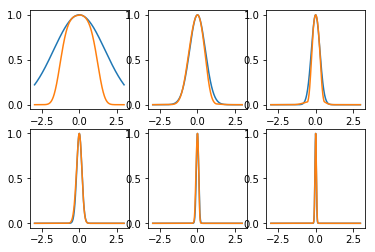

In [27]:
pose.assign(minimum)

from scipy.special import *
obs = pyrosetta.rosetta.protocols.moves.AddPyMOLObserver(pose, True)

Z = 1
for ii in range(6):
    
    sig = 6.0
    h = 0.02

    pose.assign(minimum)

    vals = mode_scan_jump(pose, scorefxn, v[:,ii], w=sig, h=h)
    xx = np.arange(-sig/2.,sig/2.+h,h)
    plt.subplot(2,3,ii+1)

    plt.plot(xx, np.exp(-0.5*w[ii]*(xx)**2))
    plt.plot(xx, np.exp(-(np.array(vals)-scorefxn(minimum))))
    
    if w[ii] < 10: Z *= np.trapz(np.exp(-(np.array(vals)-scorefxn(minimum))), dx=h)
    else: Z *= np.sqrt(2.0*np.pi/w[ii])*erf(np.sqrt(2.0*w[ii])*sig/4.0)
        
    pose.assign(minimum)


In [28]:
0.6163*(-np.log(Z) + np.log(8*np.pi**2) - np.log(6.022e-4) + scorefxn(minimum) - E_0)

1.531409314293078

In [ ]:
print -0.6163*np.log(Z)
print scorefxn(minimum)

In [ ]:
print -0.6163*np.log(np.exp(-4.255/0.6163) + np.exp(-4.985/0.6163) + np.exp(-5.020/0.6163))

print -0.6163*np.log(np.exp(-5.382/0.6163) + np.exp(-5.360/0.6163) + np.exp(-5.394/0.6163) + np.exp(-5.402/0.6163) + np.exp(-5.519/0.6163))

0.6163*0.5*np.log(np.linalg.det(hessian))
print Z

In [ ]:
print v

In [121]:
matt_guess = lambda E: 2*(np.pi)**(len(w)/2)*(2*(E-scorefxn(minimum)))**(len(w)/2-1)/scipy.special.gamma(len(w)/2)/np.sqrt(np.linalg.det(hessian))

In [122]:
x = np.linspace(-100,100,1001)

applying phase space volume for two strand with helix length  1  and dangle length  0
1.0


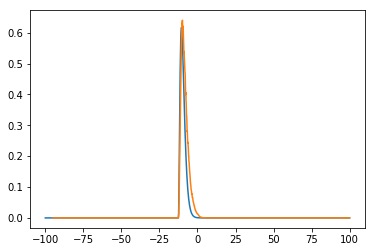

In [129]:
y = np.zeros_like(x)
for i, xx in enumerate(x):
    if xx < scorefxn(minimum): y[i] = 0
    else: y[i] = matt_guess(xx)
    
C = 1/np.sum(y)
print np.sum(c_g_hist._dos)/torsion_volume('c','g')
#plt.plot(x + scorefxn(minimum), C*1e5*y*np.exp(-x/1.0)*torsion_volume('c','g'))
plt.plot(x, y*np.exp(-x/1.0)*C*10)
plt.plot(c_g_hist._dos_scores[50:2000], c_g_hist._dos[50:2000]*np.exp(-c_g_hist._dos_scores[50:2000]/1.0))

In [118]:
print -scipy.special.logsumexp(-x,b=y*C*2.)
print torsion_volume('c','g')
C = torsion_volume('c','g')/np.sum(y)
y *= C


-2.30400962166
applying phase space volume for two strand with helix length  1  and dangle length  0
4.38649084493
applying phase space volume for two strand with helix length  1  and dangle length  0


In [ ]:
plt.plot(x + scorefxn(minimum), y*np.exp(-x/1.0)*torsion_volume('c','g')*1e5)
print np.sum(y)/torsion_volume('c','g')

In [ ]:
print -scipy.special.logsumexp(-x, b=y) + np.log(8*np.pi**2) - np.log(6.022e-4) - E_0 + scorefxn(minimum) + np.log(16*np.pi**2)

In [ ]:
print -np.log(Z)

In [ ]:
-0.6163*np.log(10*np.exp(-6/0.6163))

In [ ]:
print E_0

In [ ]:
print E_0

In [ ]:
print scorefxn(minimum)

In [ ]:
print v

In [ ]:
print 1./np.sqrt(w)

In [ ]:
print xx

In [ ]:
print np.arange(-1.5,1.520,0.0200)

In [ ]:
print E_0

In [ ]:
pmm.apply(minimum)

In [ ]:
print v

In [ ]:
print len(xx)/2

In [ ]:
ST_min = pose_from_file('./../recces_rosetta/min.pdb')
fuck = pose.fold_tree()
ST_min.fold_tree(fuck)

In [ ]:
print ST_min.fold_tree()
fuck = pose.fold_tree()

In [ ]:
scorefxn(ST_min)

In [ ]:
pose.dump_pdb('min3.pdb')

print ST_min.fold_tree()

In [ ]:
pose.set_chi(1, ST_min.chi(1))    

In [ ]:
print v

In [ ]:
pose.assign(minimum)
pose.dump_pdb('./u_g/min.pdb')

In [ ]:
kill_me = pose_from_file('./../recces_rosetta/results/u_g/ST/min.pdb')

In [ ]:
scorefxn(kill_me)

In [ ]:
minmover.apply(kill_me)

In [ ]:
minimum.dump_pdb('a_u_stack_min_1')

In [ ]:
pmm.apply(minimum)